In [1]:
import os
import pandas as pd
import numpy as np
import mne 
import yasa
from sklearn.metrics import confusion_matrix, cohen_kappa_score, f1_score, accuracy_score, precision_score, recall_score
from collections import Counter

# Automatic Sleep Staging

Using YASA automatic sleep stages to check the PSG from Human Sleep Project (HSP) that have more sleep stages than recording. 

In [17]:
import warnings
from sklearn.exceptions import InconsistentVersionWarning

def get_predicted_stages(row):
    """
    Predict sleep stages using YASA for a single subject. YASA uses EEG, EOG, and EMG channels.
    
    Parameters:
    - edf_file_path (str): Path to the EDF file containing EEG, EOG, and EMG data.
    - age (int): Age of the subject.
    - gender (int): Gender of the subject (0: female, 1: male).
    
    Returns:
    - hypno_pred(list): A list of predicted sleep stages (as integers), corresponding to 30-second epochs.
    """
    edf_file_path = row.iloc[0]['edf_path']
    age = row.iloc[0]['age']
    gender = row.iloc[0]['gender']
    print("Prediction for:", edf_file_path, age, gender)

    raw = mne.io.read_raw_edf(edf_file_path, preload=False, verbose='Error')
    print("EDF openned")

    # Extract channel names for EEG, EOG, and EMG
    # The EEG selected is C4 so using opposite EOG (in this case left EOG)
    channel_labels = raw.ch_names
    print(channel_labels)
    emg_name = next((ch for ch in channel_labels if "CHIN" in ch.upper()), None)

    # Try first choice: C4 + E1
    eeg_name = next((ch for ch in channel_labels if "C4" in ch.upper()), None)
    if eeg_name:
        eog_name = next((ch for ch in channel_labels if "E1" in ch.upper()), None)
    else:
        # Fallback: C3 + E2
        eeg_name = next((ch for ch in channel_labels if "C3" in ch.upper()), None)
        if eeg_name:
            eog_name = next((ch for ch in channel_labels if "E2" in ch.upper()), None)

    if not eeg_name or not eog_name or not emg_name:
        print(channel_labels)
        raise ValueError(f"Missing required channels! EEG: {eeg_name}, EOG: {eog_name}, EMG: {emg_name}")
    

    # Predict sleep stages using YASA
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", InconsistentVersionWarning)
        sls = yasa.SleepStaging(
            raw,
            eeg_name=eeg_name,
            eog_name=eog_name,
            emg_name=emg_name,
            metadata=dict(age=age, male=gender)
        )
        hypno_pred = sls.predict()
        
    hypno_pred = yasa.hypno_str_to_int(hypno_pred)
    
    return hypno_pred

## Metrics

In [18]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

def calculate_metrics(actual_stages, predicted_stages):
    """
    Calculate confusion matrix and performance metrics between actual and predicted stages.
    
    Parameters:
    - actual_stages (list): List of actual sleep stages (integers).
    - predicted_stages (list): List of predicted sleep stages (integers).
    
    Returns:
    - tuple: Contains confusion matrix and performance metrics (kappa, f1, accuracy, precision, recall, specificity).
    """
    with warnings.catch_warnings():
        # Ignore warnings for multi-class pos_label and undefined metrics
        warnings.simplefilter("ignore", category=UndefinedMetricWarning)
        warnings.simplefilter("ignore", category=UserWarning)

        actual_stages = np.array(actual_stages, dtype=float)
        predicted_stages = np.array(predicted_stages, dtype=float)
        mask = ~np.isnan(actual_stages) & ~np.isnan(predicted_stages)
        actual_stages = actual_stages[mask].astype(int)
        predicted_stages = predicted_stages[mask].astype(int)

        # Define all possible classes (YASA sleep stages)
        all_classes = [0, 1, 2, 3, 4]

        cm = confusion_matrix(actual_stages, predicted_stages, labels = all_classes)
        kappa = cohen_kappa_score(actual_stages, predicted_stages)
        f1 = f1_score(actual_stages, predicted_stages, average='weighted', zero_division=0)
        accuracy = accuracy_score(actual_stages, predicted_stages)
        precision = precision_score(actual_stages, predicted_stages, average='macro', zero_division=0)
        recall = recall_score(actual_stages, predicted_stages, average='macro', zero_division=0)
        specificity = recall_score(actual_stages, predicted_stages, average='macro', pos_label=0)
        
        return cm, kappa, f1, accuracy, precision, recall, specificity

## MGB 

In [4]:
# read mastersheet
path_mastersheet = "/Users/alicealbrecht/wynton_data/PSG_Pipeline_Outputs/mastersheets"
mgb_mastersheet = pd.read_csv(os.path.join(path_mastersheet, "hsp_mgb_mastersheet_diagnostic.csv"))
for col in ['edf_path','annot_path']:
    mgb_mastersheet[col] = mgb_mastersheet[col].str.replace(
            "/wynton/group/andrews/data",
            "/Users/alicealbrecht/wynton_data"
        )

# add gender and sex
mgb_metadata = pd.read_csv("/Users/alicealbrecht/wynton_data/HSP/PSG/psg-metadata/MGB_S0001_psg_metadata_2025-07-09.csv")
mgb_metadata['sub_id'] = (
    mgb_metadata['SiteID'].astype(str) +
    mgb_metadata['BDSPPatientID'].astype(str)
)
mgb_metadata = mgb_metadata.rename(columns={
    "SessionID": "session",
    "AgeAtVisit": "age",
    "SexDSC": "gender",
})
mgb_mastersheet = mgb_mastersheet.merge(
    mgb_metadata[['sub_id', 'session', 'age', 'gender']],
    on=['sub_id', 'session'],
    how='left'
)
# To have 0:female and 1:male
mgb_mastersheet['gender'] = (
    mgb_mastersheet['gender']
    .str.upper()
    .map({"FEMALE": 0, "MALE": 1})
    .astype('Int64')
)

In [19]:
mgb_ok= [ # to check code and indeed all good !!
    ("S0001111189359", 1),
    ("S0001111230101", 1),
    ("S0001111230101", 2),
    ("S0001111231120", 1),
    ("S0001111233630", 1),
]

In [6]:
mgb_too_long_stages = [
    ("S0001111197789", 1),
    ("S0001111245075", 1),
    ("S0001111348234", 1),
    ("S0001111475060", 1),
    ("S0001111488644", 1),
    ('S0001111606551', 1),
    ("S0001111617864", 1),
    ("S0001111618243", 1),
    ('S0001111702842', 1),
    ('S0001111712191', 1),
    ('S0001111814087', 1),
    ("S0001111936149", 1),
    ("S0001111938879", 1),
    ("S0001111996175", 1),
    ("S0001112042757", 1),
    ("S0001112065946", 3),
    ("S0001112085222", 1),
    ("S0001112174453", 1),
    ("S0001112188265", 1),
    ("S0001112249878", 1),
    ("S0001112380118", 1),
    ("S0001112403938", 1),
    ("S0001112424483", 1),
    ("S0001112554130", 2),
    ("S0001112590511", 1),
    ("S0001112652028", 1),
    ("S0001112668168", 1),
    ("S0001112683010", 1), 
    ("S0001112711097", 1),
    ("S0001112723875", 1),
    ("S0001112744999", 1),
    ("S0001112754157", 1),
    ("S0001112766068", 1),
    ("S0001112818406", 1),
    ("S0001112938704", 1),
    ("S0001112956909", 1),
    ("S0001112960676", 1),
    ("S0001112963404", 1),
    ("S0001113019717", 1),
    ("S0001113071260", 1),
    ("S0001113129809", 1),
    ("S0001113222244", 1),
    ('S0001113462919', 1),
    ("S0001113480244", 1),
    ("S0001113486393", 1),
    ("S0001113506934", 1),
    ("S0001113519470", 1),
    ("S0001113549117", 1),
    ("S0001113559394", 1),
    ('S0001113679154', 1),
    ("S0001113867620", 1),
    ("S0001113921055", 1),
    ("S0001113978799", 1),
    ('S0001114052531', 1),
    ("S0001114080707", 1),
    ("S0001114117719", 1),
    ("S0001114256253", 1),
    ("S0001114291541", 1),
    ("S0001114327800", 1),
    ("S0001114377310", 1),
    ('S0001114387219', 2),
    ('S0001114443023', 1),
    ("S0001114469447", 1),
    ("S0001114521220", 1),
    ("S0001114571964", 1),
    ("S0001114813289", 1),
    ("S0001114840711", 1),
    ("S0001114846354", 1),
    ("S0001114925199", 1),
    ("S0001114952313", 1),
    ("S0001114991708", 1),
    ("S0001114997884", 1),
    ('S0001115013382', 1),
    ("S0001115027117", 1),
    ('S0001115069033', 1),
    ("S0001115082389", 1),
    ("S0001115149203", 1),
    ("S0001115163531", 1),
    ("S0001115259291", 1),
    ("S0001115267089", 1),
    ("S0001115322805", 1),
    ("S0001115517046", 1),
    ('S0001115612359', 1),
    ("S0001115748292", 2),
    ("S0001115764920", 1),
    ("S0001115964097", 1),
    ("S0001116127161", 1),
    ("S0001116248788", 1),
    ("S0001116357451", 1),
    ("S0001116403375", 1),
    ('S0001116413673', 2),
    ("S0001116432527", 1),
    ('S0001116469409', 1),
    ("S0001116622310", 1),
    ("S0001116629174", 1),
    ('S0001116713821', 1),
    ("S0001116838792", 1),
    ("S0001117025577", 1),
    ("S0001117127889", 1),
    ('S0001117128826', 1),
    ("S0001117177482", 1),
    ("S0001117192629", 3),
    ("S0001117217340", 1),
    ("S0001117240268", 1),
    ('S0001117332932', 1),
    ("S0001117347955", 1),
    ("S0001117450922", 1),
    ("S0001117451737", 1),
    ("S0001117532805", 1),
    ("S0001117563796", 2),
    ("S0001117580975", 1),
    ("S0001117736380", 2),
    ('S0001117830134', 2),
    ("S0001117840687", 1),
    ('S0001117857425', 1),
    ("S0001117897731", 1), 
    ("S0001117923744", 1),
    ('S0001117931519', 1),
    ('S0001117991634', 1),
    ("S0001118007817", 1),
    ("S0001118008839", 1),
    ("S0001118072926", 2),
    ("S0001118091558", 1),
    ('S0001118130109', 2),
    ("S0001118148560", 1),
    ('S0001118309609', 2),
    ("S0001118318465", 1),
    ("S0001118338358", 1),
    ("S0001118365087", 1),
    ("S0001118393804", 1),
    ('S0001118462898', 1),
    ('S0001118464555', 1),
    ("S0001118498996", 1),
    ("S0001118509890", 1),
    ('S0001118515170', 1),
    ('S0001118530654', 1),
    ("S0001118651824", 1),
    ("S0001118674324", 1),
    ('S0001118678589', 1),
    ("S0001118707492", 1),
    ('S0001118754887', 1),
    ('S0001118764816', 1),
    ('S0001118850558', 1),
    ("S0001118864707", 1),
    ('S0001118935890', 1),
    ("S0001119040852", 1),
    ("S0001119131744", 1),
    ("S0001119213081", 1),
    ("S0001119220893", 1),
    ('S0001119280722', 2),
    ("S0001119281585", 1),
    ('S0001119308127', 1),
    ("S0001119347074", 1),
    ('S0001119417581', 2),
    ("S0001119426952", 1),
    ('S0001119471533', 1),
    ('S0001119619605', 1),
    ("S0001119831907", 1),
    ('S0001119912310', 1),
    ("S0001119939020", 1),
    ("S0001119950954", 1),
    ("S0001119994525", 1),
    ("S0001120094644", 1),
    ('S0001120158668', 1),
    ('S0001120207354', 1),
    ('S0001120262293', 1),
    ('S0001120292058', 1),
    ("S0001120299564", 1),
    ("S0001120522425", 1),
    ("S0001120582836", 1),
    ("S0001120602693", 1),
    ('S0001120614911', 1),
    ("S0001120741152", 1),
    ("S0001120760241", 1),
    ("S0001120762266", 1),
    ("S0001120768651", 1),
    ("S0001120954836", 1),
    ("S0001121020580", 1),
    ("S0001121088809", 1),
    ("S0001121105167", 1),
    ('S0001121228414', 1),
    ("S0001121340957", 1),
    ("S0001121349735", 1),
    ("S0001121361585", 1),
    ("S0001121423129", 1),
    ("S0001121520764", 1),
    ("S0001121553349", 1),
    ('S0001121570567', 1),
    ("S0001121595348", 1),
    ("S0001121596347", 1),
    ("S0001121625320", 1),
    ("S0001121627473", 1),
    ("S0001121653086", 1),
    ('S0001121659687', 1),
    ("S0001121686233", 1),
    ("S0001121704309", 1),
    ("S0001121722729", 1),
    ("S0001121771338", 1),
    ("S0001121839914", 1),
    ("S0001121870207", 1),
    ("S0001121897515", 1),
    ("S0001121903621", 1),
    ('S0001121903805', 1),
    ("S0001121933931", 1),
    ("S0001121964050", 1),
    ("S0001122082698", 1),
    ("S0001122117332", 1),
    ('S0001122160579', 1),
    ("S0001122179354", 1),
    ("S0001122181275", 1),
    ("S0001122306622", 1),
    ("S0001122315884", 1),
    ("S0001122343393", 1),
    ("S0001122343973", 1),
]

In [7]:
from datetime import datetime, time

############ OTHERS UTIL FUNCTIONS ############ 

def datetime_to_sec(t_input):
    """
    Convert time-like input to seconds since midnight (float, including milliseconds).
    """

    if t_input is None or (isinstance(t_input, float) and np.isnan(t_input)):
        return np.nan

    # --- Convert to string to check for negative seconds ---
    t_str = str(t_input).strip()
    if '-' in t_str.split(' ')[-1]:  # negative seconds detected
        return 0.0

    # --- Handle datetime or time objects ---
    if isinstance(t_input, datetime):
        t_obj = t_input.time()
    elif isinstance(t_input, time):
        t_obj = t_input
    else:
        # Remove timezone suffix if present (e.g., +00:00, Z)
        t_str_clean = t_str.split('+')[0].split('Z')[0]

        t_obj = None
        # Try multiple formats
        for fmt in [
            "%Y-%m-%d %H:%M:%S.%f",
            "%Y-%m-%d %H:%M:%S",
            "%I:%M:%S %p",
            "%H:%M:%S.%f",
            "%H:%M:%S"
        ]:
            try:
                t_obj = datetime.strptime(t_str_clean, fmt).time()
                break
            except ValueError:
                continue

        if t_obj is None:
            print(f"[WARNING] Could not parse time: {t_input}")
            return np.nan

    # --- Compute seconds including fractional part ---
    t_sec = (
        t_obj.hour * 3600 +
        t_obj.minute * 60 +
        t_obj.second +
        t_obj.microsecond / 1e6
    )

    return t_sec


def ensure_post_midnight(times_sec: pd.Series) -> pd.Series:
    continuous_sec = []
    prev_sec = None
    rollover = 0  # track cumulative 24h rollovers

    for sec in times_sec:
        if pd.isna(sec):
            continuous_sec.append(np.nan)
            continue
        if prev_sec is not None and sec + rollover < prev_sec:
            # crossed midnight
            rollover += 24 * 3600
        continuous_sec.append(sec + rollover)
        prev_sec = sec + rollover

    return pd.Series(continuous_sec, index=times_sec.index)

In [49]:
import math

def mgb_get_actual_stages(row):
    sub_id = row.iloc[0]['sub_id']
    session = row.iloc[0]['session']
    psg_id = f"sub-{sub_id}_ses-{session}"
    annot_path = row.iloc[0]['annot_path']
    edf_start_time = row.iloc[0]['start_time']
    sfreq_global = row["sfreq_global"]
    duration_samples = row["duration_samples"]

    try:
        df_events = pd.read_csv(annot_path)
        df_events = df_events.rename(columns={
                "time" : "clock_time",
                "event": "event_type"
                })
        # Convert 'duration' → numeric (replace '-' or missing with 0.0)
        df_events['duration'] = pd.to_numeric(df_events['duration'], errors='coerce').fillna(0.0)

        # Shift event file if not matching recording time
        edf_start_sec = datetime_to_sec(row.iloc[0]["start_time"]) 
        df_events['clock_time'] = df_events['clock_time'].apply(datetime_to_sec)

        # --- START: ENSURING TIME CONTINUITY - MIDNIGHT - LIGHT ---      
        # Find rows with "LIGHT" in 'event_type' (case-insensitive)
        mask_light = df_events['event_type'].str.contains("LIGHT", case=True, na=False)
        light_rows = df_events[mask_light].copy()  # store for later
        df_events = df_events[~mask_light].reset_index(drop=True)  # remove from df_events

        # Get first idx here without LIGHT event added
        first_idx_mask = df_events['clock_time'].notna() & (df_events['clock_time'] != 0)
        first_idx = first_idx_mask.idxmax() if first_idx_mask.any() else 0
        annot_start_sec = df_events['clock_time'].iloc[first_idx]

        # Get first sleep idx (in case event before sleep stages)
        first_idx_sleep_mask = (
            df_events['clock_time'].notna() &
            (df_events['clock_time'] != 0) &
            df_events['event_type'].str.lower().str.contains(r'^sleep|^stage', regex=True)
        )
        first_idx_sleep = first_idx_sleep_mask.idxmax() if first_idx_sleep_mask.any() else 0
        sleep_start_sec = df_events['clock_time'].iloc[first_idx_sleep]

        # Compute drops
        times = df_events['clock_time'].values
        drops = [i for i in range(1, len(times)) if times[i] < times[i - 1]]

        if len(drops) > 1:
            print(f"[INFO] {psg_id}: More than one drop even after removing LIGHT events.")
        else:
            # Only one drop → standard post-midnight adjustment
            df_events['clock_time'] = ensure_post_midnight(df_events['clock_time'])
        
        # Replace correclty the LIGHT events 
        for idx, row in light_rows.iterrows():
            ct = row['clock_time']
            
            # Add 24h if the light event occurs before noon
            if ct < 12*3600:
                ct += 24*3600
            row['clock_time'] = ct

            # Find correct position to insert while keeping ascending order
            insert_idx_candidates = df_events.index[df_events['clock_time'] >= ct].tolist()

            if insert_idx_candidates:
                insert_idx = insert_idx_candidates[0]  # first row >= ct
            else:
                insert_idx = len(df_events)  # append at end if all smaller

            # If the correct position is 0, it safely handles first row
            df_events = pd.concat([
                df_events.iloc[:insert_idx],
                pd.DataFrame([row]),
                df_events.iloc[insert_idx:]
            ]).reset_index(drop=True)
            
            # if abs(idx - insert_idx) > 1:   
            #     print(f"[INFO] {psg_id}: Move event '{row['event_type']}' at index {idx} to new index {insert_idx+1}")
        # --- END: ENSURING TIME CONTINUITY - MIDNIGHT - LIGHT ---    

        # --- START: SHIFT TO MATCH RECORDING START ---
        if (
            (edf_start_sec is not None) and not np.isnan(edf_start_sec) and
            (annot_start_sec is not None) and not np.isnan(annot_start_sec)
            ):
            offset_sec = annot_start_sec - edf_start_sec 
            if abs(offset_sec) <= 1:
                if offset_sec != 0:
                    print(f"[INFO] {psg_id}: Shift of {offset_sec} s")
                df_events["onset"] = df_events["clock_time"].astype(float) - (edf_start_sec + offset_sec)
            elif offset_sec < -1:
                new_offset_sec = sleep_start_sec - edf_start_sec
                if abs(new_offset_sec) <= 1:
                    if new_offset_sec != 0:
                        print(f"[INFO] {psg_id}: Shift of {new_offset_sec} s")
                    df_events["onset"] = df_events["clock_time"].astype(float) - (edf_start_sec + new_offset_sec)
                elif new_offset_sec < -1:
                    print(f"[WARNING] {psg_id}: Events ({offset_sec:.3f}s) and Sleep Stages ({new_offset_sec:.3f}s) start before recording.")
                    df_events["onset"] = df_events["clock_time"].astype(float) - (edf_start_sec)
                else:
                    print(f"[ERROR] {psg_id}: Events start before recording ({offset_sec:.3f}s) and Sleep Stages too much after ({new_offset_sec:.3f}s).")
                    df_events = pd.DataFrame(columns=["onset", "duration", "event_type"]) 
            else:
                print(f"[WARNING] {psg_id}: offset_event >1s ({offset_sec:.3f}s)")
                df_events["onset"] = df_events["clock_time"].astype(float) - (edf_start_sec)
        else:
            print(f"[ERROR] {psg_id}: edf_start ({edf_start_sec}) or annot_start ({annot_start_sec}) is not defined")
        # --- END: SHIFT TO MATCH RECORDING START ---
    
        print("EDF Start Time:", edf_start_time)
        df_events["event_flat"] = df_events["event_type"].str.lower().str.replace(r"[-_ ]", "", regex=True)
        mask_sleep = (
            df_events["event_flat"].str.startswith("sleepstage") |
            df_events["event_flat"].str.startswith("stage")
        )
        df_sleep = df_events[mask_sleep].copy()
        stage_dict = {"W": 0, "WAKE": 0, 
                      "N1": 1, 
                      "N2": 2, 
                      "N3": 3, "N4": 3, "3": 3, "4": 3,
                      "R": 4, "REM": 4}
        df_sleep['sleep_stage'] = (
            df_sleep["event_flat"]
            .str.replace(r"^(sleepstage|stage)", "", case=False, regex=True)
            .str.upper()
            .map(stage_dict)
        )

        epoch_length_sec = 30
        if not (df_sleep["duration"] == epoch_length_sec).all():
            # Append one extra endpoint for the final stage
            all_onsets = np.append(df_sleep["onset"].values,
                                df_sleep["onset"].iloc[-1] + epoch_length_sec)
            # Repeat stage labels
            epoch_counts = (np.diff(all_onsets) // epoch_length_sec).astype(int)
            expanded_stages = np.repeat(df_sleep["sleep_stage"].values, epoch_counts)
            # Construct the new DataFrame
            expanded_onsets = (
                np.arange(len(expanded_stages)) * epoch_length_sec  + df_sleep["onset"].iloc[0]
            )
            df_sleep = pd.DataFrame({
                "onset": expanded_onsets,
                "duration": epoch_length_sec,
                "sleep_stage": expanded_stages
            }).reset_index(drop=True)
    

        # Drop unecessary columns
        cols_to_drop = ['epoch', 'clock_time', 'event_type', 'event_flat']
        existing_cols = [c for c in cols_to_drop if c in df_sleep.columns]
        df_sleep = df_sleep.drop(columns=existing_cols)

        # If mulitple of 30 second than add all the missing sleep stages
        first_sleep_onset = df_sleep.iloc[0]['onset']
        if first_sleep_onset > 0: # add missing stages 
            if abs(first_sleep_onset) % epoch_length_sec == 0: 
                n_missing = int(first_sleep_onset // epoch_length_sec)
                print(f"[INFO] {psg_id}: Adding {n_missing} nan epoch at the begining because first_sleep_onset = {first_sleep_onset}")
                missing_df = pd.DataFrame({
                    "onset": np.arange(n_missing) * epoch_length_sec,
                    "duration": epoch_length_sec,
                    "sleep_stage": [np.nan] * n_missing
                })
                df_sleep = pd.concat([missing_df, df_sleep]).reset_index(drop=True)
            else: 
                print(f"[INFO] {psg_id}: First sleep stage onset not multiple of 30: {first_sleep_onset}")
        
        # If extra sleep at the begging remove them 
        if first_sleep_onset < 0: # remove extra stages 
            n_extra = math.ceil(abs(first_sleep_onset) / epoch_length_sec)
            extra = df_sleep["sleep_stage"].iloc[:n_extra]
            print(f"[INFO] {psg_id}: {n_extra} sleep stages for first_sleep_onset={first_sleep_onset}")
            if all((pd.isna(x) or x == 0) for x in extra):
                df_sleep = df_sleep.iloc[n_extra:]
                print(f"[INFO] {psg_id}: Removing first Sleep Stages: {extra.to_list()}")    
            else: 
                print(f"[ERROR] {psg_id}: Cannot remove first Sleep Stages that contain info: {extra.to_list()}")      
                df_sleep = pd.DataFrame(columns=["onset", "duration", "sleep_stage"])      

        # Deduce full_sleep_stages
        full_sleep_stages = np.full(duration_samples, np.nan) # init
        overflow_values = []
        for i, row in df_sleep.iterrows():
            start_idx = int(row['onset'] * sfreq_global)
            end_idx = int((row['onset'] + epoch_length_sec) * sfreq_global)

            if start_idx >= duration_samples:
                overflow_values.extend(df_sleep.loc[i:, 'sleep_stage'].values)
                break  
            
            if end_idx > (duration_samples):
                next_epoch = duration_samples + (epoch_length_sec *  sfreq_global)
                if end_idx > next_epoch:
                    overflow_values.append(row['sleep_stage'])
                end_idx = duration_samples
            
            full_sleep_stages[start_idx:end_idx] = row['sleep_stage']
        
        print("overflow values:", overflow_values)
        if overflow_values and any(not (np.isnan(x) or x == 0) for x in overflow_values):
            print(f"[WARNING] {psg_id}: Trimming extra sleep_stages: {overflow_values}")

        print("First Sleep Stage: ", str(pd.to_timedelta(df_sleep['clock_time'], unit='s')))


        block_size = 30 * sfreq_global
        actual_stages = []

        for i, block in enumerate(np.array_split(full_sleep_stages, len(full_sleep_stages)//block_size)):
            if np.all(block == block[0]):
                actual_stages.append(block[0])
            else:
                print(f"⚠️ Block {i} not uniform:", block)
                actual_stages.append(block[0])

    except Exception as e:
        print(f"[ERROR] Could not read CSV for {sub_id}, session {session}: {e}")
    
    return actual_stages

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_hypno(predicted_stages, actual_stages):
    # Example arrays
    predicted_stages = np.array(predicted_stages)
    actual_stages = np.array(actual_stages)

    # Logical order from bottom to top: N3, N2, N1, R, W
    stage_labels = ['N3', 'N2', 'N1', 'R', 'W']
    # Mapping numeric stage to plotting order
    mapping = {0:4, 1:2, 2:1, 3:0, 4:3}

    def map_to_plot_order_safe(stages):
        mapped = []
        for s in stages:
            if s is np.nan or (isinstance(s, float) and math.isnan(s)):
                mapped.append(np.nan)
            else:
                mapped.append(mapping[s])
        return np.array(mapped)

    # Map stages for plotting
    actual_plot = map_to_plot_order_safe(actual_stages)
    predicted_plot = map_to_plot_order_safe(predicted_stages)

    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    # 1. Actual hypnogram
    axes[0].step(range(len(actual_plot)), actual_plot, where='mid', color='blue')
    axes[0].set_yticks(range(5))
    axes[0].set_yticklabels(stage_labels)
    axes[0].set_title('Actual Sleep Stages')
    axes[0].grid(True)

    # 2. Predicted hypnogram
    axes[1].step(range(len(predicted_plot)), predicted_plot, where='mid', color='orange')
    axes[1].set_yticks(range(5))
    axes[1].set_yticklabels(stage_labels)
    axes[1].set_title('Predicted Sleep Stages')
    axes[1].grid(True)

    # 3. Combined hypnogram
    axes[2].step(range(len(actual_plot)), actual_plot, where='mid', color='blue', label='Actual')
    axes[2].step(range(len(predicted_plot)), predicted_plot, where='mid', color='orange', alpha=0.7, label='Predicted')
    axes[2].set_yticks(range(5))
    axes[2].set_yticklabels(stage_labels)
    axes[2].set_title('Combined Hypnogram')
    axes[2].set_xlabel('Epoch')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

In [51]:
results = []  # to store best metrics per subject/session

for sub_id, session in mgb_ok:
    print(sub_id, type(sub_id), session, type(session))
    row = mgb_mastersheet[
        (mgb_mastersheet['sub_id'] == str(sub_id)) & 
        (mgb_mastersheet['session'] == int(session))
    ]
    if row.empty:
        print(f"[WARNING] No row found for {sub_id}, session {session}")
        continue
    
    predicted_stages = get_predicted_stages(row)
    actual_stages = mgb_get_actual_stages(row)

    predicted_stages = np.array(predicted_stages, dtype=float)
    actual_stages = np.array(actual_stages[:len(predicted_stages)],dtype=float)

    cm, kappa, f1, accuracy, precision, recall, specificity = calculate_metrics(actual_stages, predicted_stages)
    composite_score = (
        0.25 * accuracy +
        0.20 * f1 +
        0.20 * kappa +
        0.15 * precision +
        0.10 * recall +
        0.10 * specificity
    )
    
    # Save best results for this subject/session
    results.append({
        'sub_id': sub_id,
        'session': session, 
        'accuracy': accuracy,
        'f1': f1,
        'kappa': kappa,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'composite_score': composite_score,
        'cm': cm,
    })

    if composite_score >= 0.75:
        status = "GOOD"
    elif composite_score >= 0.65:
        status = "REVIEW"  # borderline
    else:
        status = "BAD"
        
    # Compact progress print
    print(
        f"{status} "
        f"[{sub_id}-{session}] "
        f"Acc={accuracy:.2f} "
        f"F1={f1:.2f} "
        f"Kappa={kappa:.2f} "
        f"Precision={precision:.2f} "
        f"Recall={recall:.2f} "
        f"Specificity={specificity:.2f} "
        f"Score={composite_score:.2f} "
    )
    #print(best_row['cm'])

    plot_hypno(predicted_stages, actual_stages)

results_df = pd.DataFrame(results)

S0001111189359 <class 'str'> 1 <class 'int'>
Prediction for: /Users/alicealbrecht/wynton_data/HSP/PSG/bids/MGB/sub-S0001111189359/ses-1/eeg/sub-S0001111189359_ses-1_task-psg_eeg.edf 62 1
EDF openned
['F3-M2', 'F4-M1', 'C3-M2', 'C4-M1', 'CZ-M1', 'O1-M2', 'O2-M1', 'E1-M2', 'E2-M1', 'CHIN1-CHIN2', 'LAT', 'RAT', 'SNORE', 'PTAF', 'AIRFLOW', 'CHEST', 'ABD', 'IC', 'EKG', 'SaO2', 'HR']
EDF Start Time: 2013-04-02 22:21:57+00:00
[ERROR] Could not read CSV for S0001111189359, session 1: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


/var/folders/nk/ctx5v5kd62l2xk1gz7kgm5vr0000gn/T/ipykernel_85415/3337087368.py:186: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  start_idx = int(row['onset'] * sfreq_global)
/var/folders/nk/ctx5v5kd62l2xk1gz7kgm5vr0000gn/T/ipykernel_85415/3337087368.py:187: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  end_idx = int((row['onset'] + epoch_length_sec) * sfreq_global)


UnboundLocalError: local variable 'actual_stages' referenced before assignment

## BIDMC

In [14]:
# read mastersheet
path_mastersheet = "/Users/alicealbrecht/wynton_data/PSG_Pipeline_Outputs/mastersheets"
bidmc_mastersheet = pd.read_csv(os.path.join(path_mastersheet, "hsp_bidmc_mastersheet_diagnostic.csv"))
for col in ['edf_path','annot_path','sleep_stage_path']:
    bidmc_mastersheet[col] = bidmc_mastersheet[col].str.replace(
            "/wynton/group/andrews/data",
            "/Users/alicealbrecht/wynton_data"
        )

# add gender and sex
bidmc_metadata = pd.read_csv("/Users/alicealbrecht/wynton_data/HSP/PSG/psg-metadata/BIDMC_I0002_psg_metadata_2025-07-09.csv")
bidmc_metadata['sub_id'] = (
    bidmc_metadata['SiteID'].astype(str) +
    bidmc_metadata['BDSPPatientID'].astype(str)
)
bidmc_metadata = bidmc_metadata.rename(columns={
    "SessionID": "session",
    "AgeAtVisit": "age",
    "SexDSC": "gender",
})
bidmc_mastersheet = bidmc_mastersheet.merge(
    bidmc_metadata[['sub_id', 'session', 'age', 'gender']],
    on=['sub_id', 'session'],
    how='left'
)
# To have 0:female and 1:male
bidmc_mastersheet['gender'] = (
    bidmc_mastersheet['gender']
    .str.upper()
    .map({"F": 0, "M": 1})
    .astype('Int64')
)

In [ ]:
bidmc_too_long_stages = [
    ('I0002150002539', 1),
    ('I0002150004333', 1),
    ('I0002150005830', 1),
    ('I0002150006423', 1),
    ('I0002150009392', 1),
    ('I0002150014635', 1),
    ('I0002150014721', 2),
    ('I0002150021810', 1),
    ('I0002150021974', 2),
    ('I0002150022165', 1),
    ('I0002150022350', 3),
    ('I0002150024740', 1),
    ('I0002150029045', 1),
    ('I0002150029143', 1),
    ('I0002150029324', 1),
    ('I0002150029877', 1),
    ('I0002150030309', 1),
    ('I0002150030372', 1),
    ('I0002150030460', 1),
    ('I0002150030525', 1),
    ('I0002150030699', 1),
    ('I0002150030812', 1),
    ('I0002150030846', 1),
    ('I0002150030931', 1),
    ('I0002150030940', 1),
    ('I0002150031009', 1),
    ('I0002150031027', 1),
    ('I0002150031028', 1),
    ('I0002150031064', 1),
    ('I0002150031178', 1), 
    ('I0002150031270', 1),
    ('I0002150031291', 2),
    ('I0002150031604', 1),
    ('I0002150031637', 1),
    ('I0002150031869', 1),
    ('I0002150032005', 1),
    ('I0002150032018', 1),
    ('I0002150032093', 3),
    ('I0002150032159', 1),
    ('I0002150032216', 1),
    ('I0002150032388', 1),
    ('I0002150032510', 1),
    ('I0002150032516', 1),
    ('I0002150032729', 1),
    ('I0002150032773', 1),
    ('I0002150032857', 1),
    ('I0002150032879', 1),
    ('I0002150032946', 1),
    ('I0002150033085', 1),
    ('I0002150033086', 1),
    ('I0002150033089', 1),
    ('I0002150033170', 1),
    ('I0002150033201', 1),
    ('I0002150033236', 2),
    ('I0002150033265', 1),
    ('I0002150033331', 1),
    ('I0002150033339', 1),
    ('I0002150033353', 2),
    ('I0002150033393', 1),
    ('I0002150033394', 1),
    ('I0002150033474', 1),
    ('I0002150033484', 1),
    ('I0002150033507', 1),
    ('I0002150033566', 1),
    ('I0002150033576', 1),
    ('I0002150033587', 1),
    ('I0002150033657', 2),
    ('I0002150033670', 1),
    ('I0002150033708', 2),
    ('I0002150033786', 1),
    ('I0002150033858', 1),
    ('I0002150033862', 1),
    ('I0002150033980', 1),
    ('I0002150033984', 1),
    ('I0002150034072', 1),
    ('I0002150034084', 2),
    ('I0002150034522', 2),
    ('I0002150034534', 1),
    ('I0002150034598', 1),
    ('I0002150034669', 1),
    ('I0002150034903', 1),
    ('I0002150034907', 1),
    ('I0002150034999', 1),
    ('I0002150035040', 1),
    ('I0002150036149', 1),
    ('I0002150036819', 1),
    ('I0002150036961', 1),
    ('I0002150038599', 1),
    ('I0002150040240', 2),
    ('I0002150043035', 2),
    ('I0002150043460', 1),
    ('I0002150043675', 1),
    ('I0002150044160', 1),
    ('I0002150050670', 1),
    ('I0002150058721', 1),
    ('I0002150066409', 1),
    ('I0002150572263', 1),
    ('I0002150607879', 1),
    ('I0002150807875', 1),
    ('I0002150932292', 1),
    ('I0002150961258', 1),
    ('I0002150992641', 1),
    ('I0002151065364', 1),
    ('I0002151114878', 1),
    ('I0002151117400', 1),
    ('I0002151123460', 1),
    ('I0002151191192', 1),
    ('I0002151255711', 1),
    ('I0002151260928', 1),
    ('I0002151273221', 1),
    ('I0002151278908', 1),
    ('I0002151281844', 2),
    ('I0002151340227', 1),
    ('I0002151369599', 1),
    ('I0002151379683', 1),
    ('I0002151669068', 1),
    ('I0002151694957', 1),
    ('I0002151702574', 1),
    ('I0002151704170', 1),
    ('I0002151724571', 1),
    ('I0002151734169', 1)]

In [11]:
def bidmc_get_actual_stages(row):
    sub_id = row.iloc[0]['sub_id']
    session = row.iloc[0]['session']
    sleep_path = row.iloc[0]['sleep_stage_path']
        
    try:
        df = pd.read_csv(sleep_path)
        #print(f"Loaded CSV for {sub_id}, session {session}, shape: {df.shape}")
        stage_dict = {"W": 0, "WAKE": 0, 
                    "N1": 1, "1": 1,
                    "N2": 2, "2": 2,
                    "N3": 3, "N4": 3, "3": 3, "4": 3,
                    "R": 4, "REM": 4}
        actual_stages = [stage_dict.get(str(s), np.nan) for s in df['Stage']]
    except Exception as e:
        print(f"[ERROR] Could not read CSV for {sub_id}, session {session}: {e}")
    
    return actual_stages

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_hypno(predicted_stages, actual_stages):
    # Example arrays
    predicted_stages = np.array(predicted_stages)
    actual_stages = np.array(actual_stages)

    # Logical order from bottom to top: N3, N2, N1, R, W
    stage_labels = ['N3', 'N2', 'N1', 'R', 'W']
    # Mapping numeric stage to plotting order
    mapping = {0:4, 1:2, 2:1, 3:0, 4:3}

    def map_to_plot_order_safe(stages):
        mapped = []
        for s in stages:
            if s is np.nan or (isinstance(s, float) and math.isnan(s)):
                mapped.append(np.nan)
            else:
                mapped.append(mapping[s])
        return np.array(mapped)

    # Map stages for plotting
    actual_plot = map_to_plot_order_safe(actual_stages)
    predicted_plot = map_to_plot_order_safe(predicted_stages)

    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    # 1. Actual hypnogram
    axes[0].step(range(len(actual_plot)), actual_plot, where='mid', color='blue')
    axes[0].set_yticks(range(5))
    axes[0].set_yticklabels(stage_labels)
    axes[0].set_title('Actual Sleep Stages')
    axes[0].grid(True)

    # 2. Predicted hypnogram
    axes[1].step(range(len(predicted_plot)), predicted_plot, where='mid', color='orange')
    axes[1].set_yticks(range(5))
    axes[1].set_yticklabels(stage_labels)
    axes[1].set_title('Predicted Sleep Stages')
    axes[1].grid(True)

    # 3. Combined hypnogram
    axes[2].step(range(len(actual_plot)), actual_plot, where='mid', color='blue', label='Actual')
    axes[2].step(range(len(predicted_plot)), predicted_plot, where='mid', color='orange', alpha=0.7, label='Predicted')
    axes[2].set_yticks(range(5))
    axes[2].set_yticklabels(stage_labels)
    axes[2].set_title('Combined Hypnogram')
    axes[2].set_xlabel('Epoch')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()

BAD [I0002150002539-1] Acc=0.68 F1=0.64 Kappa=0.19 Precision=0.30 Recall=0.29 Specificity=0.29 Score=0.44 


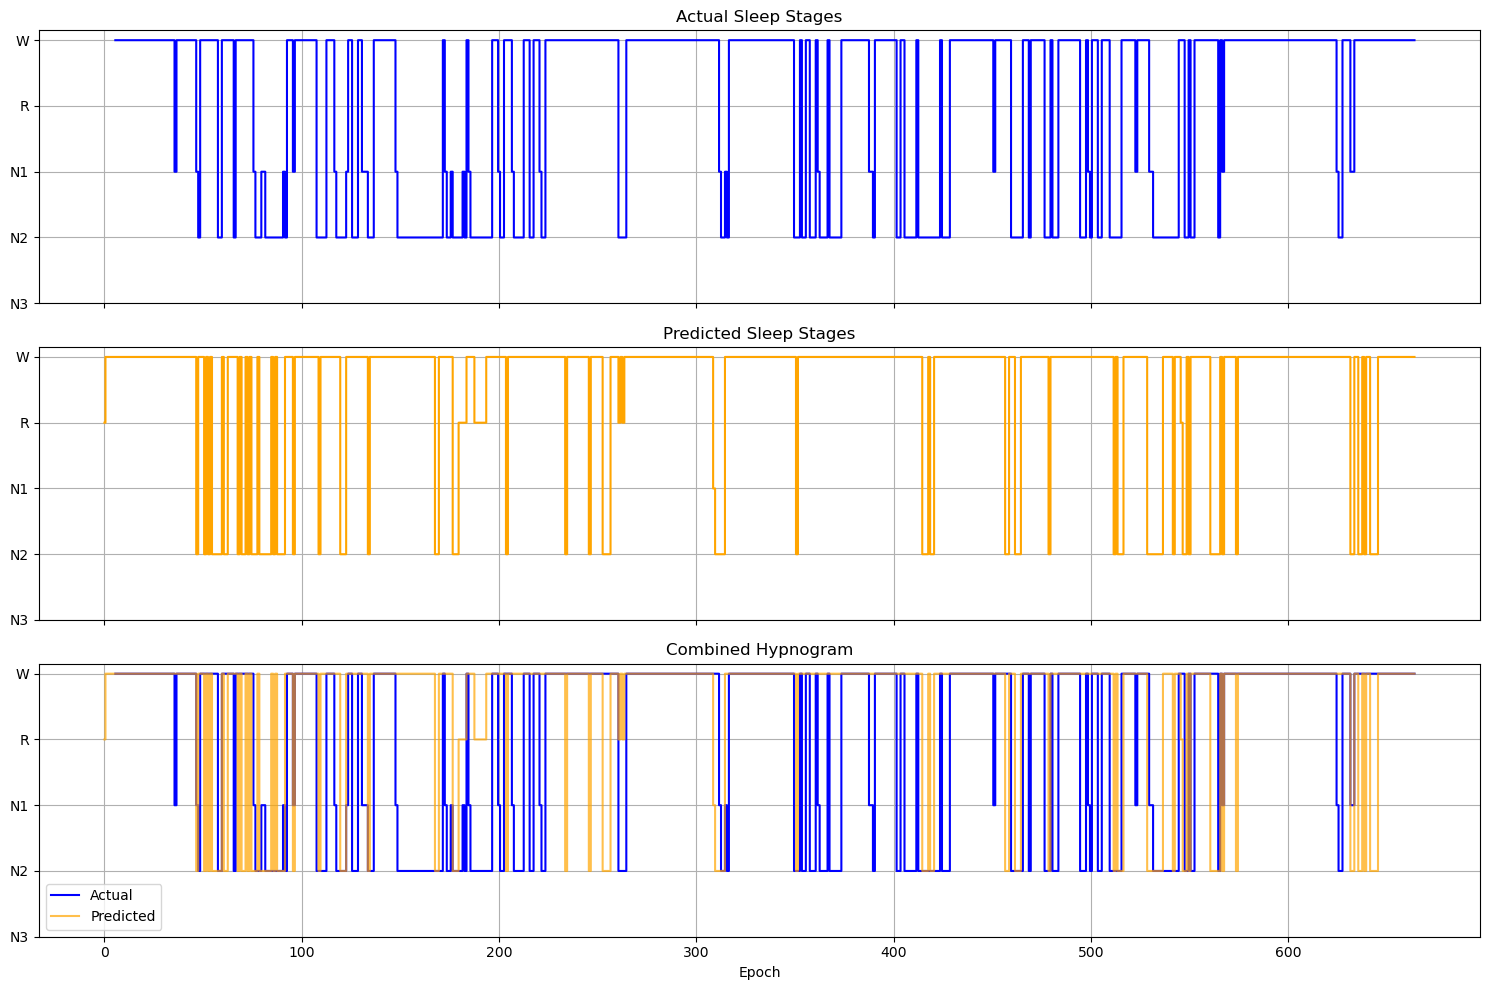

REVIEW [I0002150004333-1] Acc=0.73 F1=0.73 Kappa=0.60 Precision=0.64 Recall=0.62 Specificity=0.62 Score=0.67 


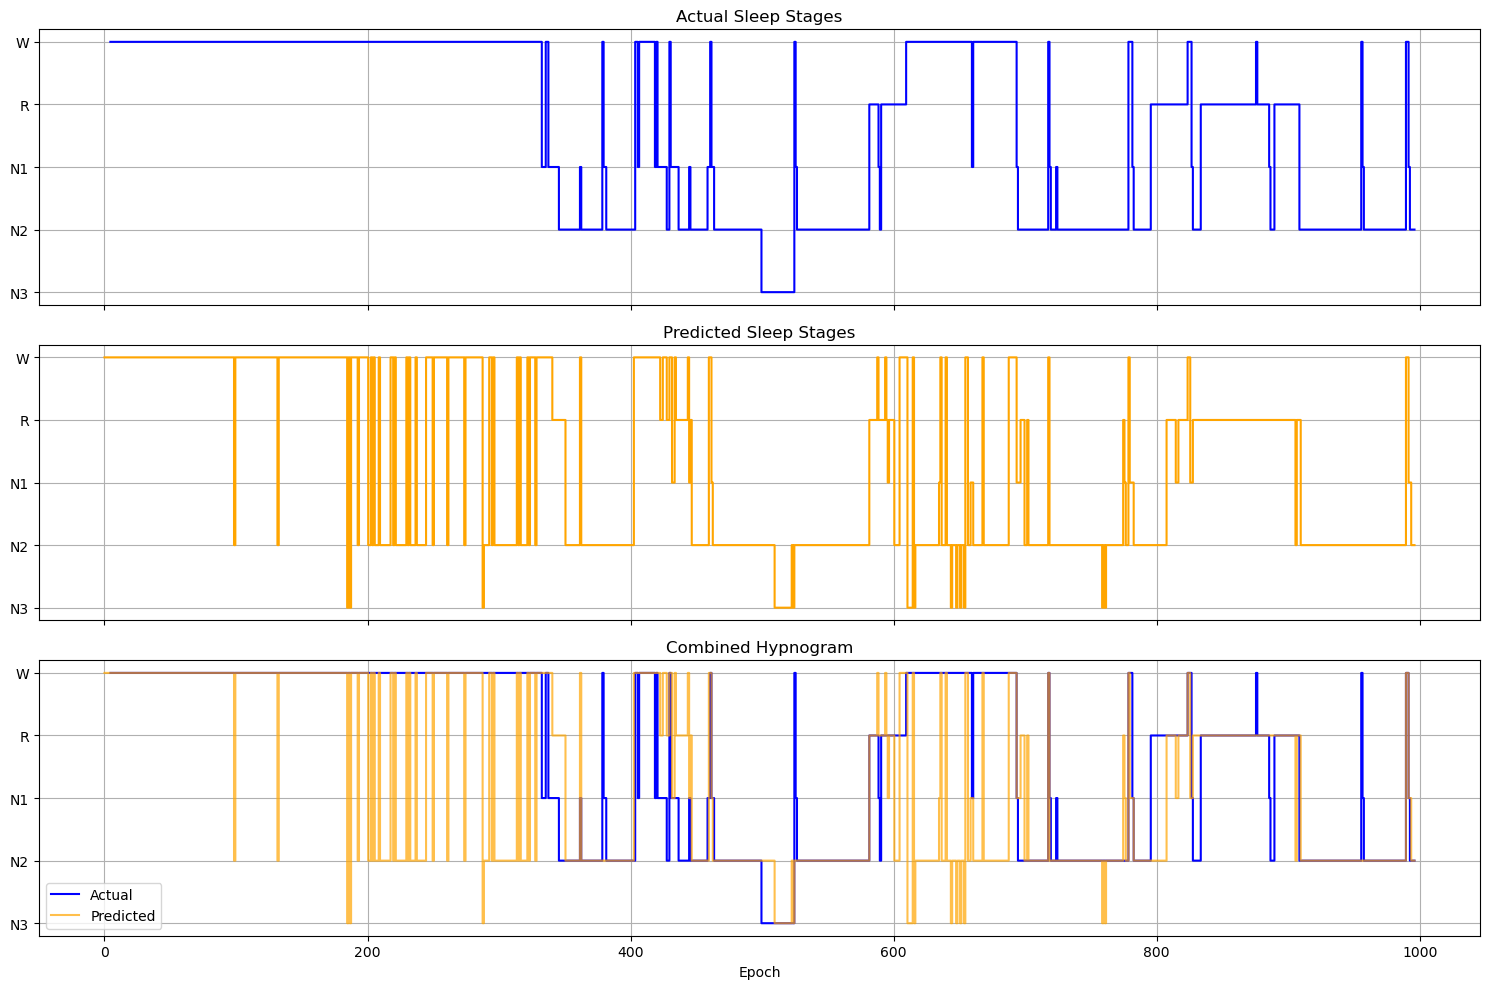

BAD [I0002150005830-1] Acc=0.70 F1=0.70 Kappa=0.56 Precision=0.61 Recall=0.64 Specificity=0.64 Score=0.65 


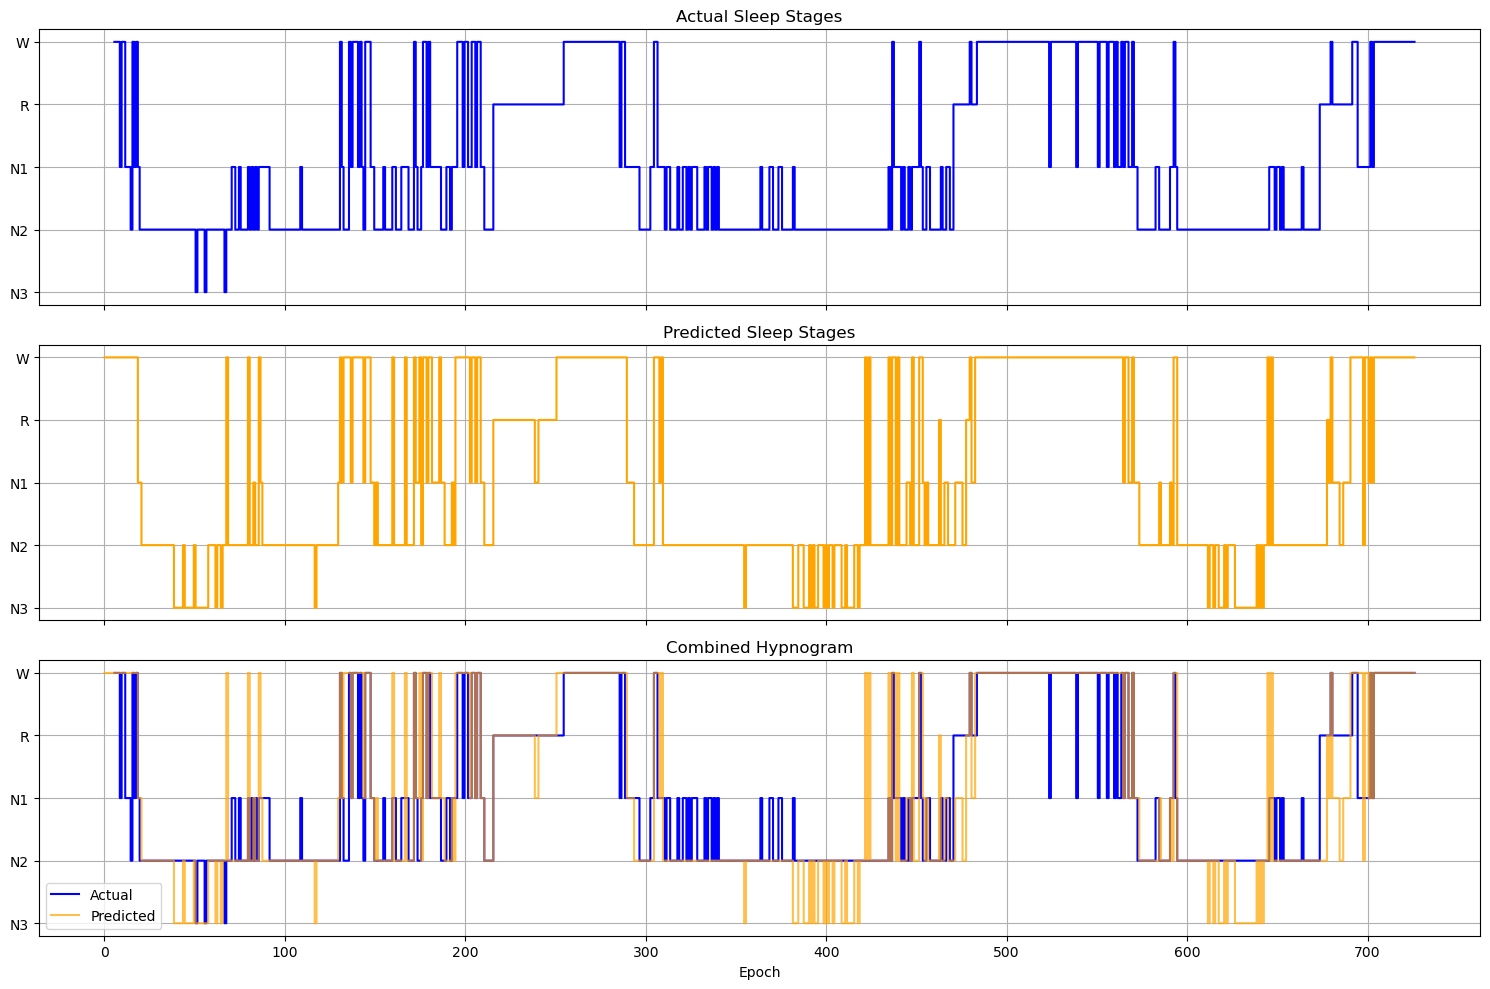

BAD [I0002150006423-1] Acc=0.66 F1=0.68 Kappa=0.52 Precision=0.58 Recall=0.65 Specificity=0.65 Score=0.62 


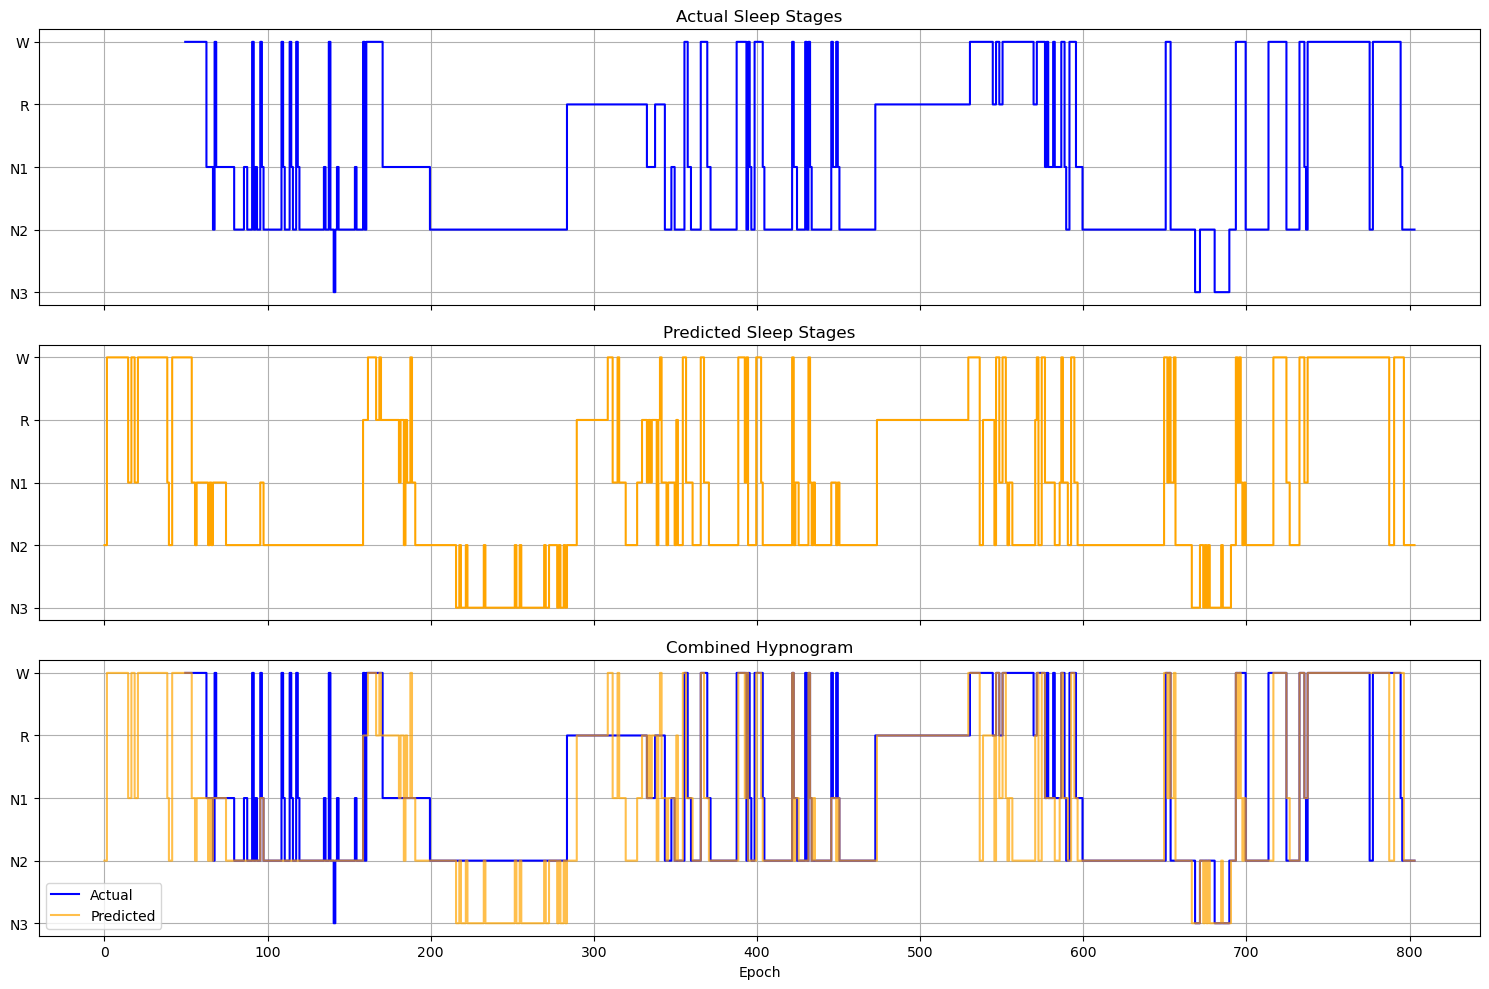

REVIEW [I0002150009392-1] Acc=0.84 F1=0.82 Kappa=0.64 Precision=0.48 Recall=0.71 Specificity=0.71 Score=0.72 


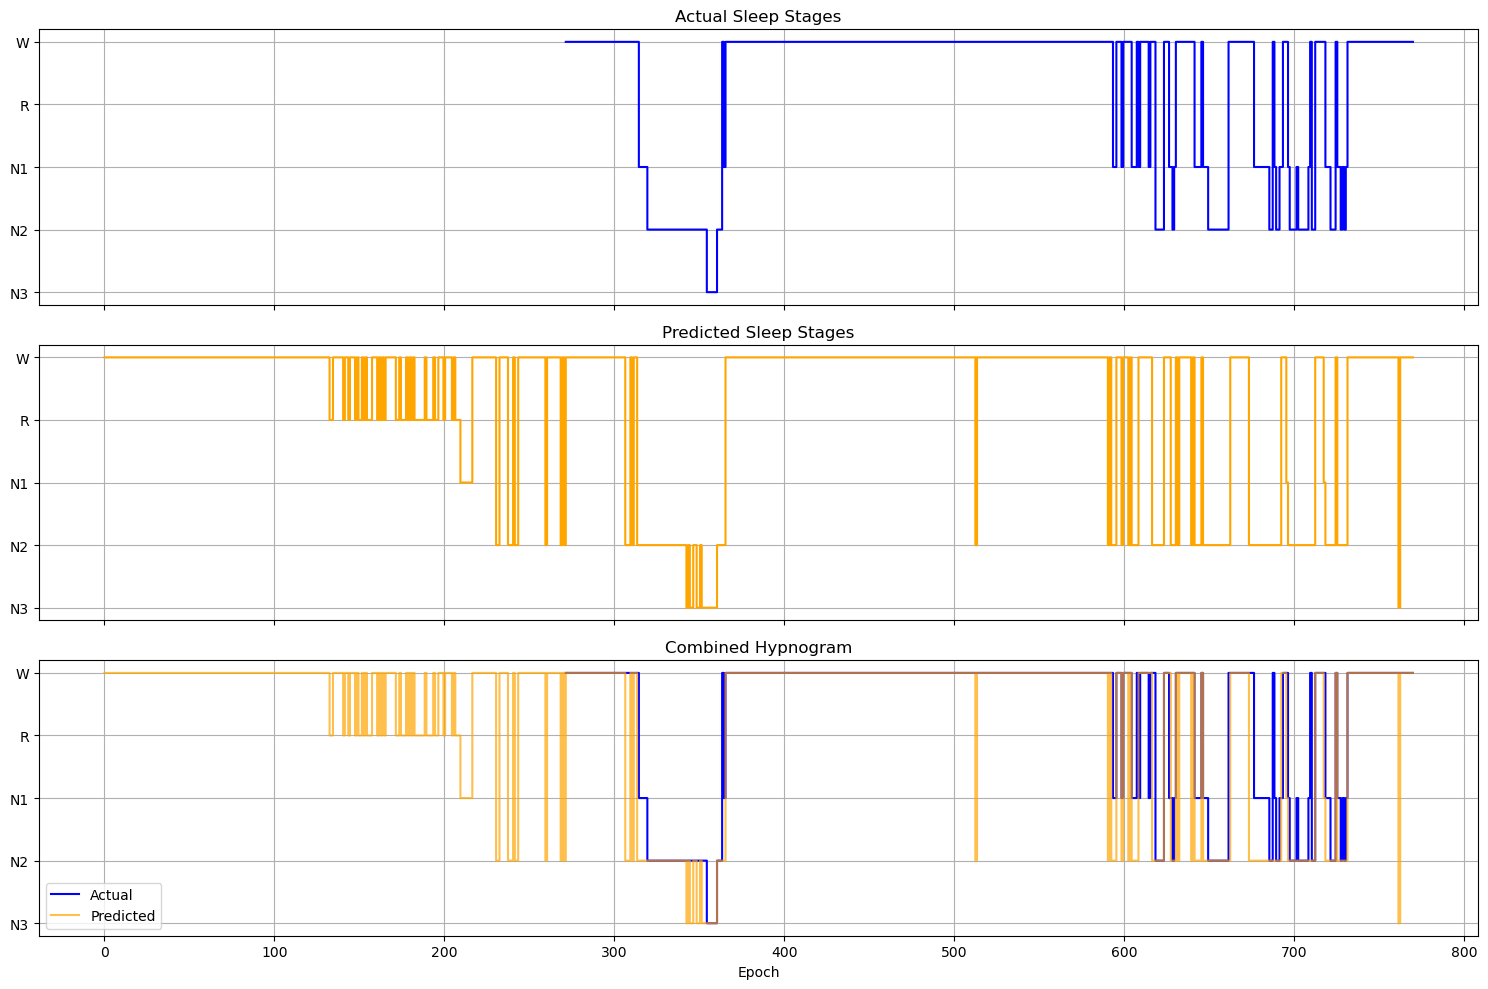

BAD [I0002150014635-1] Acc=0.72 F1=0.73 Kappa=0.52 Precision=0.51 Recall=0.50 Specificity=0.50 Score=0.61 


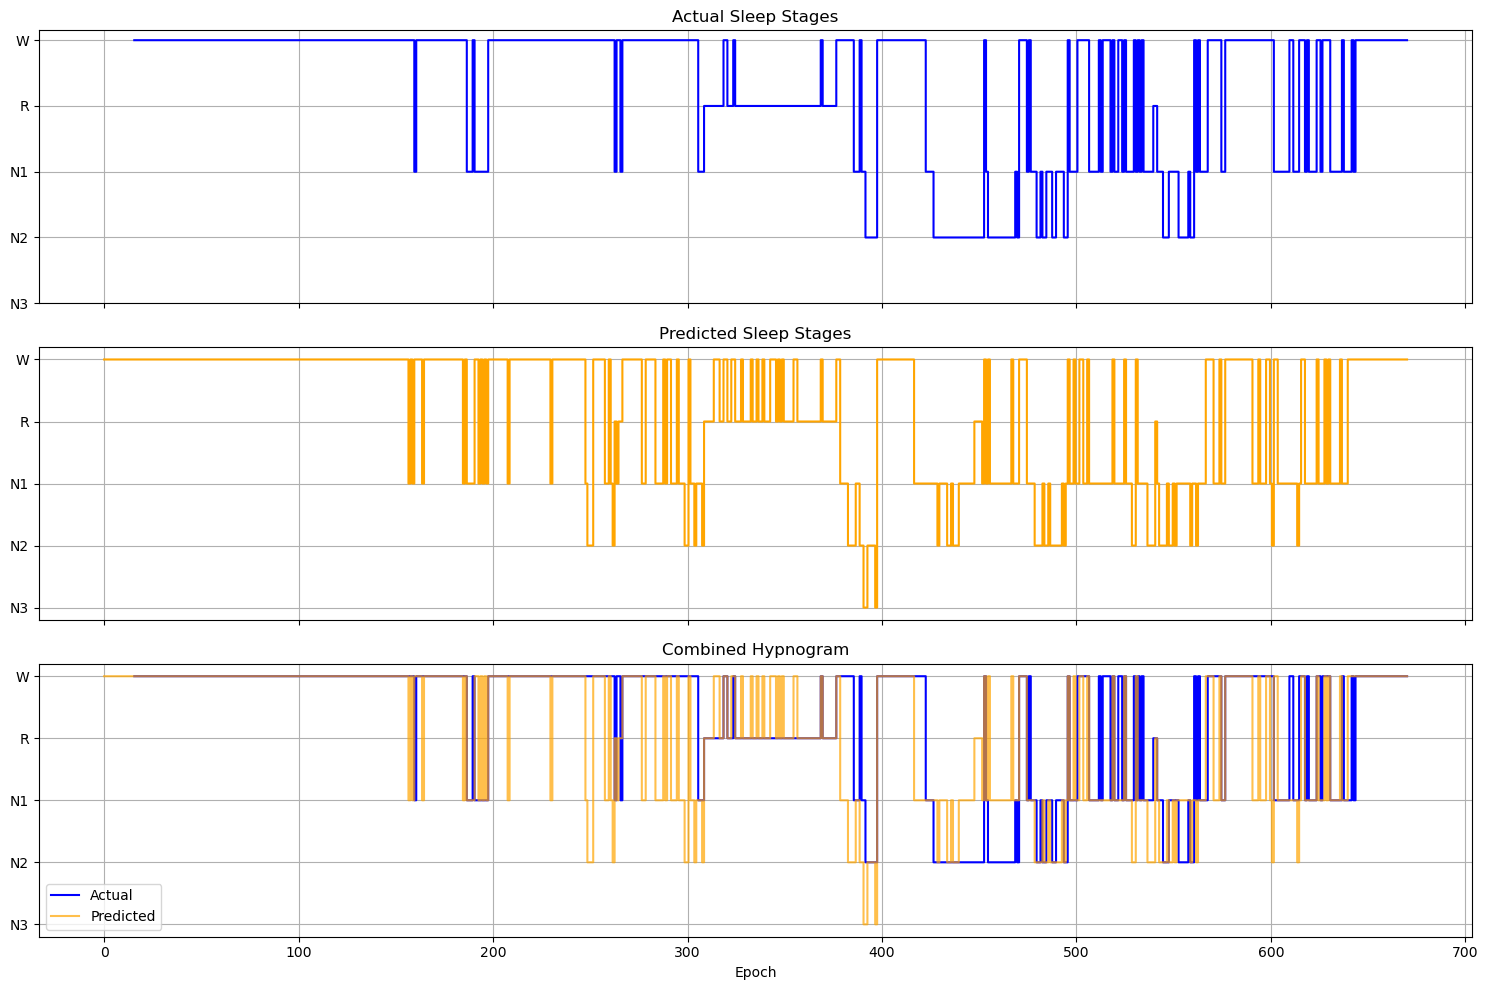

REVIEW [I0002150014721-2] Acc=0.86 F1=0.83 Kappa=0.69 Precision=0.37 Recall=0.39 Specificity=0.39 Score=0.65 


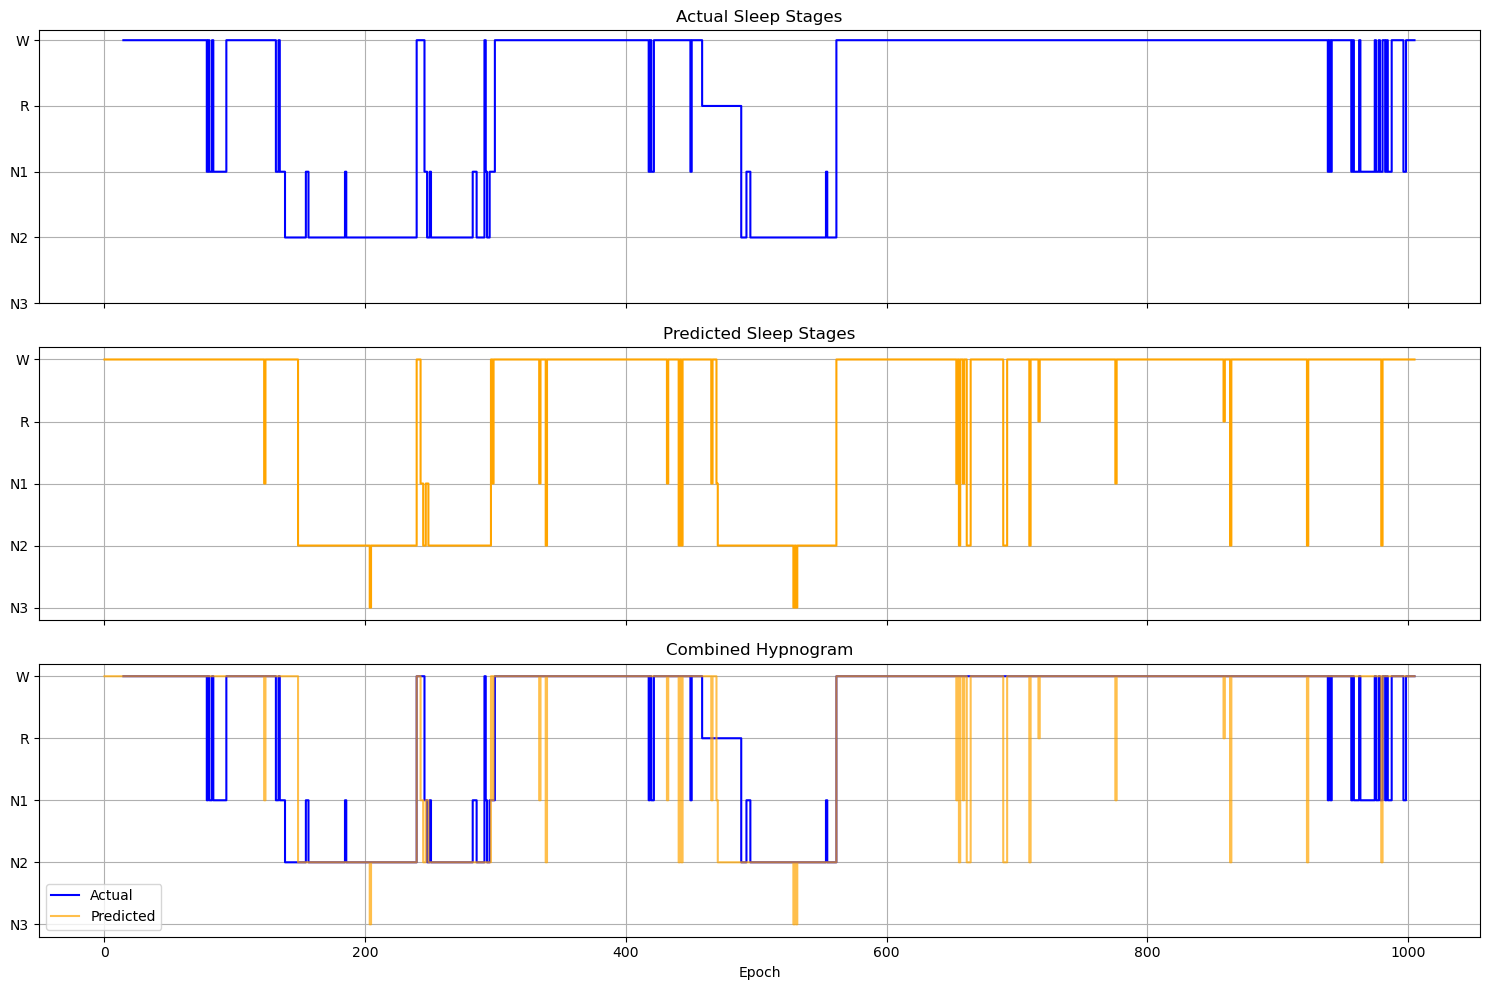

GOOD [I0002150021810-1] Acc=0.87 F1=0.86 Kappa=0.82 Precision=0.85 Recall=0.79 Specificity=0.79 Score=0.84 


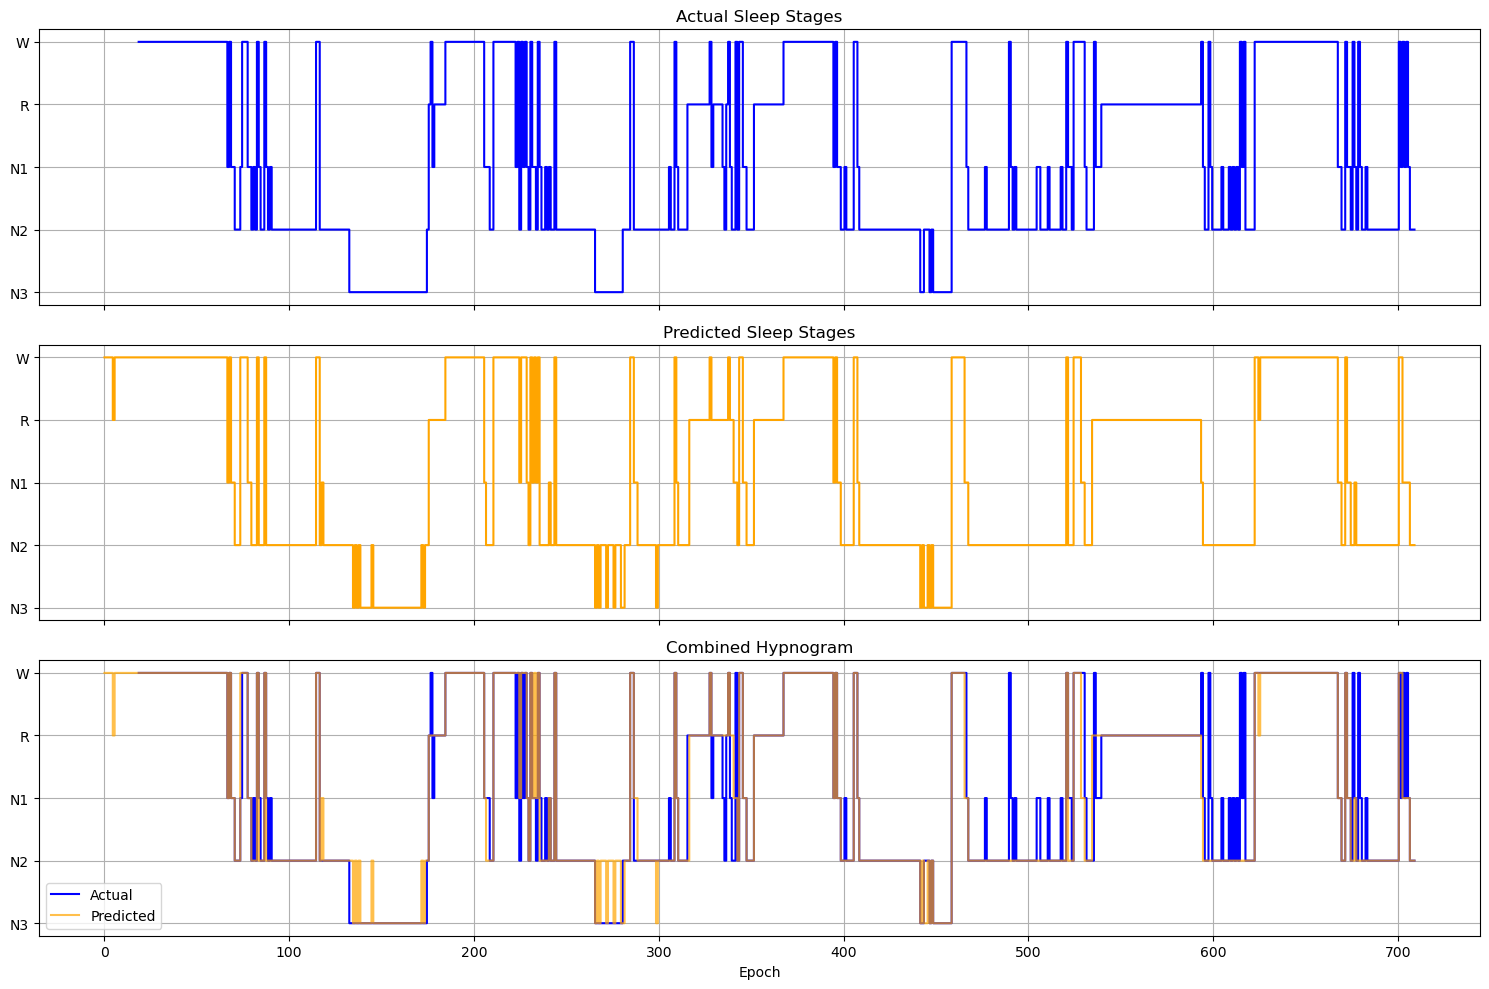

BAD [I0002150021974-2] Acc=0.56 F1=0.52 Kappa=0.41 Precision=0.49 Recall=0.47 Specificity=0.47 Score=0.49 


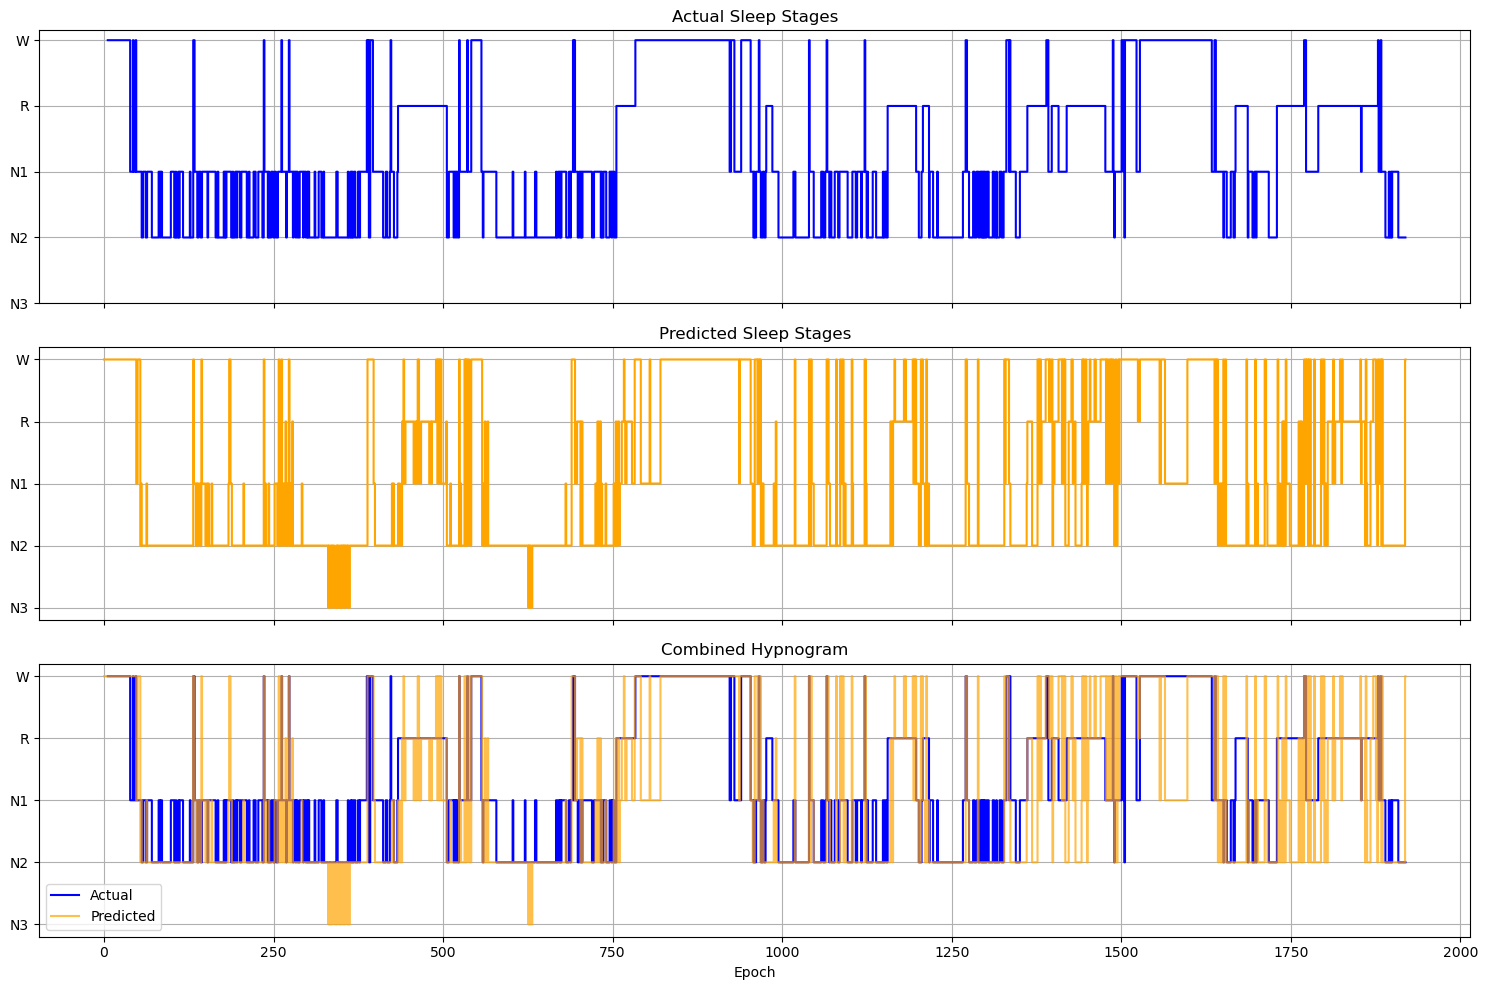

BAD [I0002150022165-1] Acc=0.46 F1=0.31 Kappa=0.02 Precision=0.38 Recall=0.26 Specificity=0.26 Score=0.29 


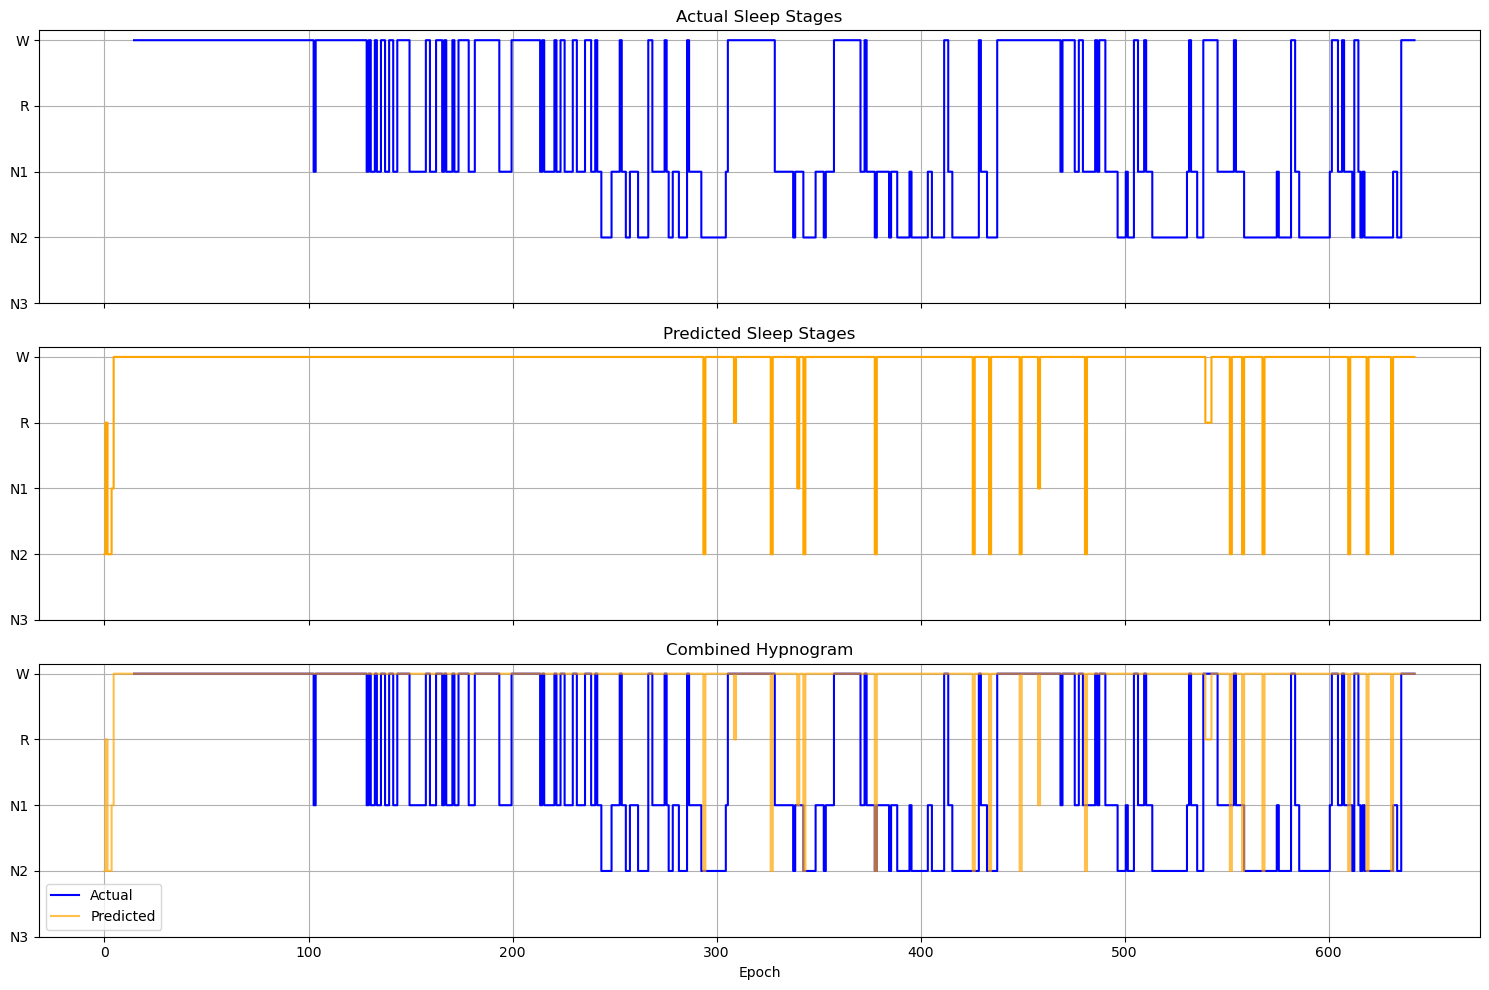

REVIEW [I0002150022350-3] Acc=0.71 F1=0.69 Kappa=0.62 Precision=0.76 Recall=0.71 Specificity=0.71 Score=0.70 


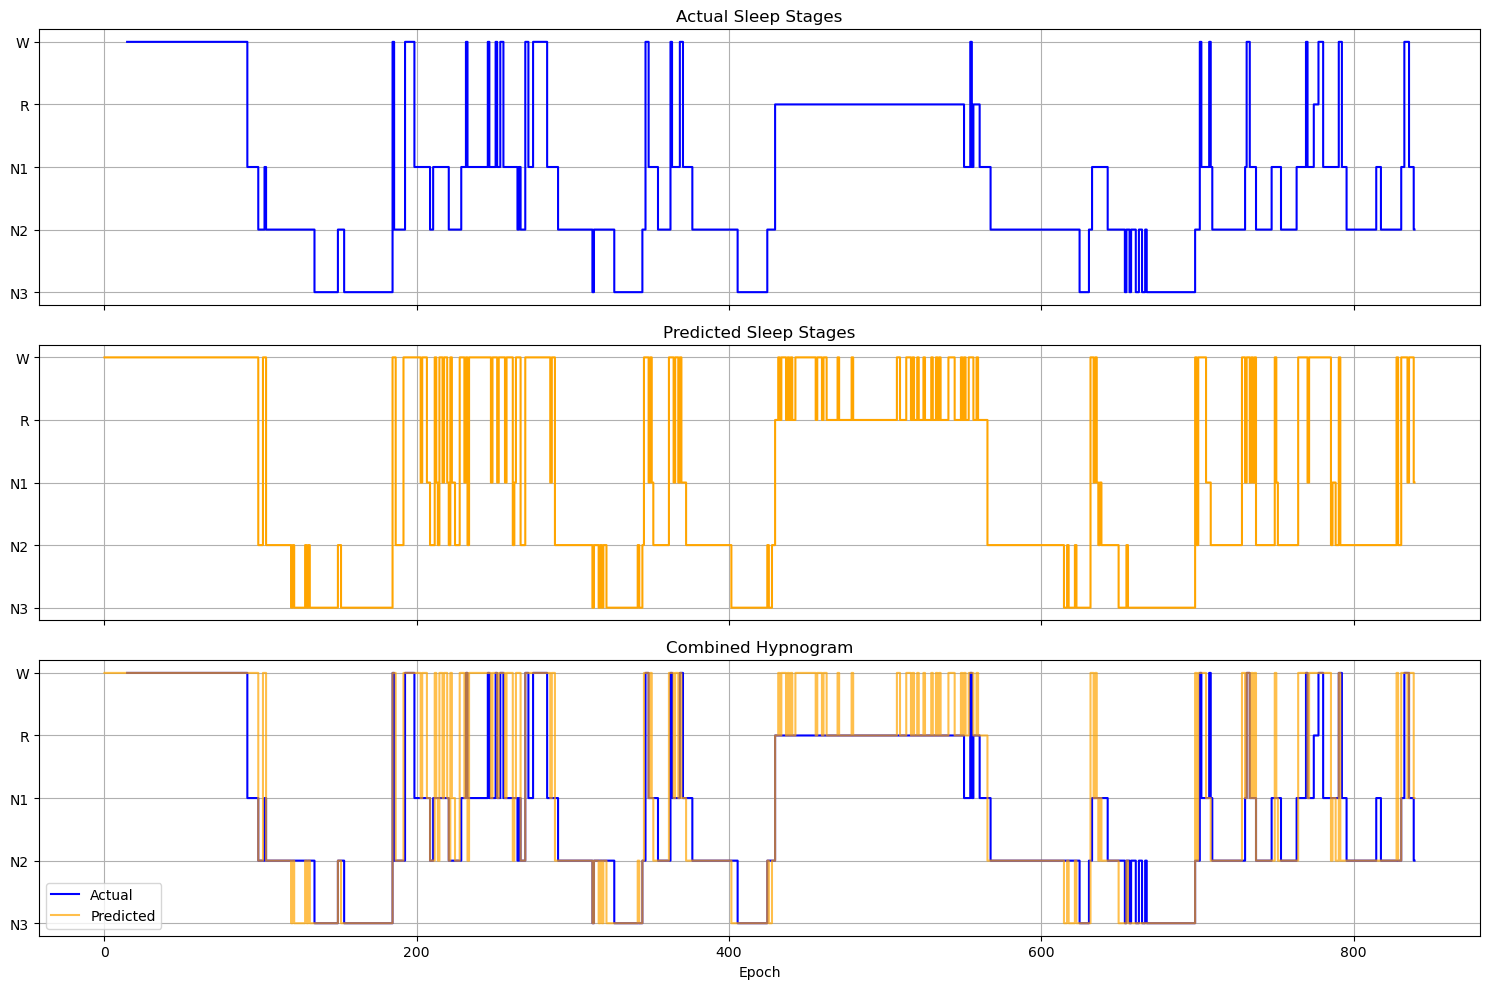

BAD [I0002150024740-1] Acc=0.73 F1=0.74 Kappa=0.56 Precision=0.53 Recall=0.52 Specificity=0.52 Score=0.63 


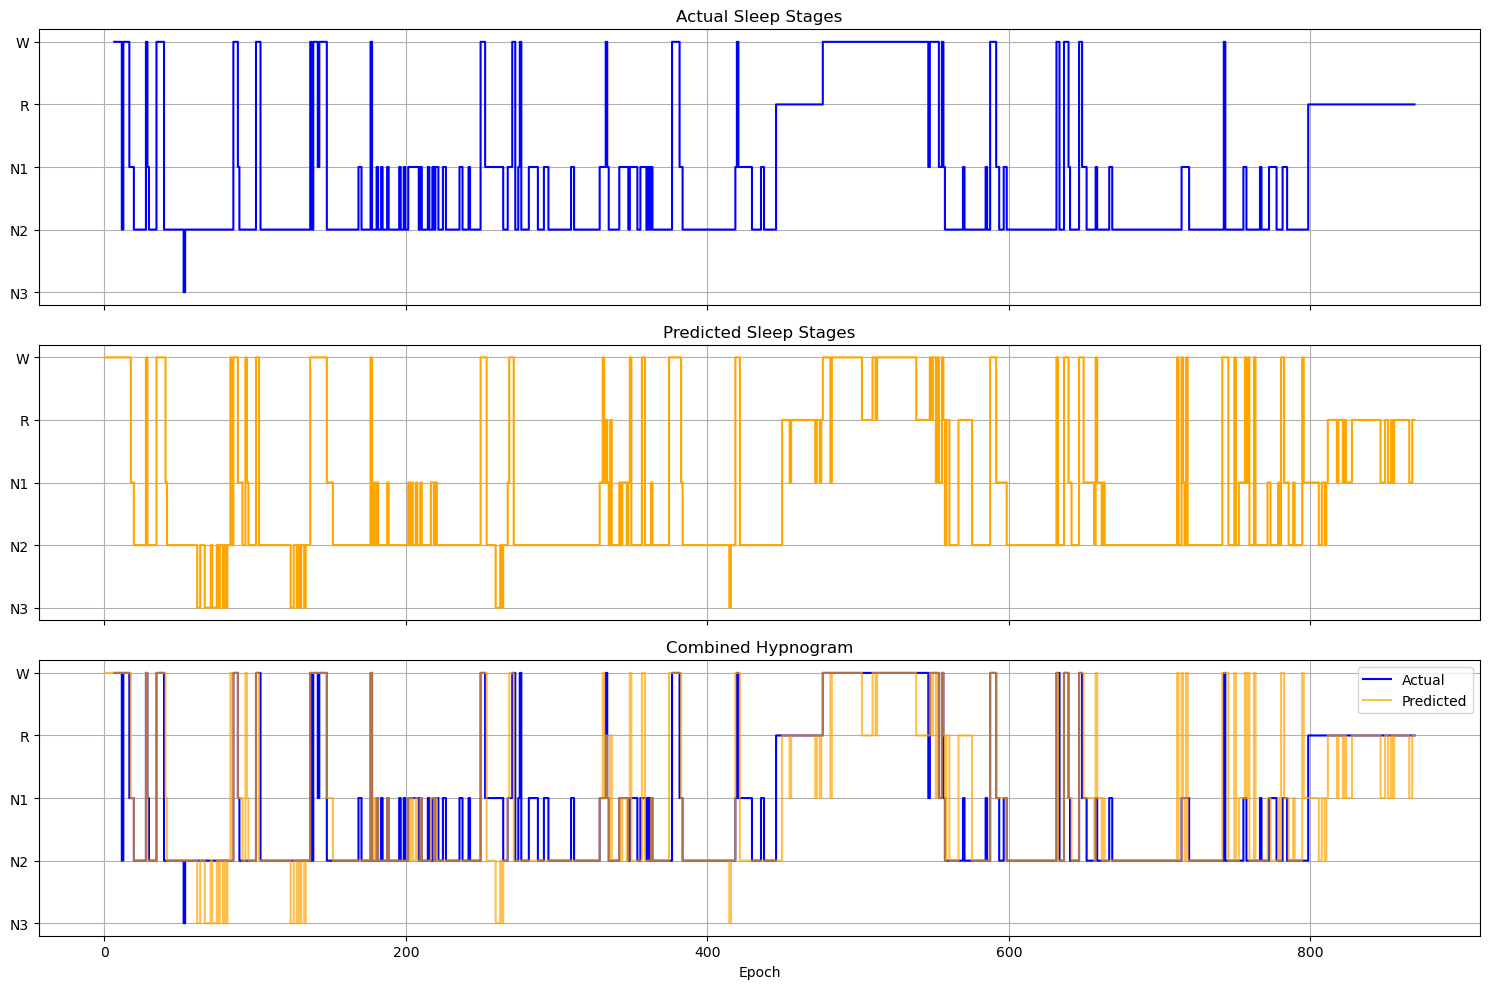

REVIEW [I0002150029045-1] Acc=0.70 F1=0.73 Kappa=0.56 Precision=0.56 Recall=0.70 Specificity=0.70 Score=0.66 


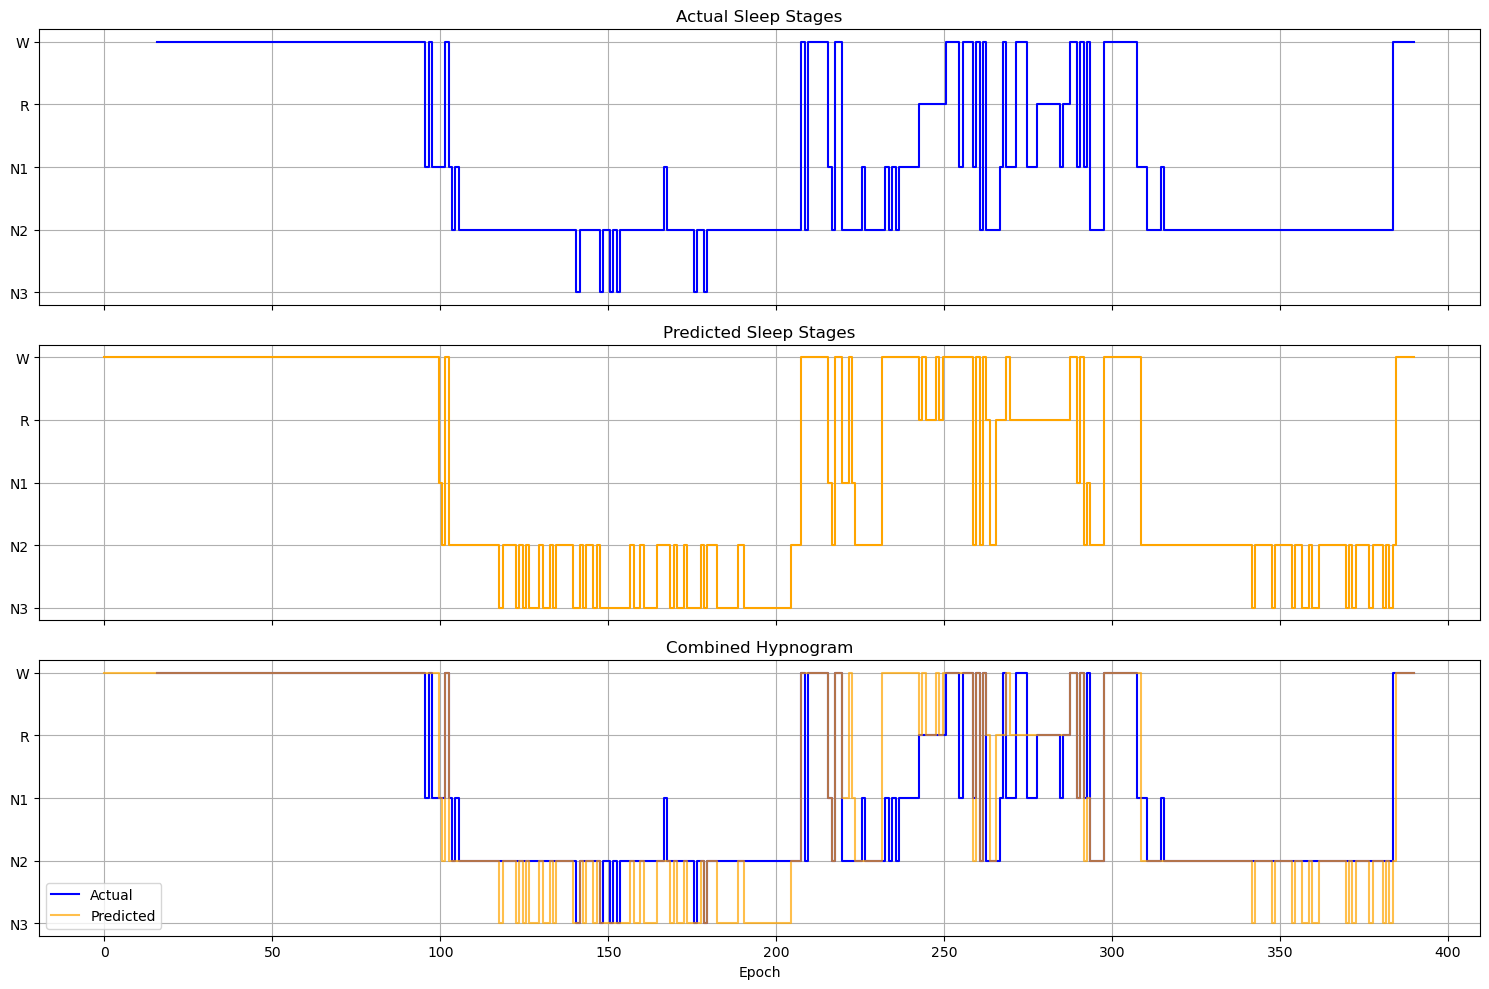

REVIEW [I0002150029143-1] Acc=0.83 F1=0.84 Kappa=0.74 Precision=0.63 Recall=0.56 Specificity=0.56 Score=0.73 


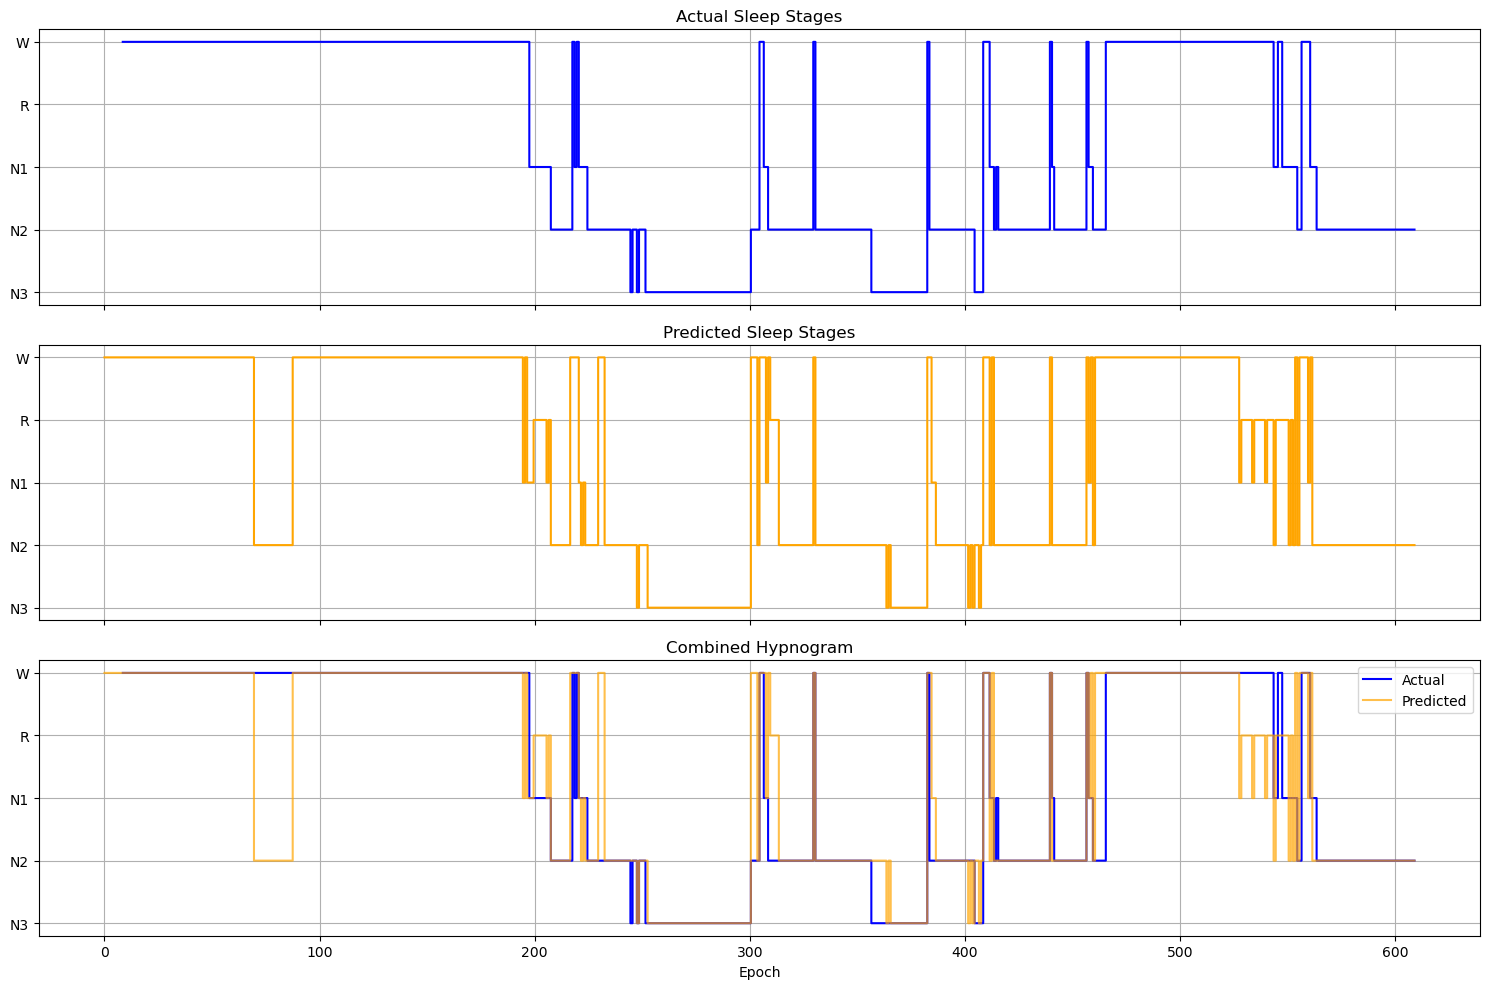

GOOD [I0002150029324-1] Acc=0.85 F1=0.87 Kappa=0.76 Precision=0.59 Recall=0.62 Specificity=0.62 Score=0.75 


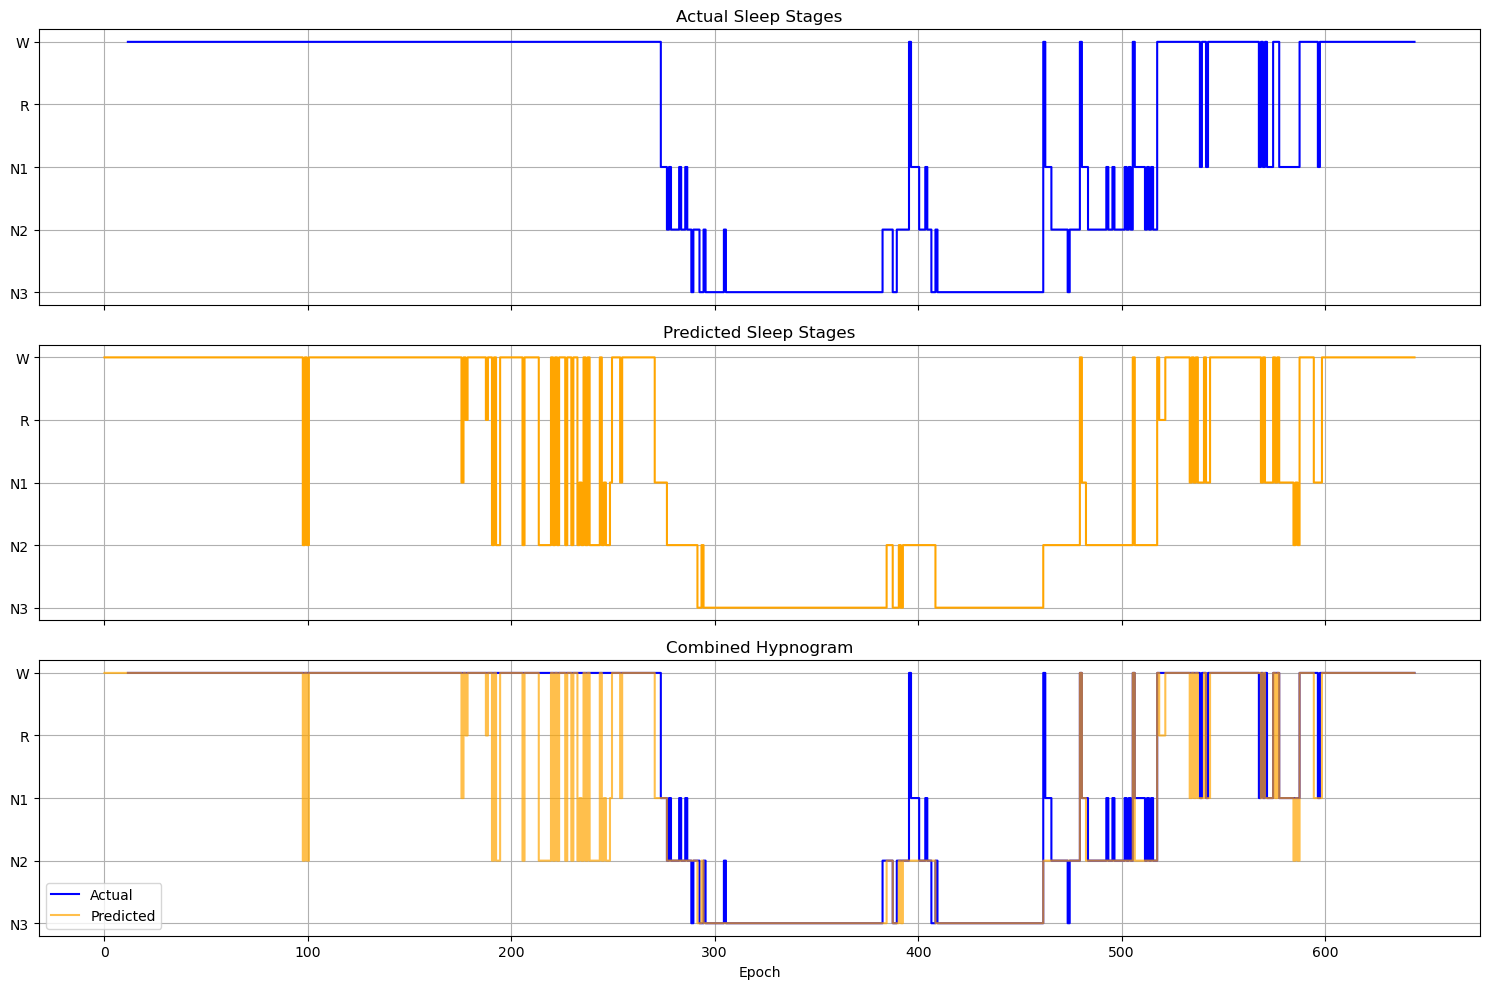

GOOD [I0002150029877-1] Acc=0.92 F1=0.91 Kappa=0.87 Precision=0.68 Recall=0.62 Specificity=0.62 Score=0.81 


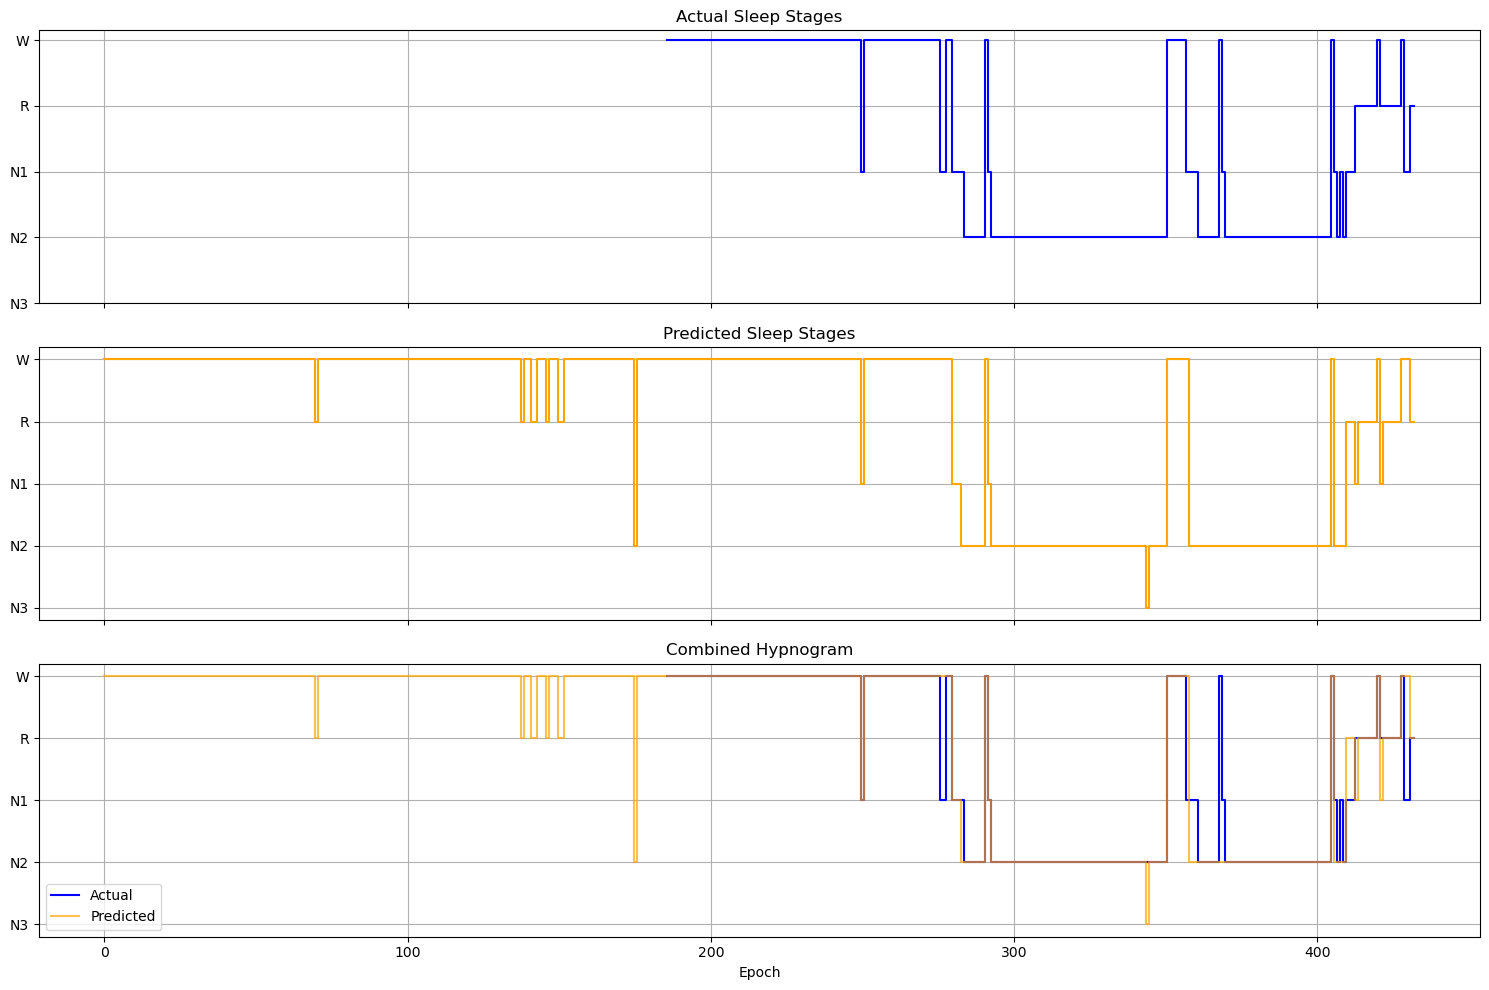

GOOD [I0002150030309-1] Acc=0.86 F1=0.87 Kappa=0.77 Precision=0.75 Recall=0.79 Specificity=0.79 Score=0.81 


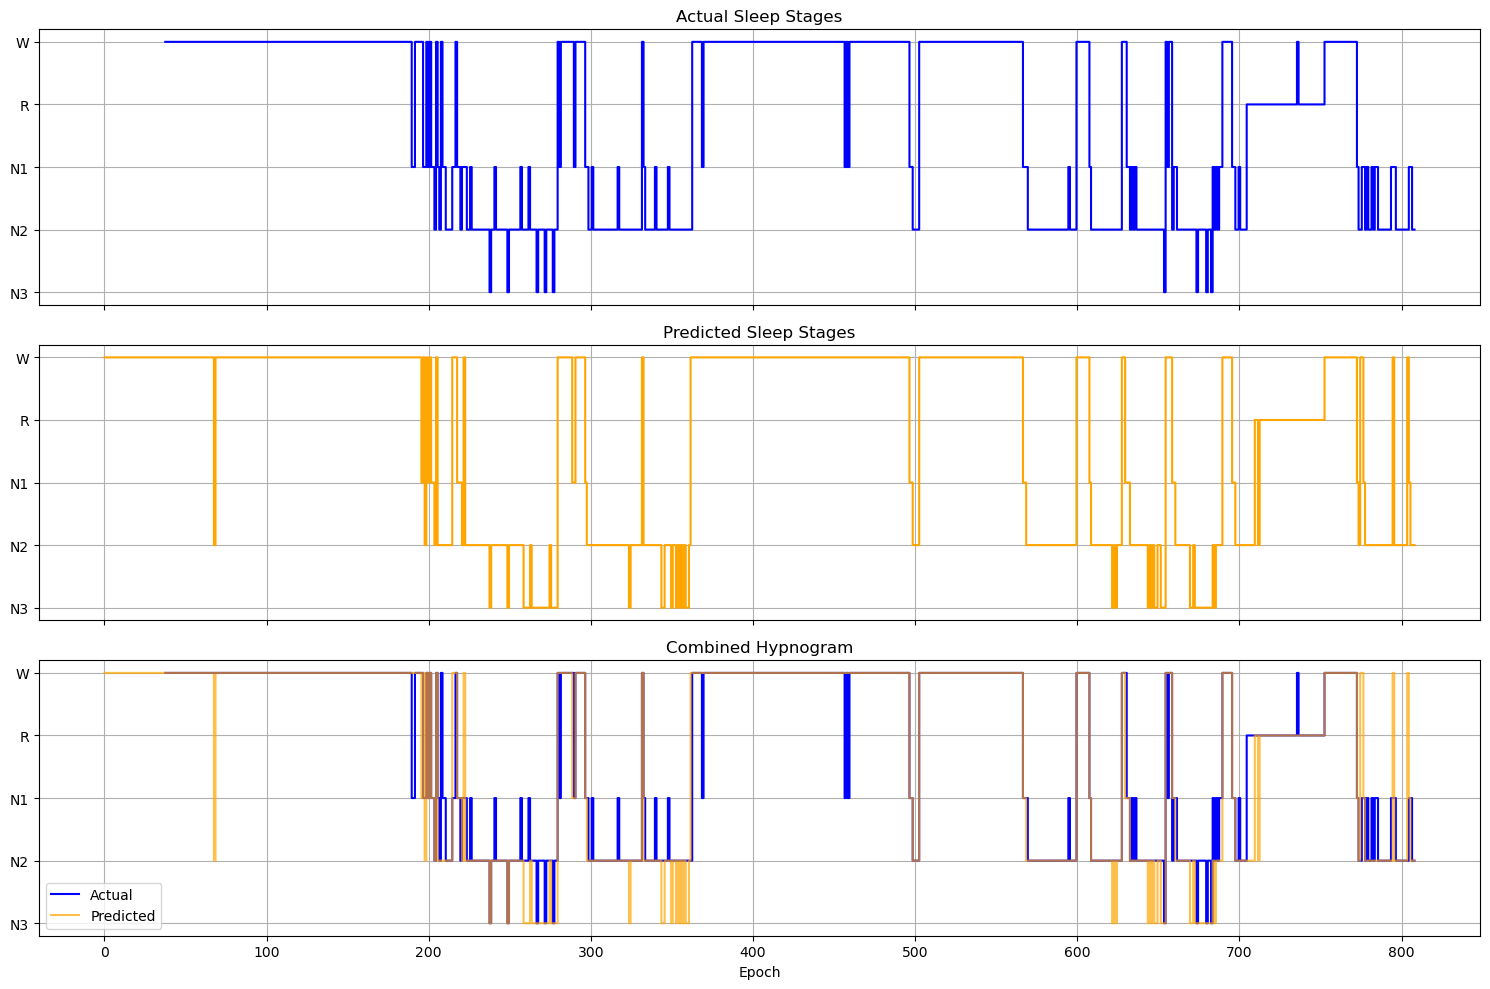

GOOD [I0002150030372-1] Acc=0.87 F1=0.87 Kappa=0.81 Precision=0.69 Recall=0.73 Specificity=0.73 Score=0.80 


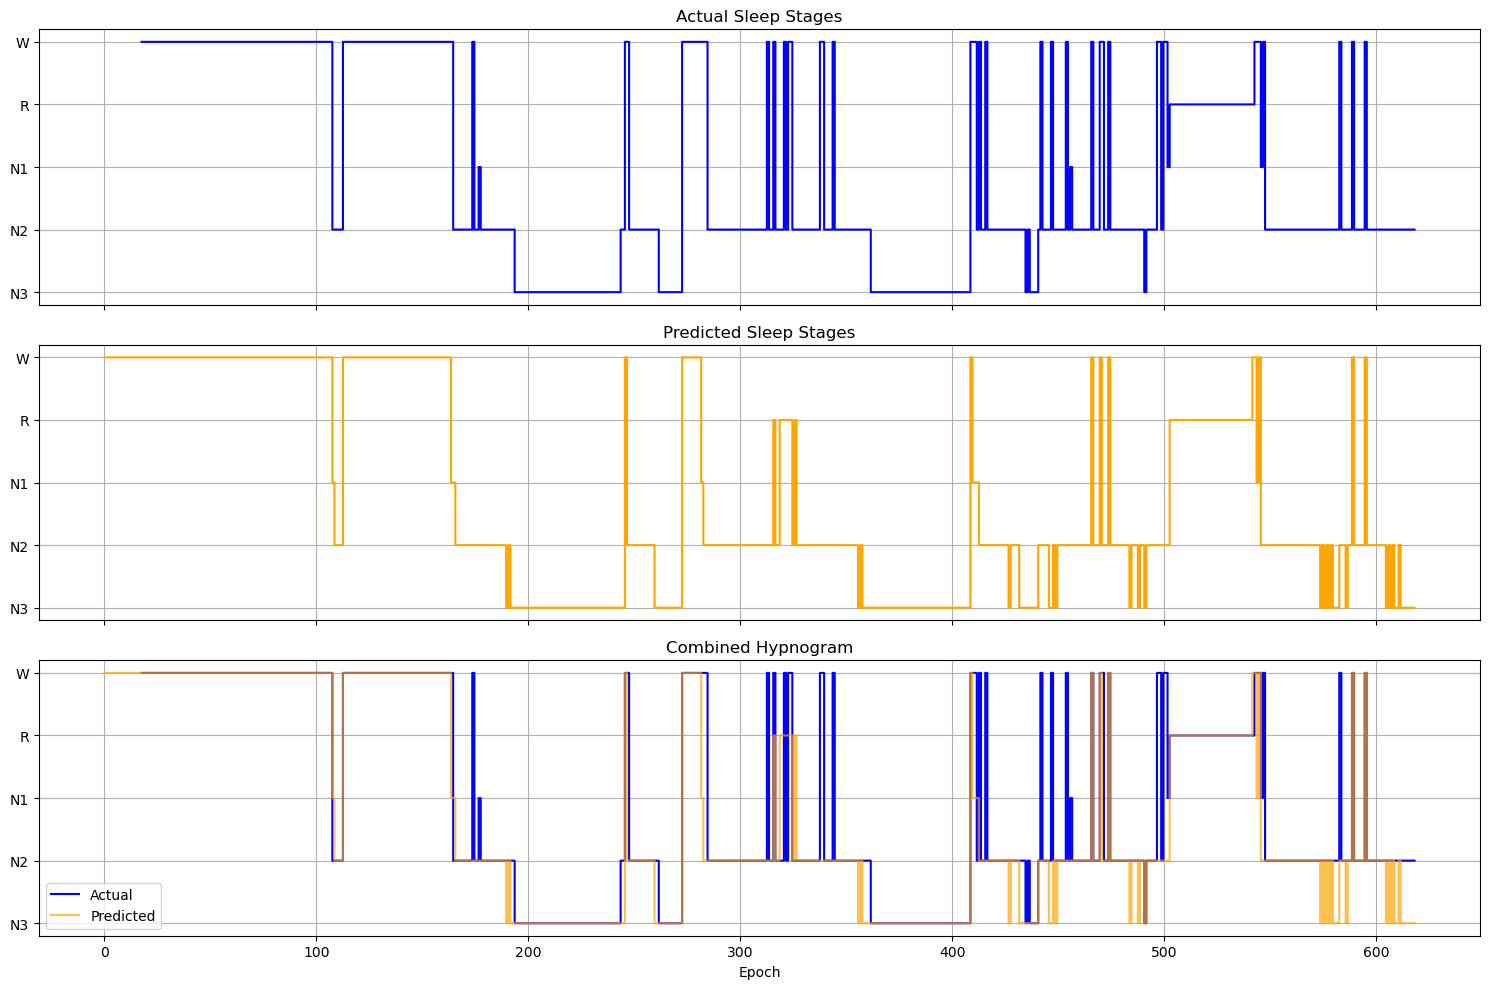

REVIEW [I0002150030460-1] Acc=0.75 F1=0.77 Kappa=0.65 Precision=0.71 Recall=0.80 Specificity=0.80 Score=0.74 


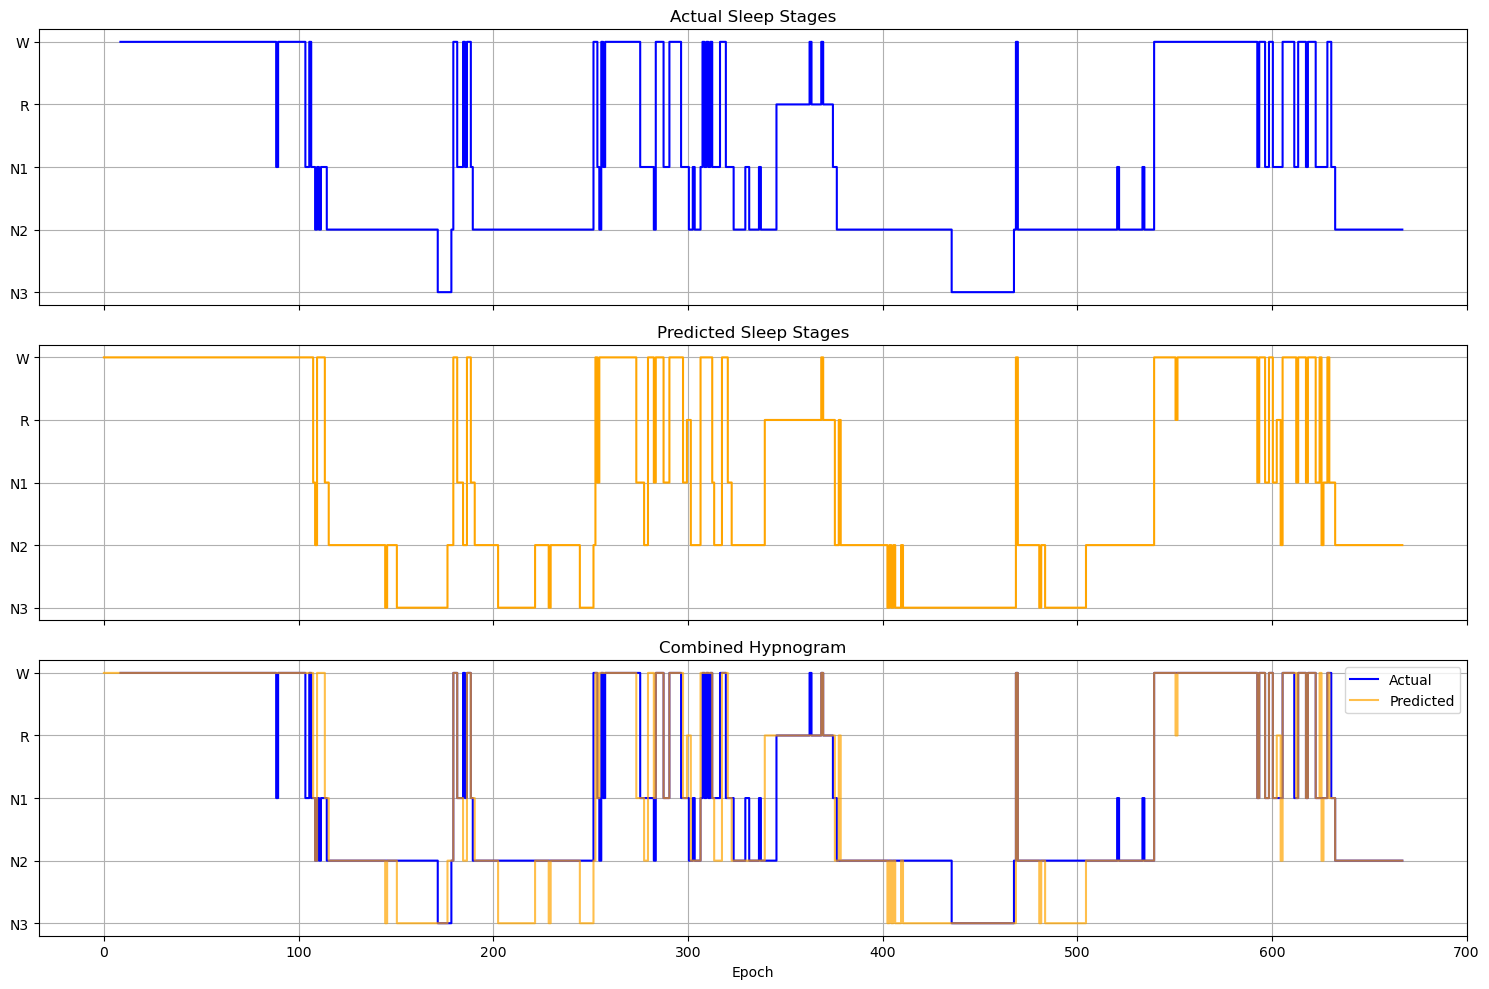

GOOD [I0002150030525-1] Acc=0.87 F1=0.87 Kappa=0.77 Precision=0.74 Recall=0.76 Specificity=0.76 Score=0.81 


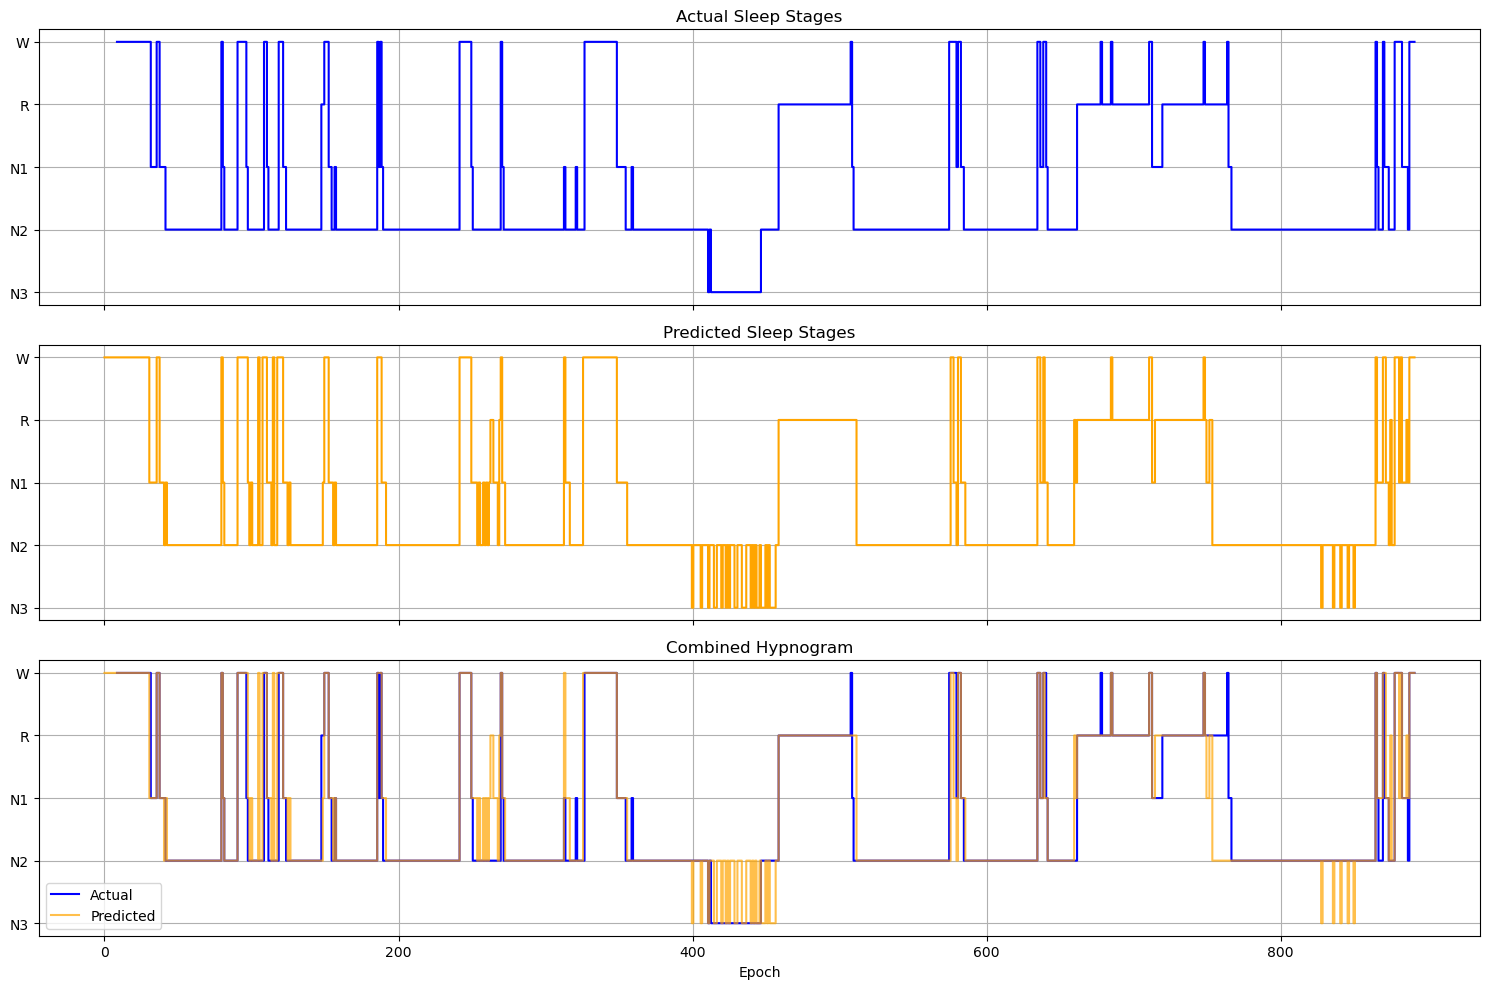

GOOD [I0002150030699-1] Acc=0.87 F1=0.87 Kappa=0.81 Precision=0.68 Recall=0.62 Specificity=0.62 Score=0.78 


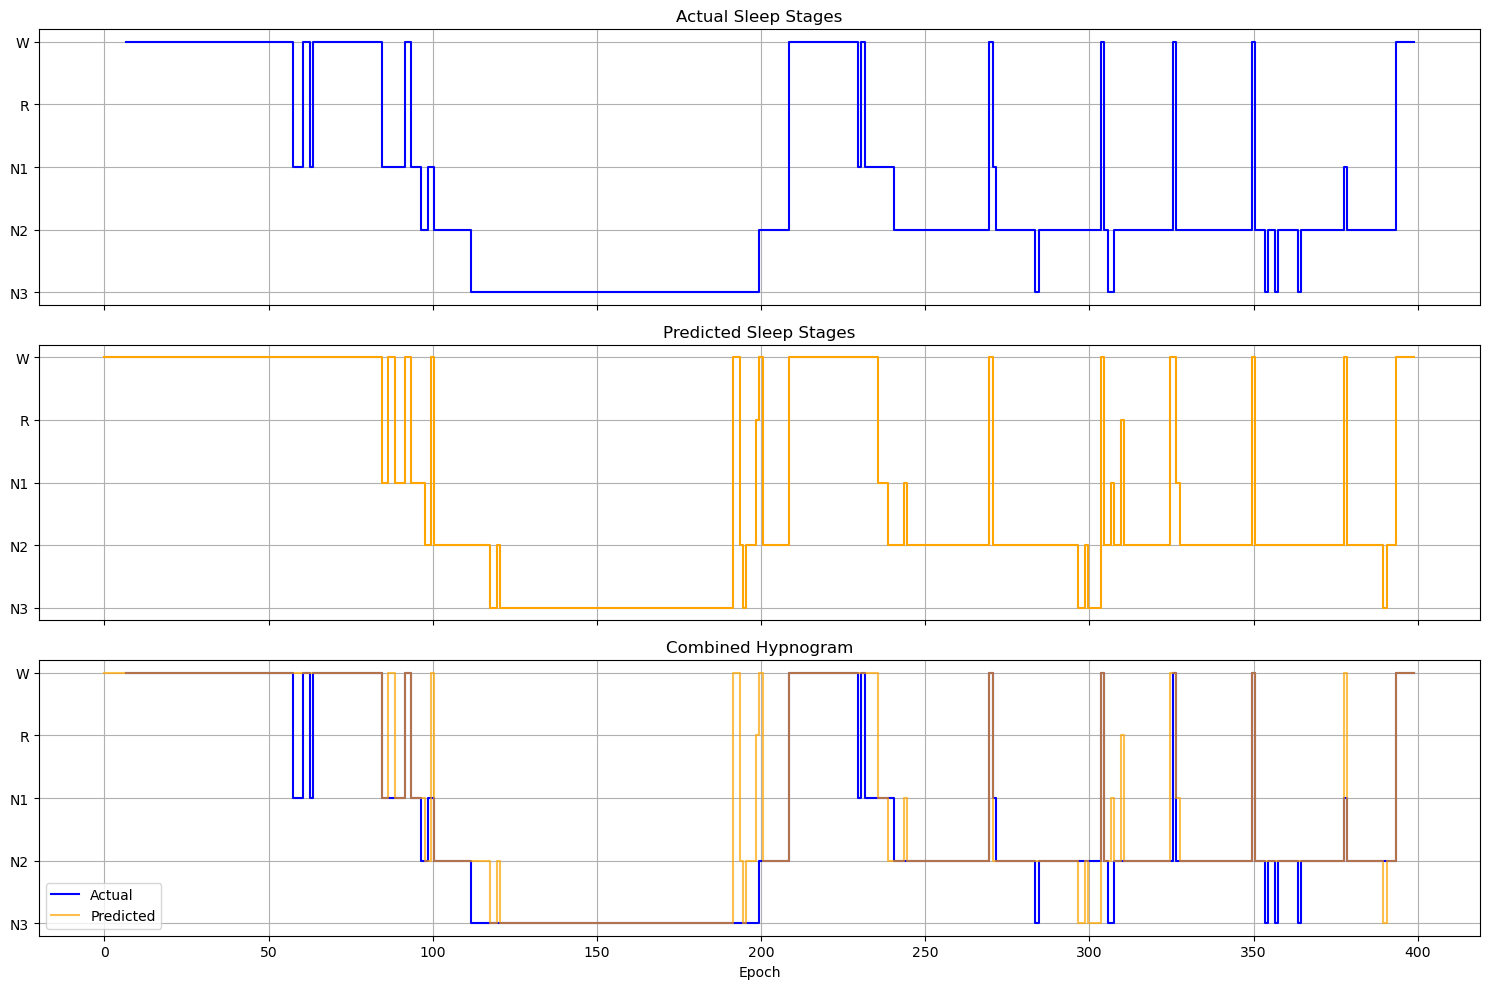

GOOD [I0002150030812-1] Acc=0.81 F1=0.79 Kappa=0.71 Precision=0.71 Recall=0.72 Specificity=0.72 Score=0.76 


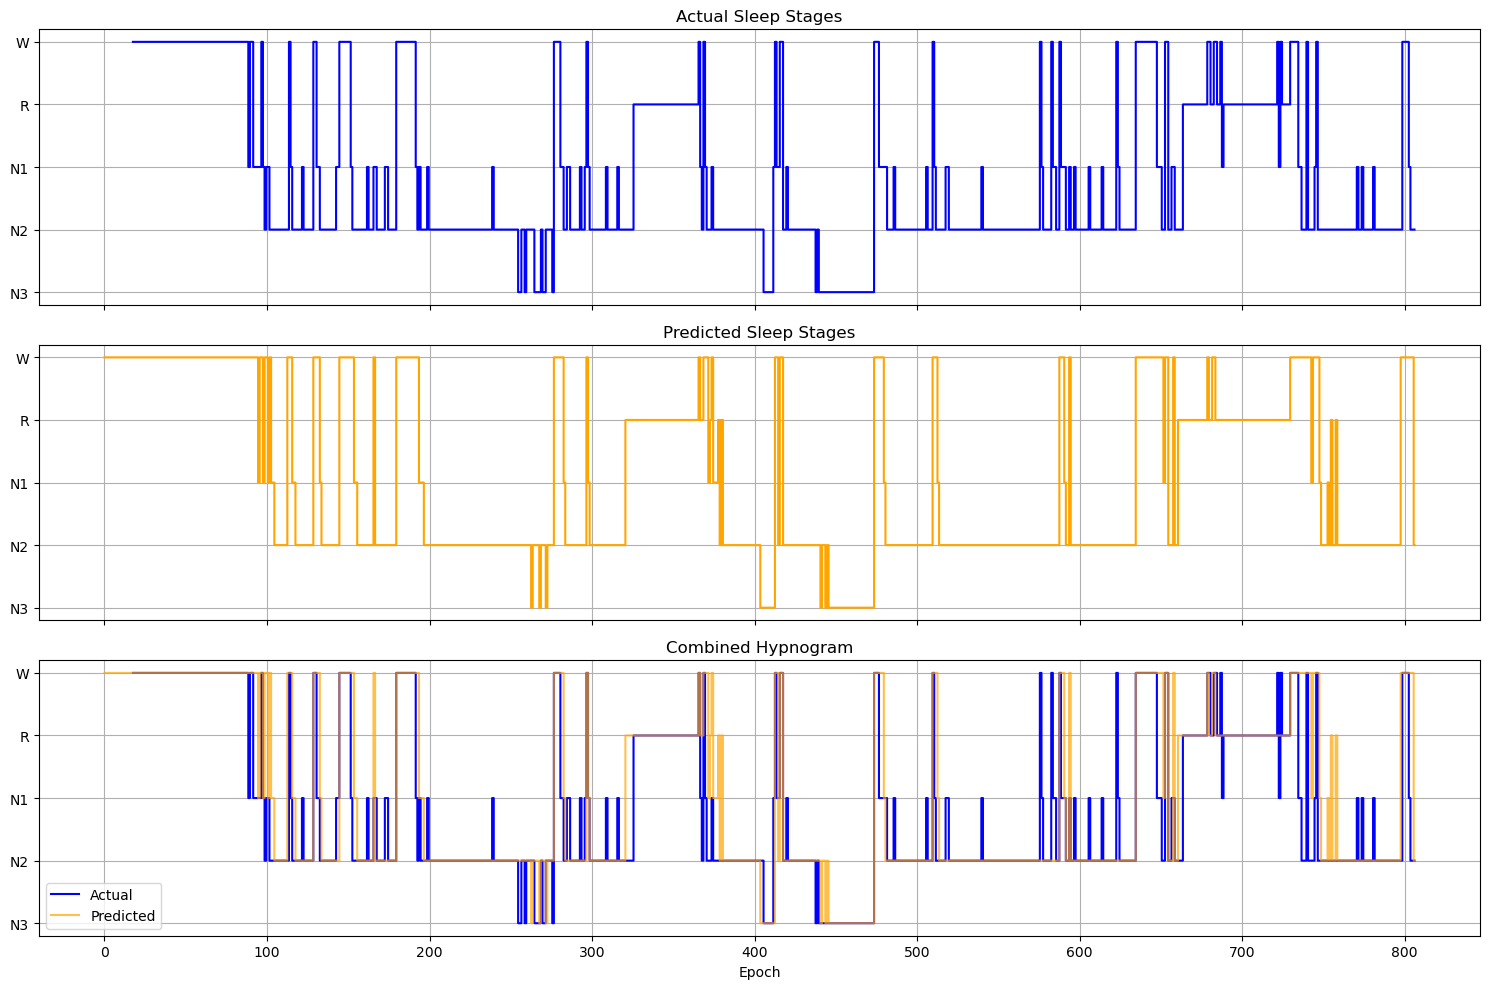

REVIEW [I0002150030846-1] Acc=0.75 F1=0.80 Kappa=0.65 Precision=0.63 Recall=0.78 Specificity=0.78 Score=0.73 


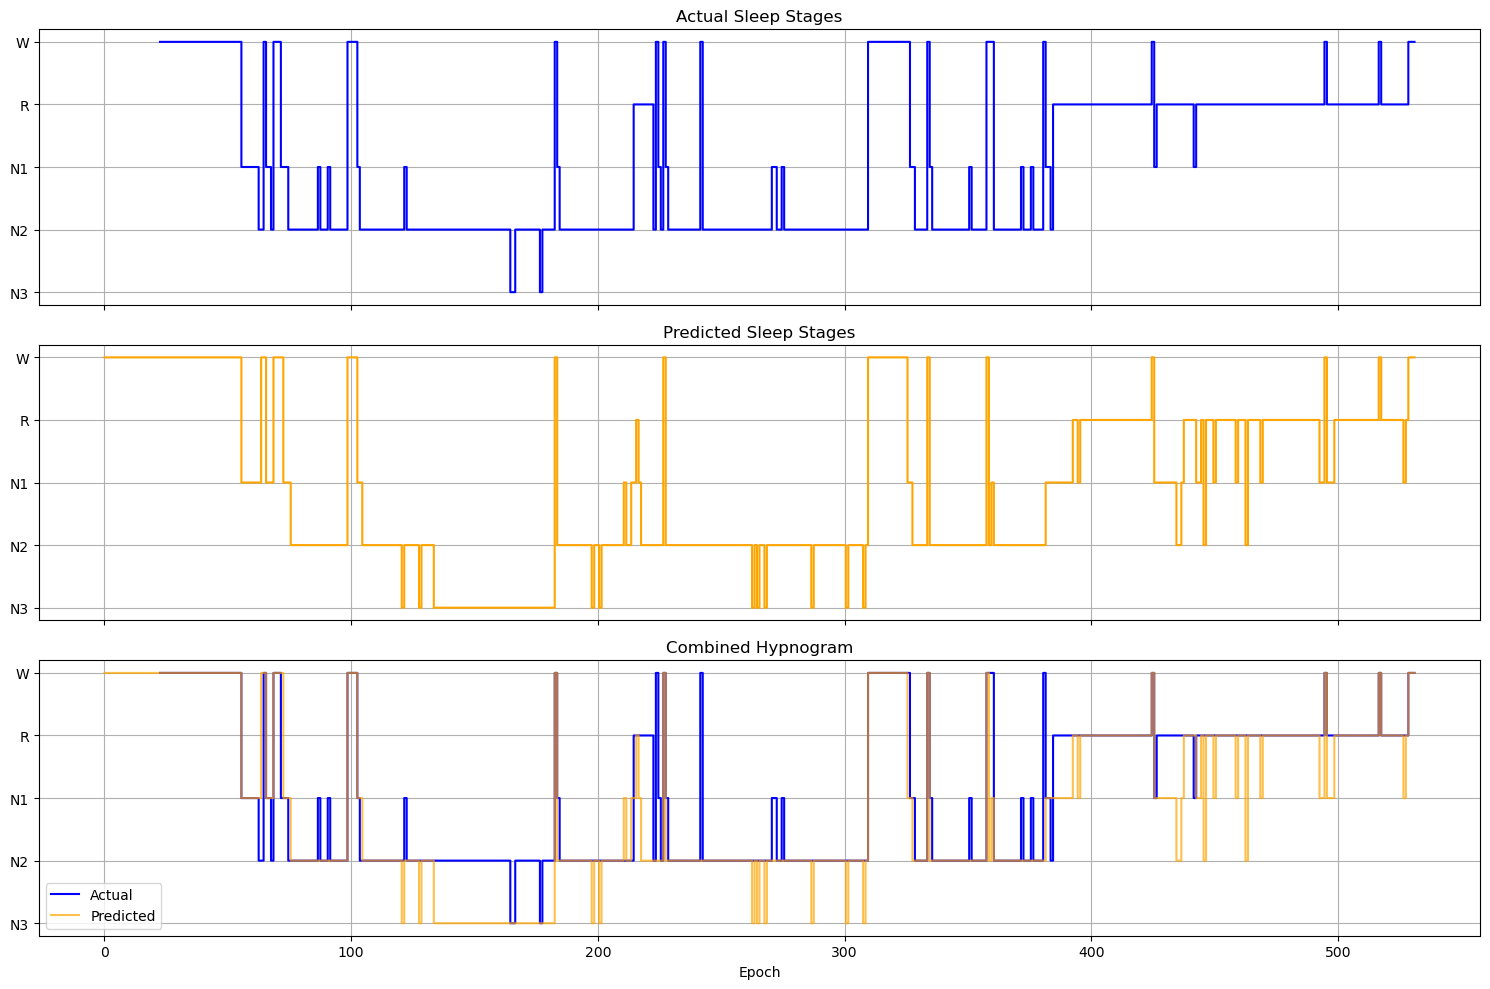

BAD [I0002150030931-1] Acc=0.62 F1=0.55 Kappa=0.43 Precision=0.55 Recall=0.58 Specificity=0.58 Score=0.55 


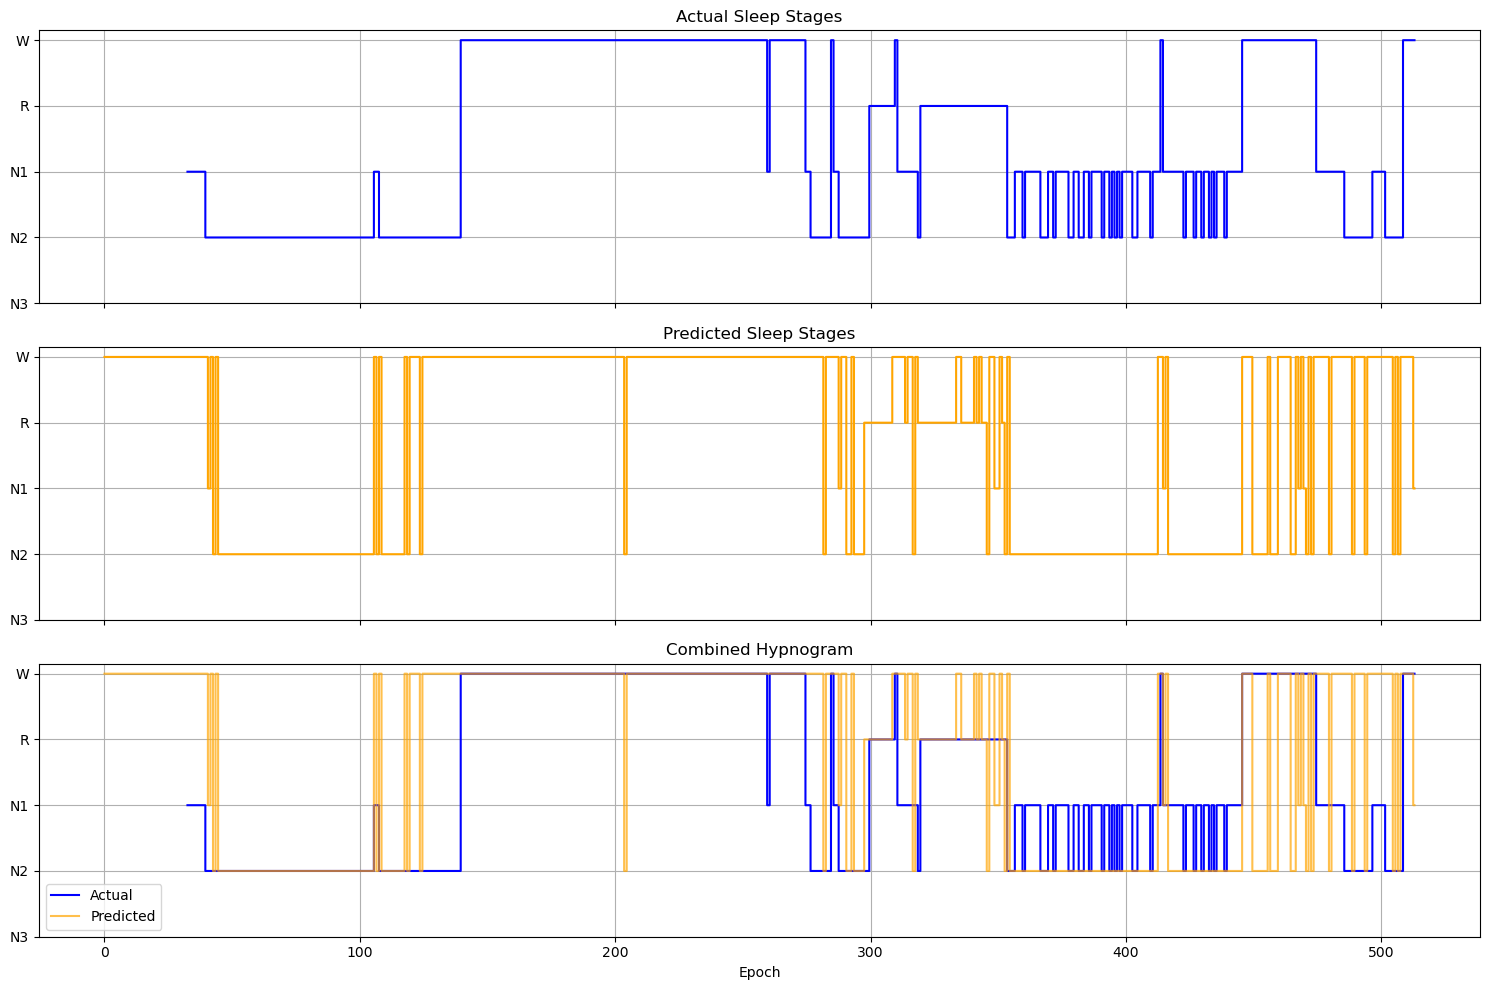

BAD [I0002150030940-1] Acc=0.73 F1=0.79 Kappa=0.57 Precision=0.47 Recall=0.48 Specificity=0.48 Score=0.62 


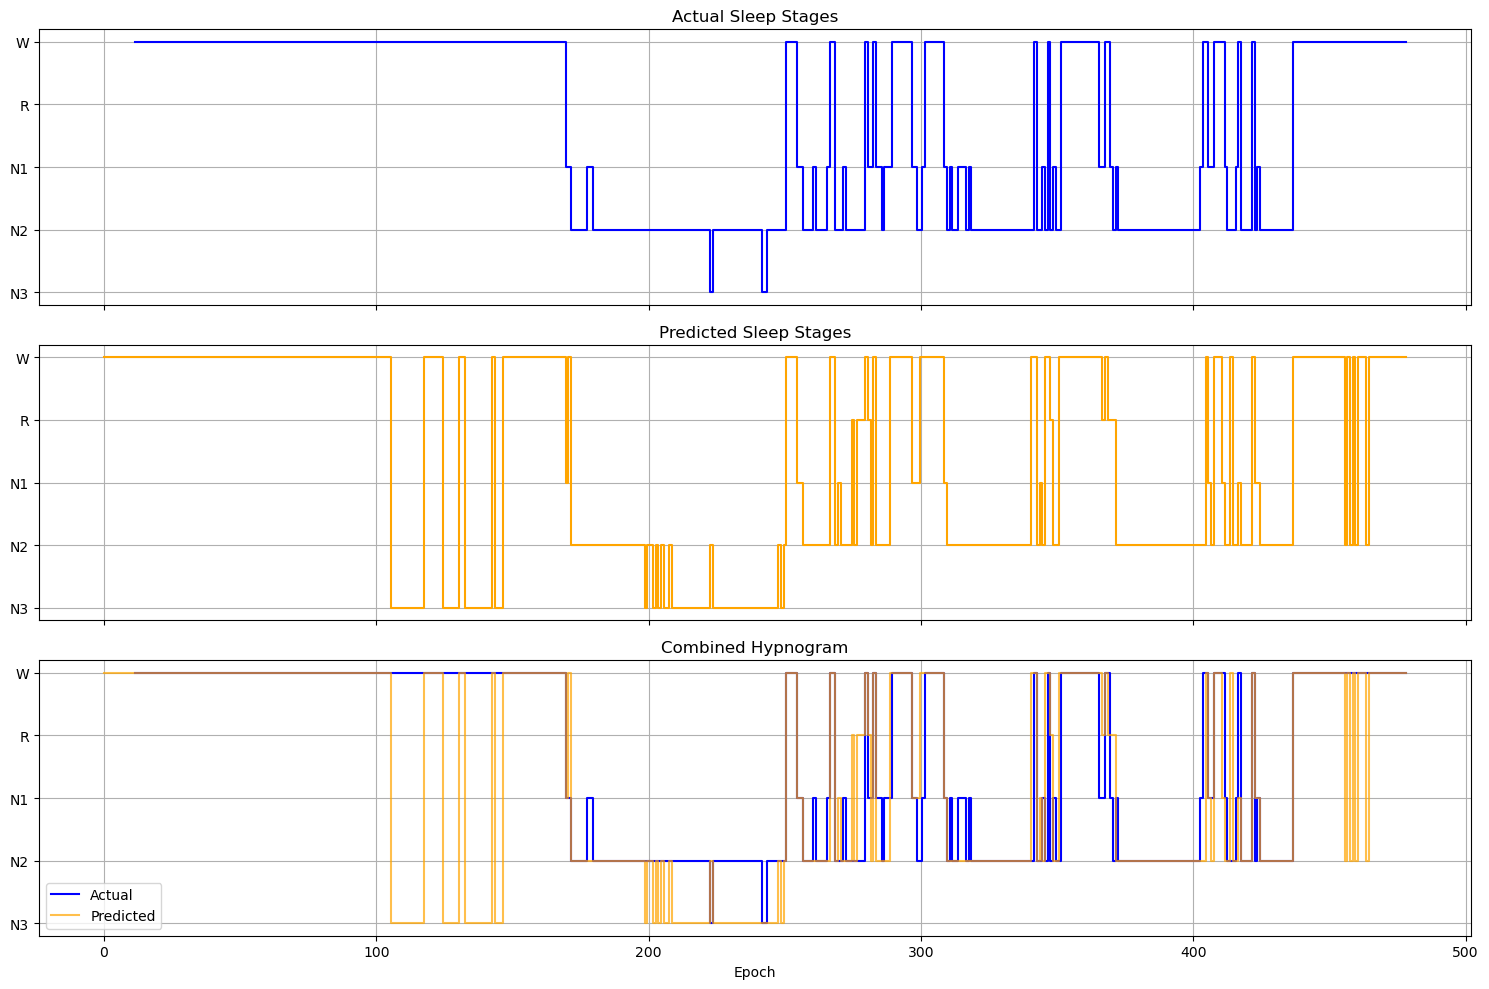

BAD [I0002150031009-1] Acc=0.67 F1=0.68 Kappa=0.49 Precision=0.54 Recall=0.64 Specificity=0.64 Score=0.61 


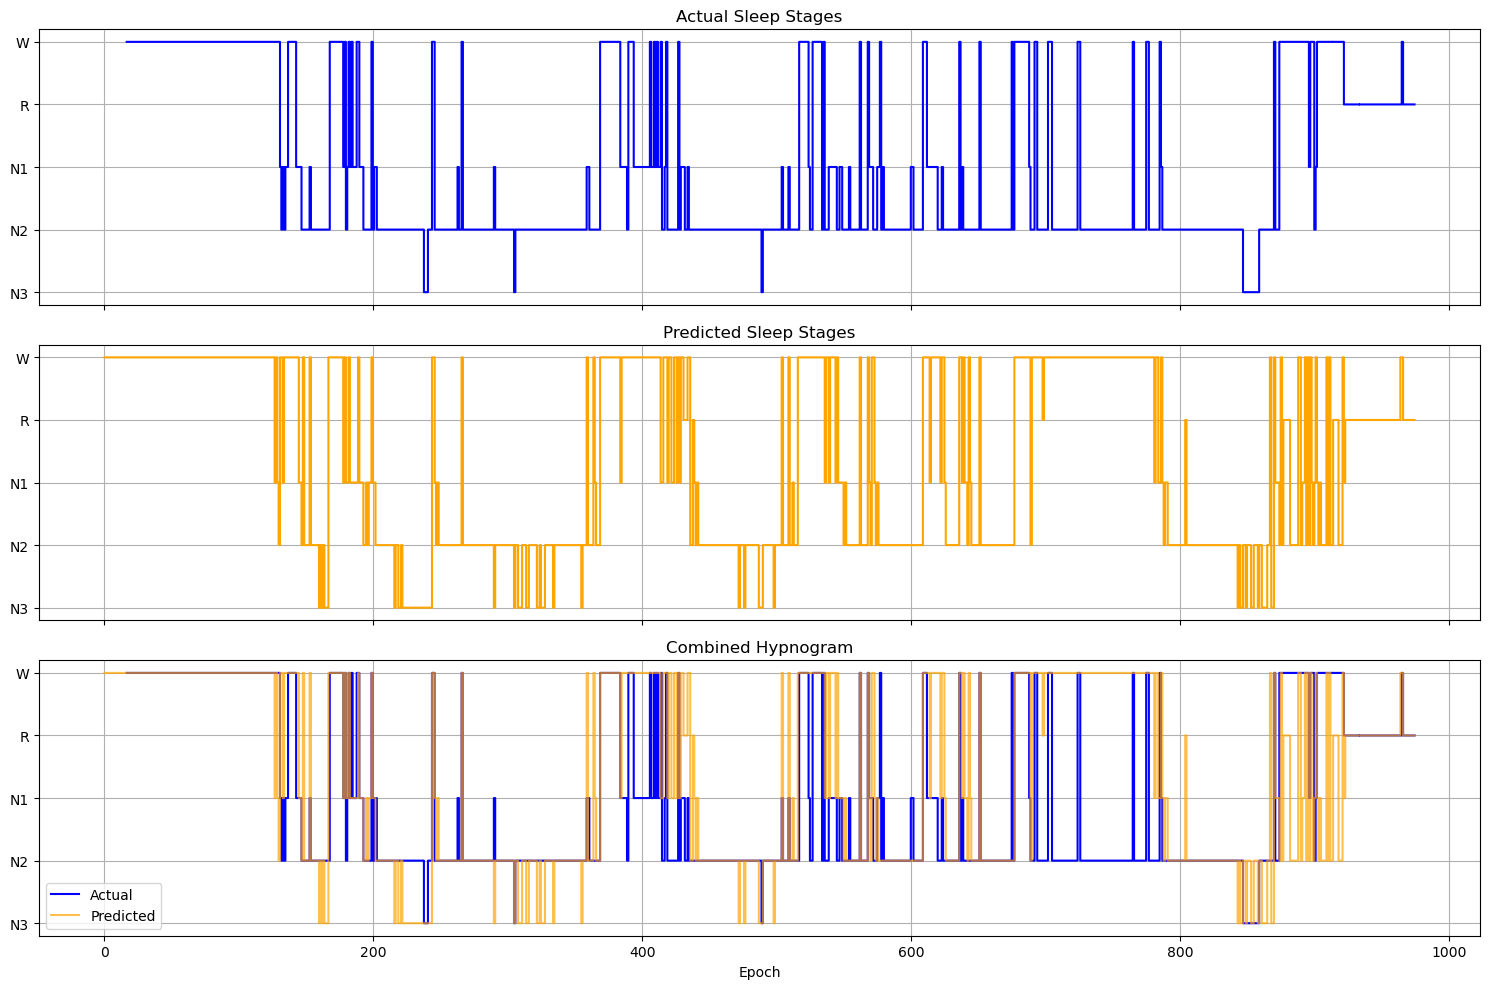

REVIEW [I0002150031027-1] Acc=0.76 F1=0.76 Kappa=0.65 Precision=0.58 Recall=0.62 Specificity=0.62 Score=0.68 


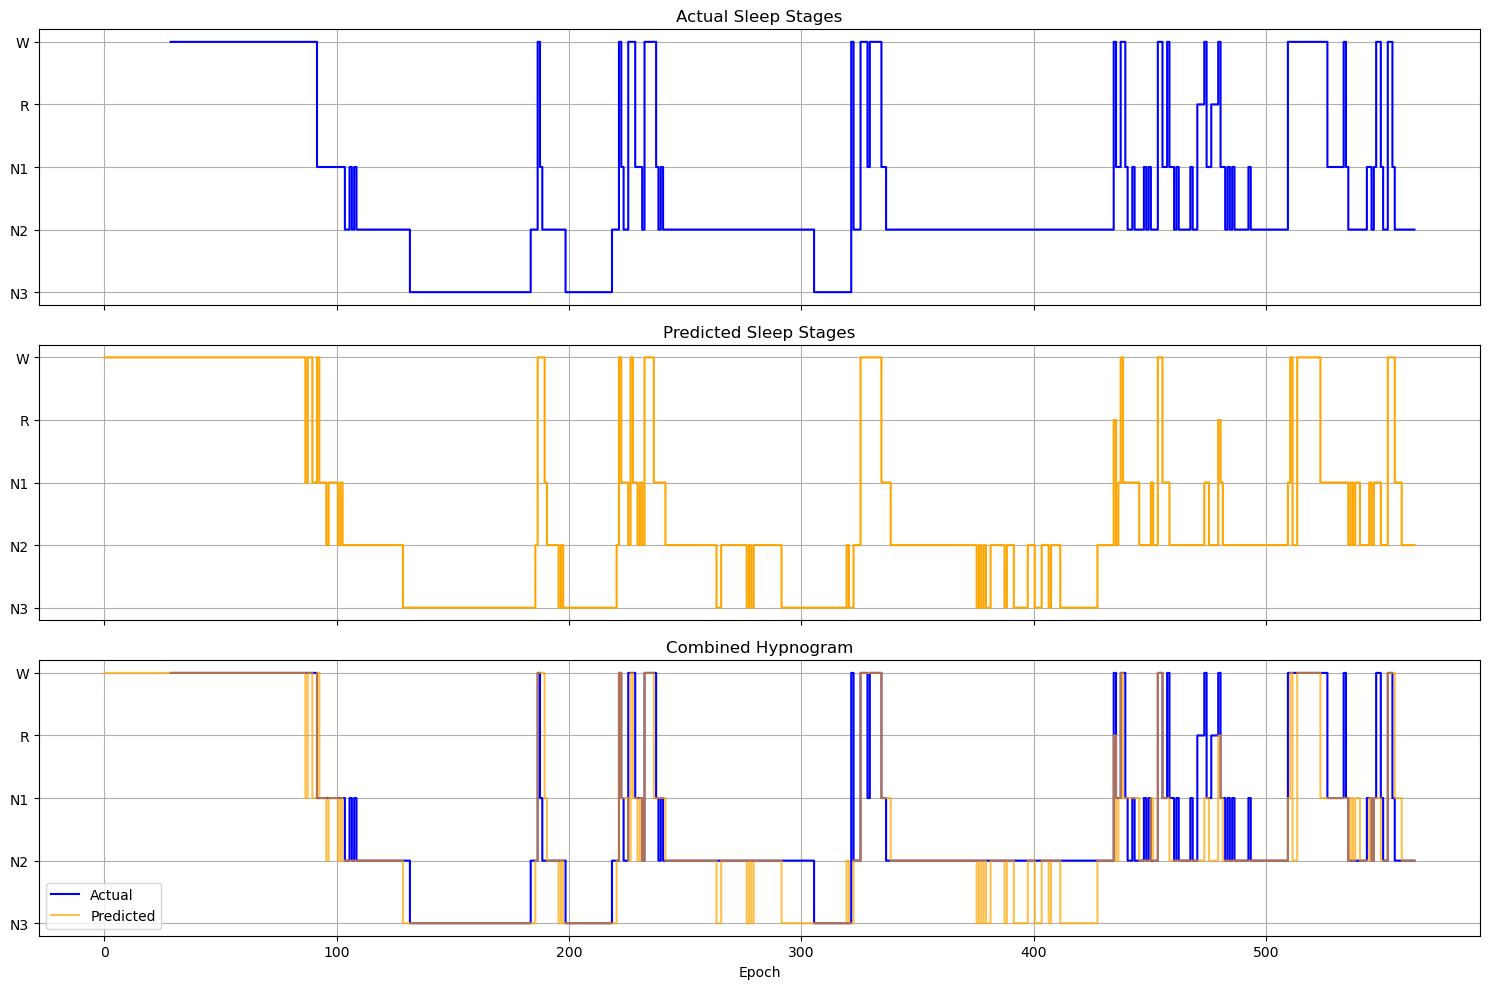

REVIEW [I0002150031028-1] Acc=0.76 F1=0.75 Kappa=0.64 Precision=0.73 Recall=0.63 Specificity=0.63 Score=0.70 


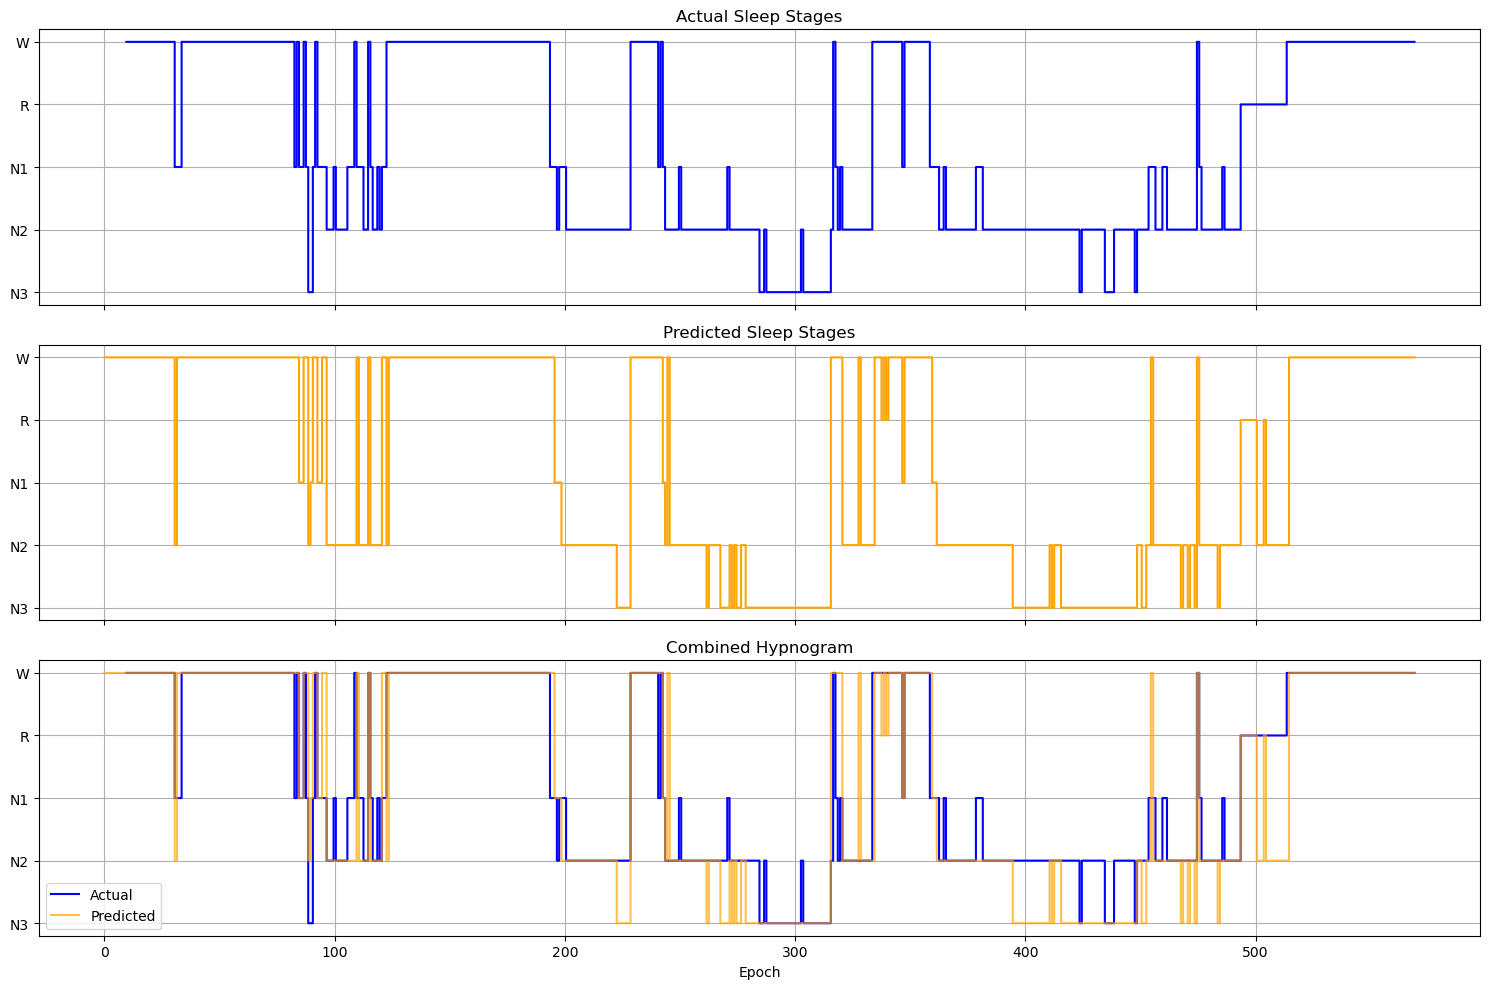

REVIEW [I0002150031064-1] Acc=0.70 F1=0.73 Kappa=0.57 Precision=0.78 Recall=0.72 Specificity=0.72 Score=0.69 


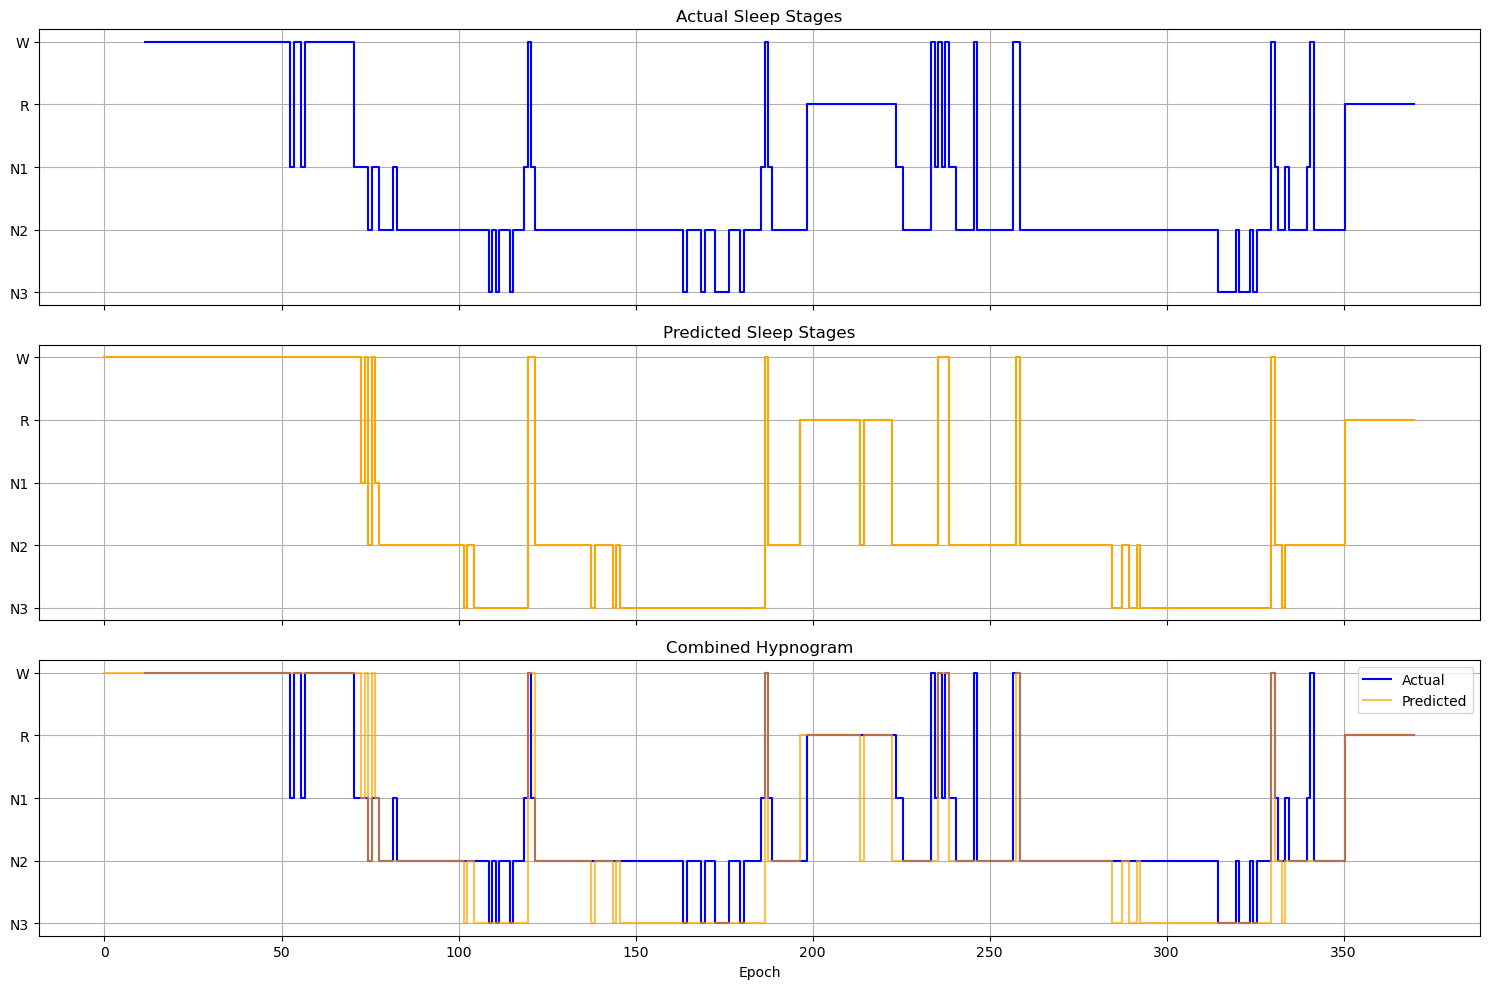

GOOD [I0002150031178-1] Acc=0.83 F1=0.81 Kappa=0.76 Precision=0.75 Recall=0.78 Specificity=0.78 Score=0.79 


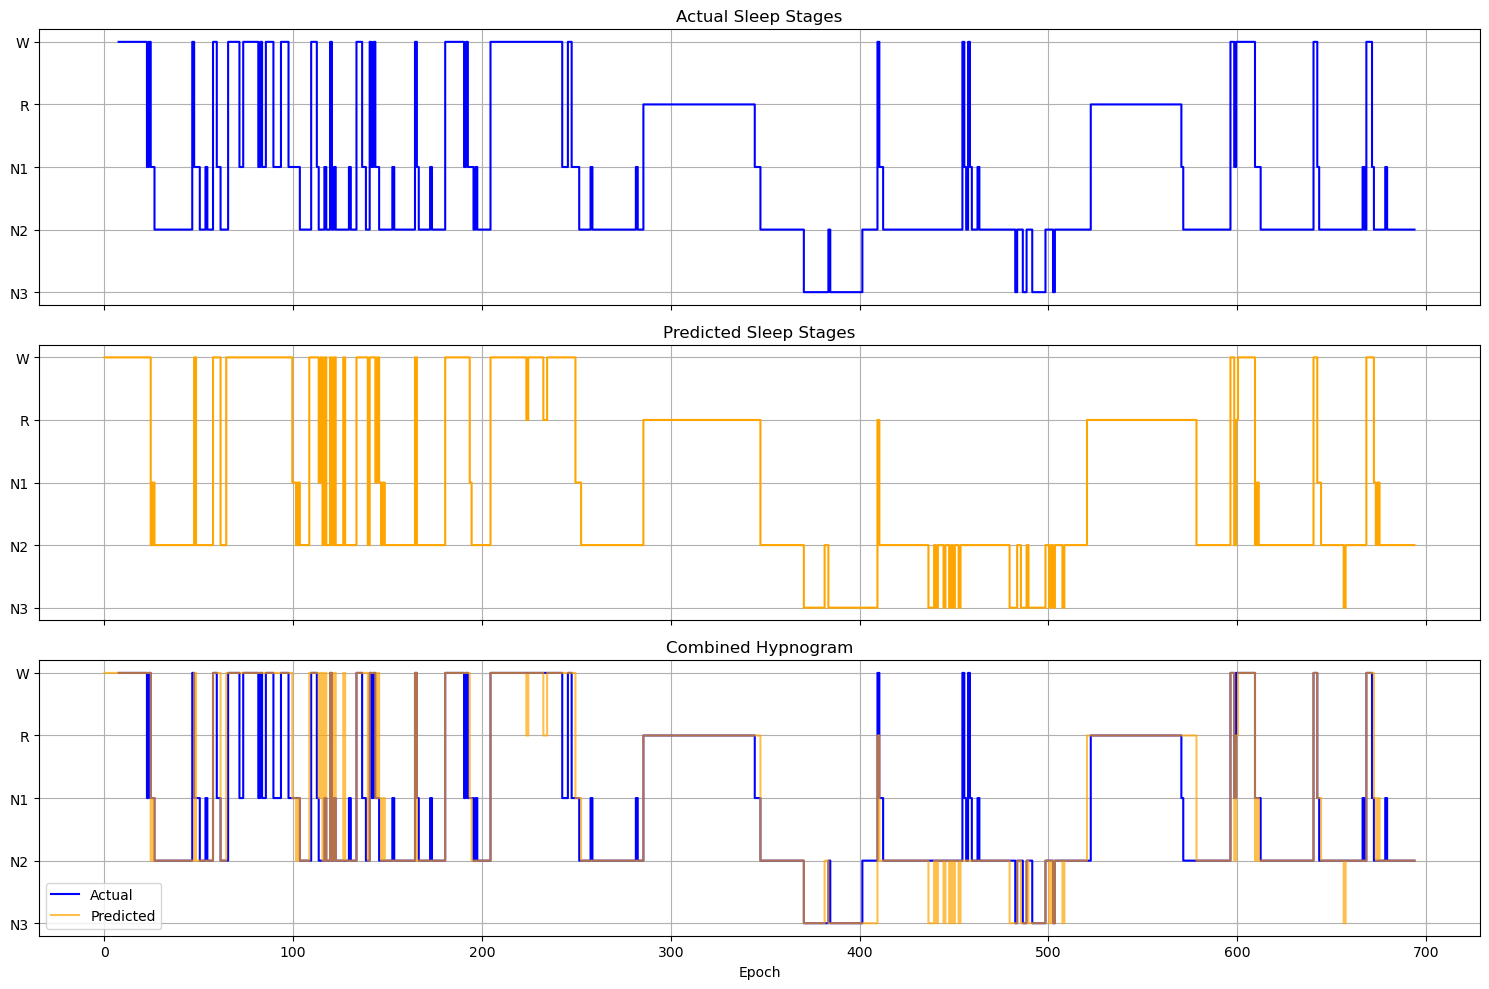

REVIEW [I0002150031270-1] Acc=0.76 F1=0.76 Kappa=0.65 Precision=0.68 Recall=0.77 Specificity=0.77 Score=0.73 


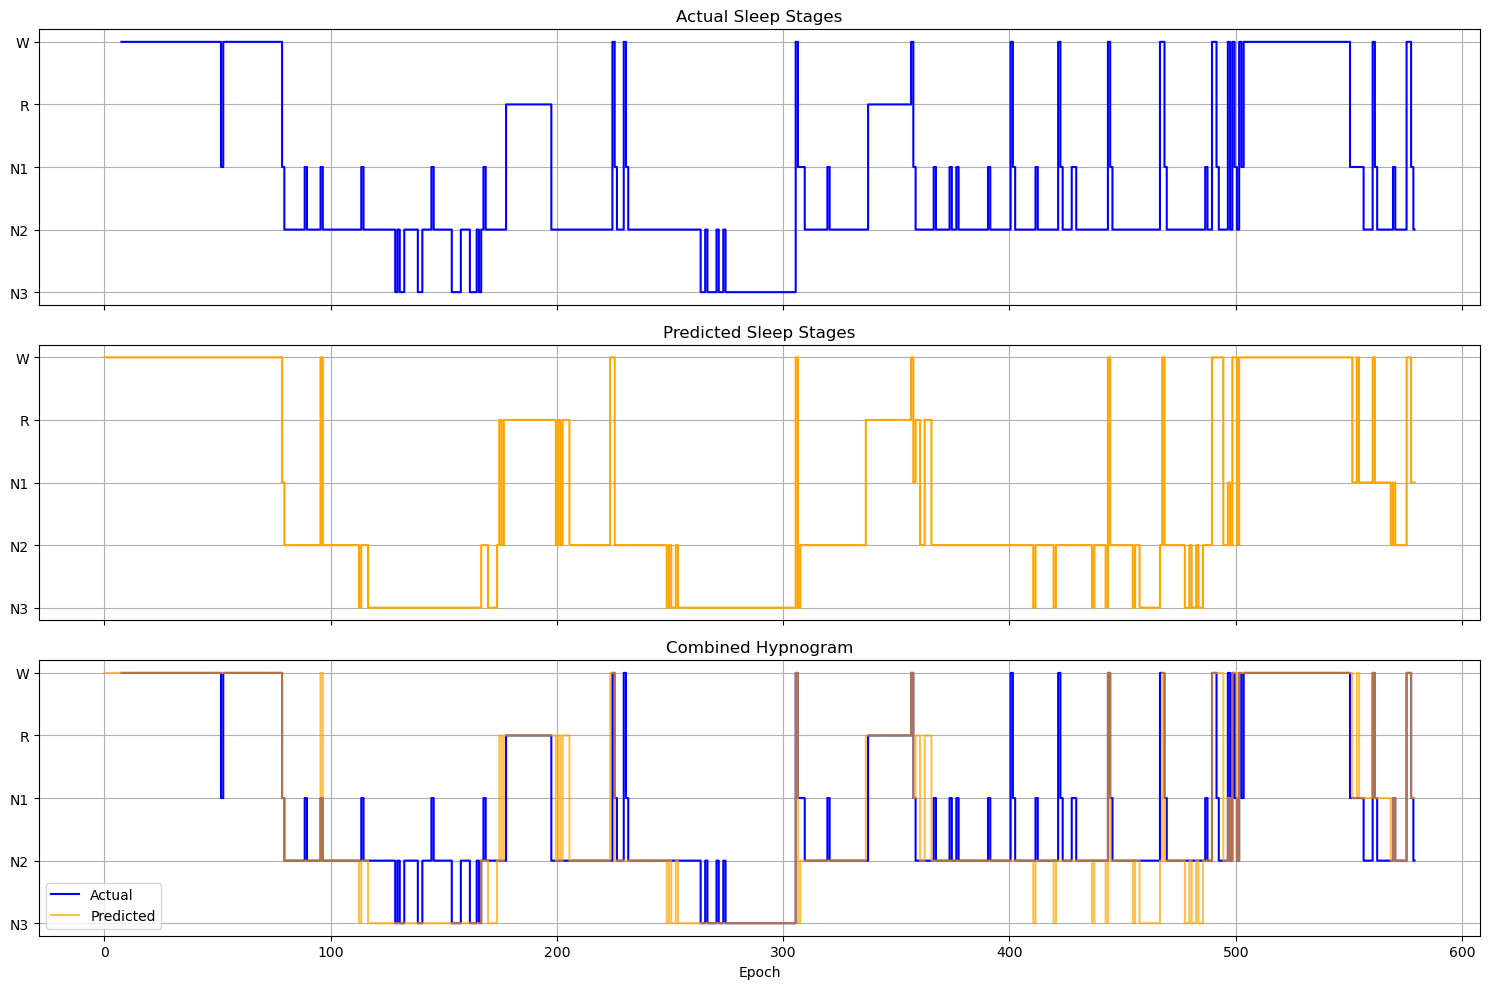

REVIEW [I0002150031291-2] Acc=0.72 F1=0.78 Kappa=0.59 Precision=0.61 Recall=0.55 Specificity=0.55 Score=0.65 


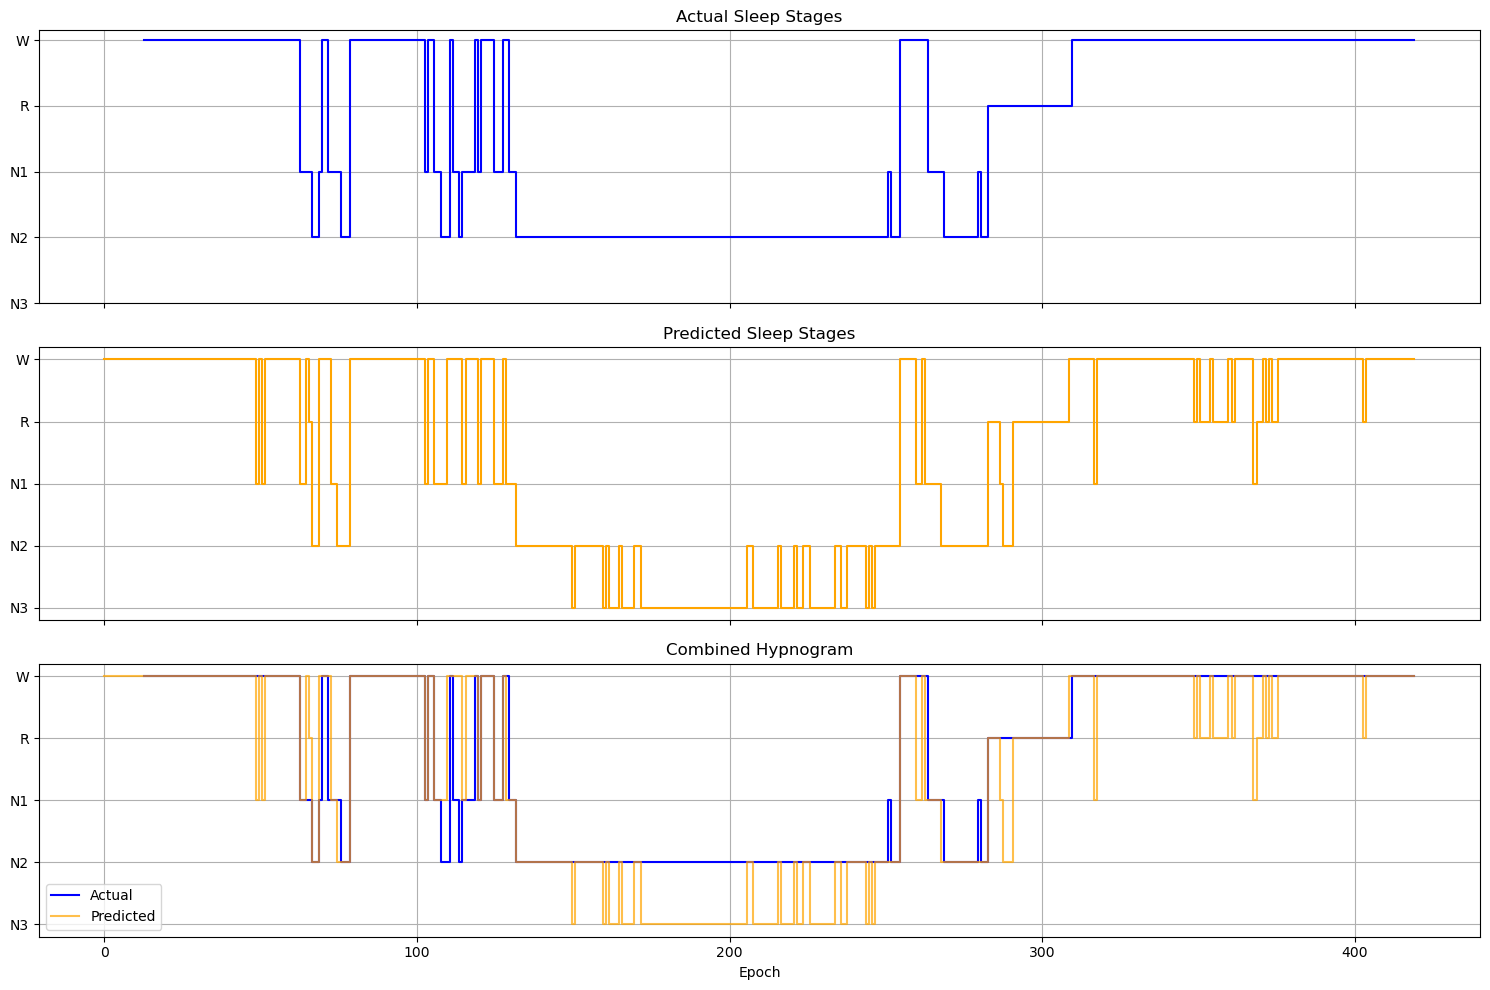

REVIEW [I0002150031604-1] Acc=0.75 F1=0.78 Kappa=0.52 Precision=0.55 Recall=0.79 Specificity=0.79 Score=0.69 


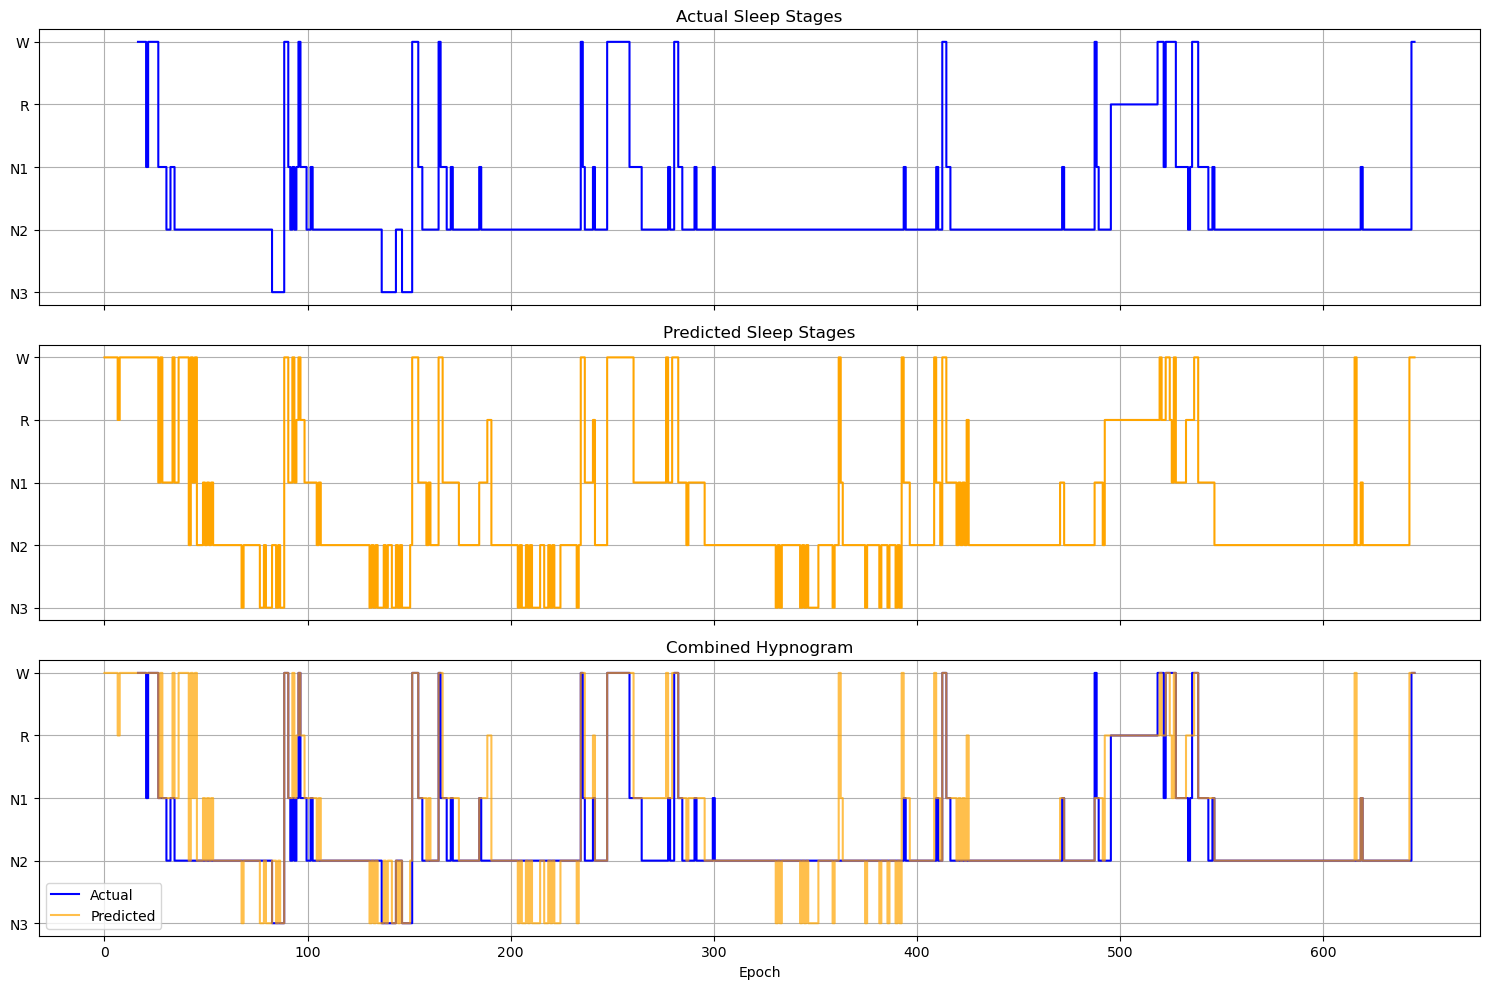

REVIEW [I0002150031637-1] Acc=0.76 F1=0.78 Kappa=0.66 Precision=0.58 Recall=0.64 Specificity=0.64 Score=0.69 


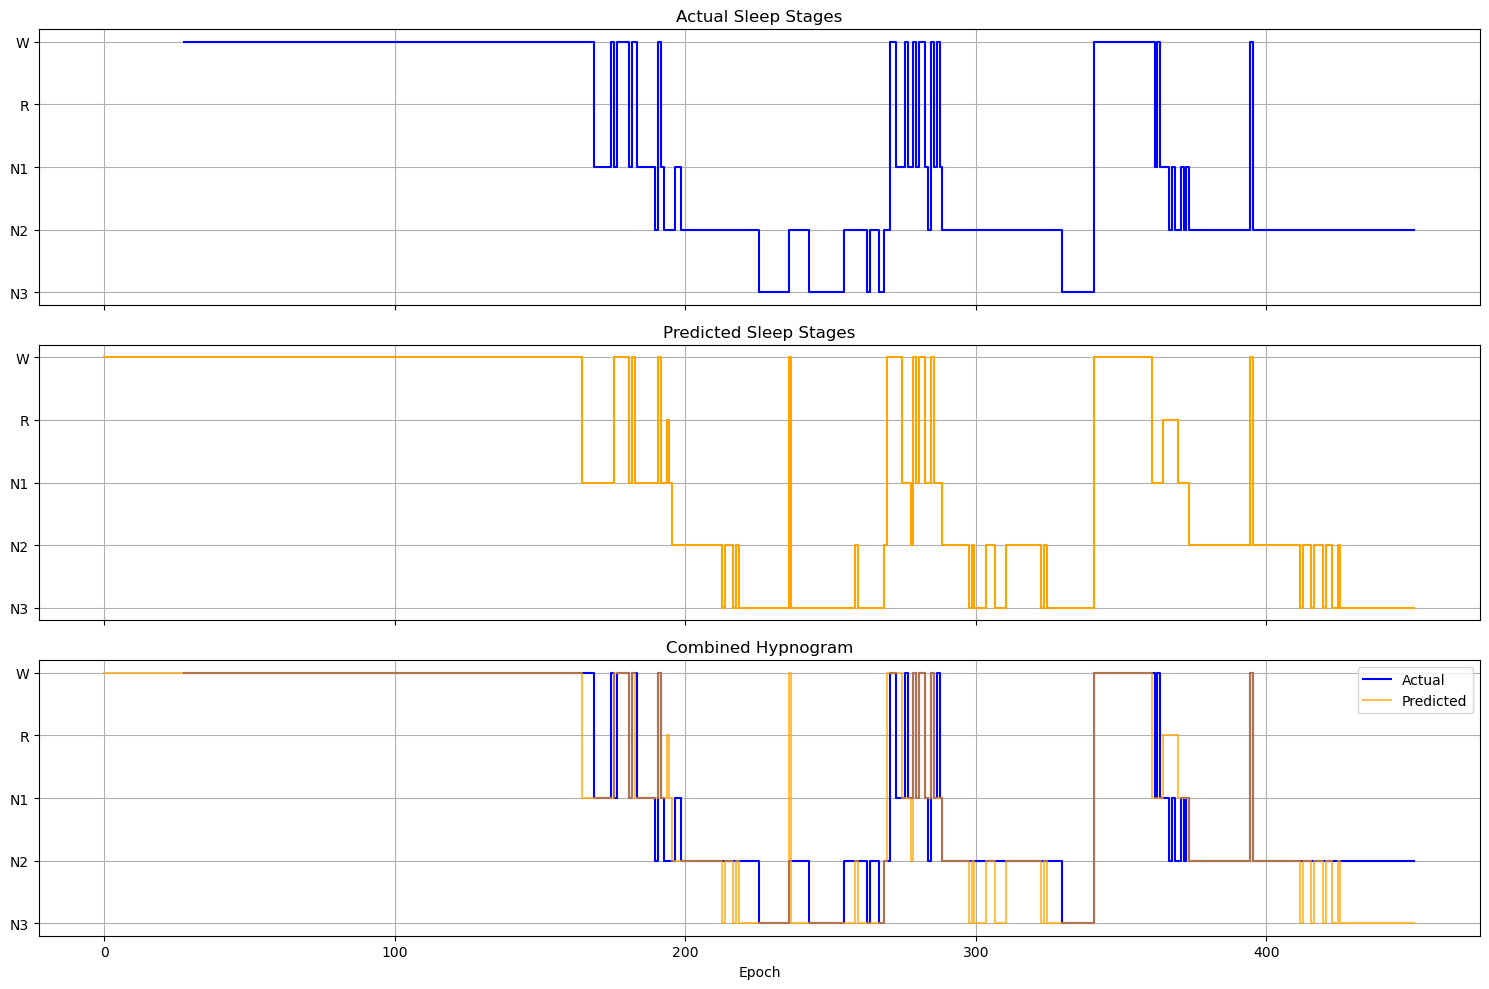

REVIEW [I0002150031869-1] Acc=0.78 F1=0.78 Kappa=0.67 Precision=0.59 Recall=0.60 Specificity=0.60 Score=0.69 


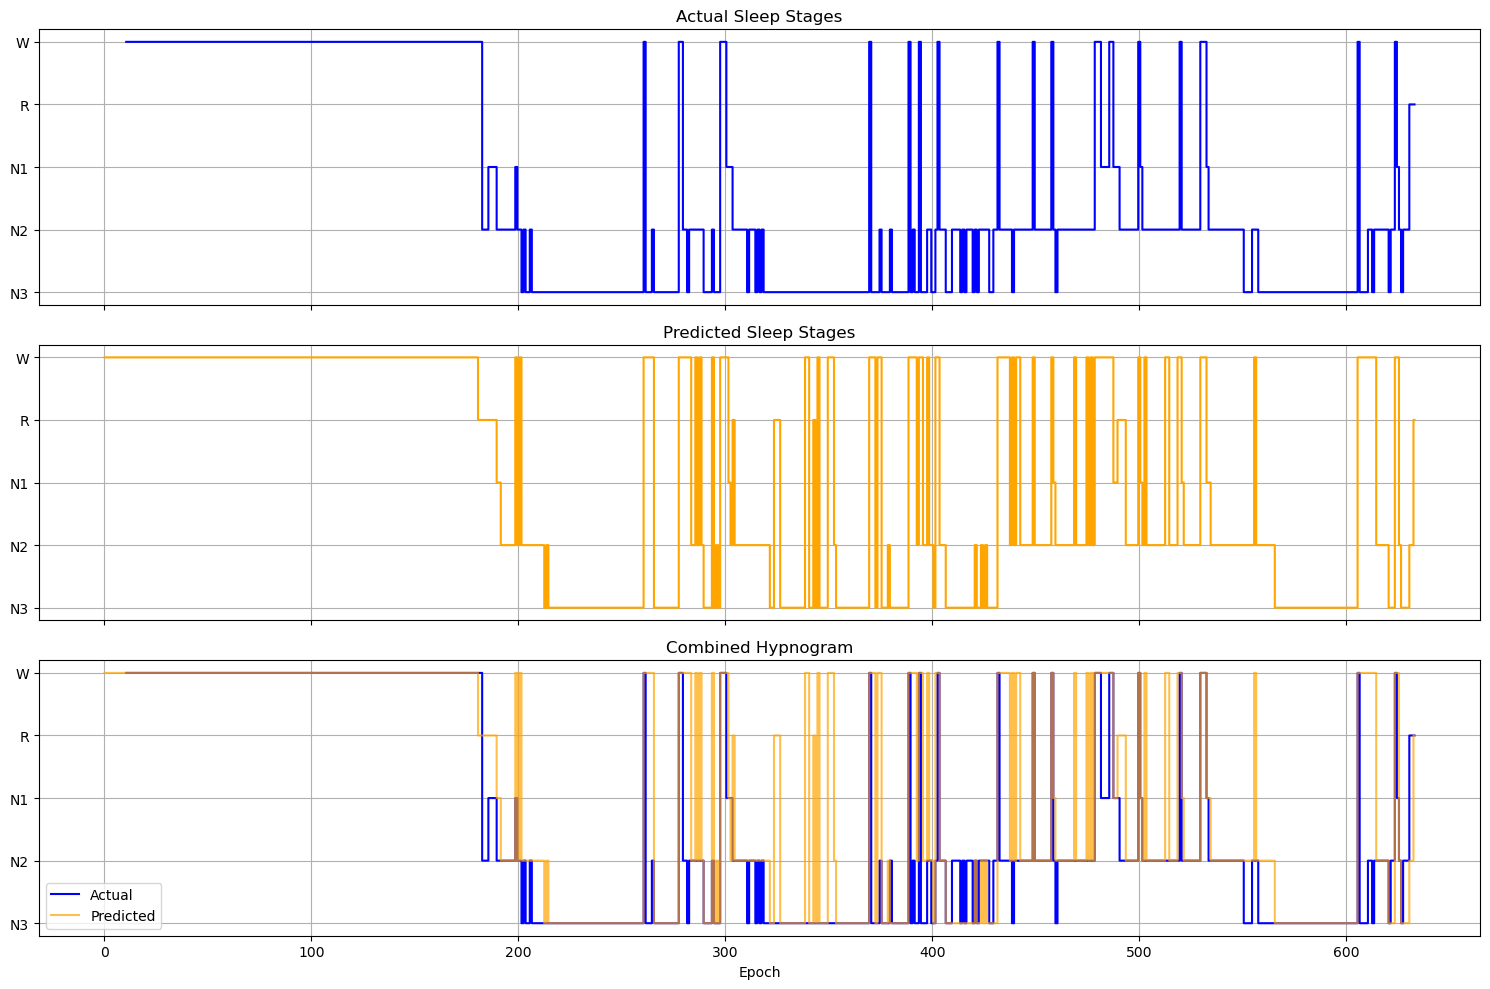

GOOD [I0002150032005-1] Acc=0.79 F1=0.77 Kappa=0.73 Precision=0.78 Recall=0.74 Specificity=0.74 Score=0.76 


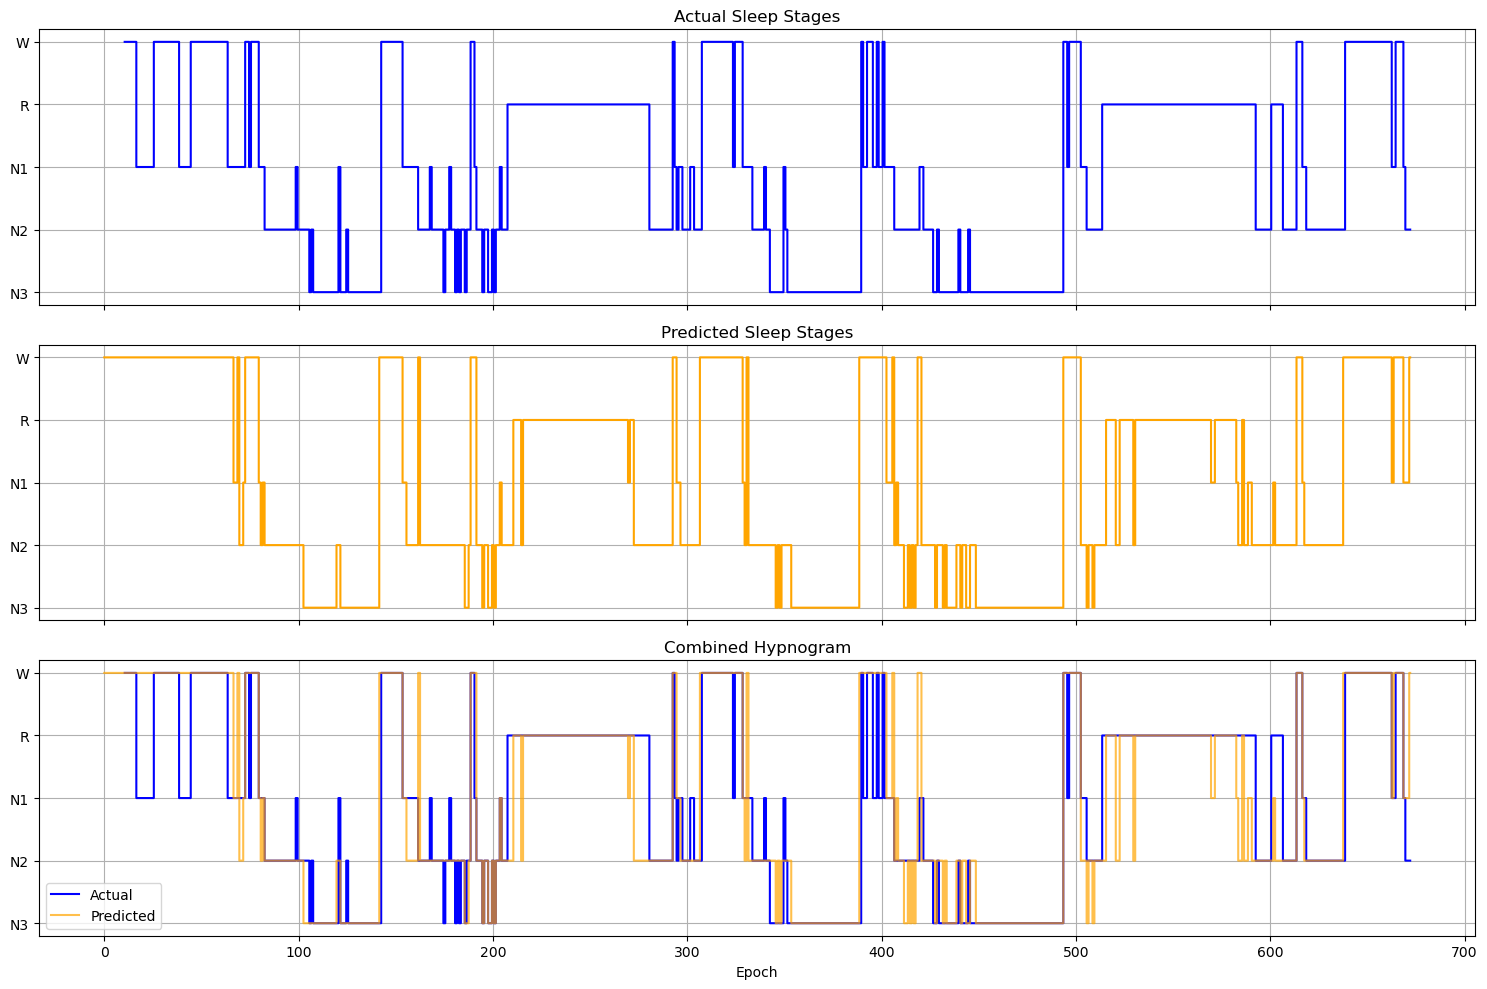

REVIEW [I0002150032018-1] Acc=0.85 F1=0.80 Kappa=0.50 Precision=0.63 Recall=0.47 Specificity=0.47 Score=0.66 


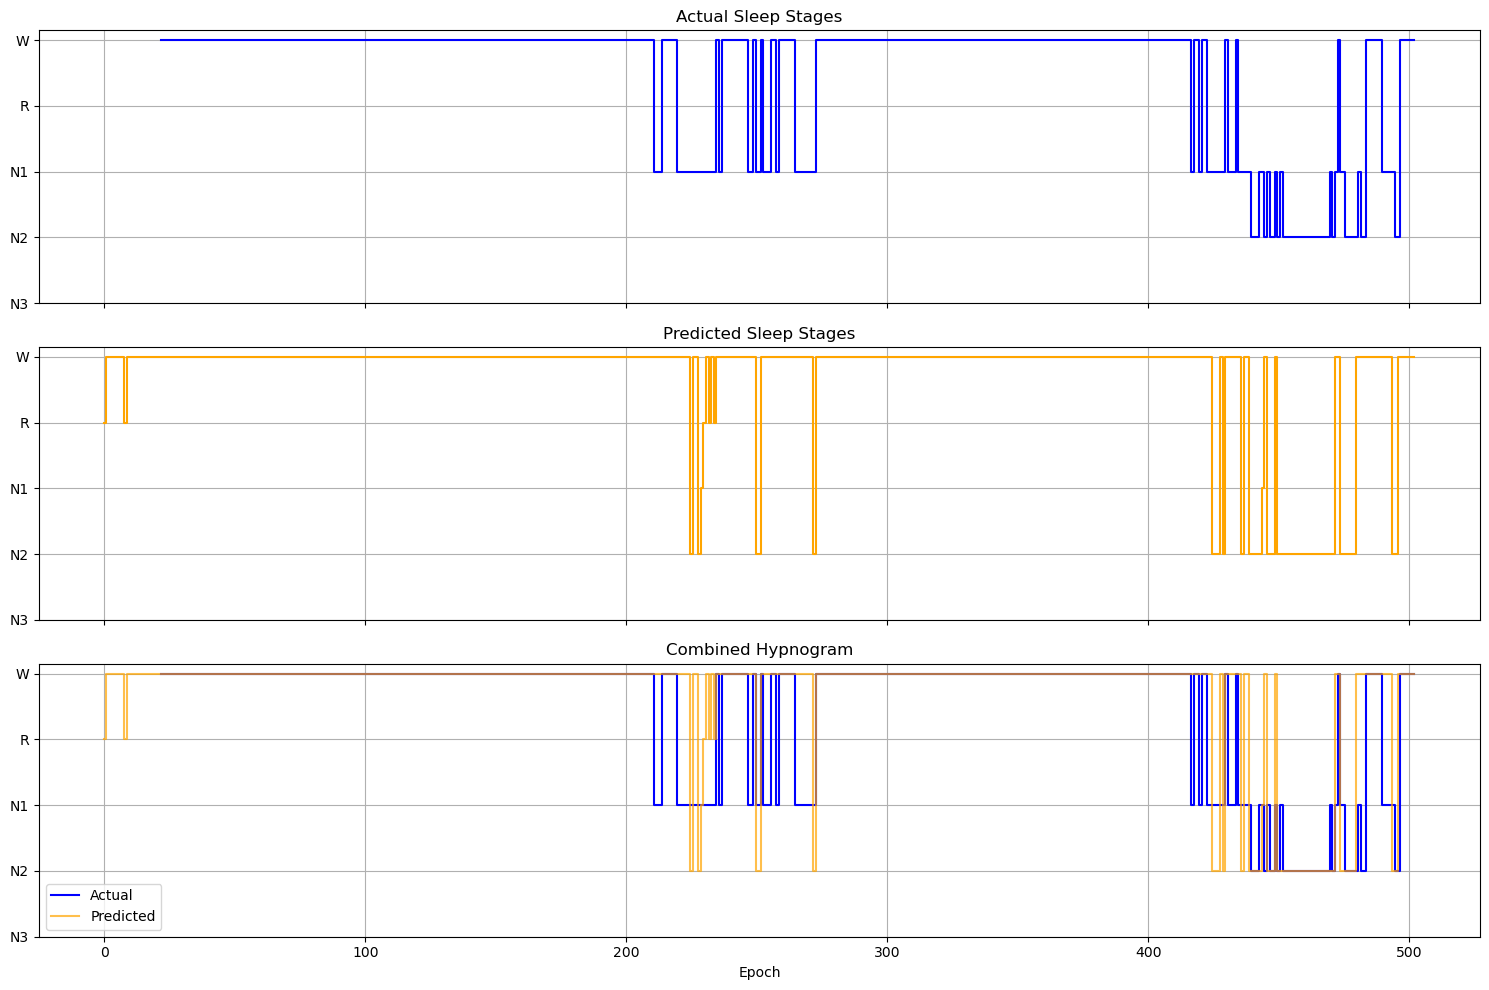

REVIEW [I0002150032093-3] Acc=0.76 F1=0.71 Kappa=0.63 Precision=0.77 Recall=0.63 Specificity=0.63 Score=0.70 


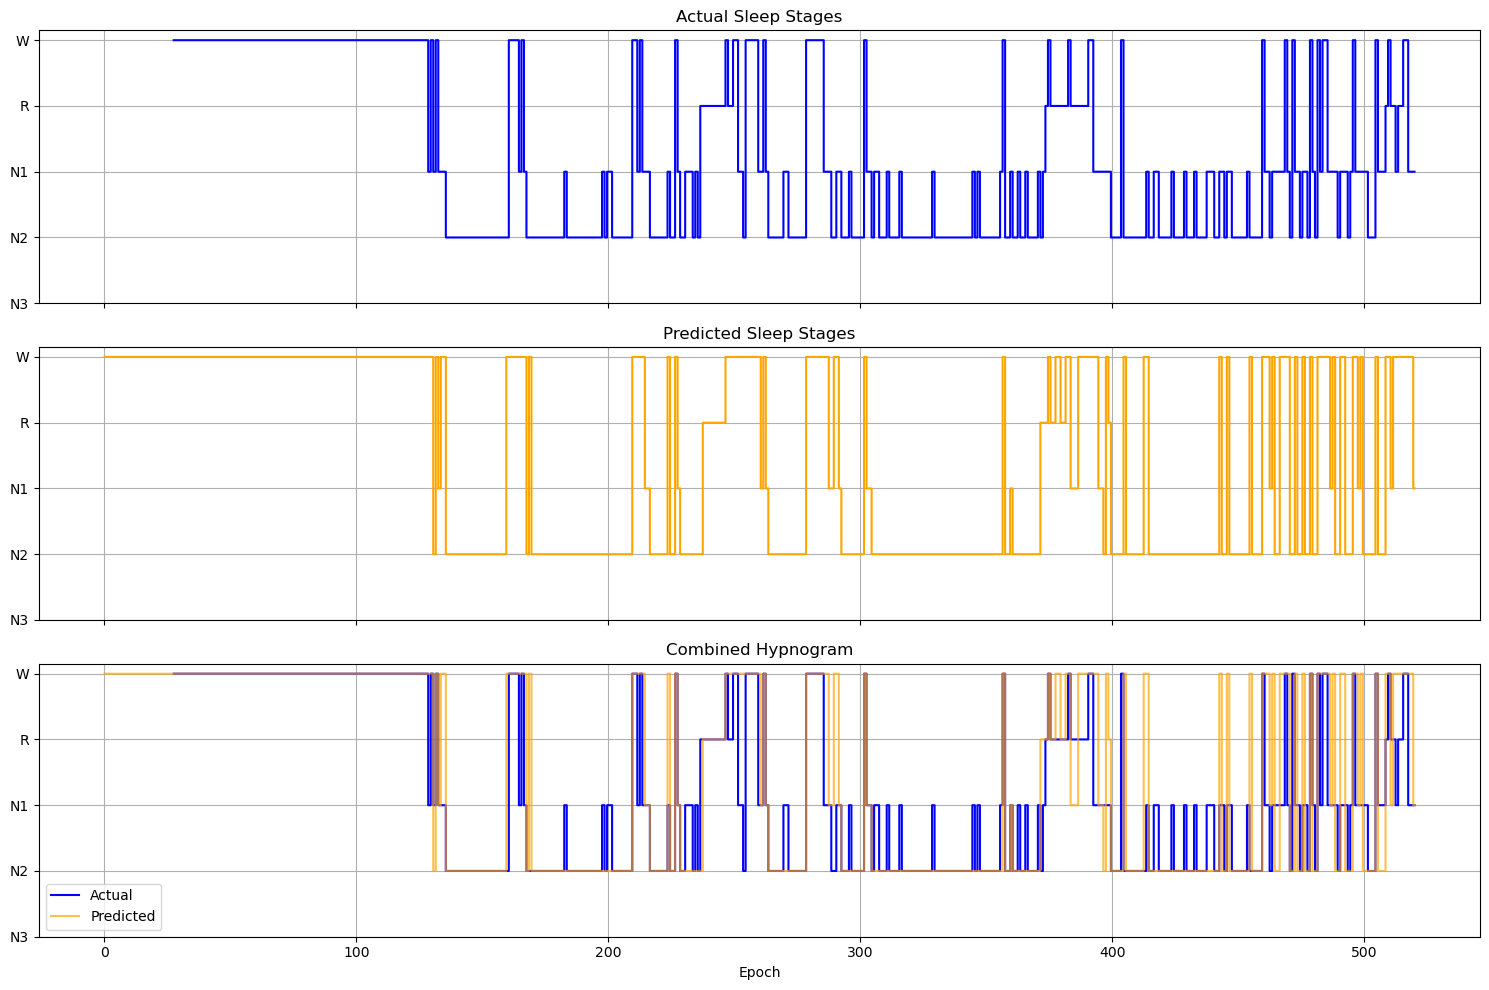

GOOD [I0002150032159-1] Acc=0.86 F1=0.88 Kappa=0.80 Precision=0.78 Recall=0.85 Specificity=0.85 Score=0.84 


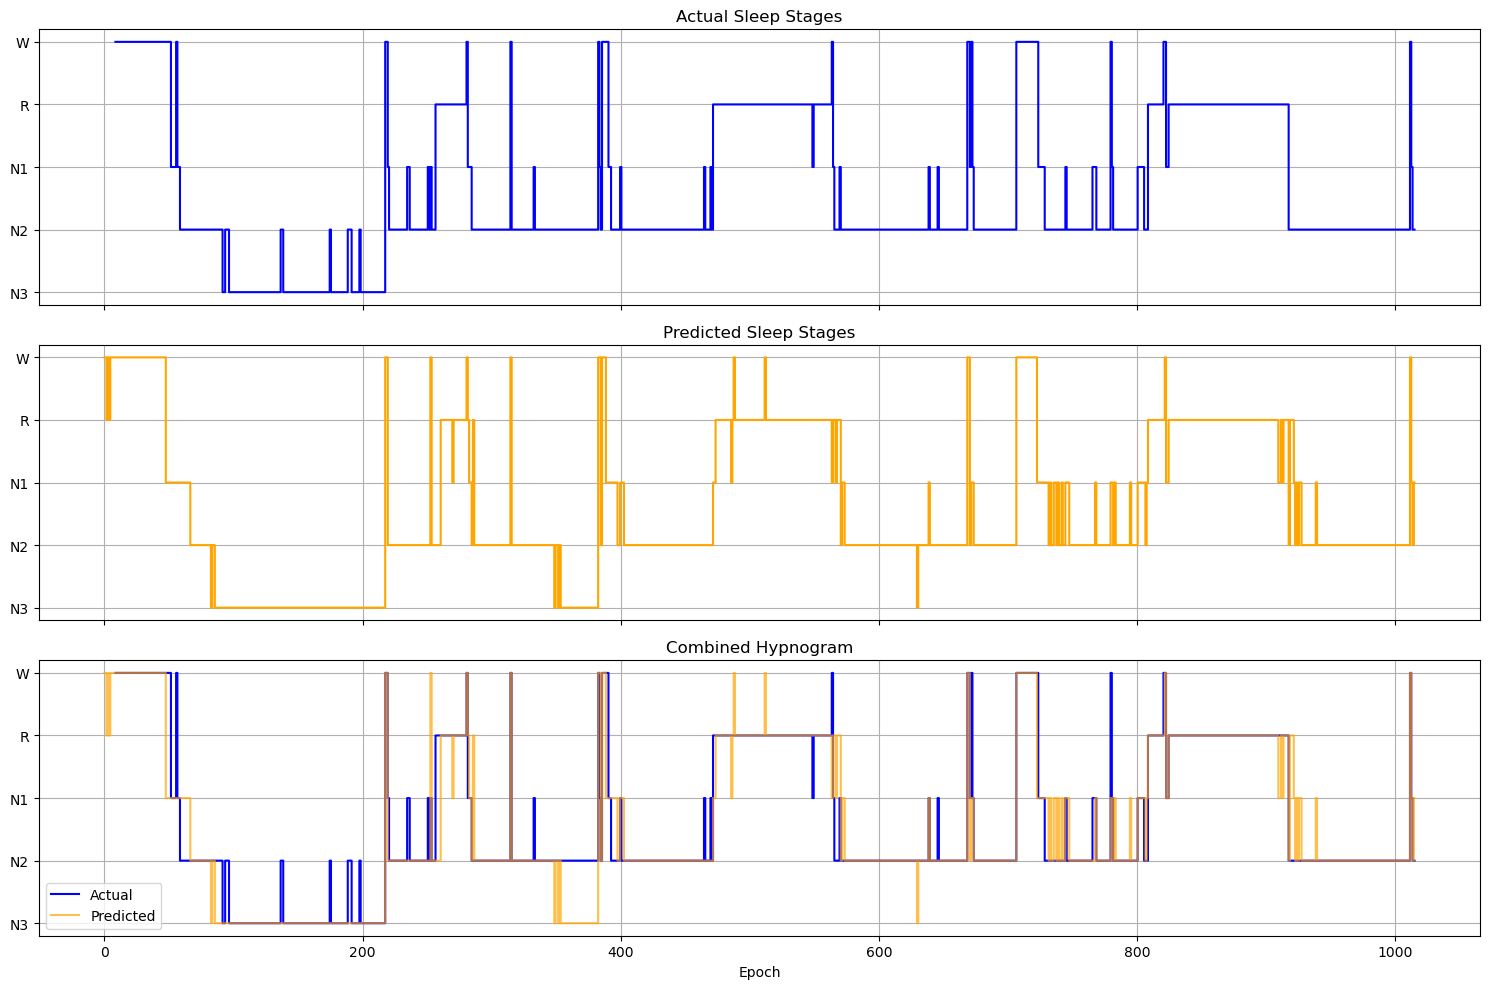

BAD [I0002150032216-1] Acc=0.50 F1=0.49 Kappa=0.31 Precision=0.54 Recall=0.57 Specificity=0.57 Score=0.48 


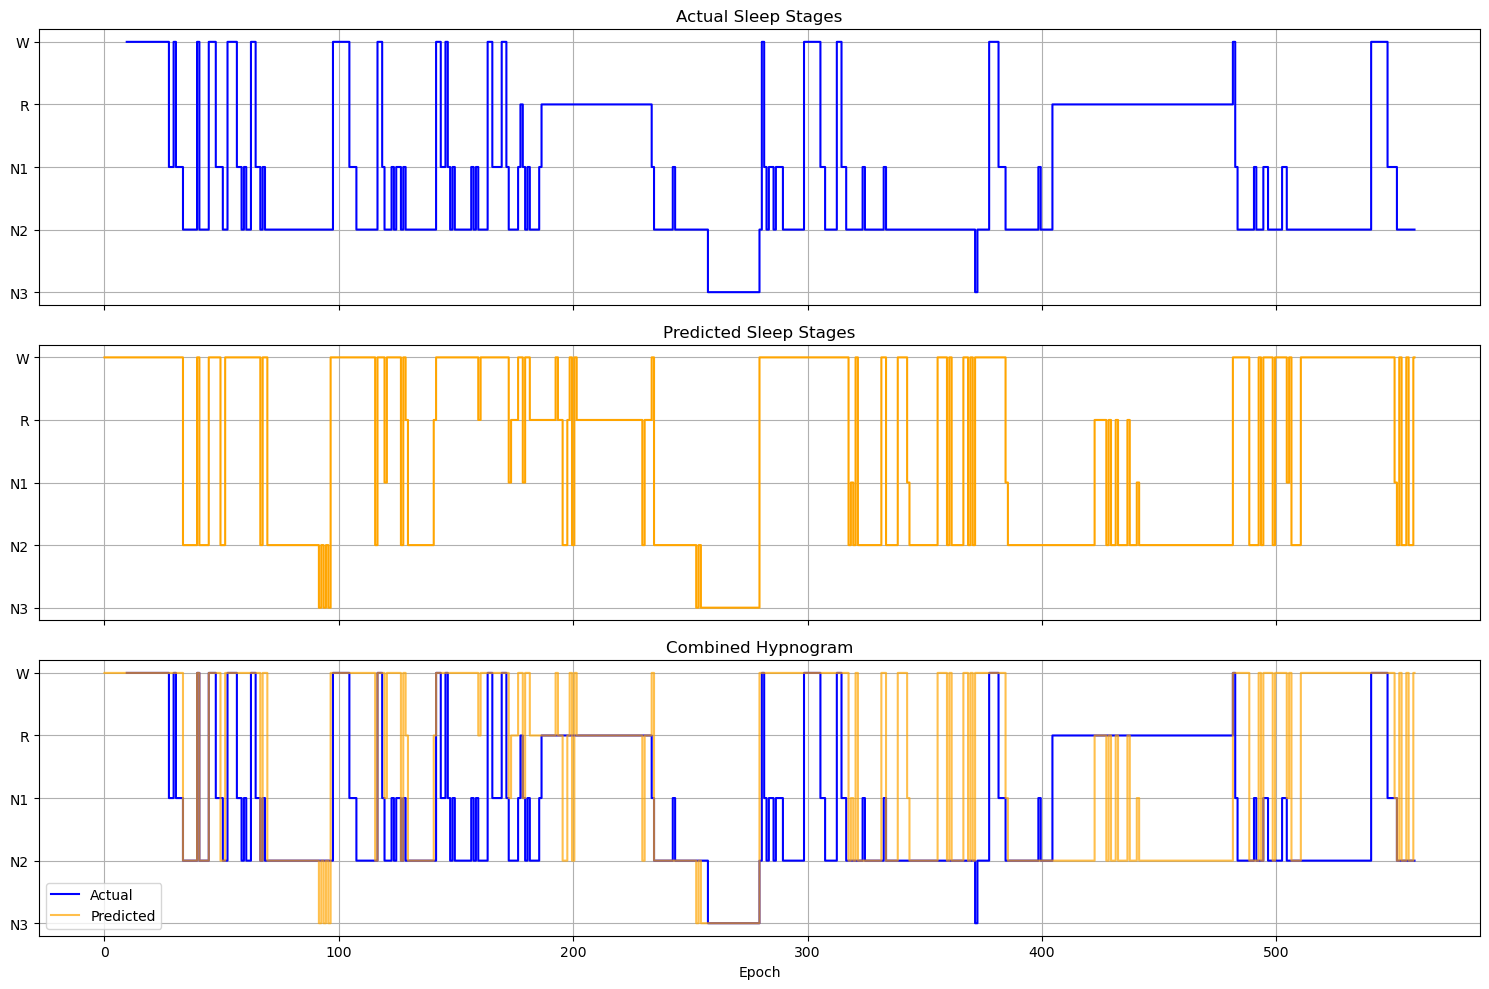

BAD [I0002150032388-1] Acc=0.63 F1=0.66 Kappa=0.45 Precision=0.45 Recall=0.54 Specificity=0.54 Score=0.55 


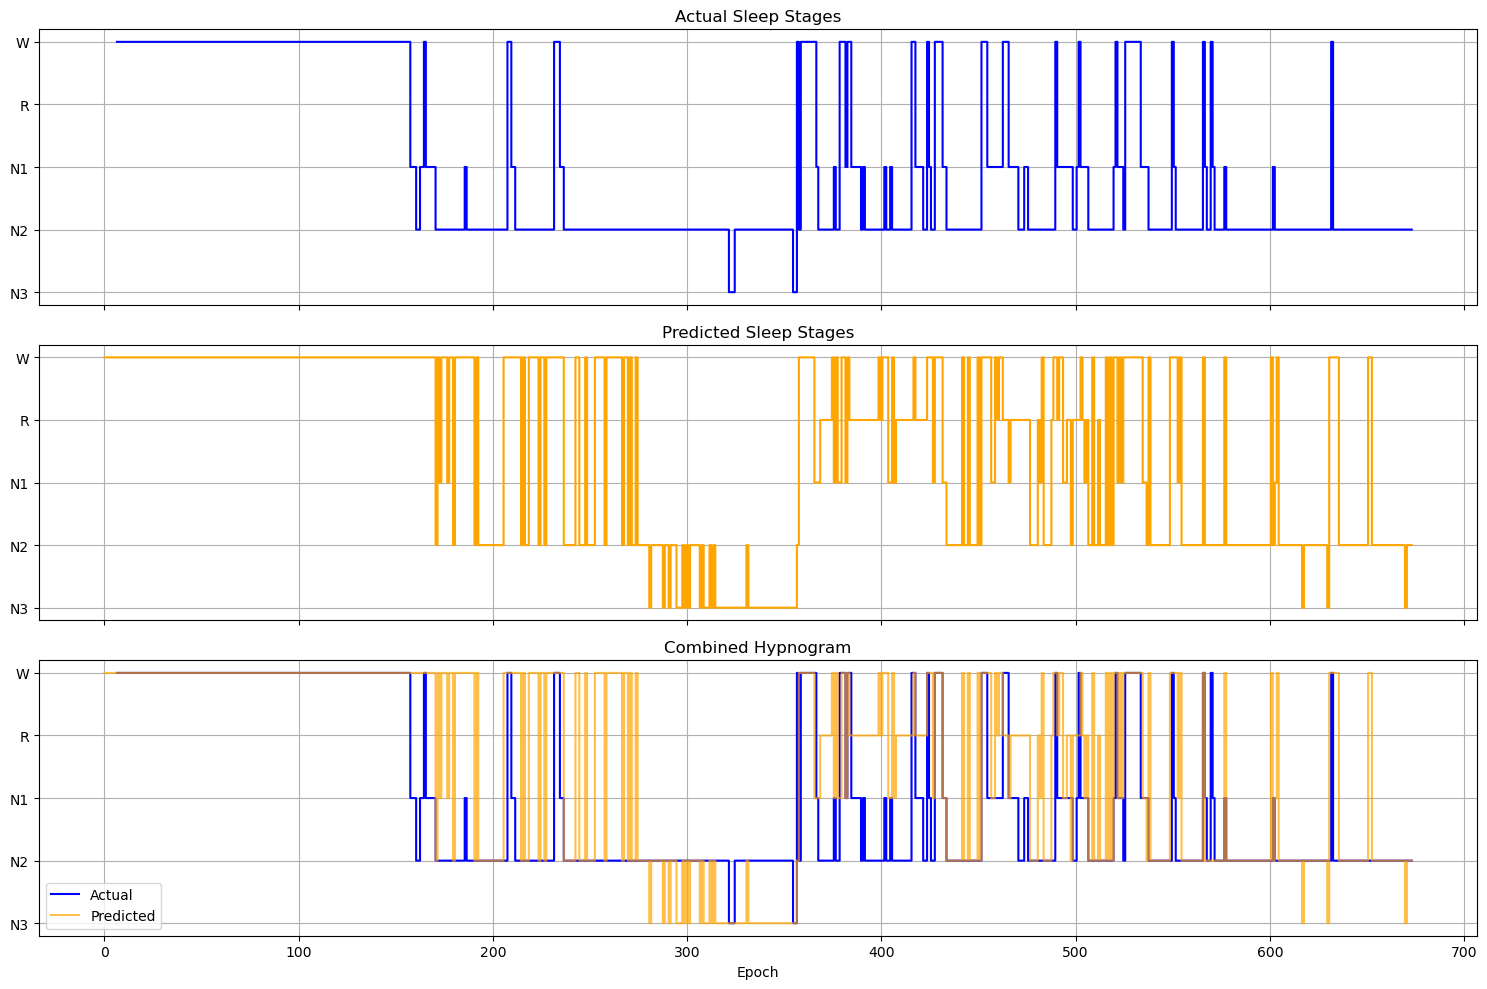

GOOD [I0002150032510-1] Acc=0.93 F1=0.93 Kappa=0.89 Precision=0.84 Recall=0.84 Specificity=0.84 Score=0.89 


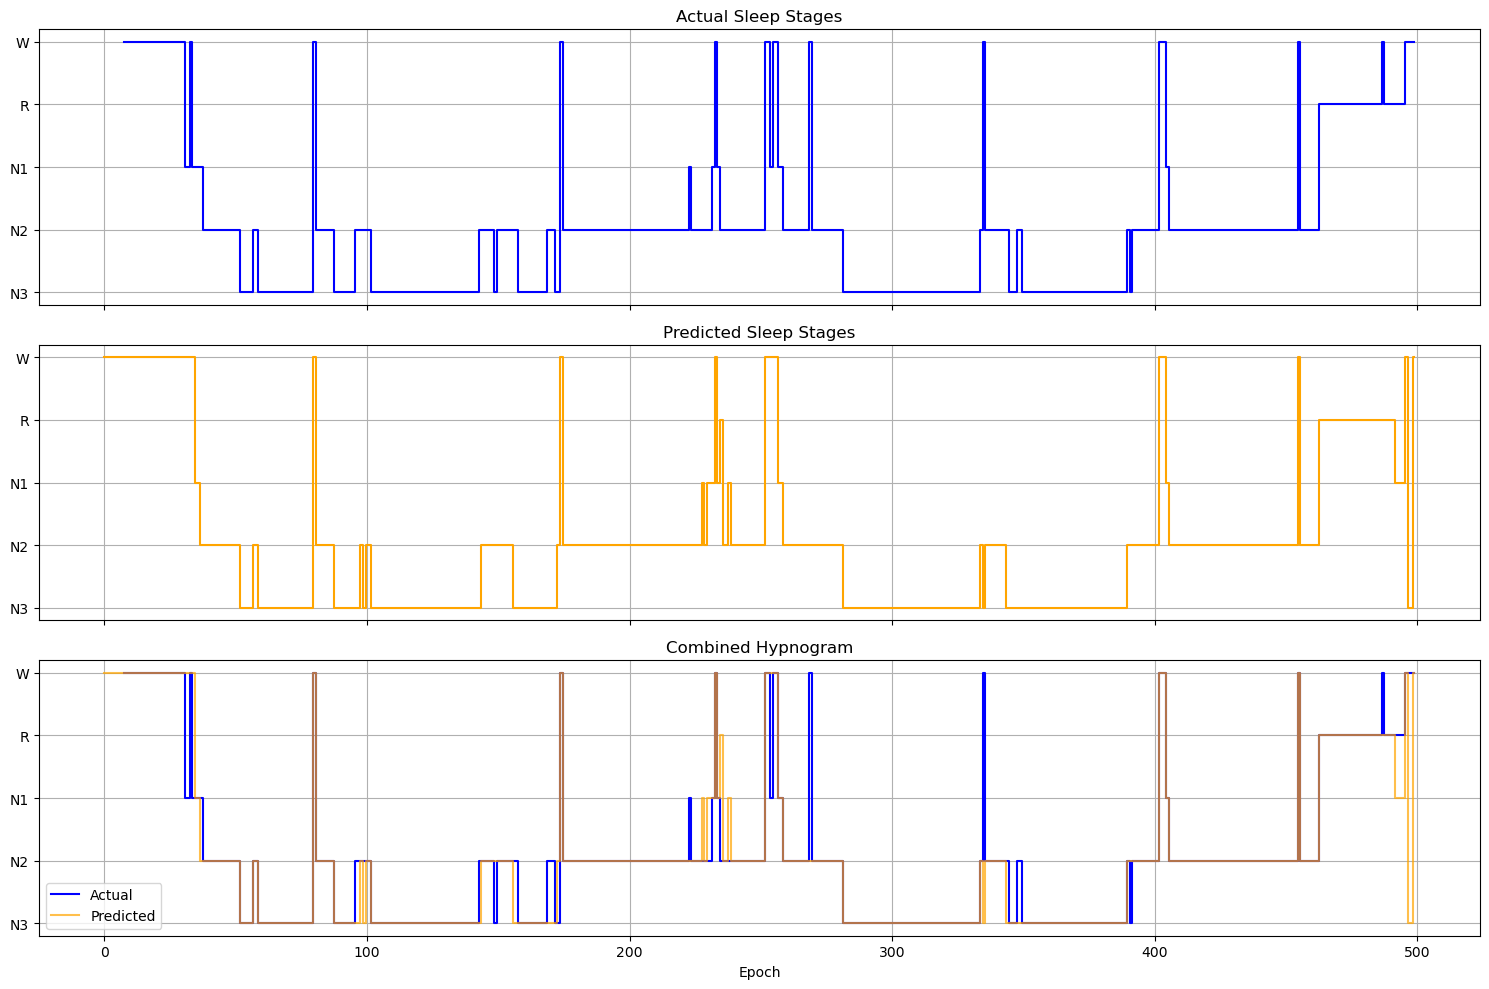

REVIEW [I0002150032516-1] Acc=0.76 F1=0.77 Kappa=0.64 Precision=0.68 Recall=0.74 Specificity=0.74 Score=0.72 


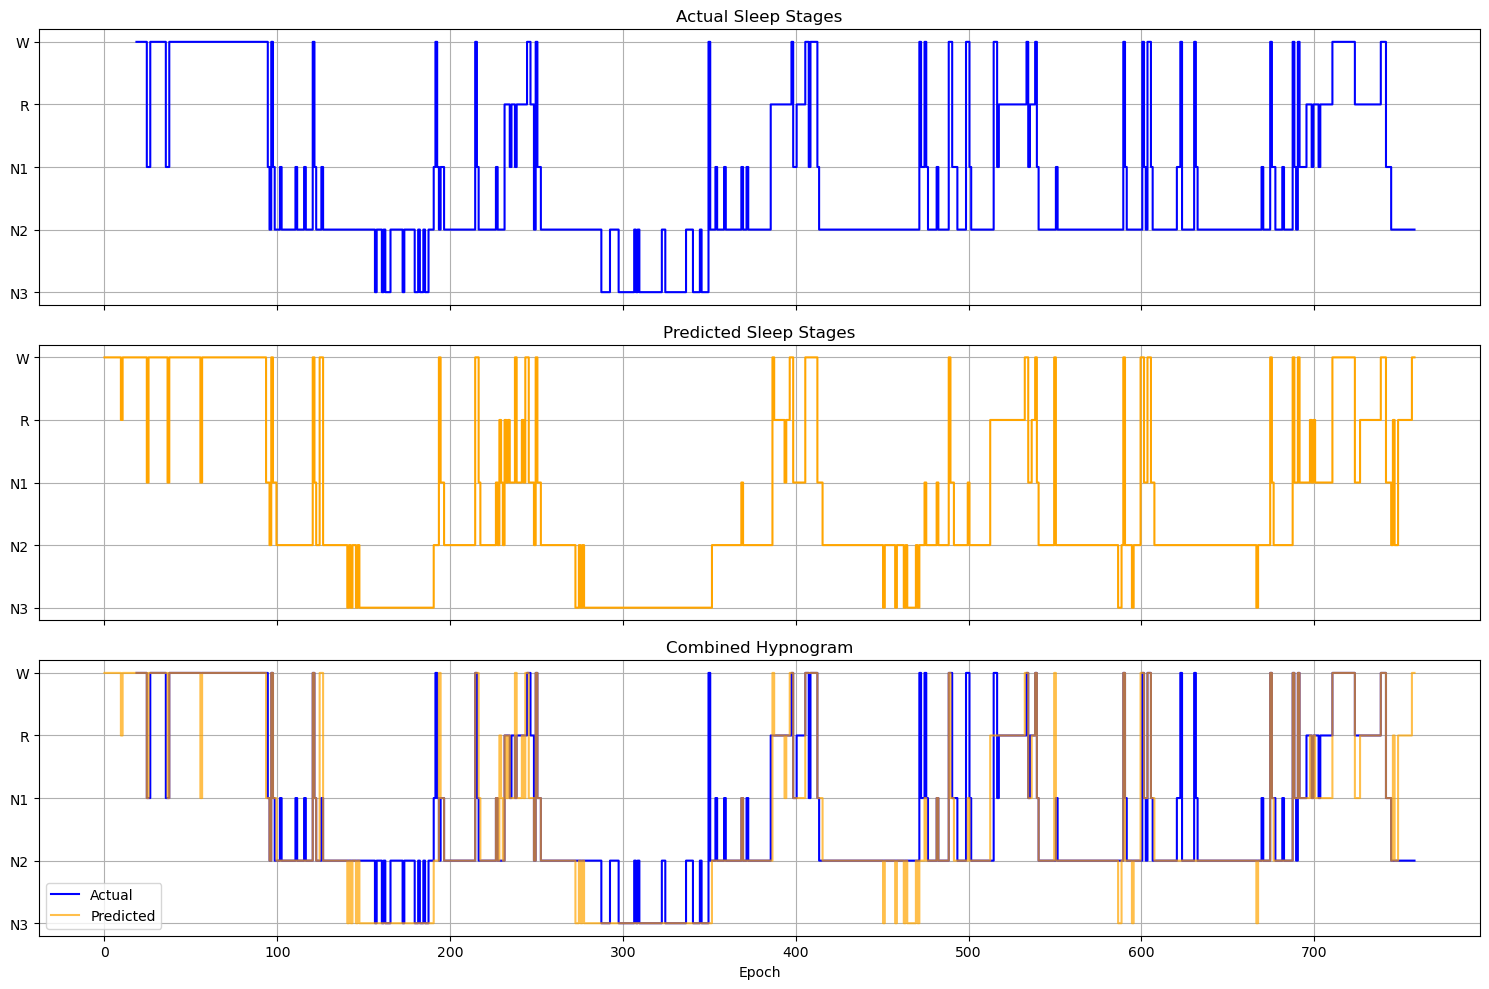

REVIEW [I0002150032729-1] Acc=0.69 F1=0.71 Kappa=0.55 Precision=0.62 Recall=0.70 Specificity=0.70 Score=0.66 


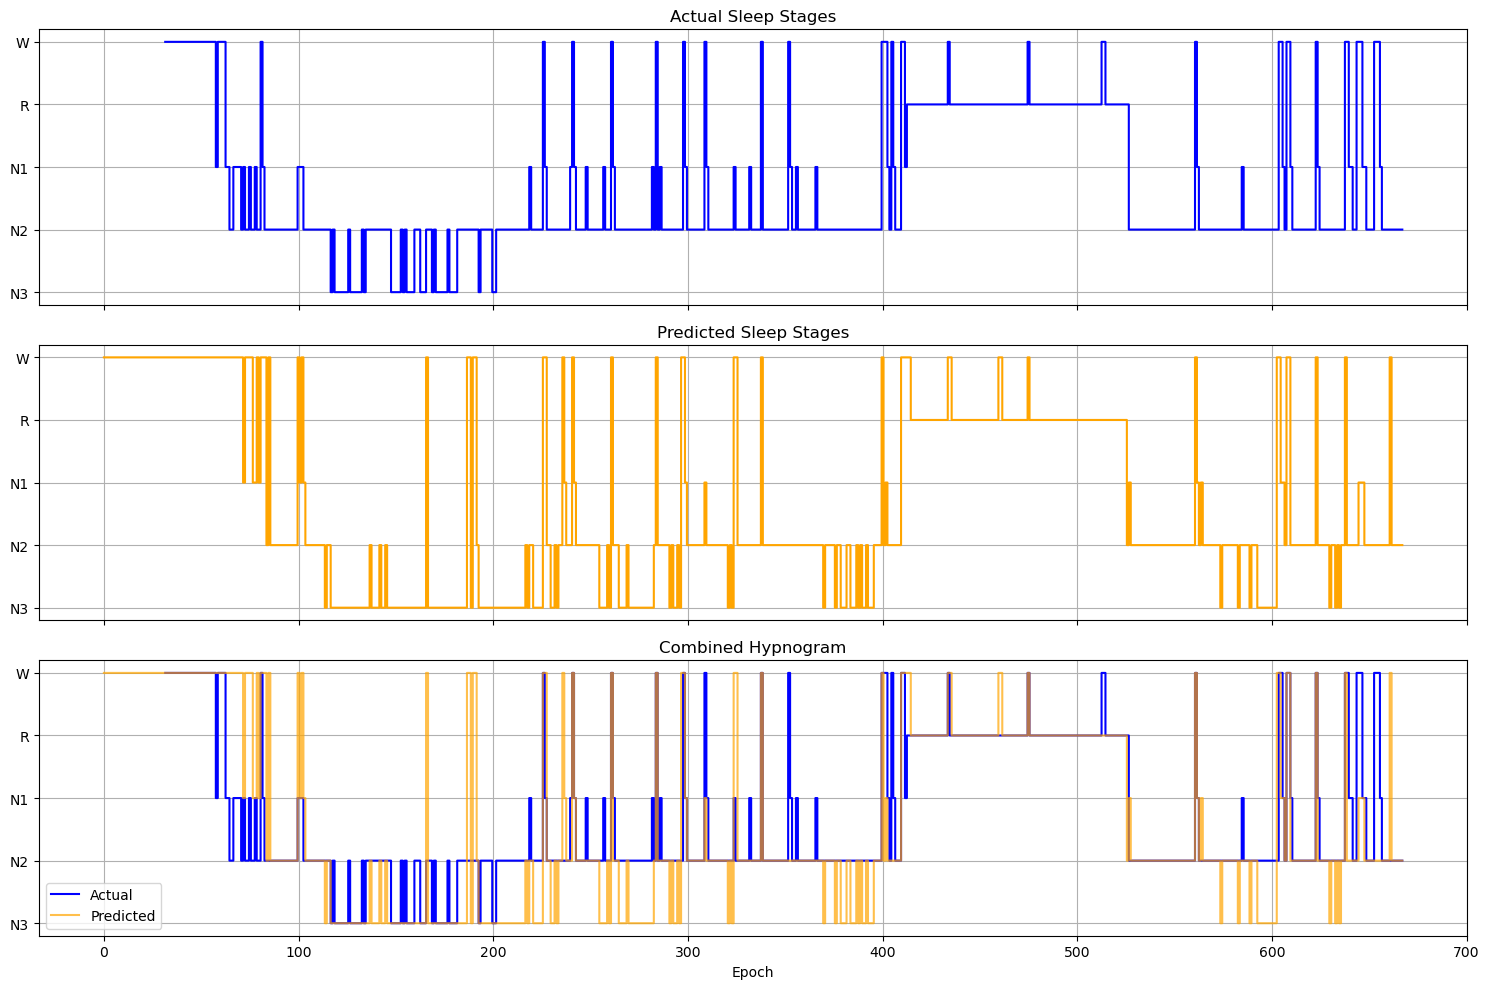

GOOD [I0002150032773-1] Acc=0.88 F1=0.88 Kappa=0.83 Precision=0.84 Recall=0.80 Specificity=0.80 Score=0.85 


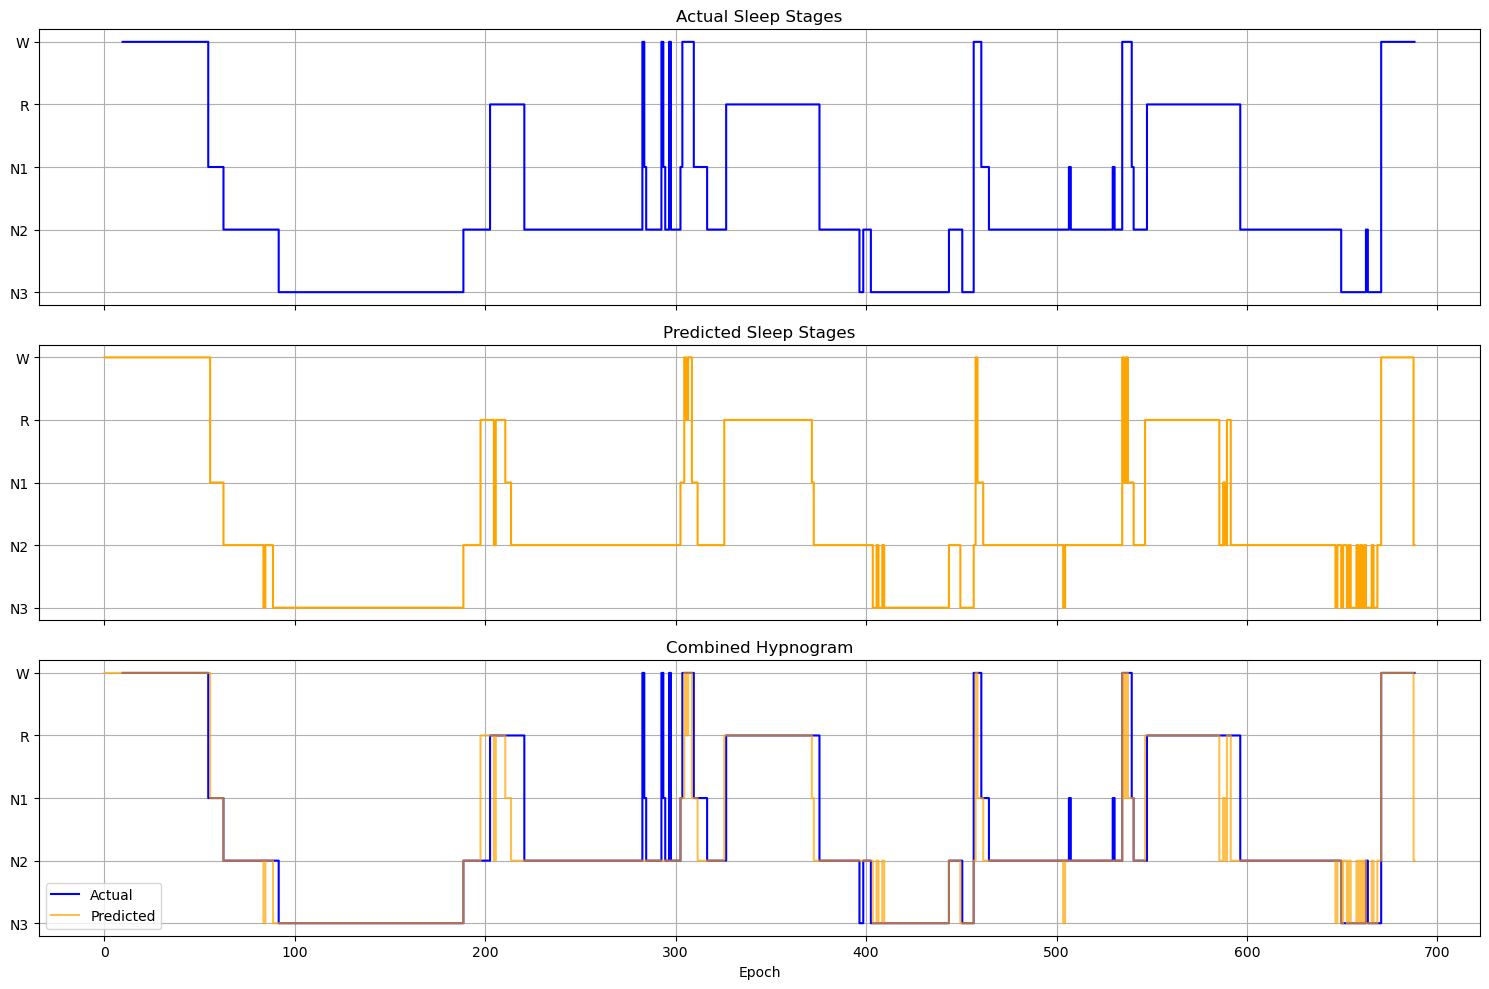

REVIEW [I0002150032857-1] Acc=0.84 F1=0.82 Kappa=0.67 Precision=0.61 Recall=0.55 Specificity=0.55 Score=0.71 


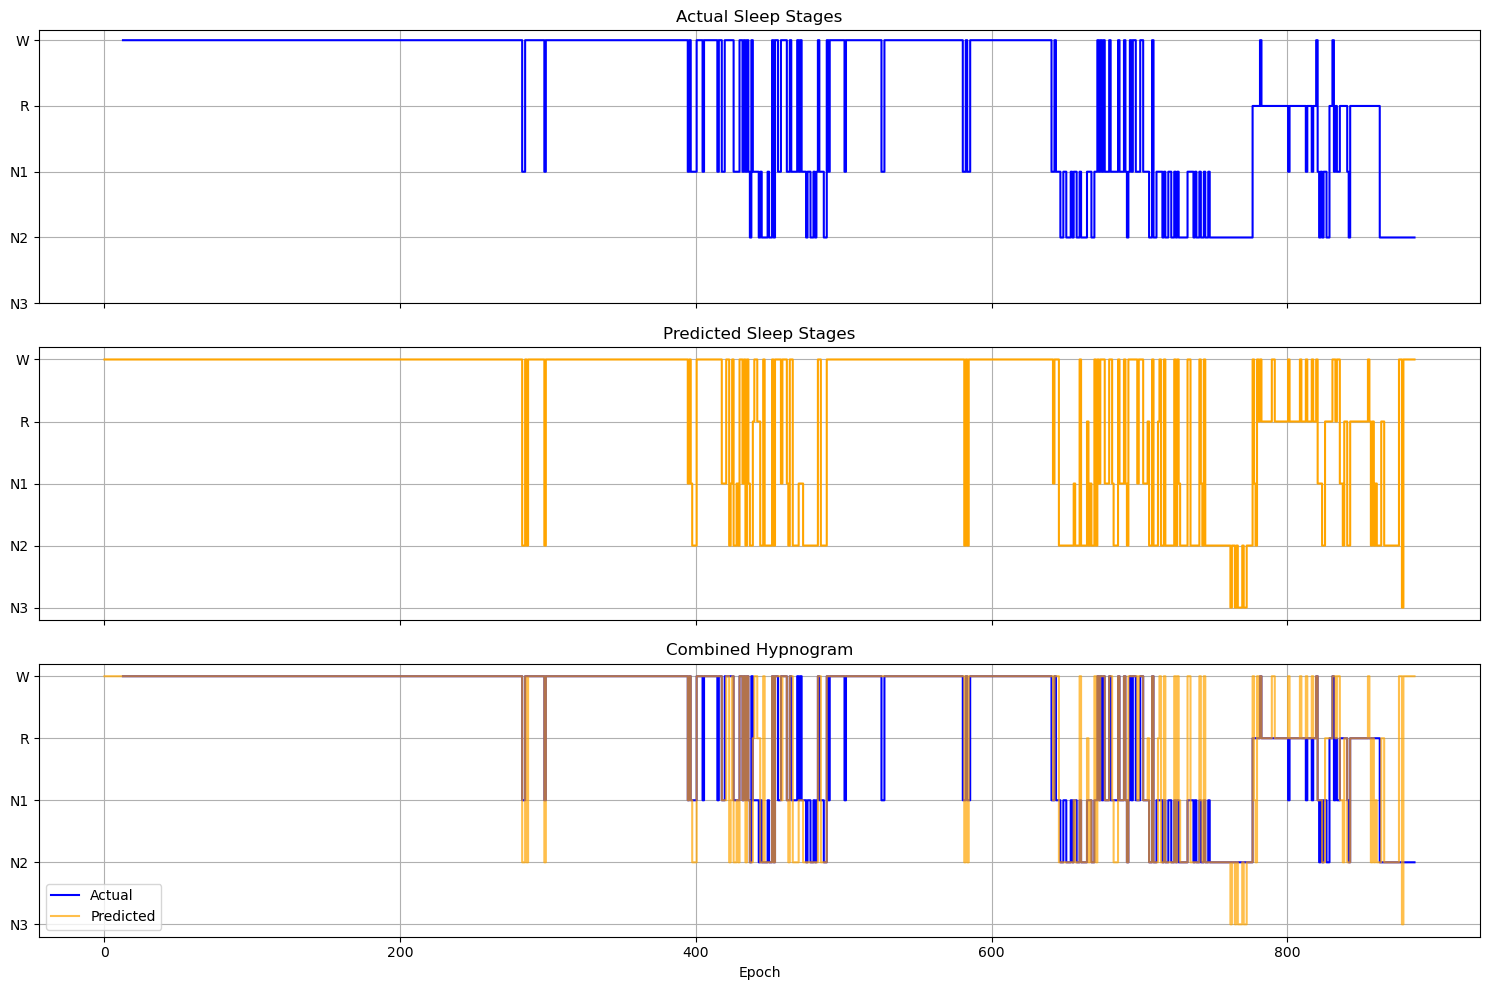

BAD [I0002150032879-1] Acc=0.73 F1=0.73 Kappa=0.60 Precision=0.62 Recall=0.53 Specificity=0.53 Score=0.65 


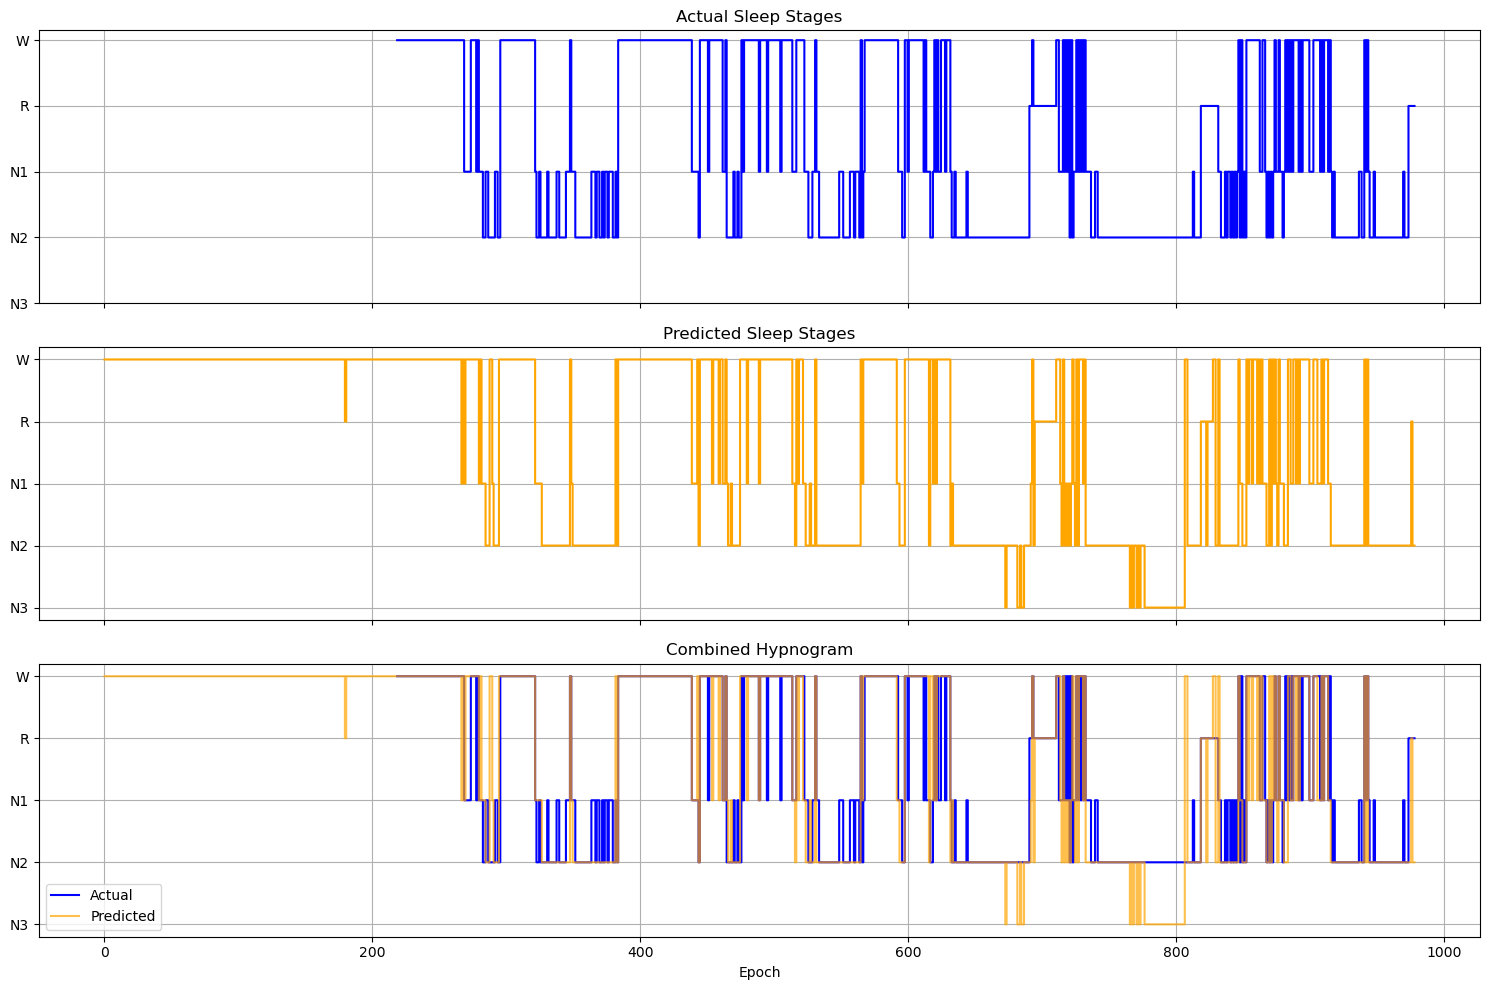

REVIEW [I0002150032946-1] Acc=0.76 F1=0.74 Kappa=0.69 Precision=0.81 Recall=0.74 Specificity=0.74 Score=0.74 


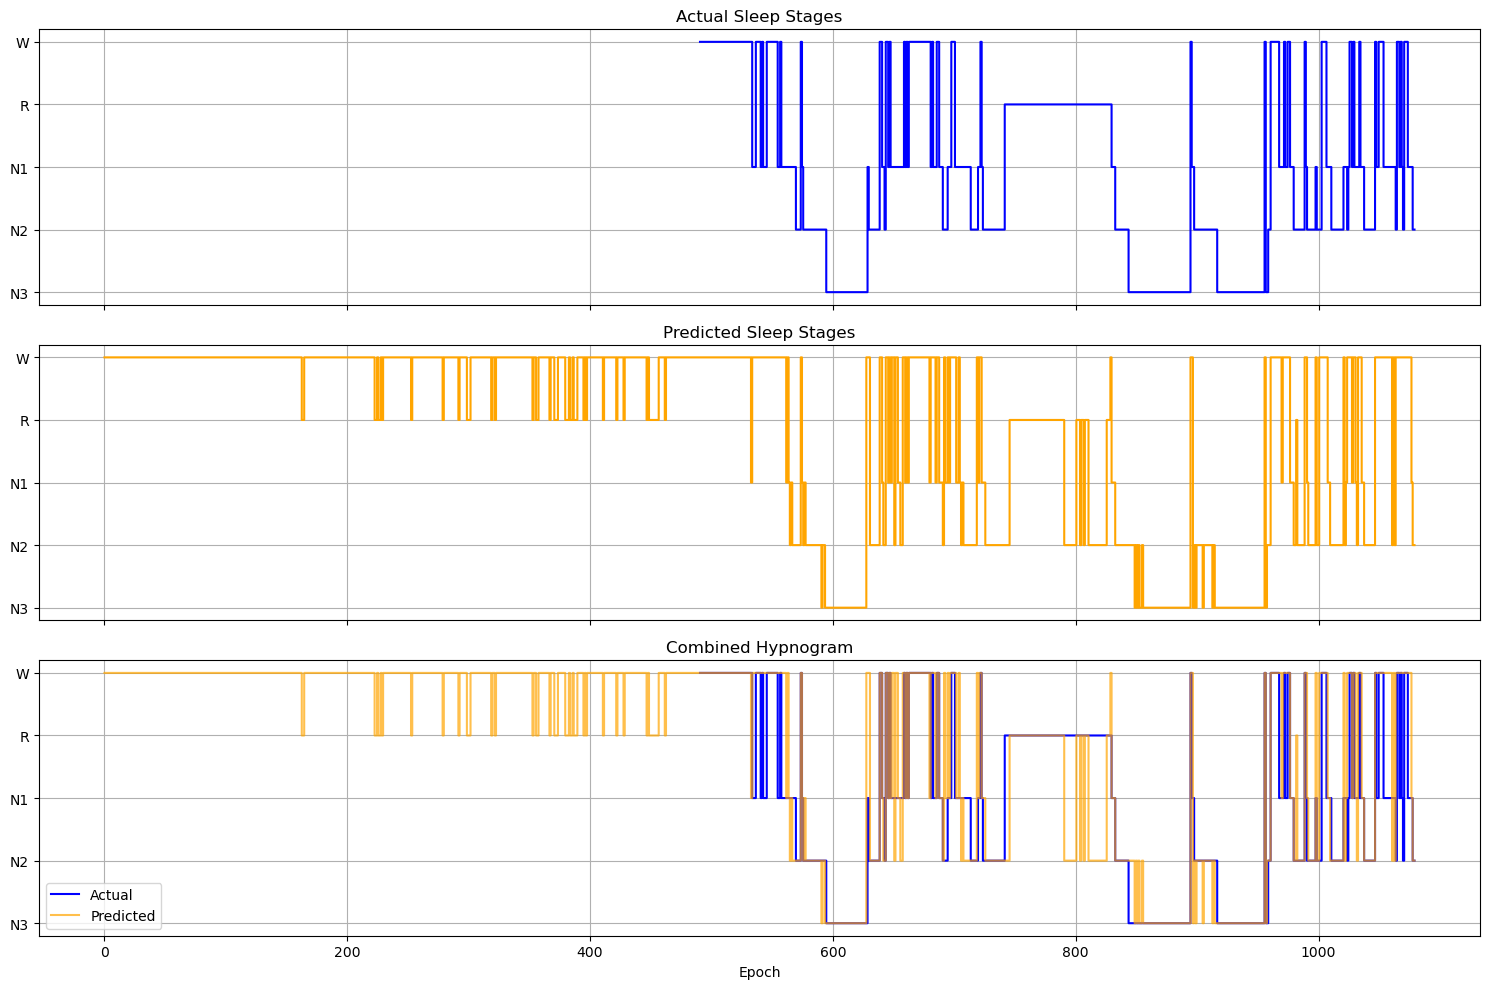

GOOD [I0002150033085-1] Acc=0.88 F1=0.89 Kappa=0.80 Precision=0.73 Recall=0.80 Specificity=0.80 Score=0.83 


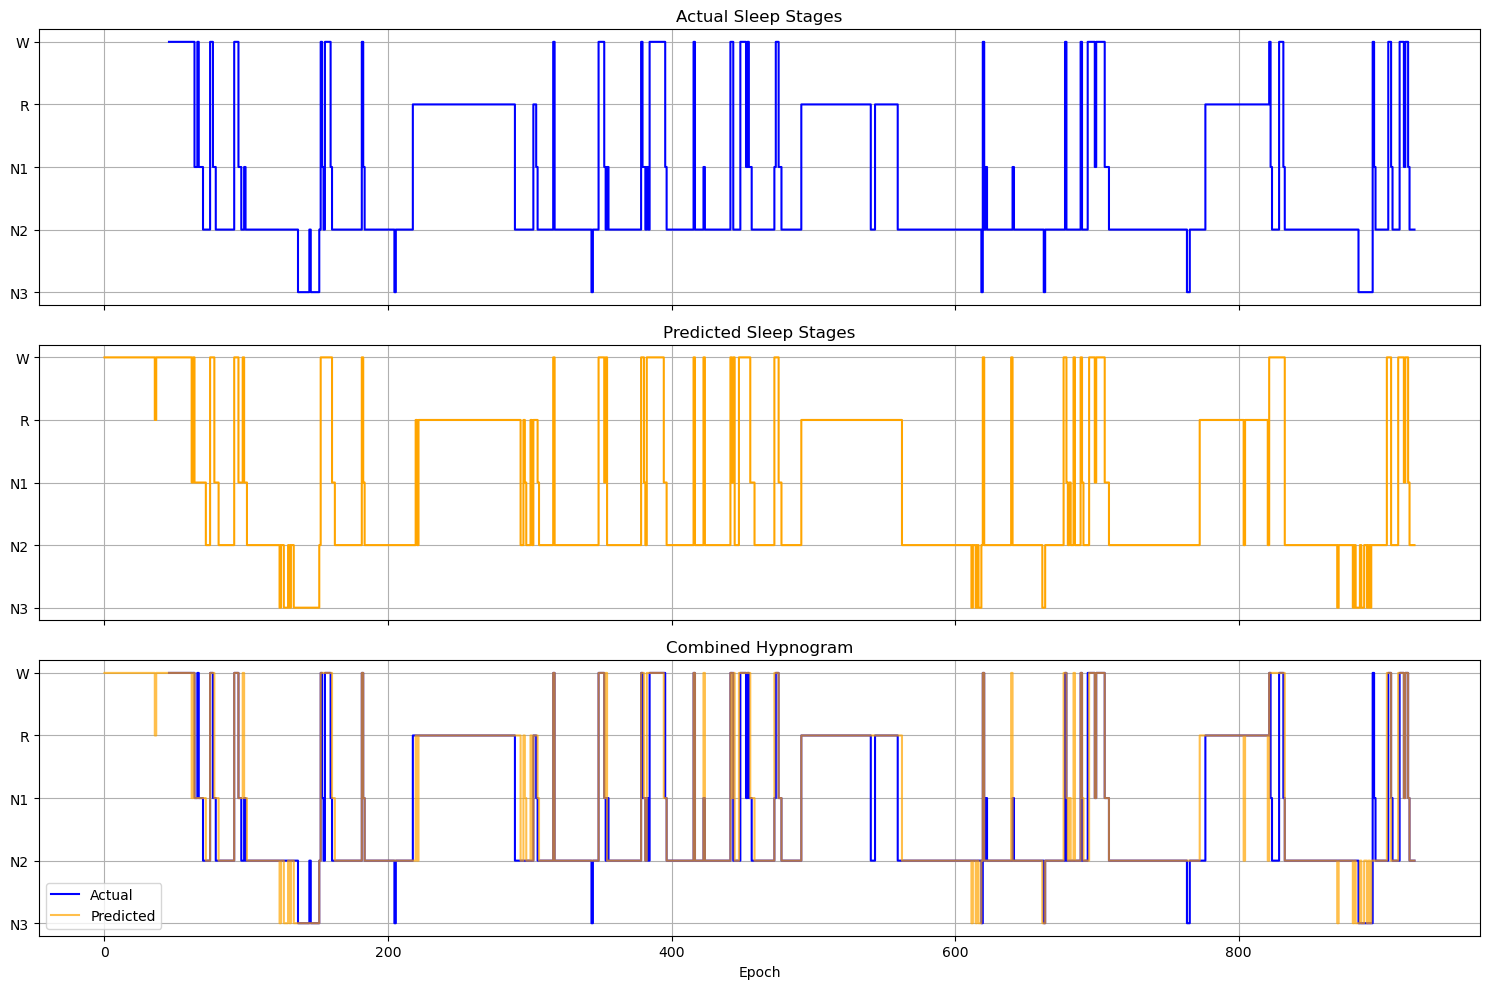

GOOD [I0002150033086-1] Acc=0.88 F1=0.87 Kappa=0.84 Precision=0.84 Recall=0.78 Specificity=0.78 Score=0.84 


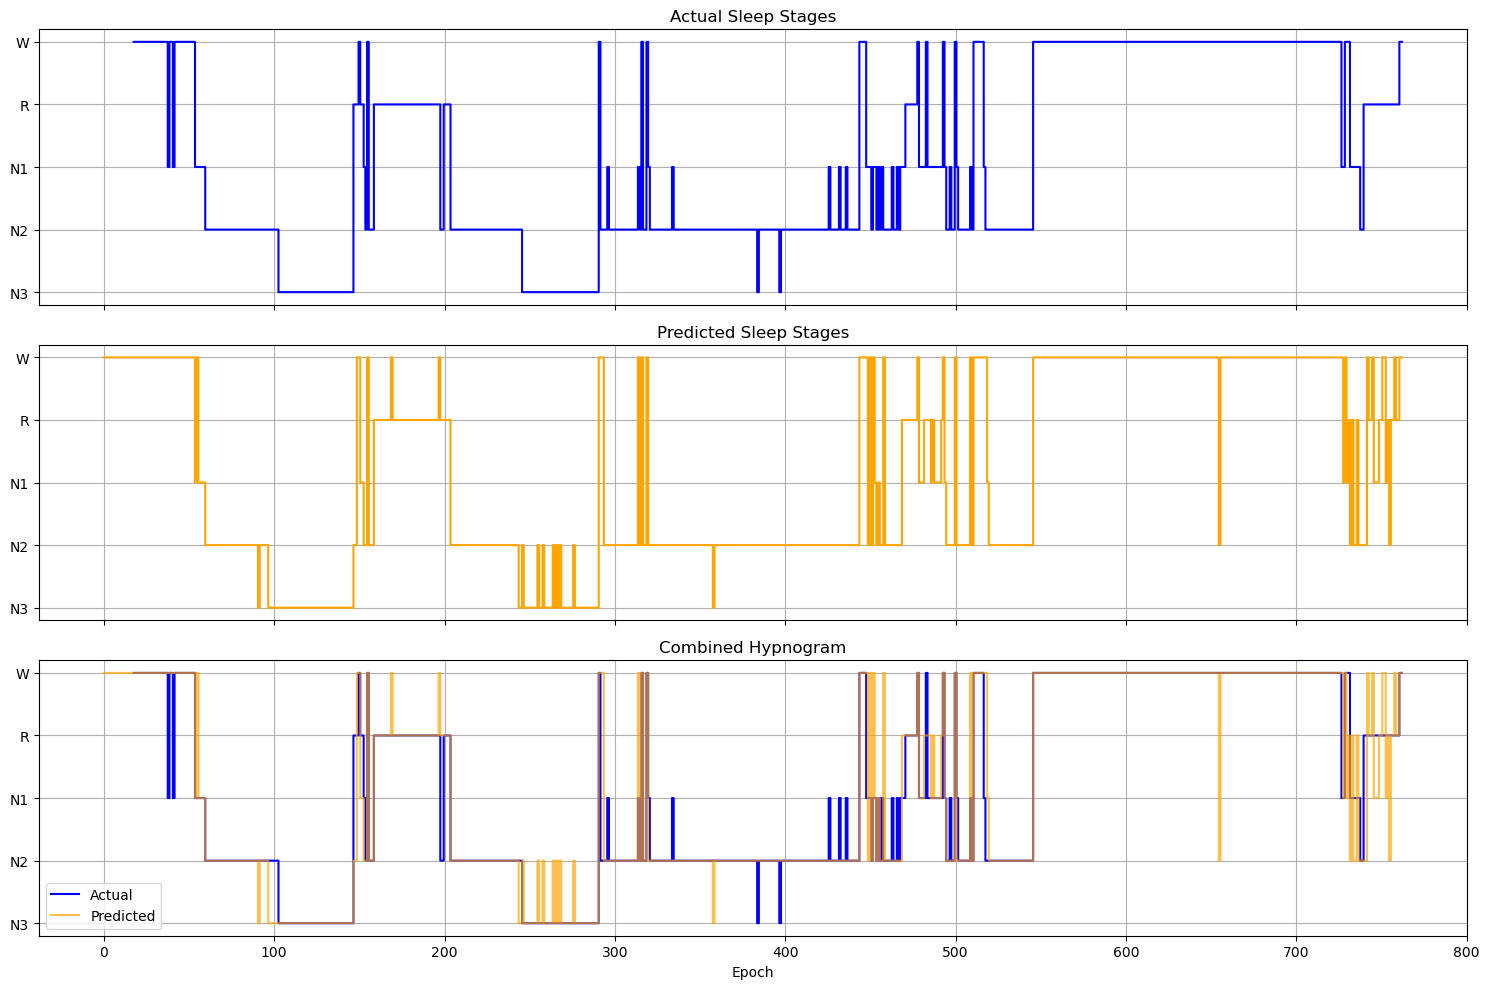

GOOD [I0002150033089-1] Acc=0.83 F1=0.84 Kappa=0.76 Precision=0.73 Recall=0.85 Specificity=0.85 Score=0.81 


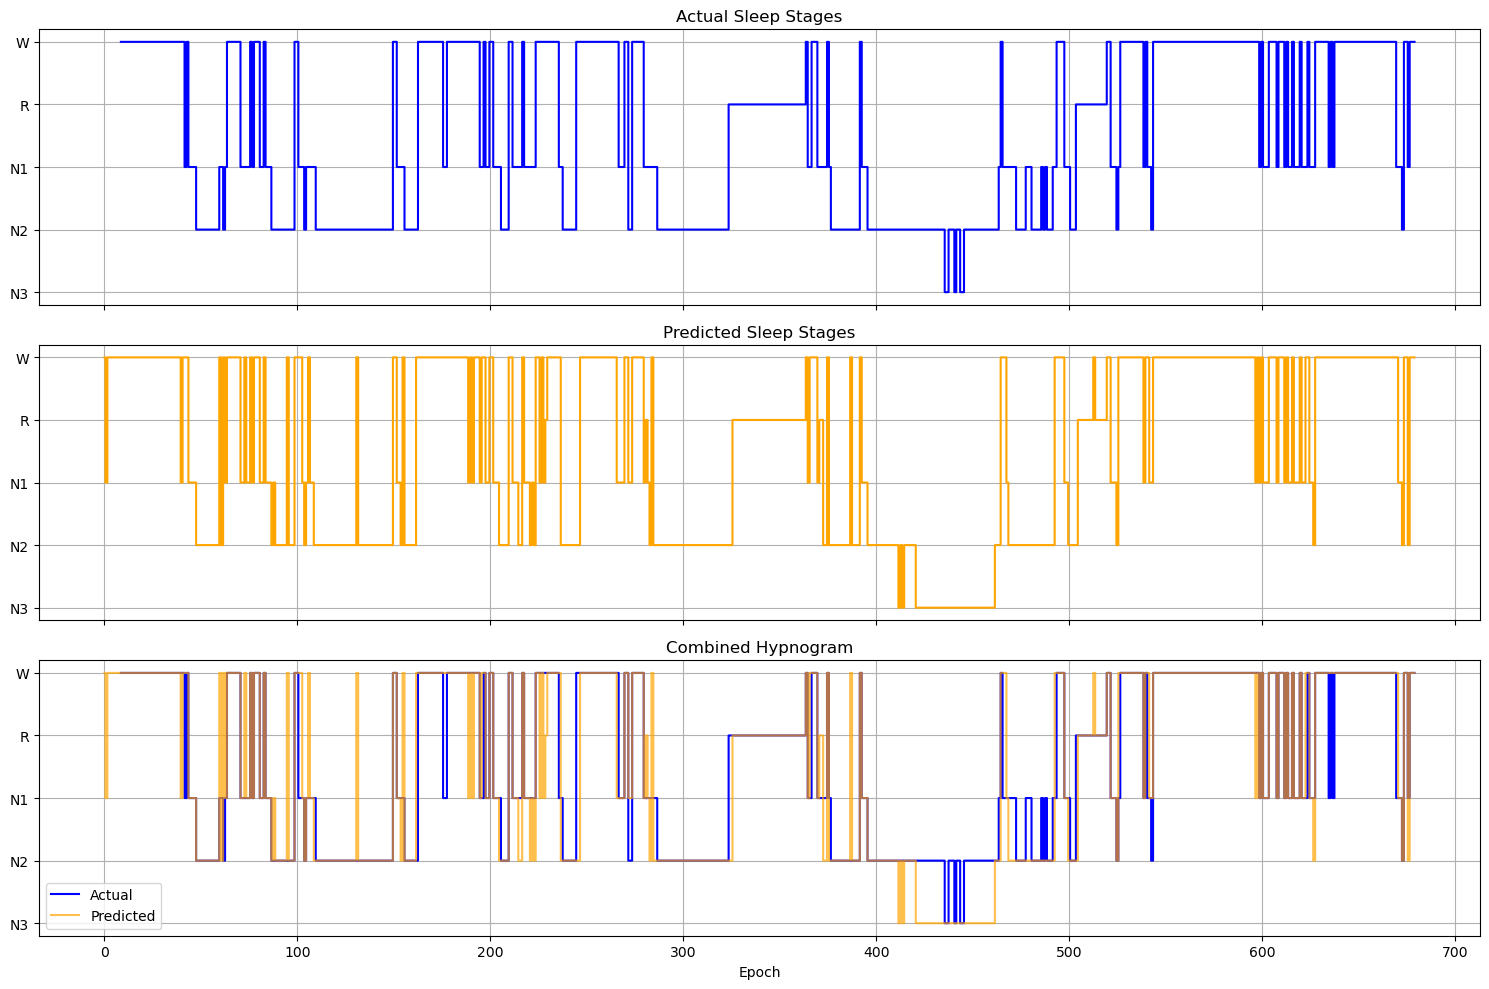

BAD [I0002150033170-1] Acc=0.64 F1=0.64 Kappa=0.41 Precision=0.45 Recall=0.59 Specificity=0.59 Score=0.56 


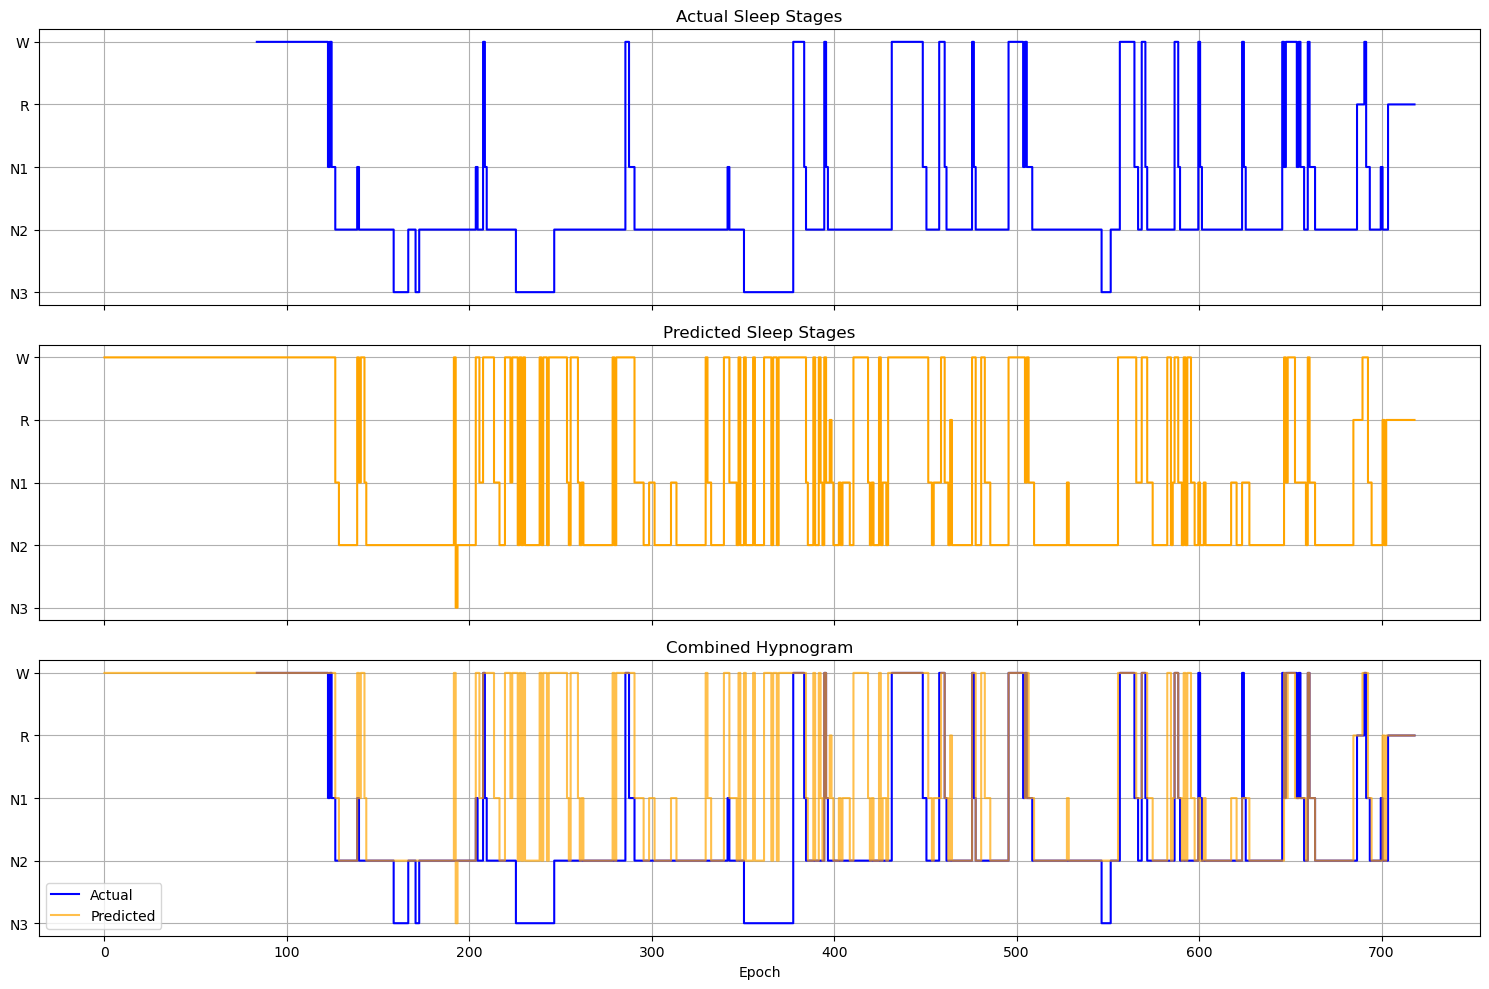

GOOD [I0002150033201-1] Acc=0.87 F1=0.86 Kappa=0.80 Precision=0.84 Recall=0.73 Specificity=0.73 Score=0.82 


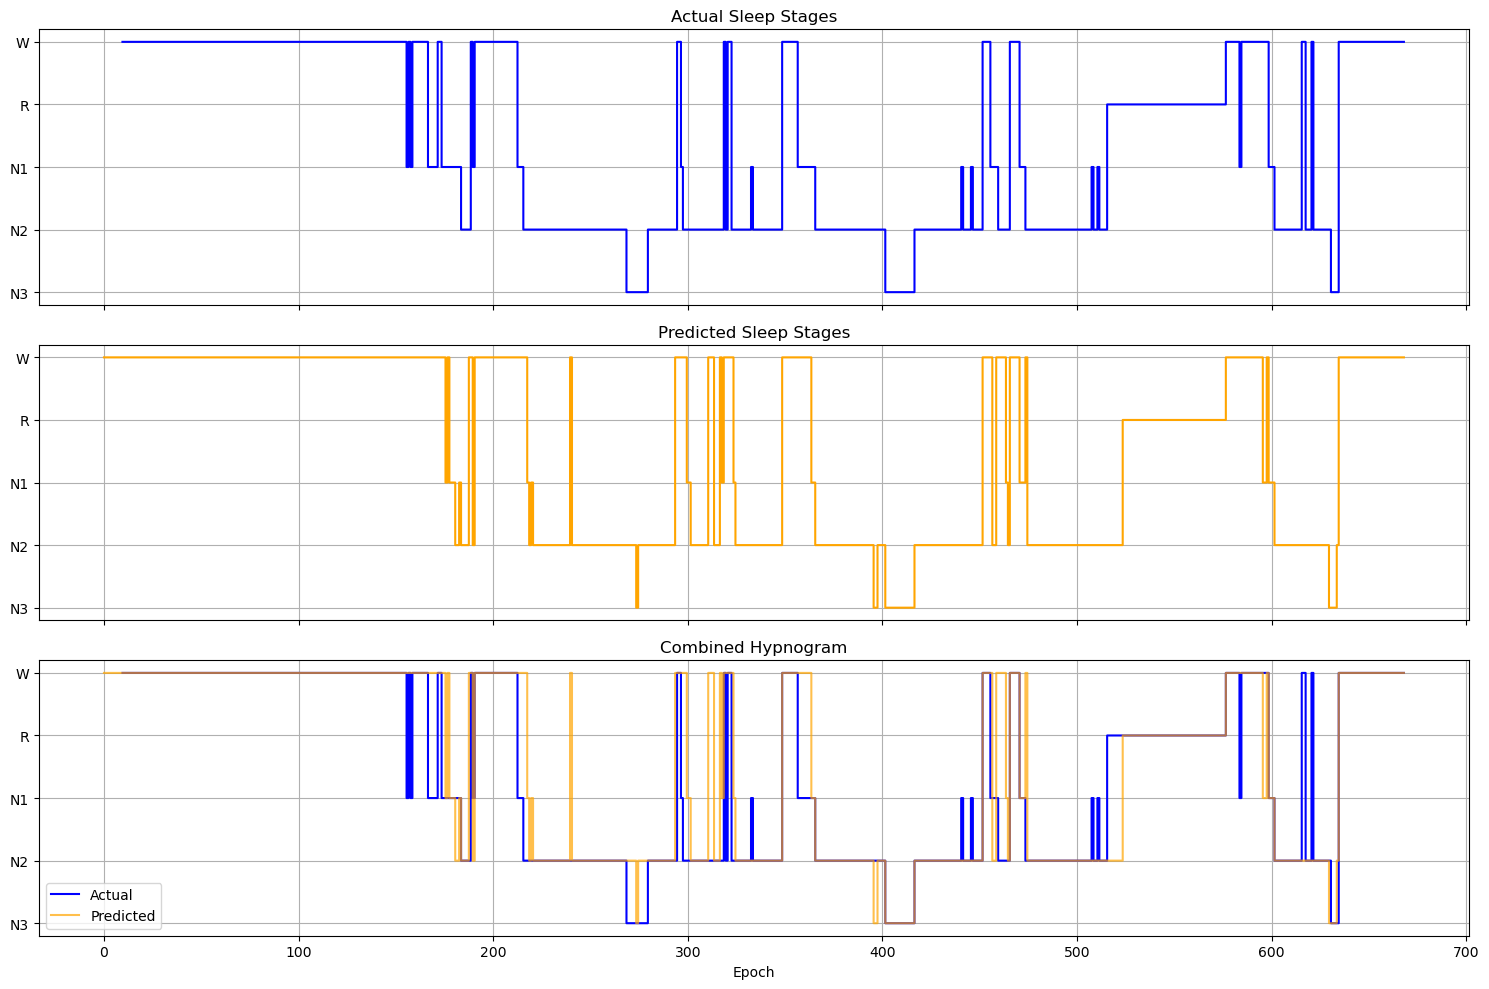

GOOD [I0002150033236-2] Acc=0.81 F1=0.80 Kappa=0.70 Precision=0.75 Recall=0.69 Specificity=0.69 Score=0.75 


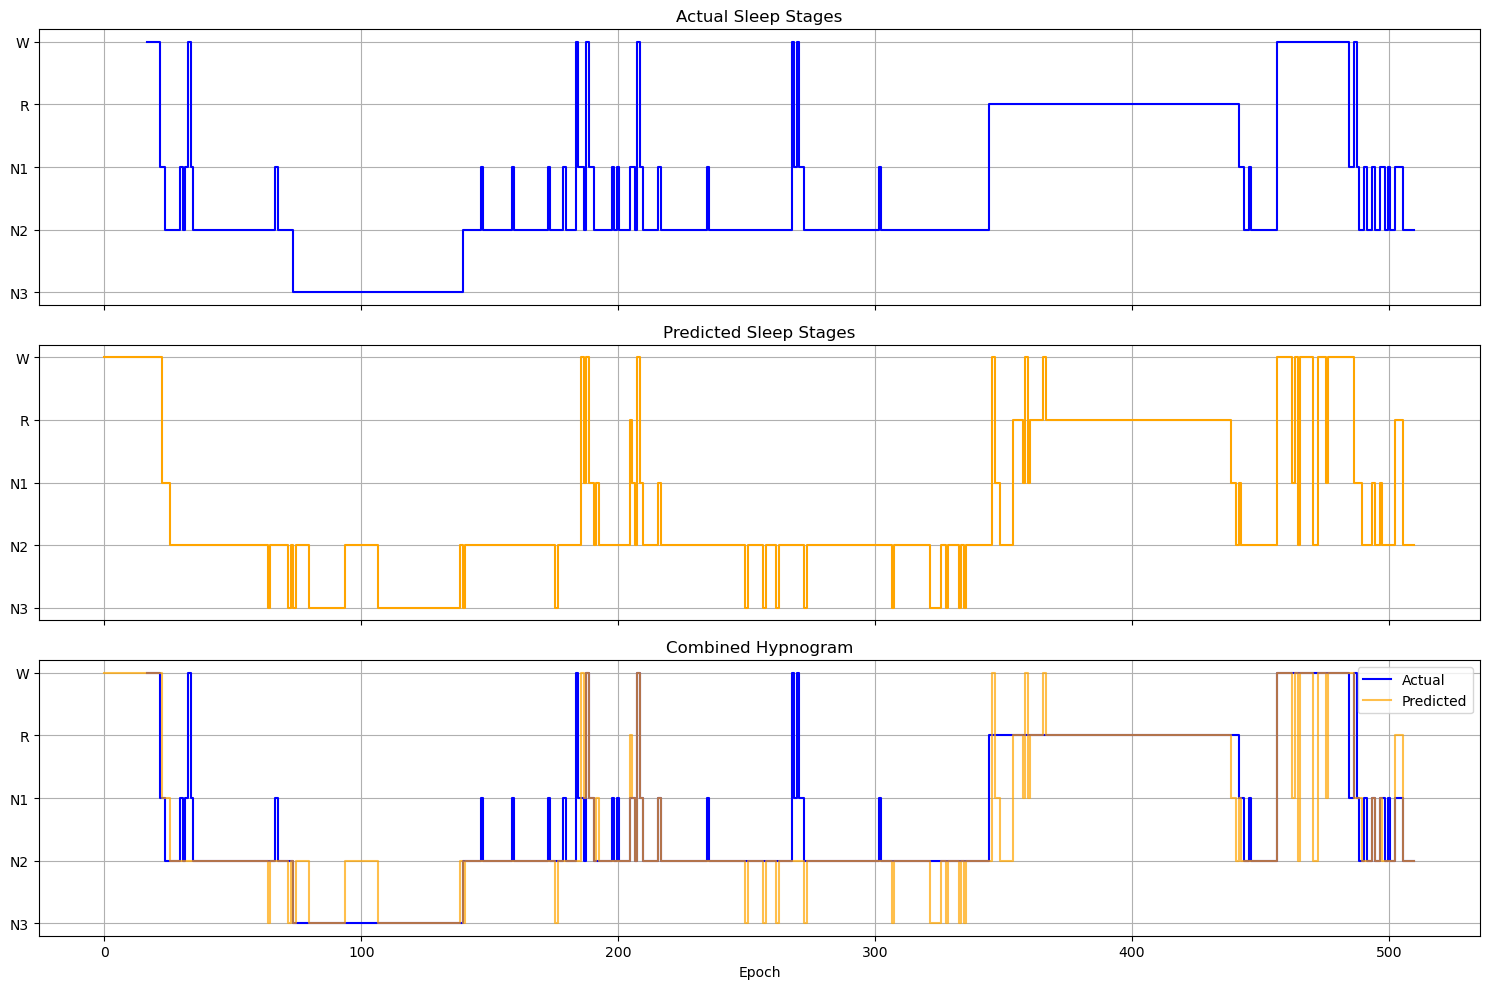

REVIEW [I0002150033265-1] Acc=0.77 F1=0.78 Kappa=0.65 Precision=0.67 Recall=0.73 Specificity=0.73 Score=0.73 


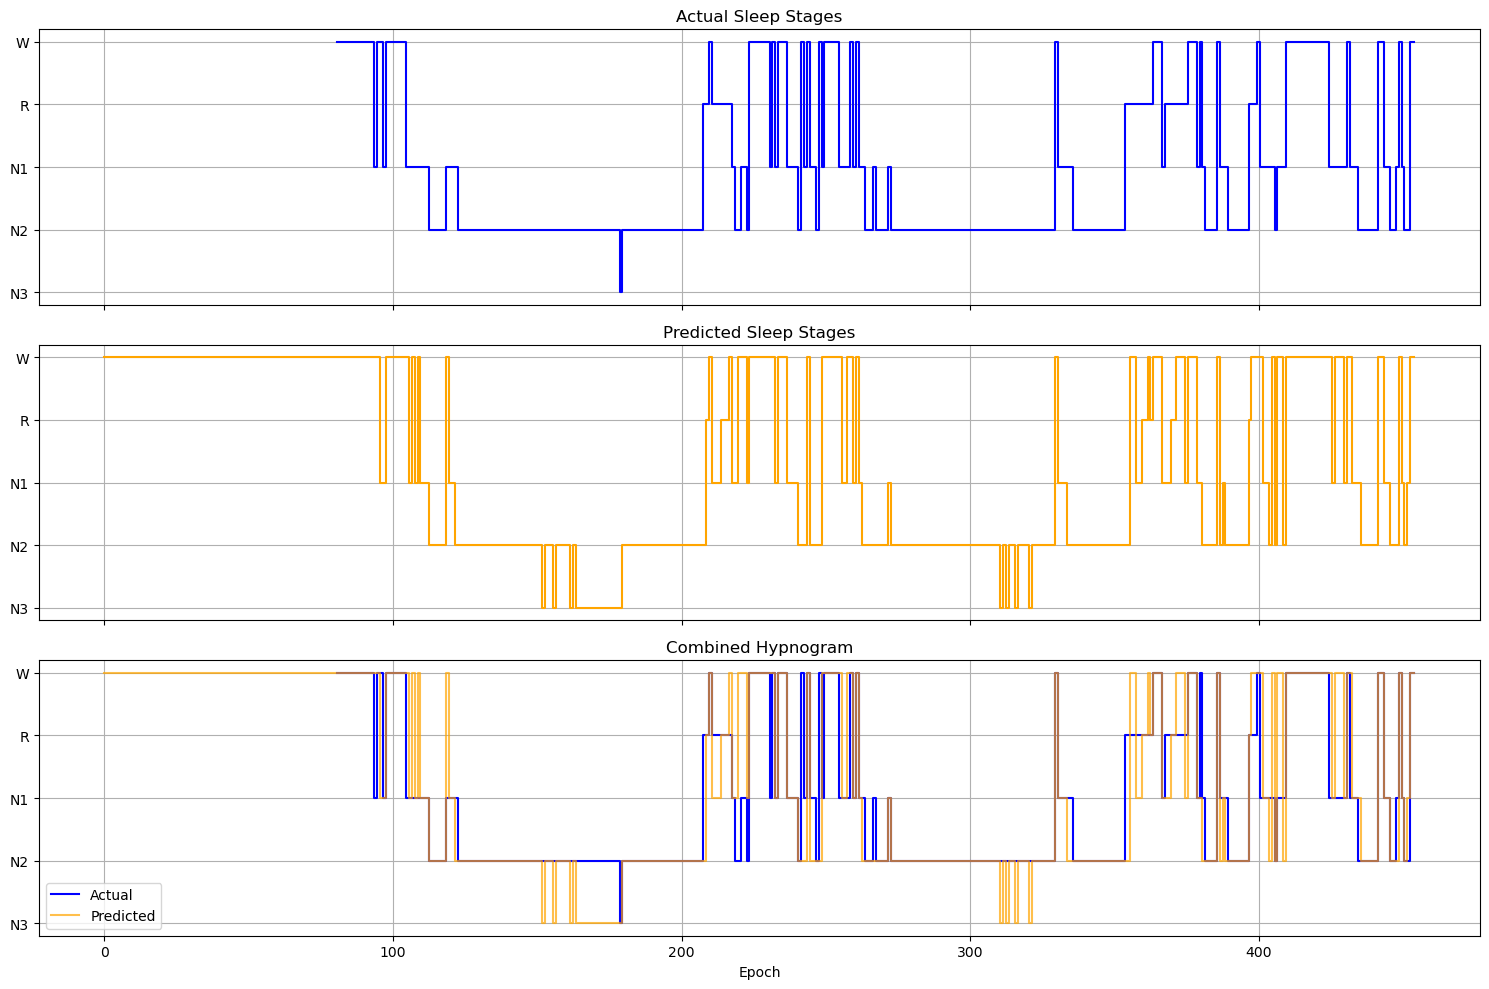

GOOD [I0002150033331-1] Acc=0.85 F1=0.83 Kappa=0.76 Precision=0.76 Recall=0.75 Specificity=0.75 Score=0.80 


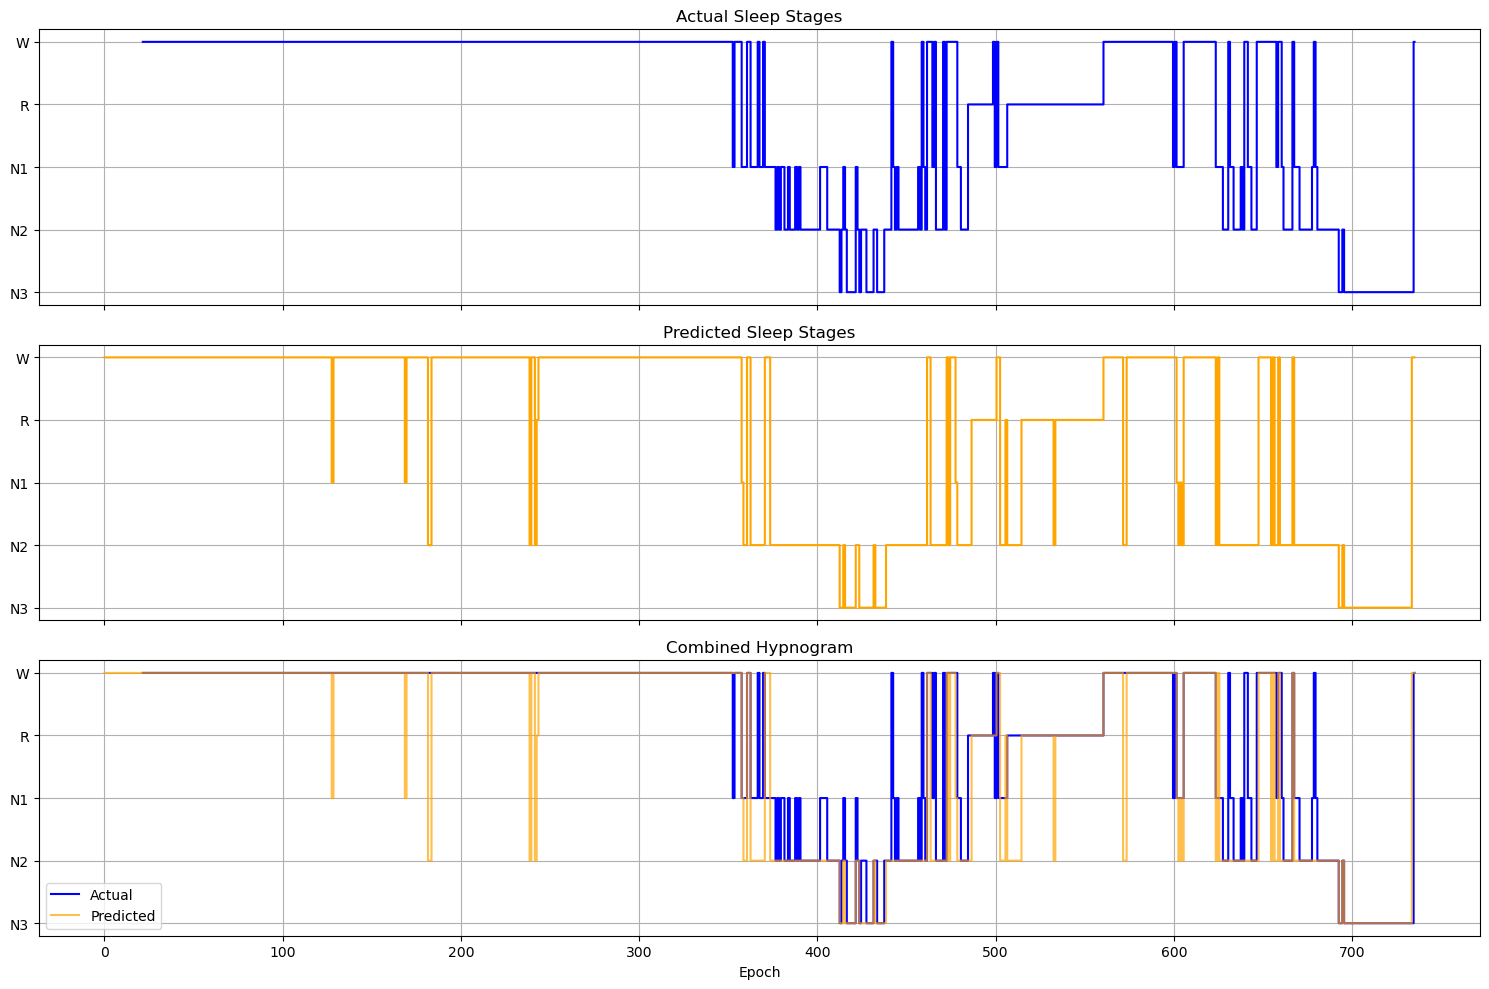

GOOD [I0002150033339-1] Acc=0.88 F1=0.88 Kappa=0.84 Precision=0.81 Recall=0.78 Specificity=0.78 Score=0.84 


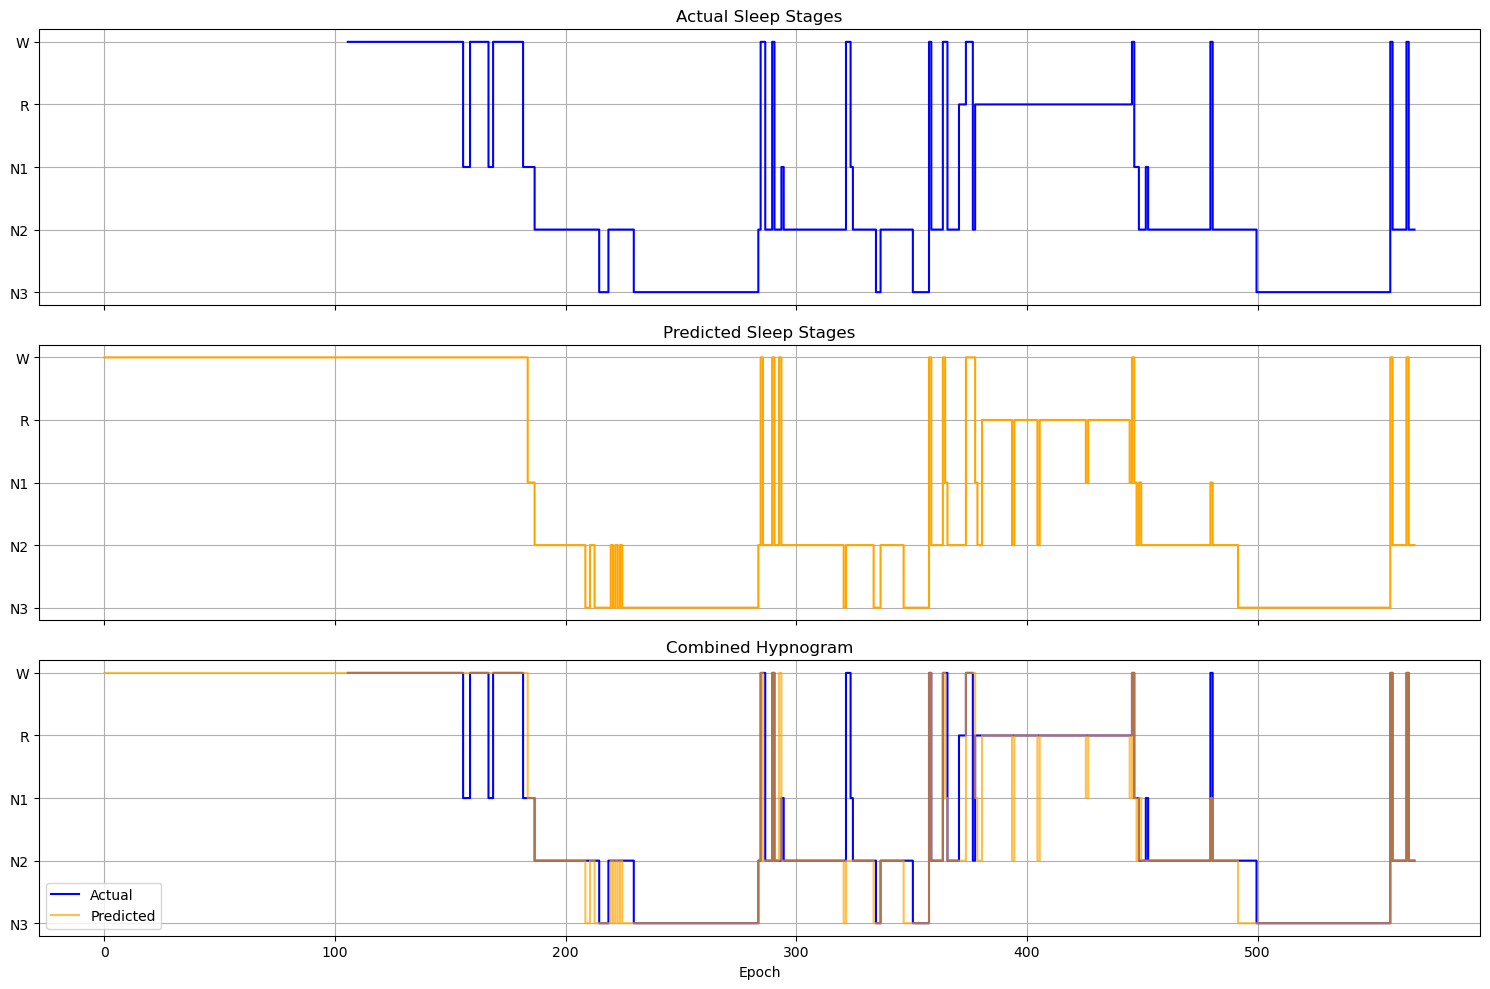

GOOD [I0002150033353-2] Acc=0.80 F1=0.85 Kappa=0.72 Precision=0.67 Recall=0.83 Specificity=0.83 Score=0.78 


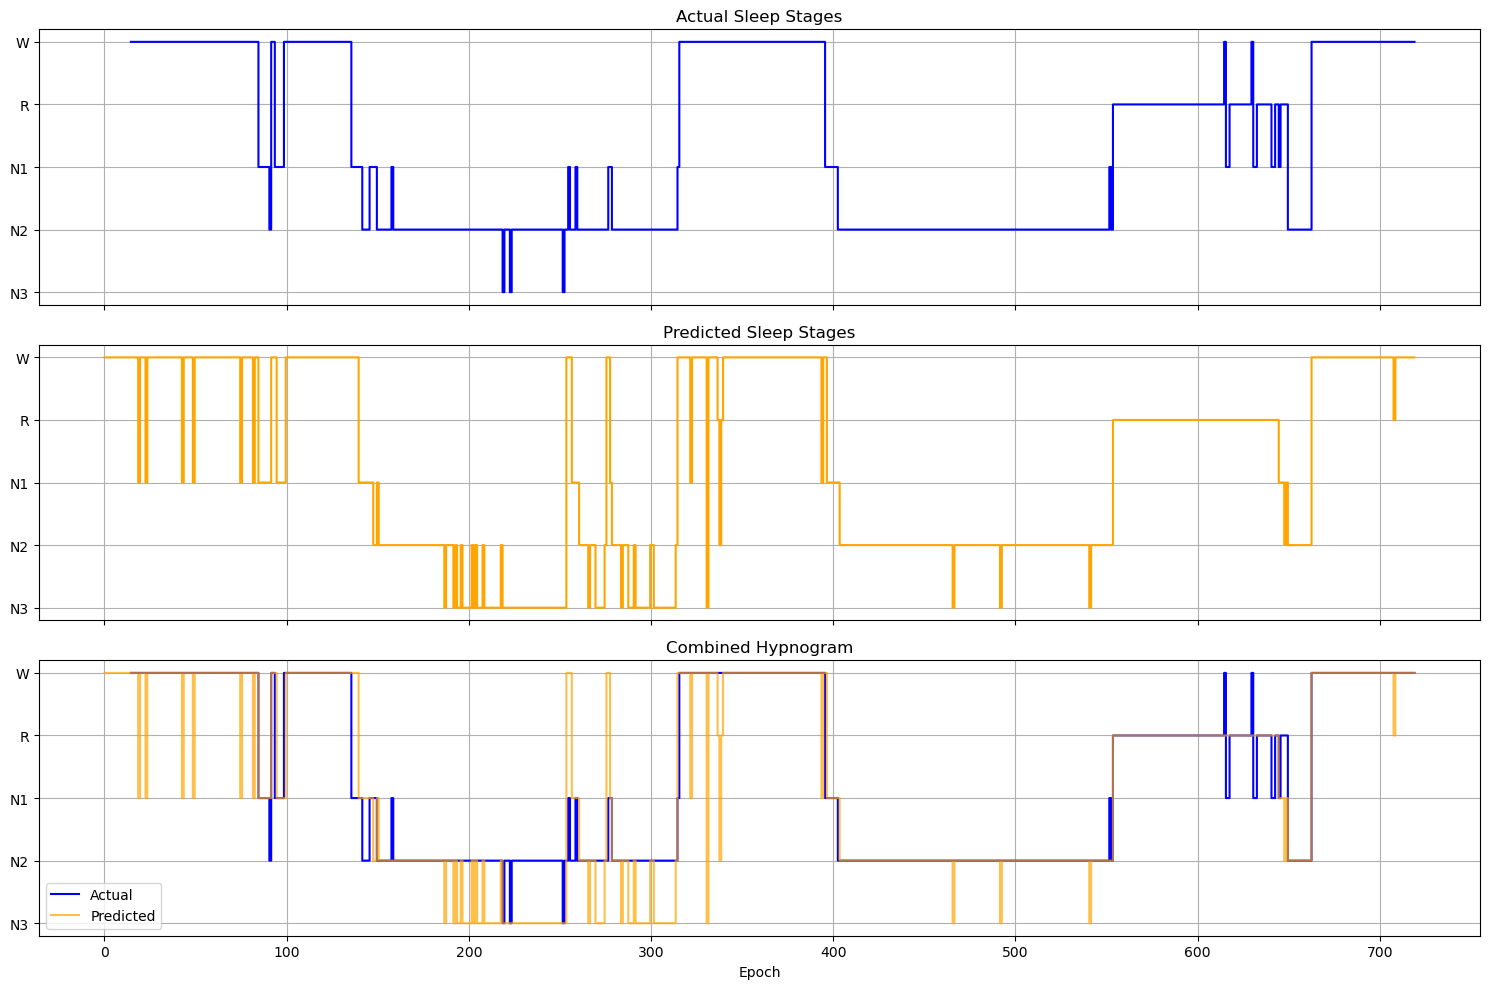

GOOD [I0002150033393-1] Acc=0.82 F1=0.82 Kappa=0.76 Precision=0.78 Recall=0.78 Specificity=0.78 Score=0.79 


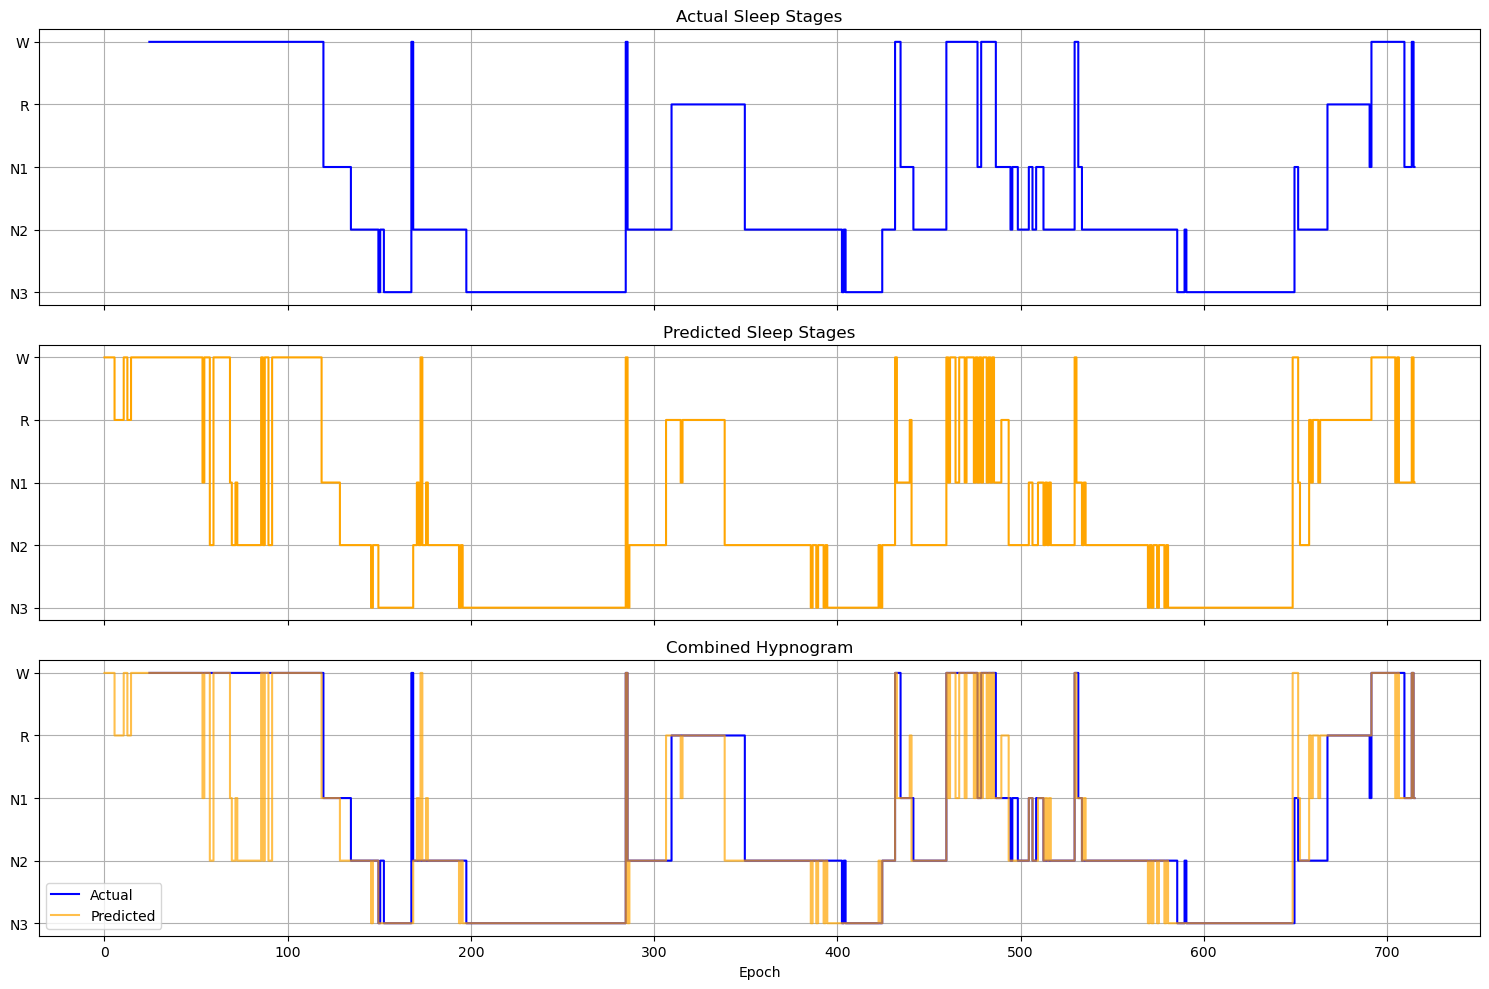

REVIEW [I0002150033394-1] Acc=0.68 F1=0.72 Kappa=0.53 Precision=0.64 Recall=0.76 Specificity=0.76 Score=0.67 


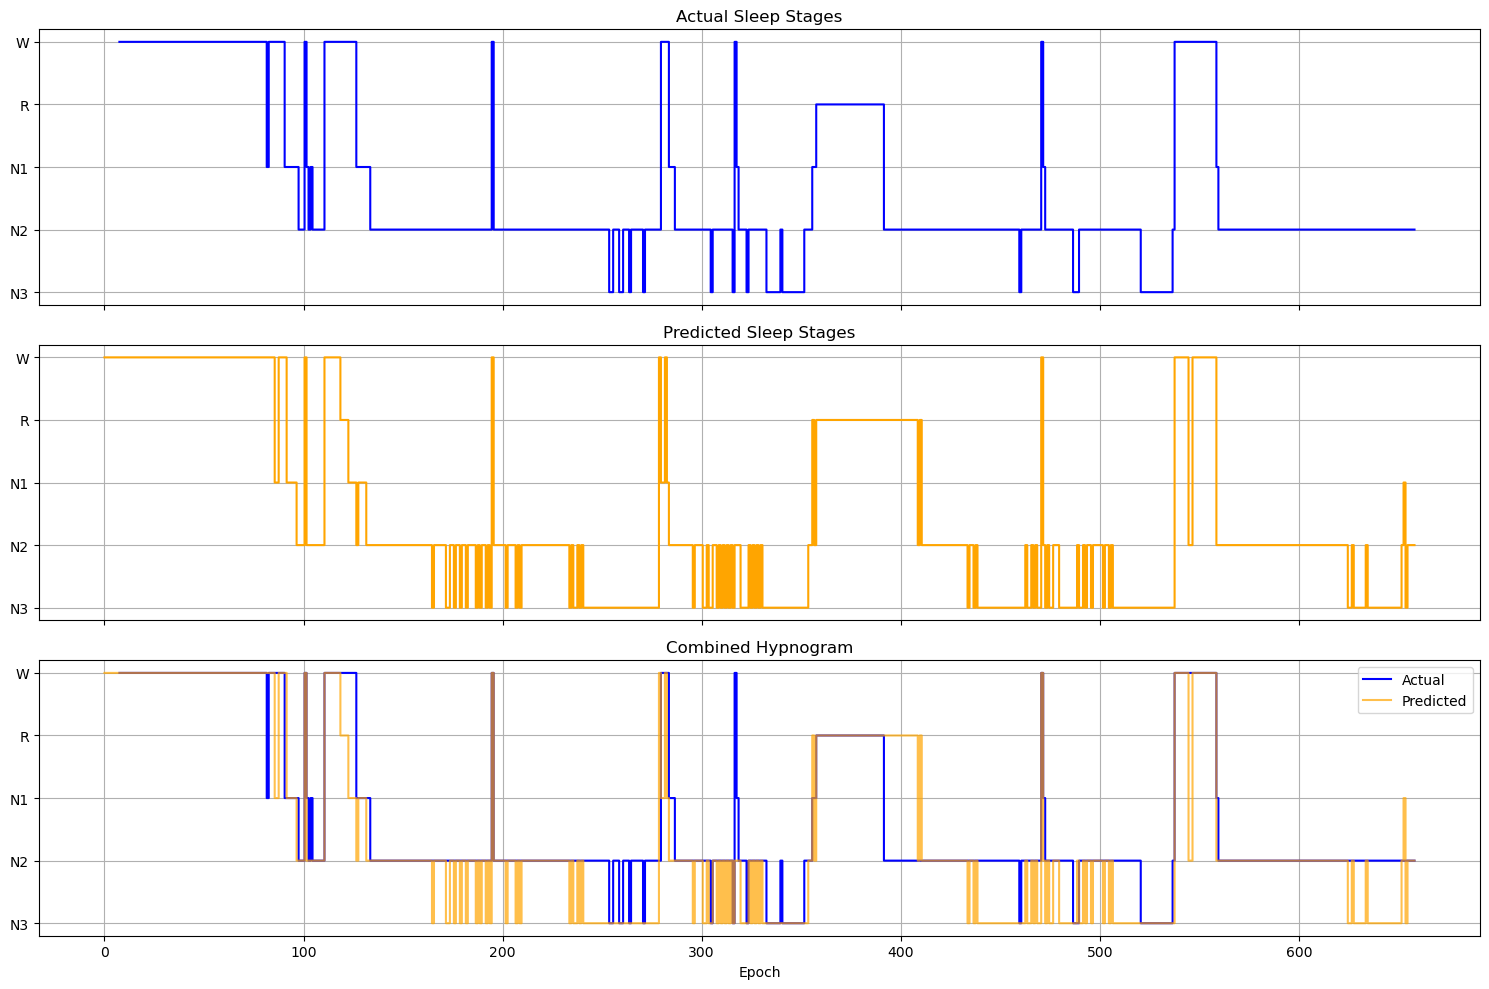

REVIEW [I0002150033474-1] Acc=0.68 F1=0.73 Kappa=0.56 Precision=0.61 Recall=0.67 Specificity=0.67 Score=0.65 


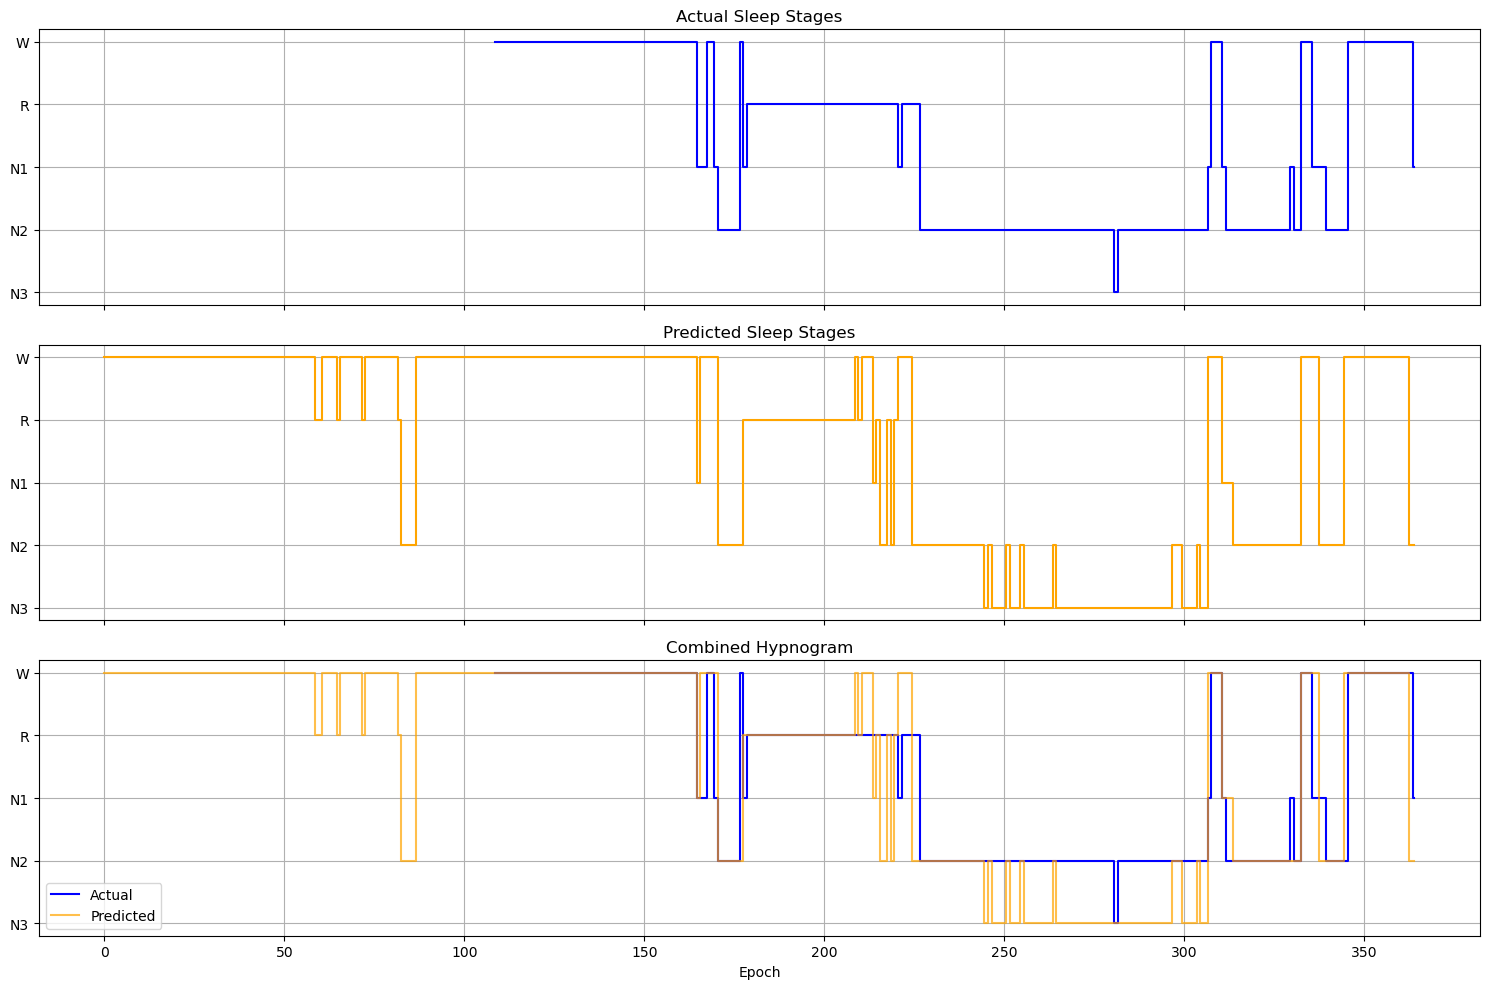

REVIEW [I0002150033484-1] Acc=0.84 F1=0.84 Kappa=0.73 Precision=0.57 Recall=0.63 Specificity=0.63 Score=0.74 


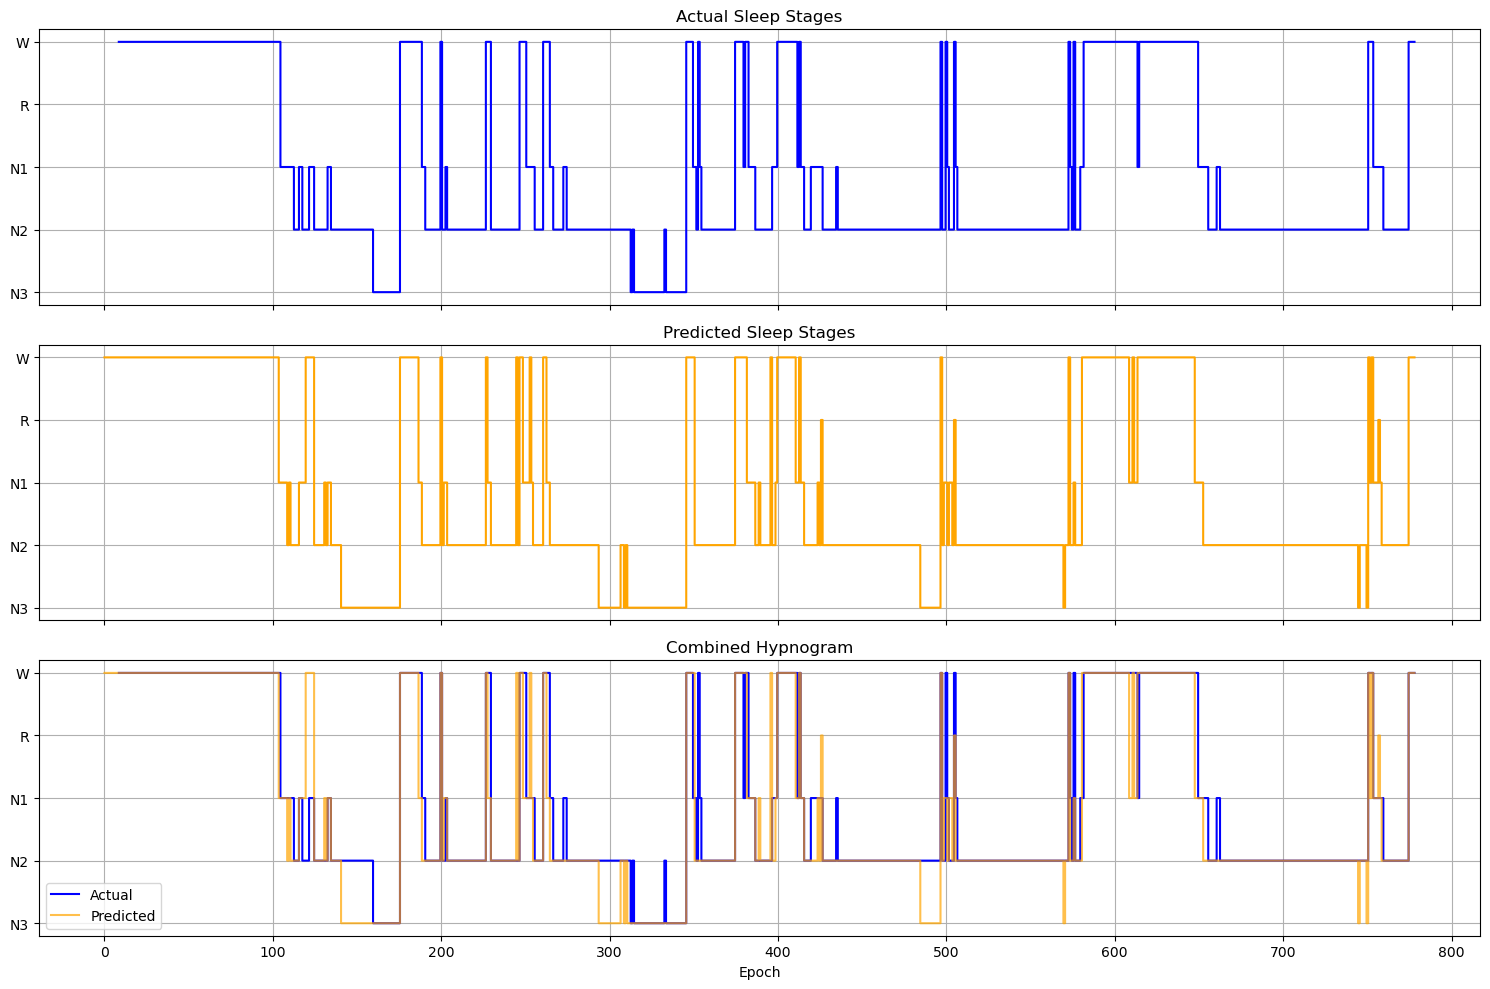

BAD [I0002150033507-1] Acc=0.67 F1=0.66 Kappa=0.44 Precision=0.45 Recall=0.43 Specificity=0.43 Score=0.54 


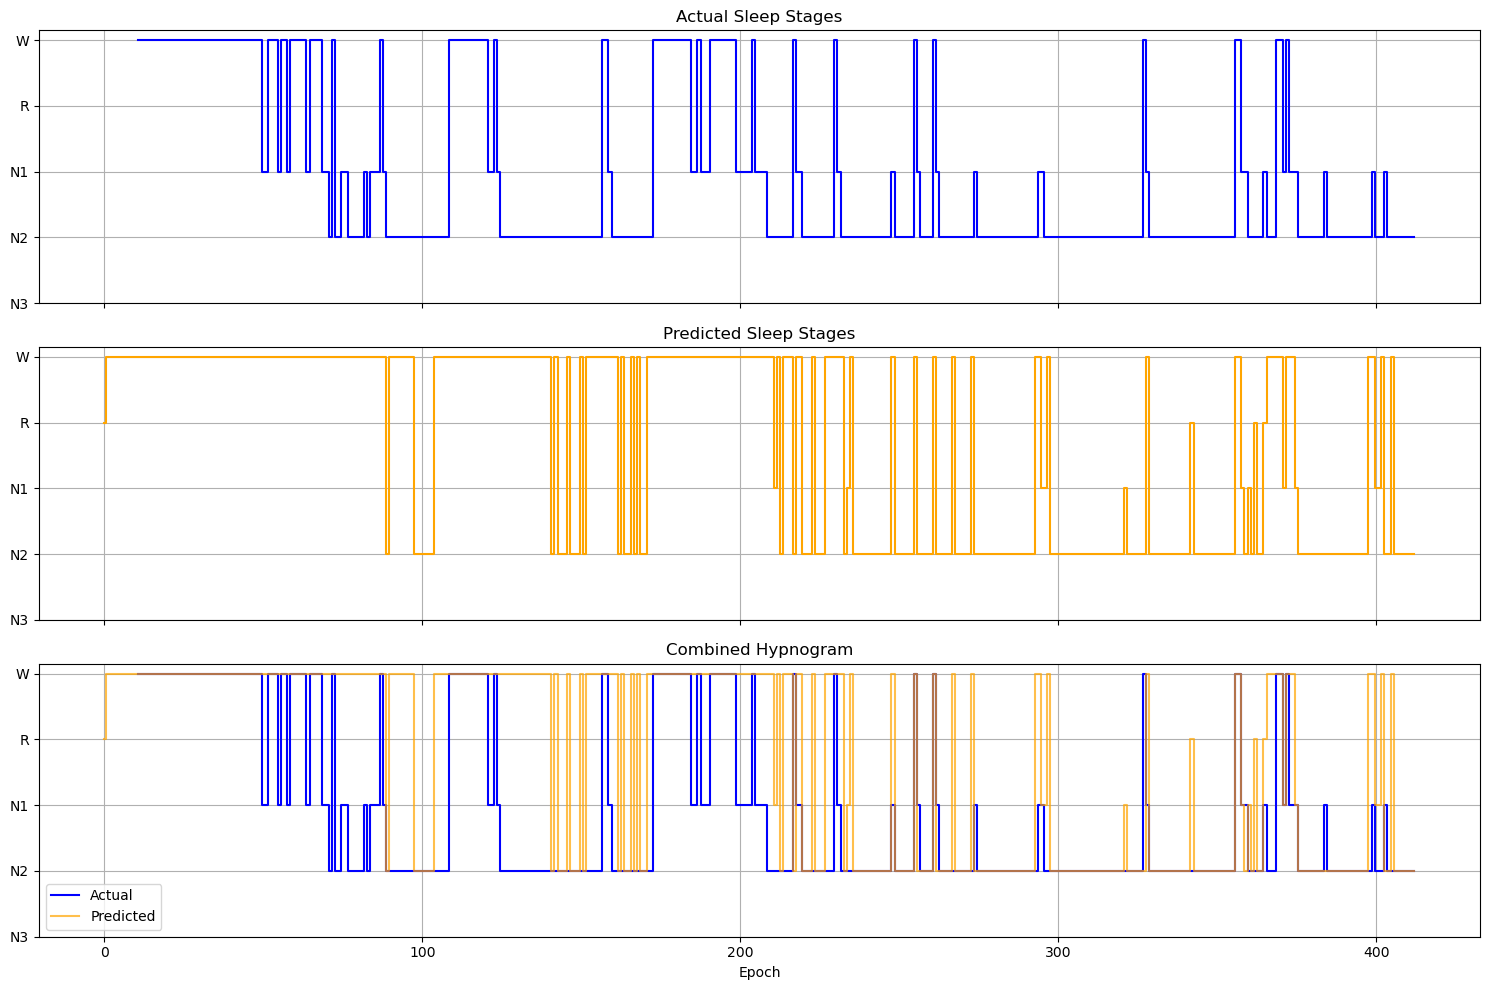

GOOD [I0002150033566-1] Acc=0.87 F1=0.86 Kappa=0.82 Precision=0.72 Recall=0.72 Specificity=0.72 Score=0.81 


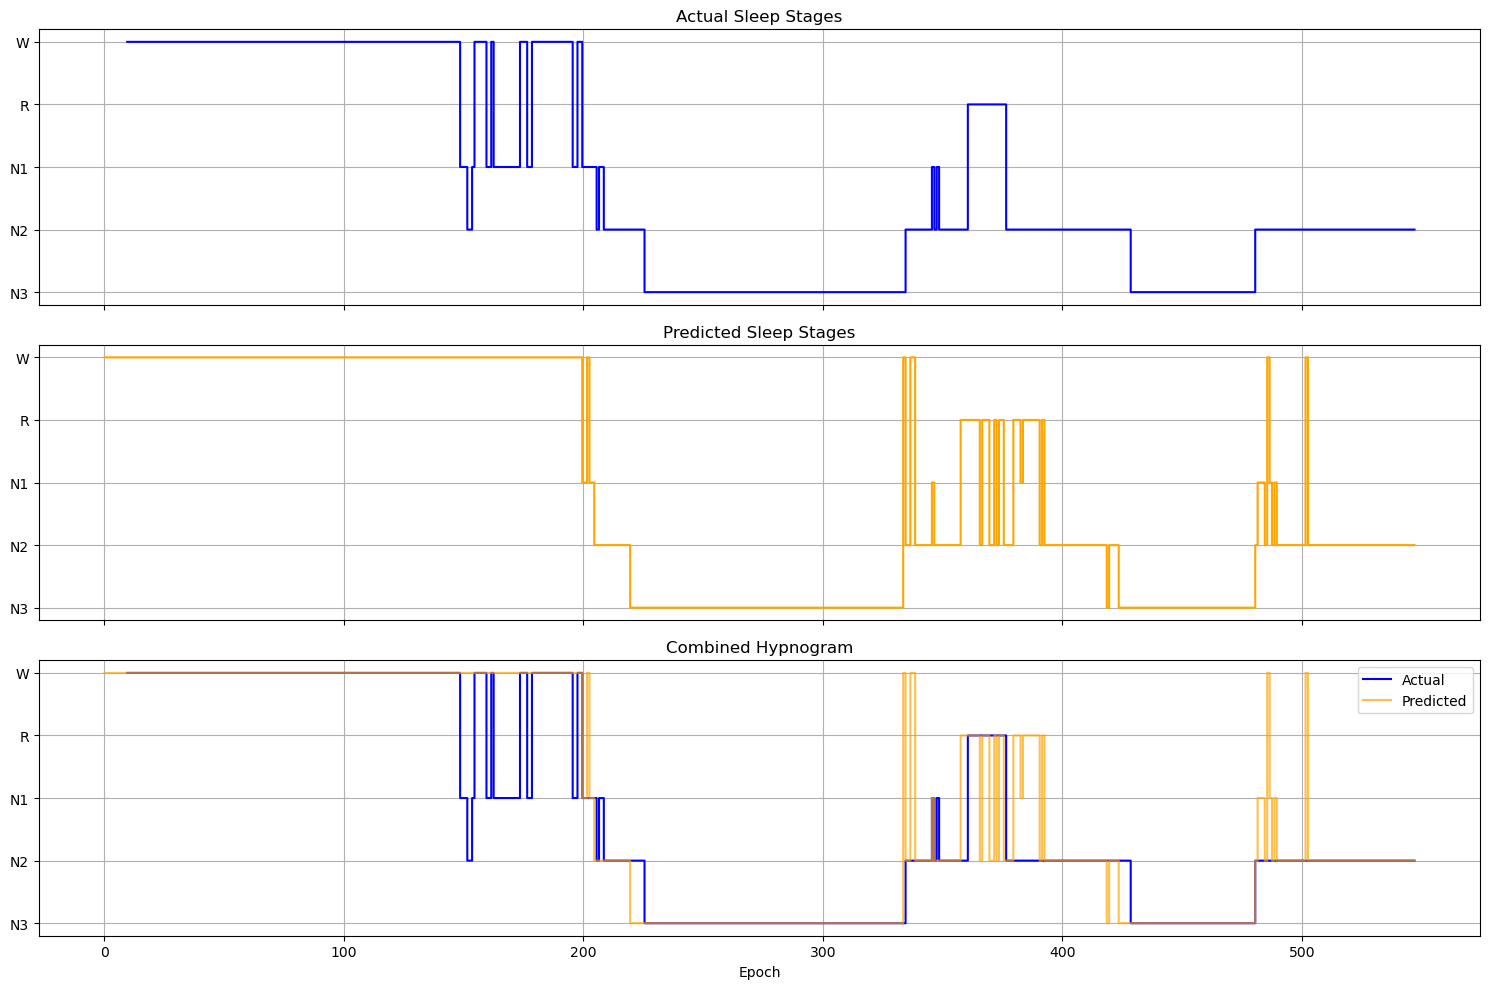

GOOD [I0002150033576-1] Acc=0.93 F1=0.93 Kappa=0.89 Precision=0.88 Recall=0.87 Specificity=0.87 Score=0.90 


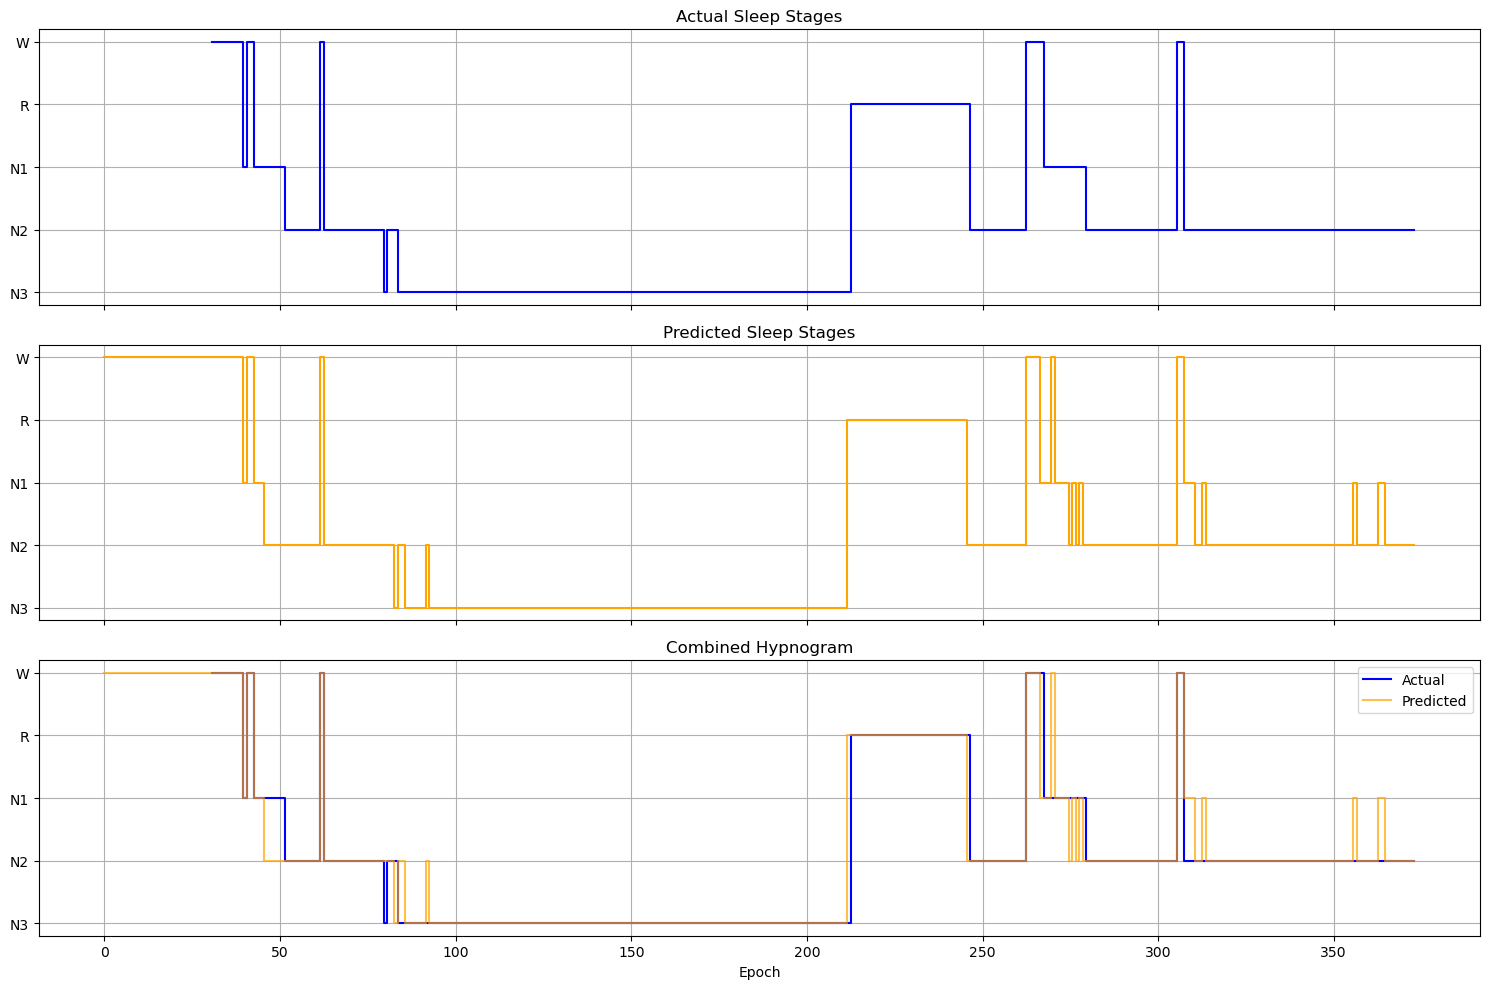

REVIEW [I0002150033587-1] Acc=0.72 F1=0.73 Kappa=0.60 Precision=0.63 Recall=0.56 Specificity=0.56 Score=0.65 


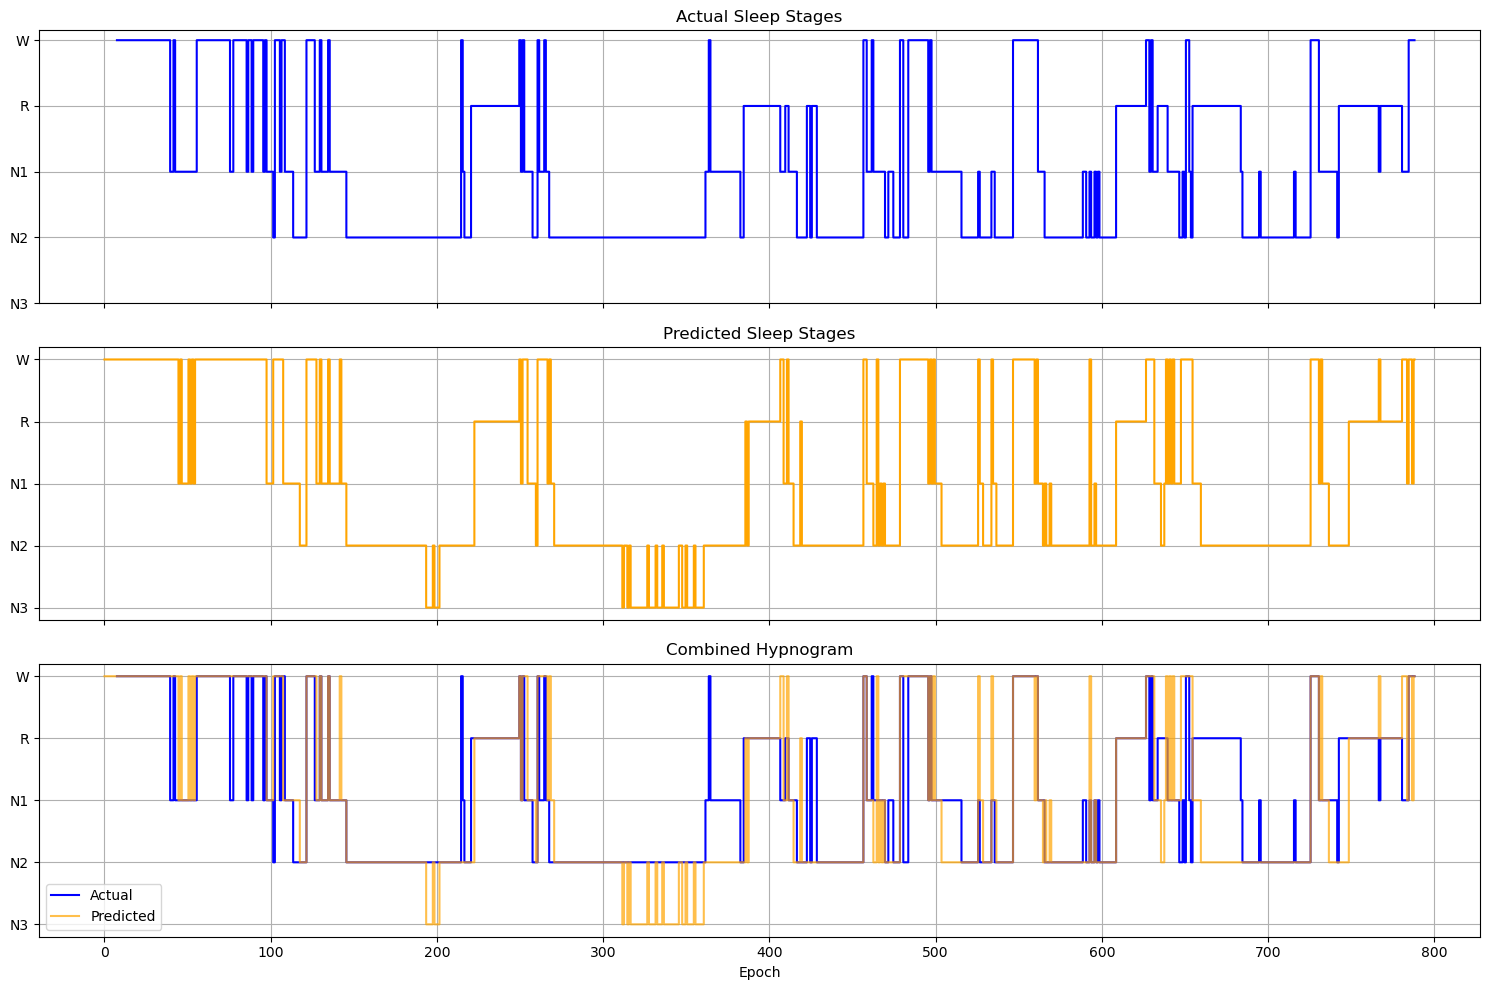

BAD [I0002150033657-2] Acc=0.66 F1=0.71 Kappa=0.48 Precision=0.56 Recall=0.58 Specificity=0.58 Score=0.60 


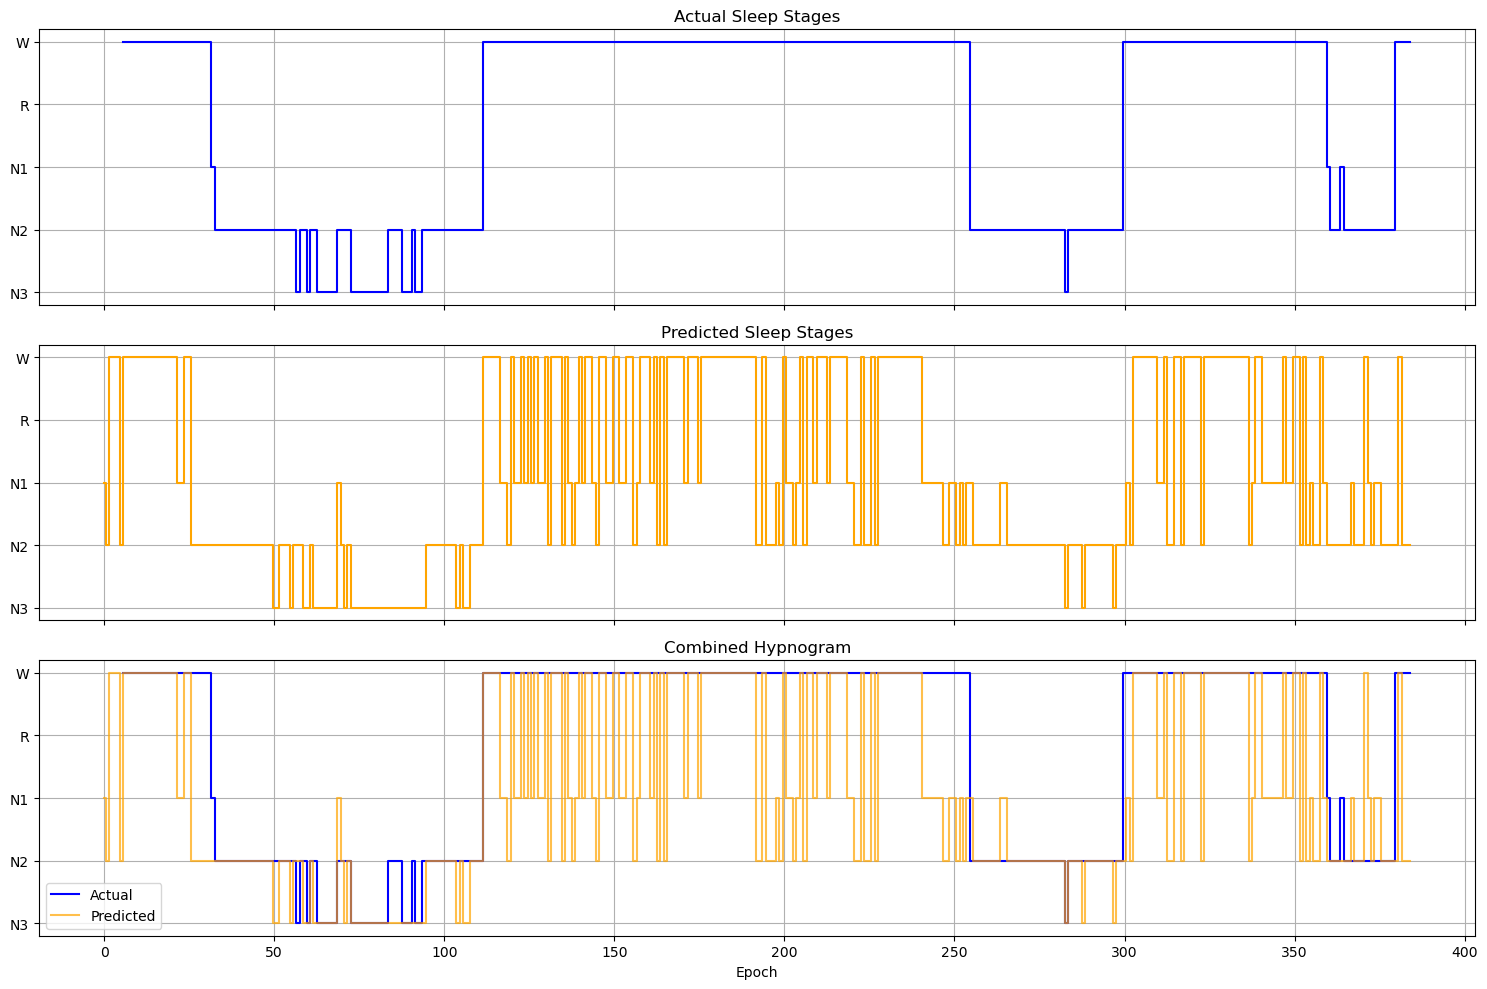

GOOD [I0002150033670-1] Acc=0.84 F1=0.83 Kappa=0.77 Precision=0.79 Recall=0.76 Specificity=0.76 Score=0.80 


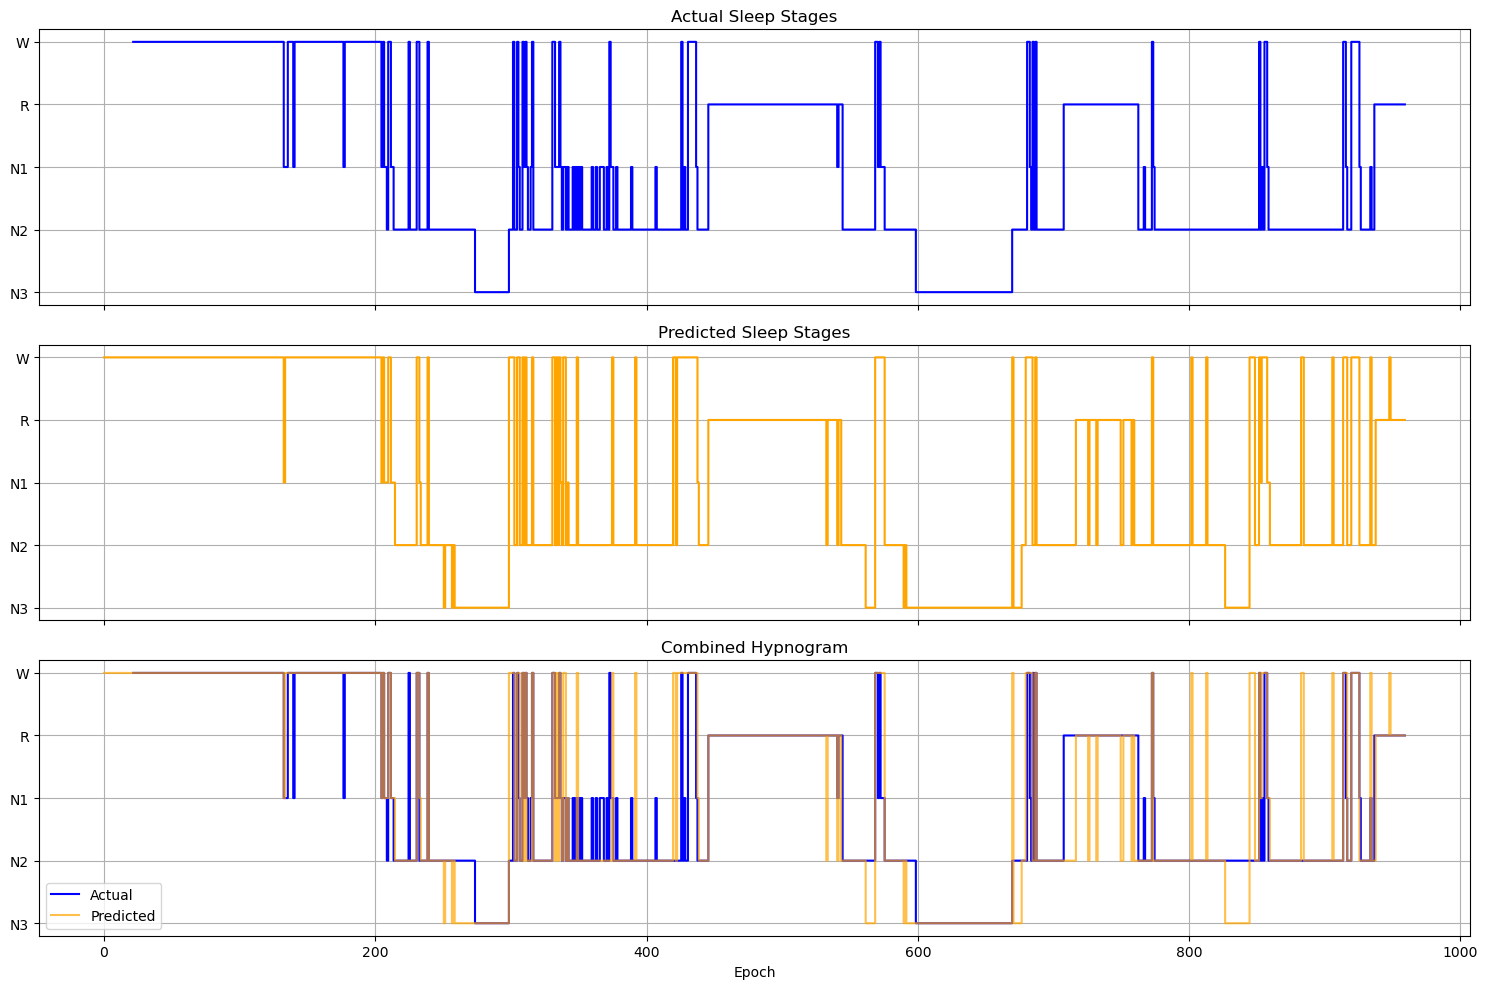

BAD [I0002150033708-2] Acc=0.70 F1=0.67 Kappa=0.45 Precision=0.56 Recall=0.48 Specificity=0.48 Score=0.58 


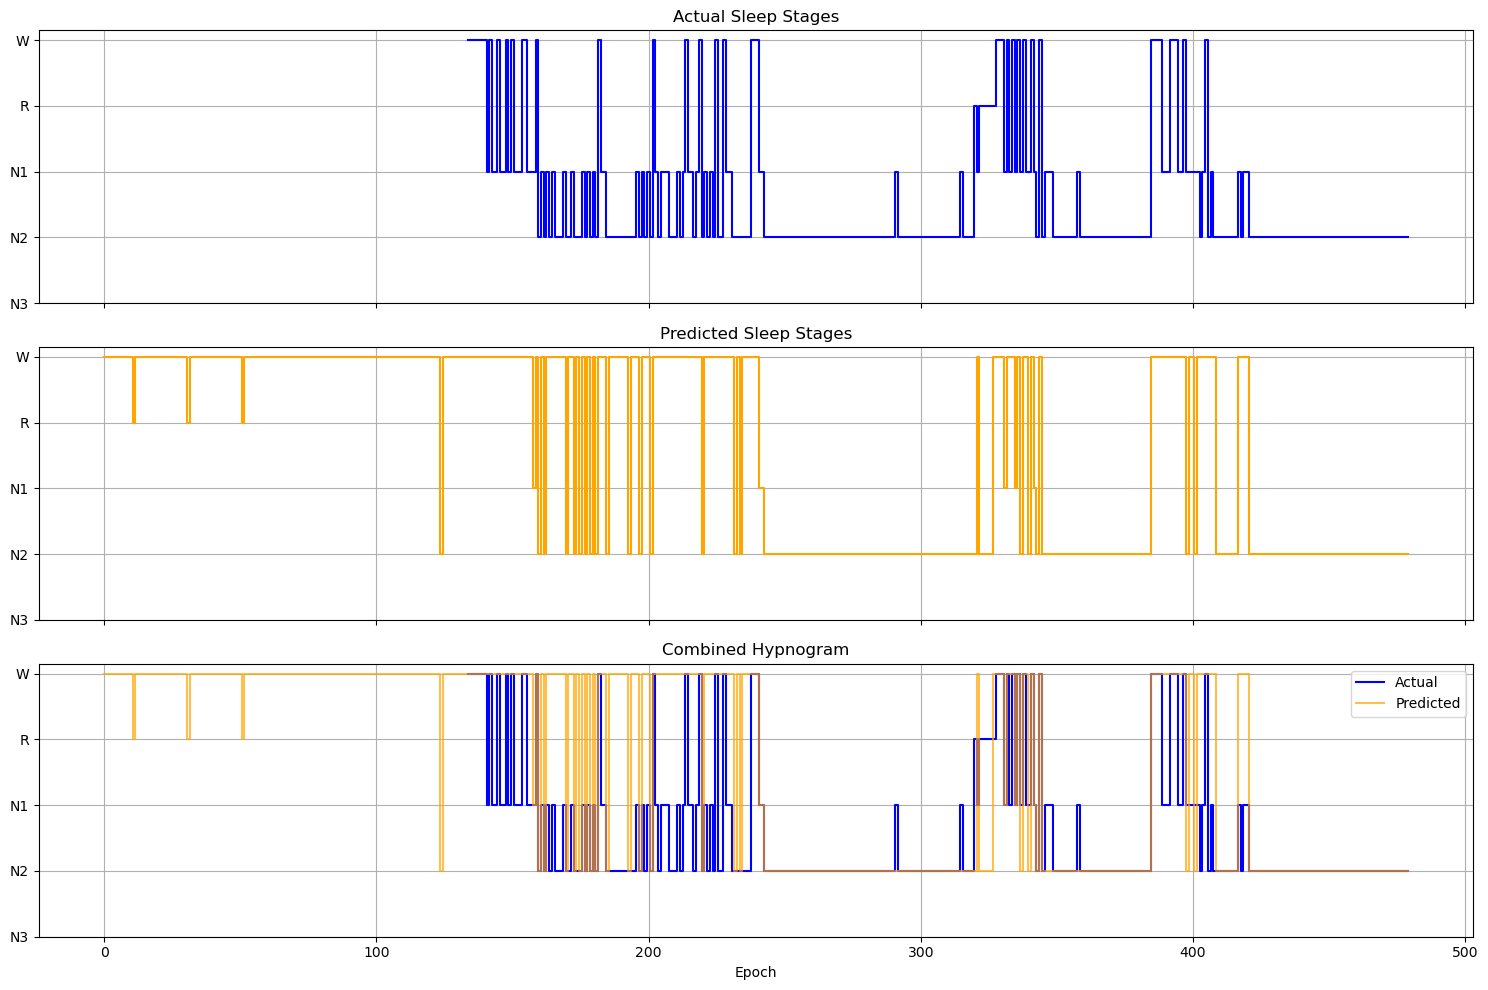

GOOD [I0002150033786-1] Acc=0.83 F1=0.82 Kappa=0.76 Precision=0.74 Recall=0.74 Specificity=0.74 Score=0.78 


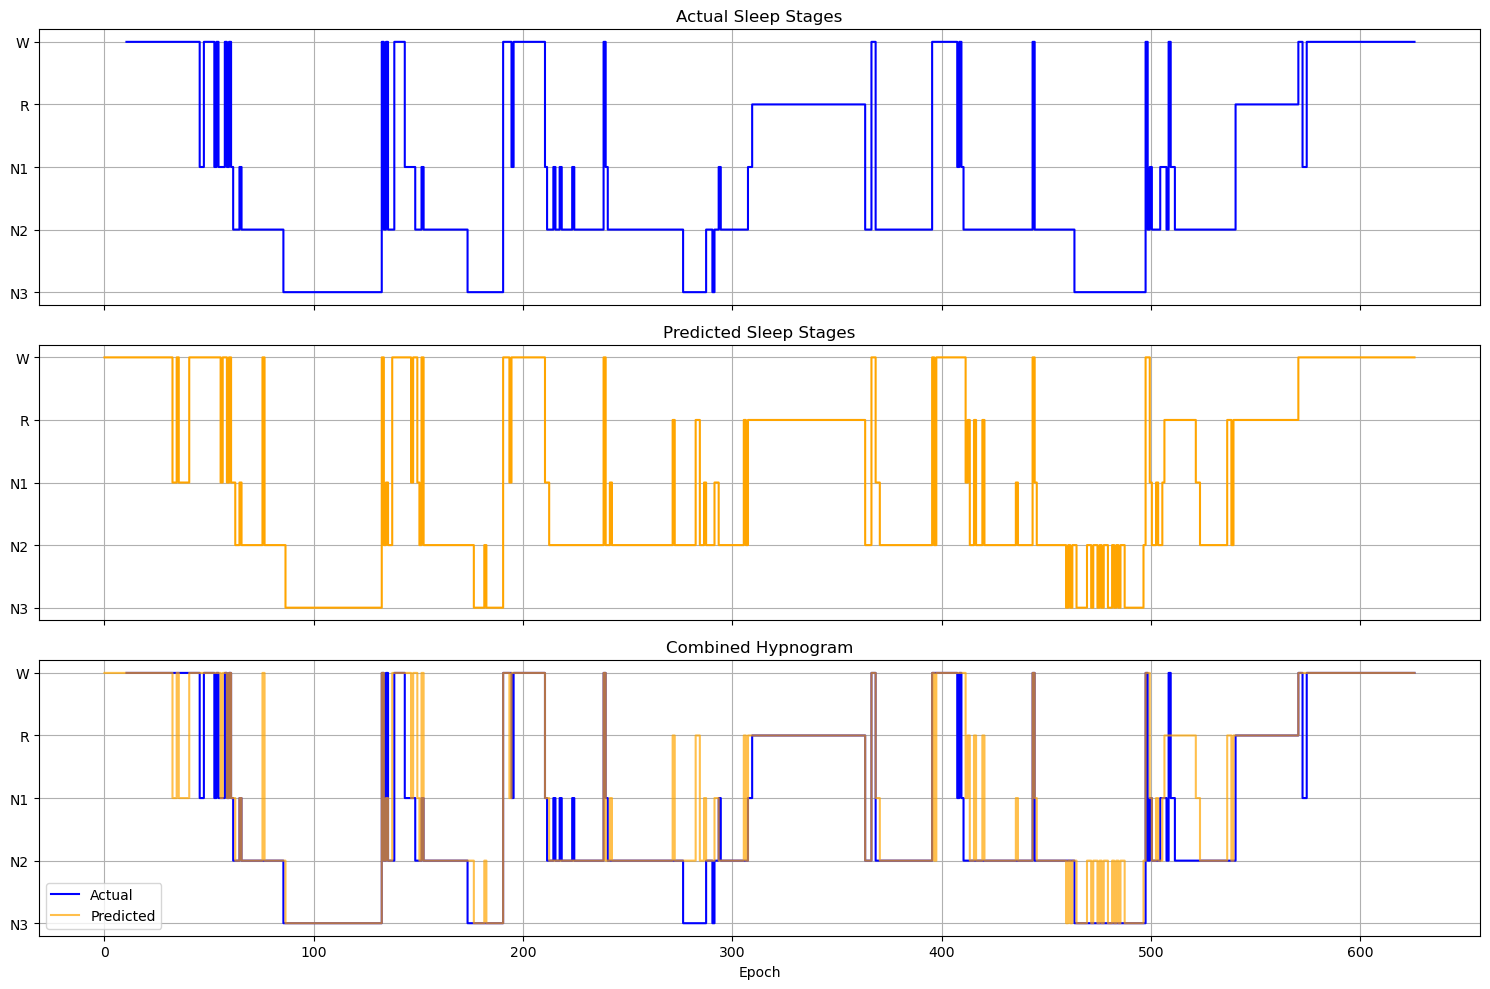

GOOD [I0002150033858-1] Acc=0.85 F1=0.86 Kappa=0.78 Precision=0.74 Recall=0.81 Specificity=0.81 Score=0.81 


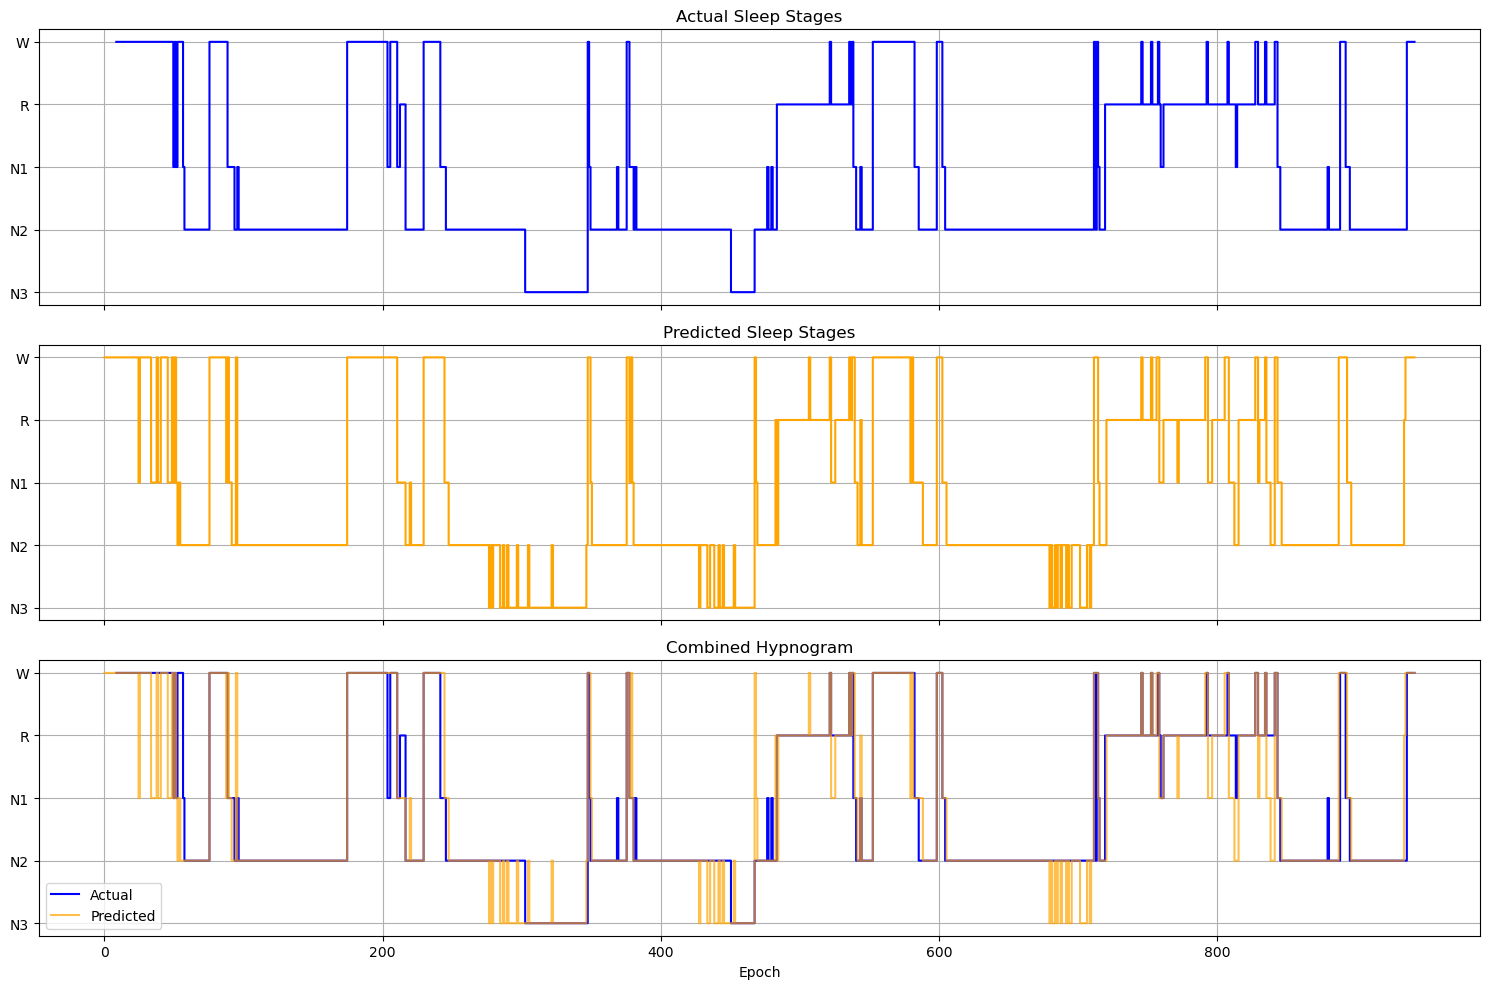

REVIEW [I0002150033862-1] Acc=0.76 F1=0.75 Kappa=0.62 Precision=0.61 Recall=0.77 Specificity=0.77 Score=0.71 


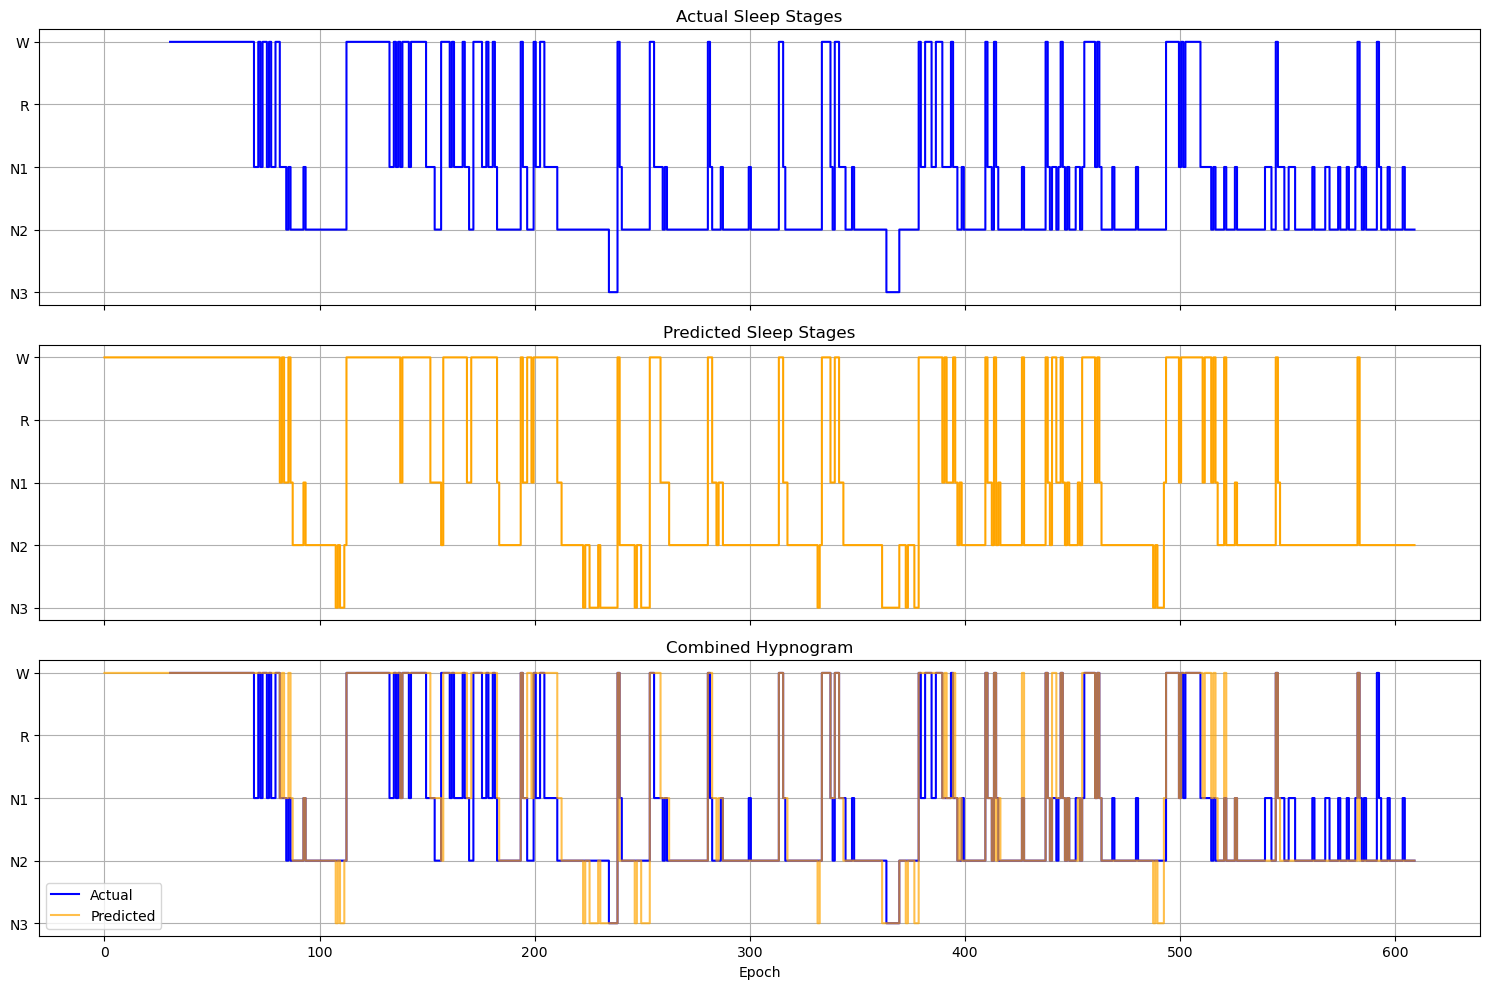

GOOD [I0002150033980-1] Acc=0.83 F1=0.83 Kappa=0.75 Precision=0.76 Recall=0.83 Specificity=0.83 Score=0.80 


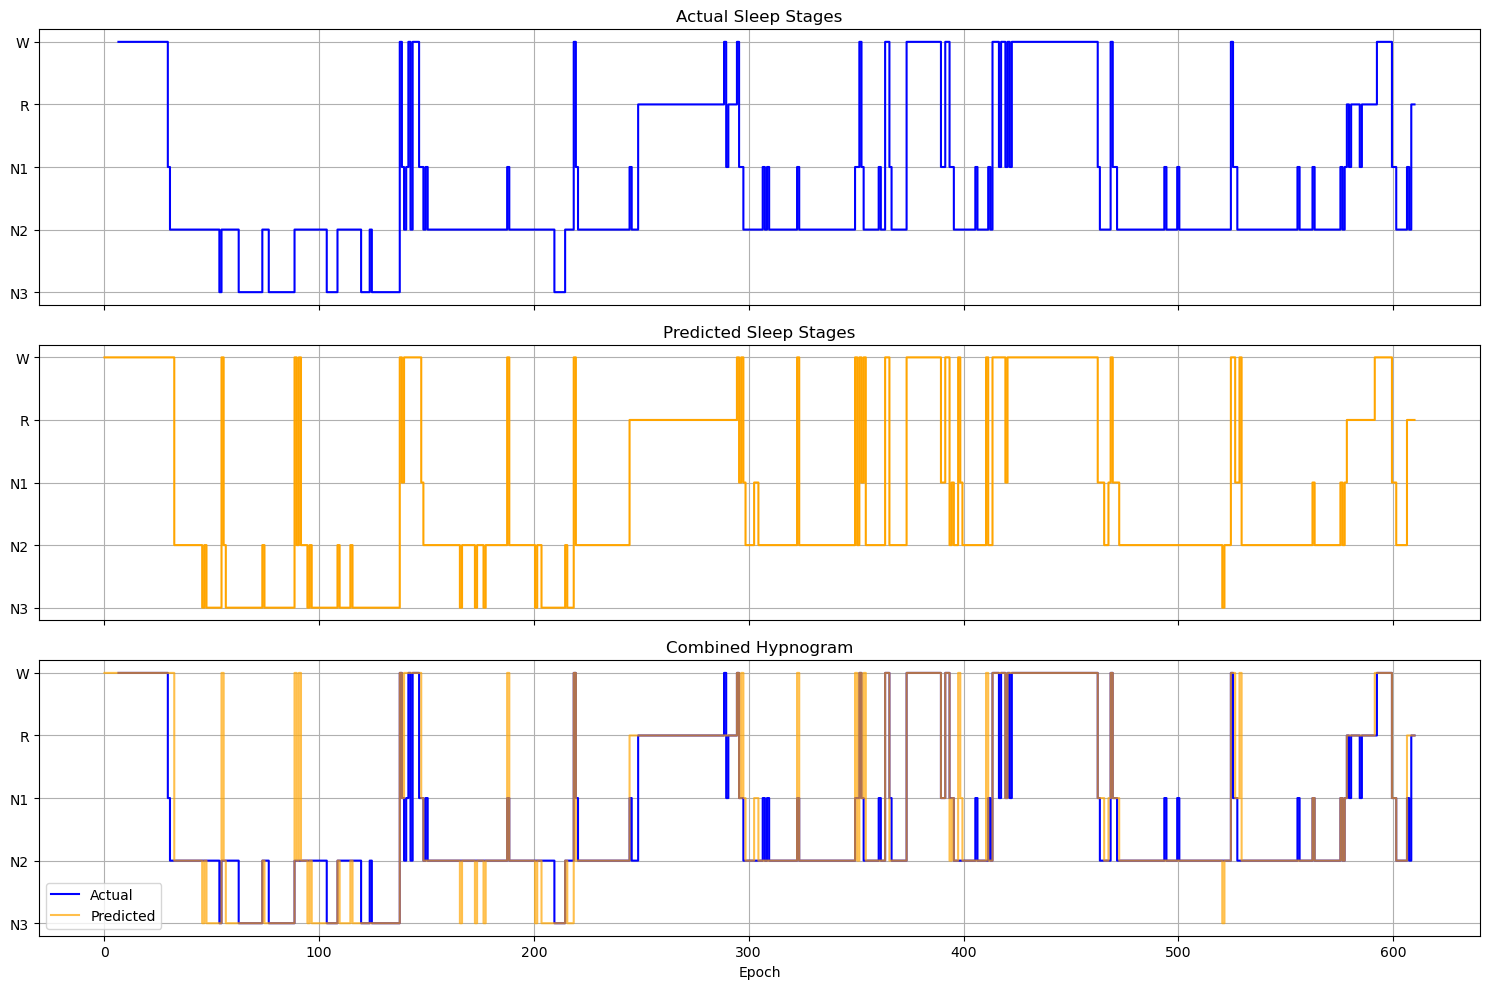

REVIEW [I0002150033984-1] Acc=0.82 F1=0.83 Kappa=0.71 Precision=0.64 Recall=0.70 Specificity=0.70 Score=0.75 


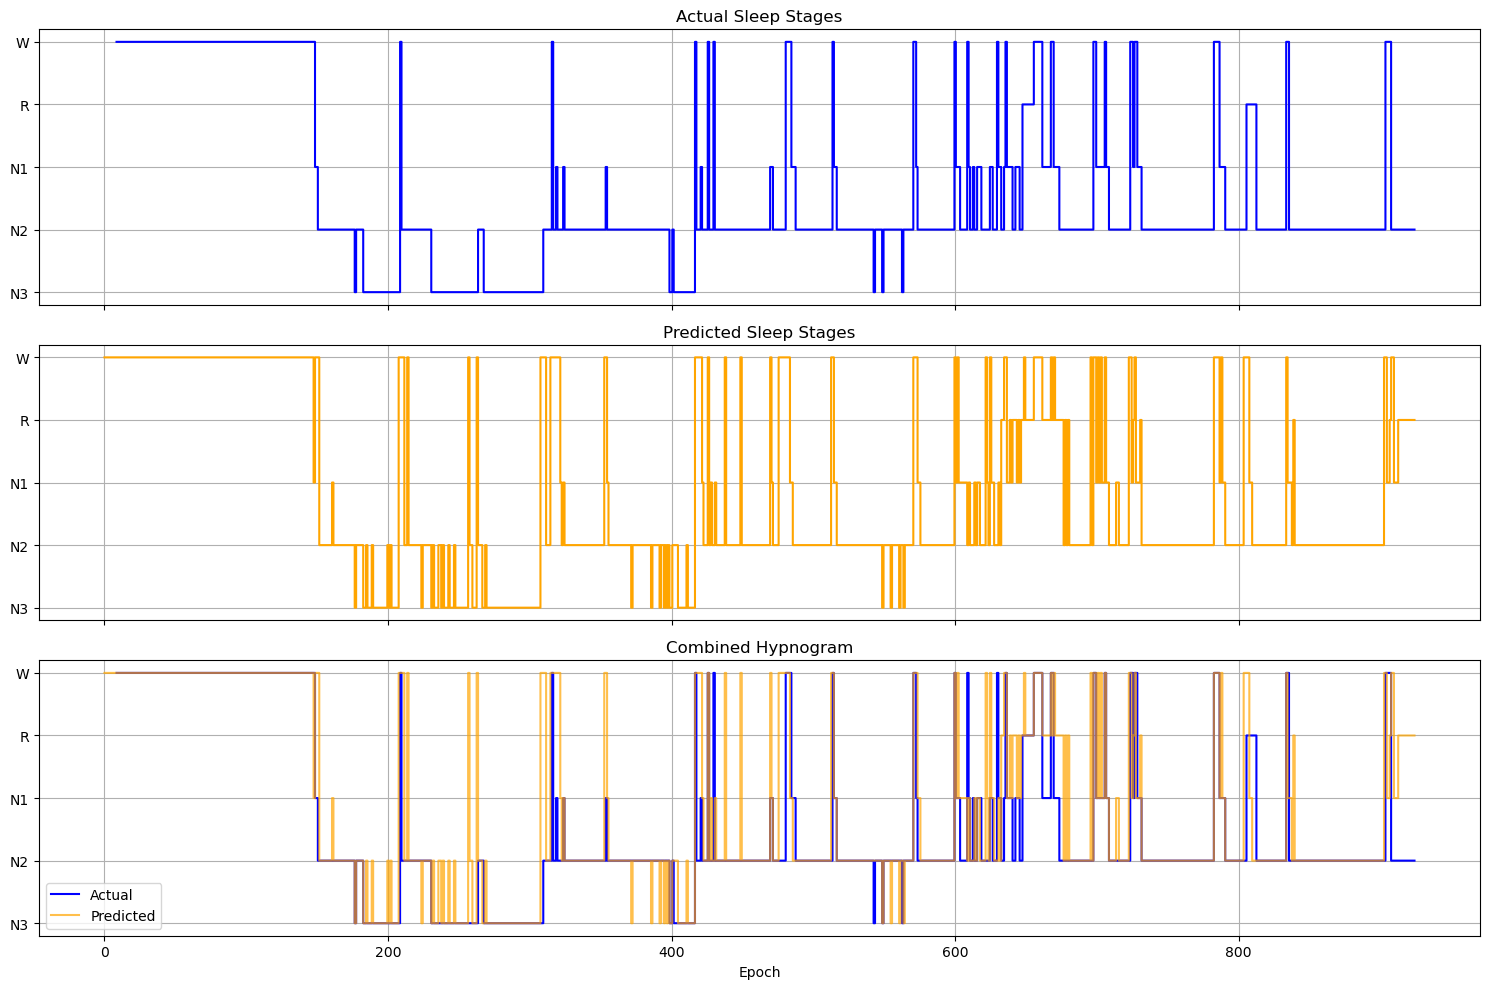

GOOD [I0002150034072-1] Acc=0.80 F1=0.80 Kappa=0.72 Precision=0.70 Recall=0.74 Specificity=0.74 Score=0.76 


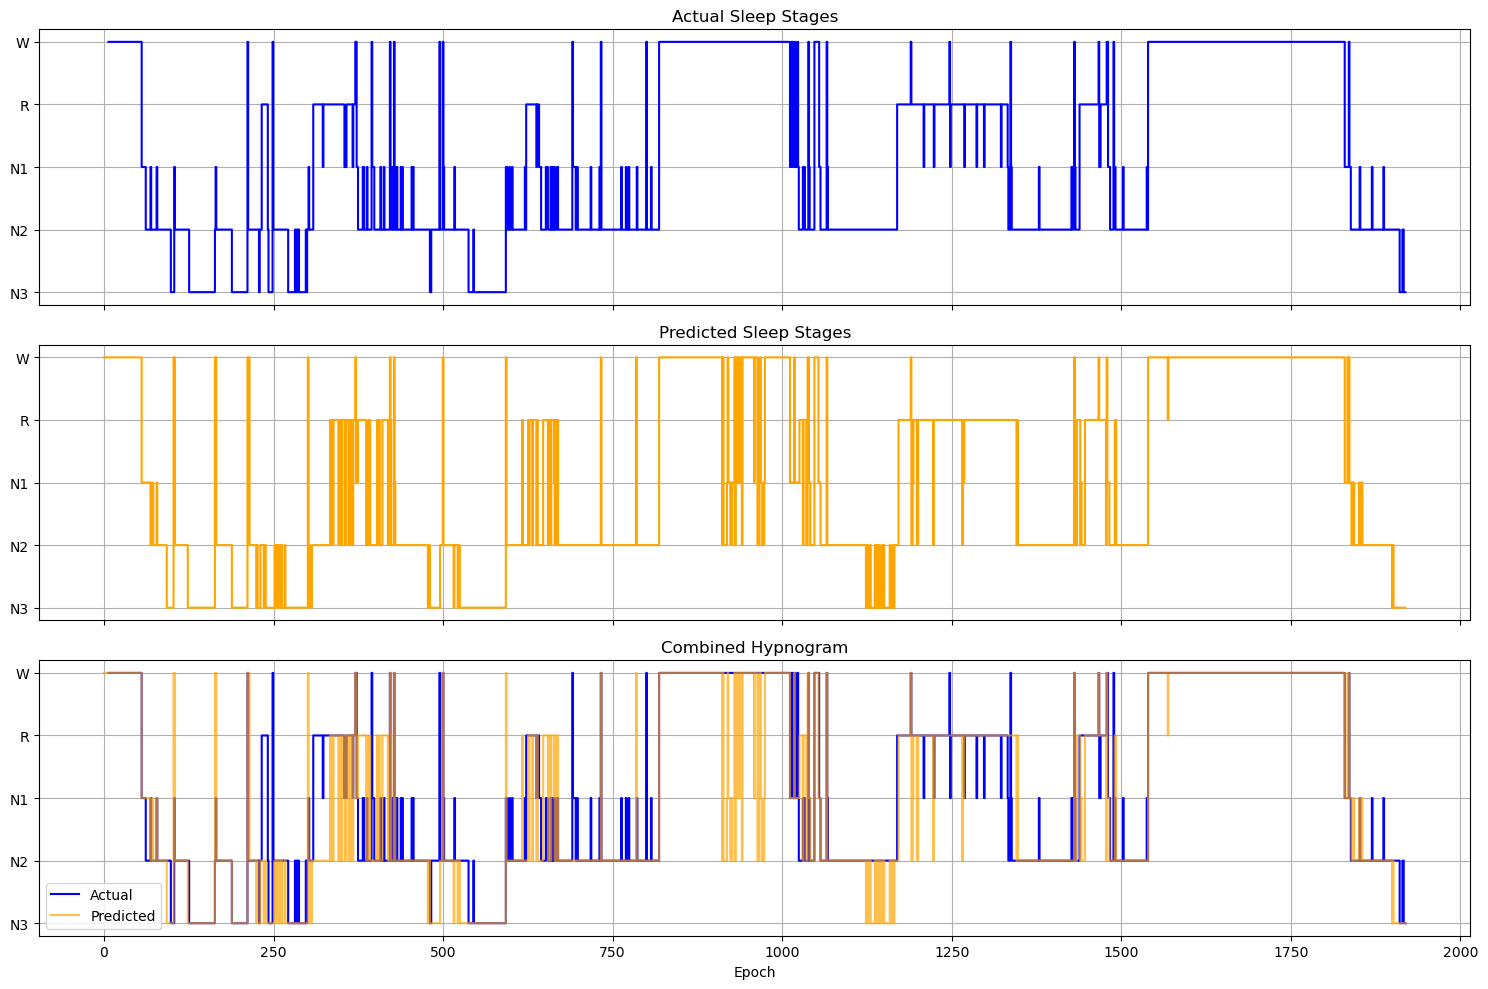

GOOD [I0002150034084-2] Acc=0.84 F1=0.84 Kappa=0.79 Precision=0.80 Recall=0.83 Specificity=0.83 Score=0.82 


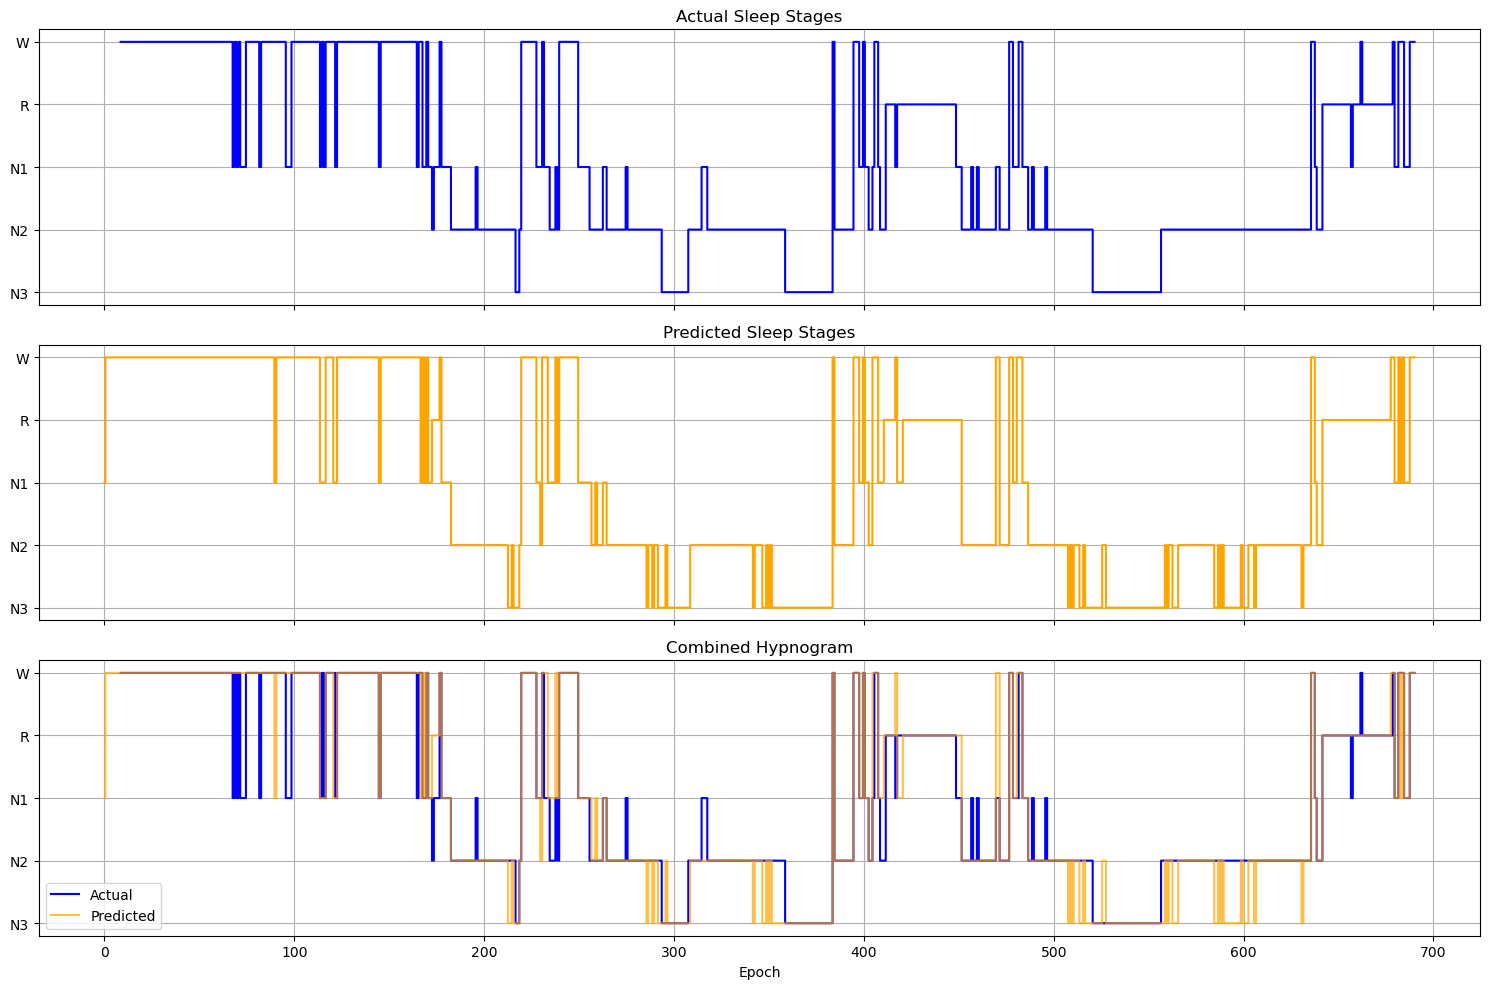

BAD [I0002150034522-2] Acc=0.61 F1=0.57 Kappa=0.42 Precision=0.45 Recall=0.51 Specificity=0.51 Score=0.52 


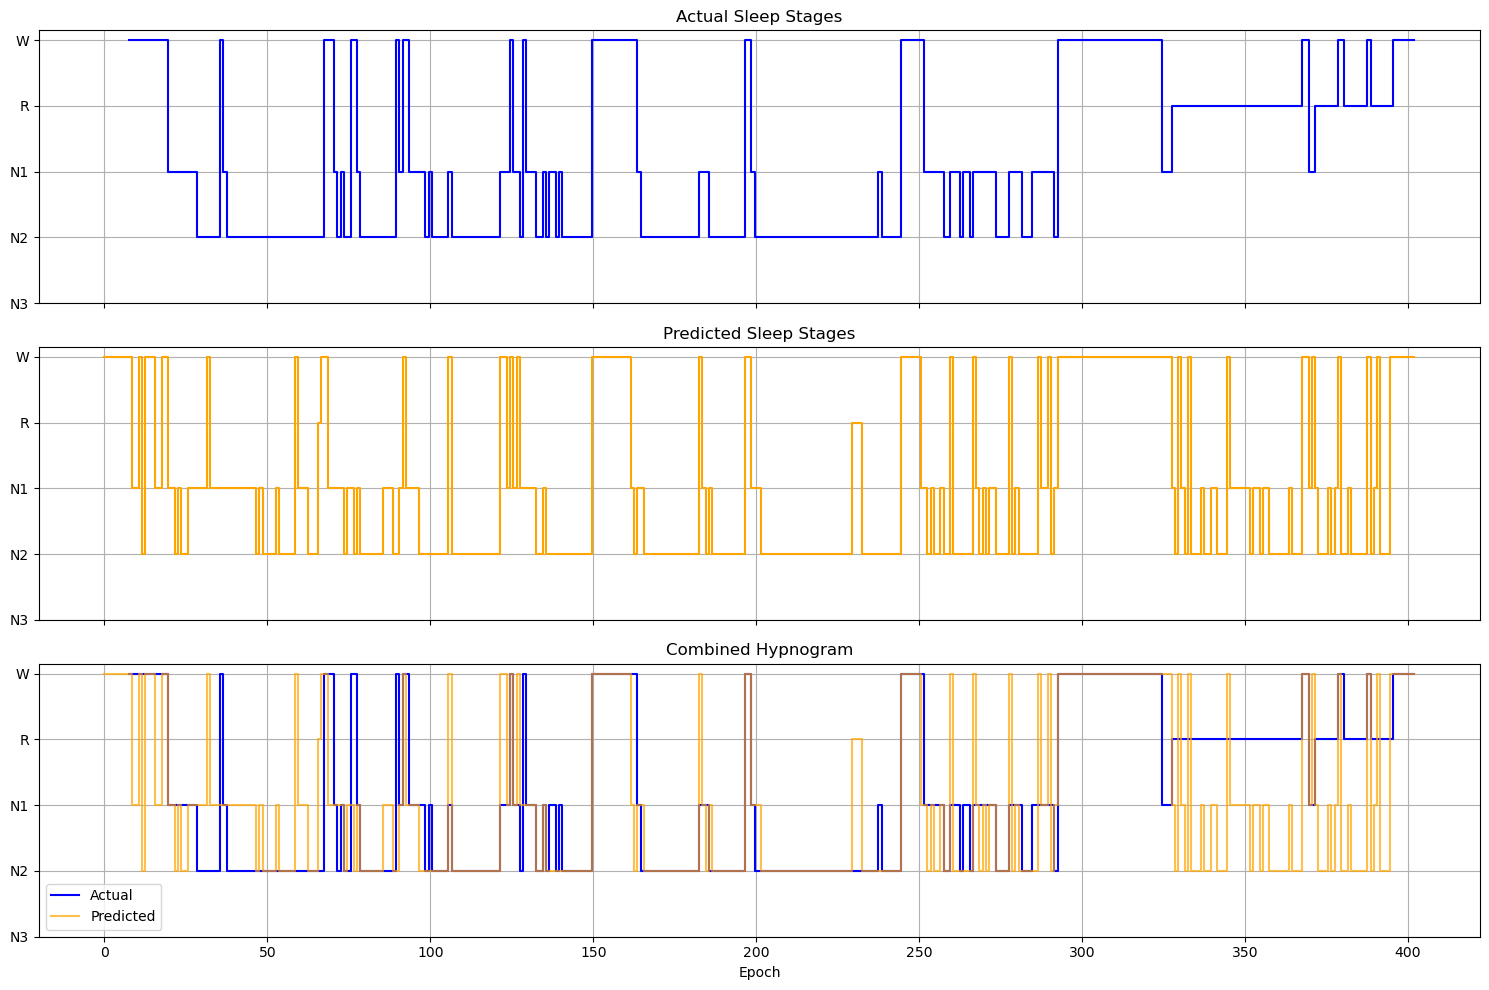

GOOD [I0002150034534-1] Acc=0.92 F1=0.92 Kappa=0.89 Precision=0.87 Recall=0.87 Specificity=0.87 Score=0.89 


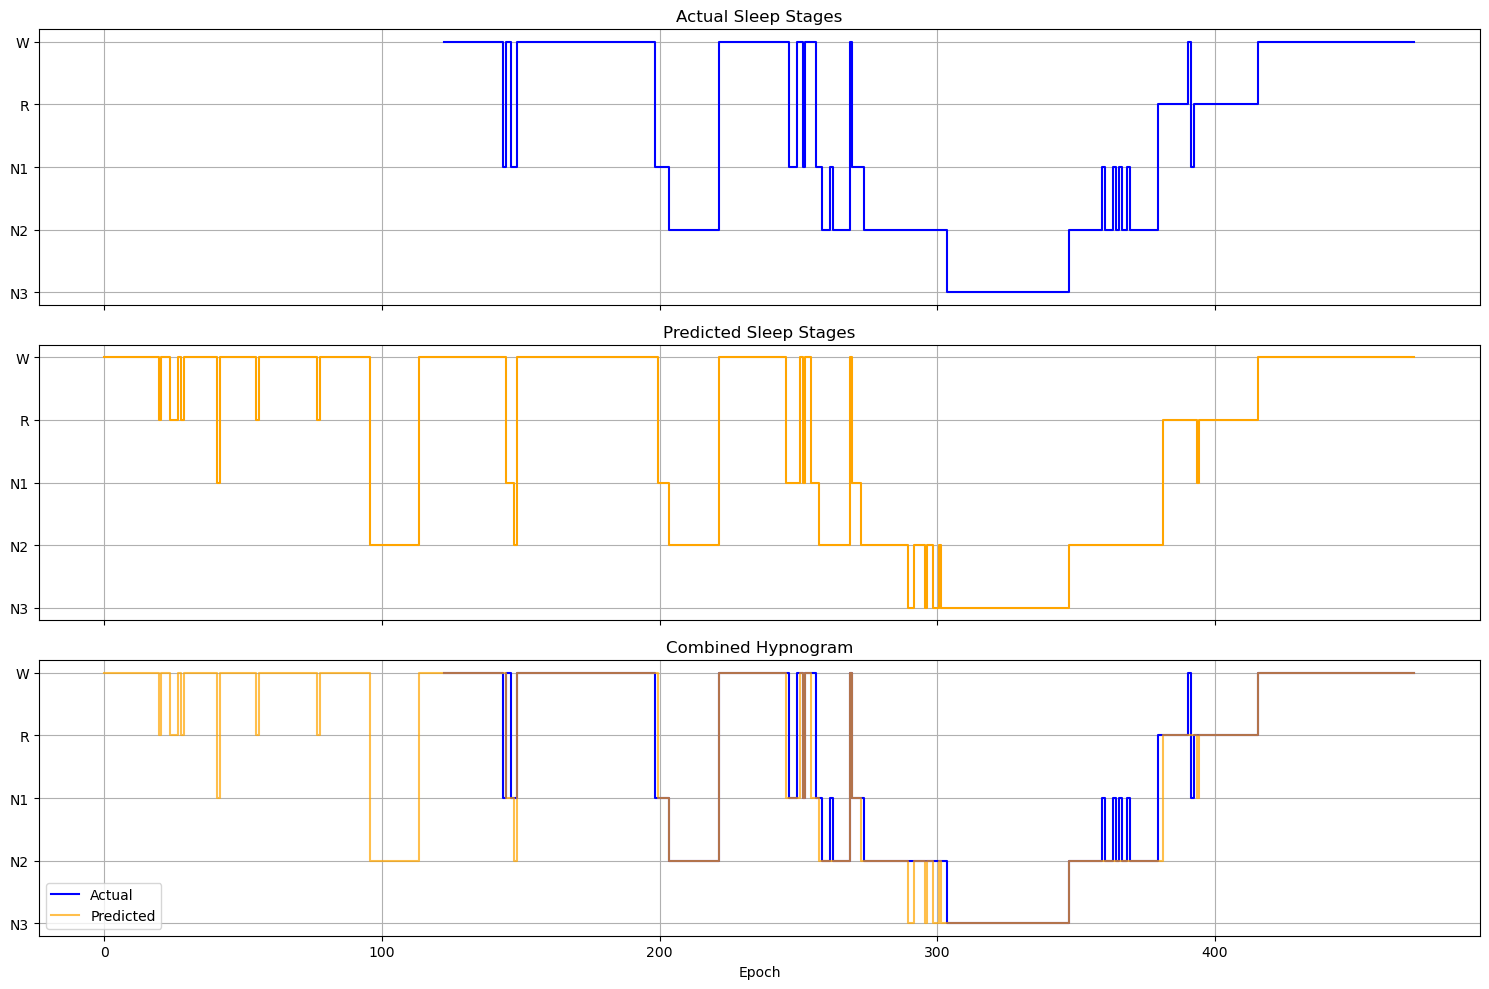

REVIEW [I0002150034598-1] Acc=0.77 F1=0.76 Kappa=0.67 Precision=0.55 Recall=0.56 Specificity=0.56 Score=0.67 


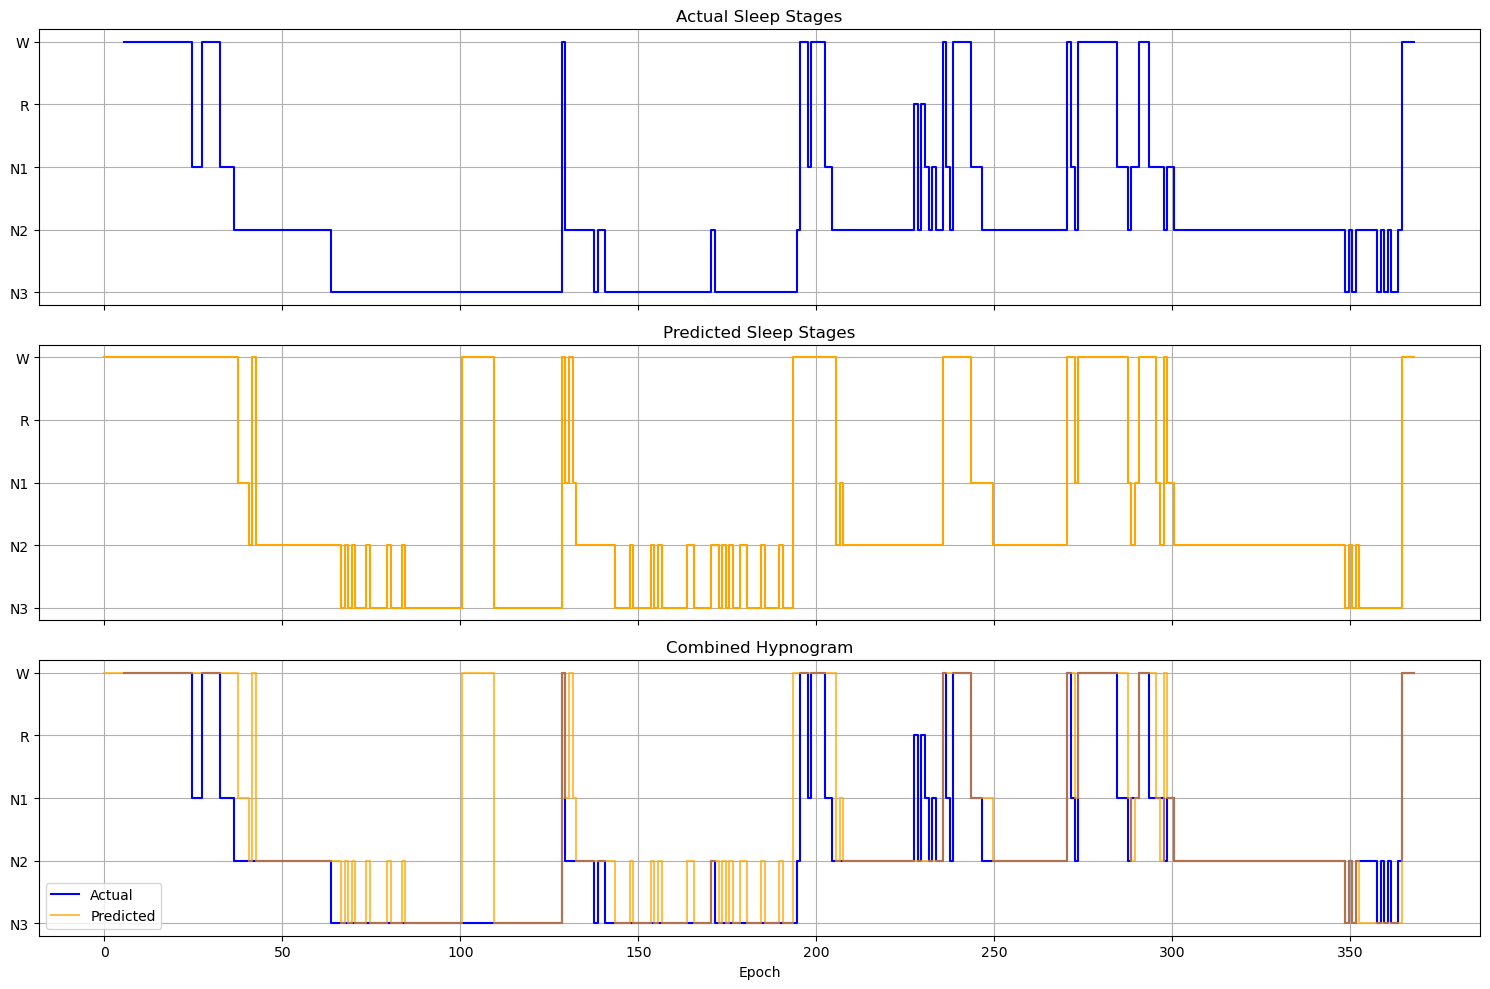

GOOD [I0002150034669-1] Acc=0.80 F1=0.78 Kappa=0.72 Precision=0.75 Recall=0.77 Specificity=0.77 Score=0.76 


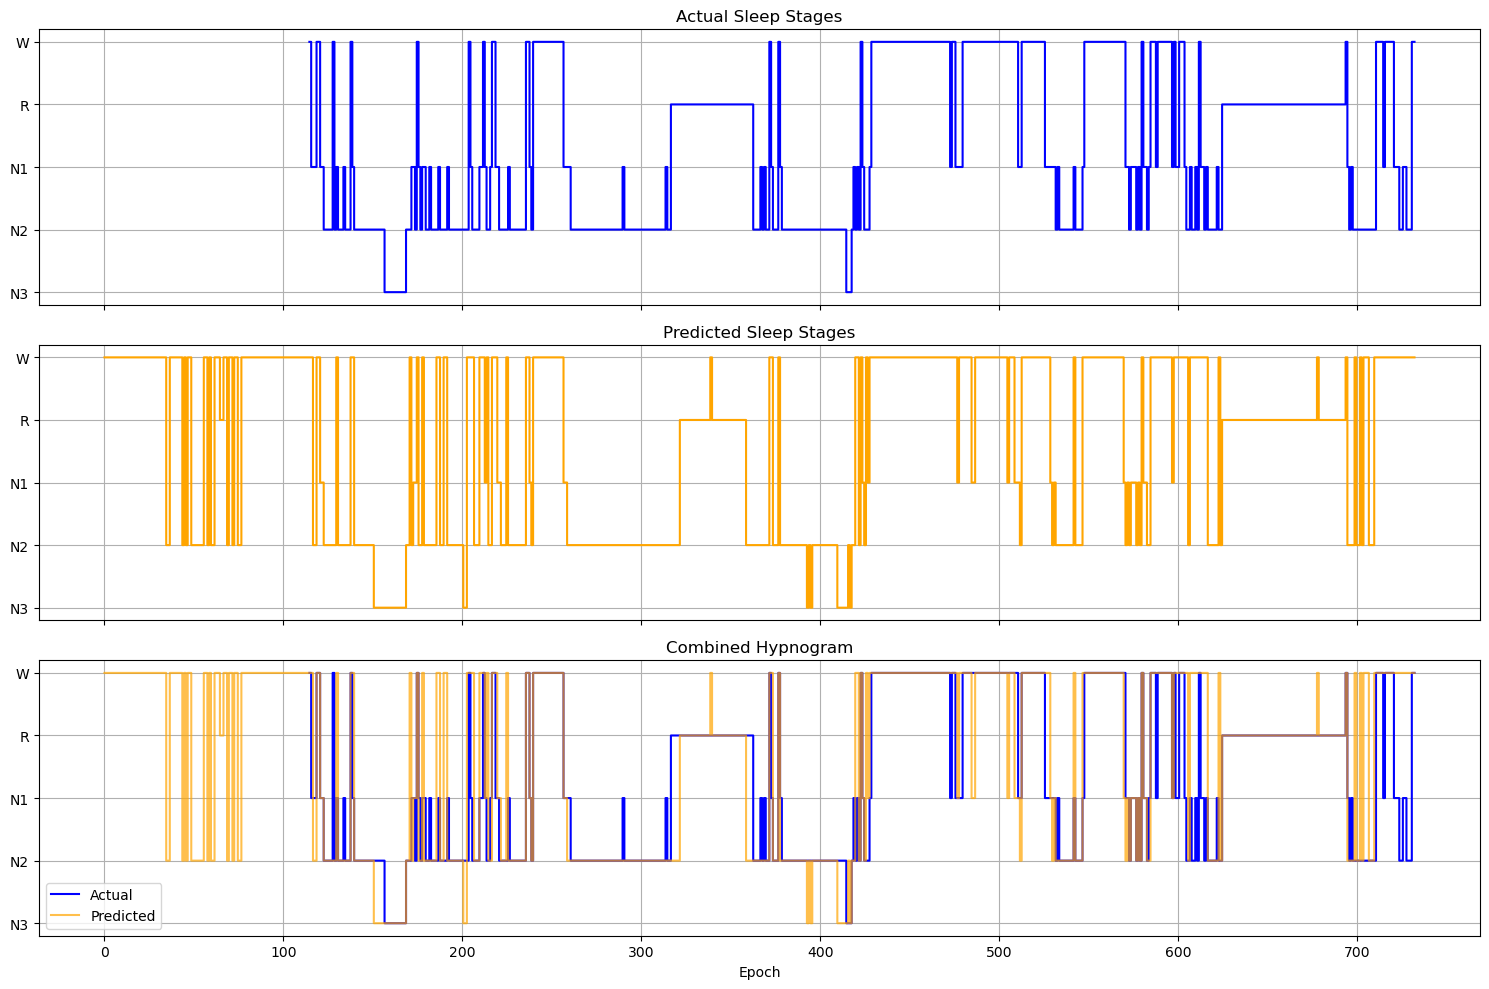

GOOD [I0002150034903-1] Acc=0.88 F1=0.88 Kappa=0.85 Precision=0.84 Recall=0.82 Specificity=0.82 Score=0.86 


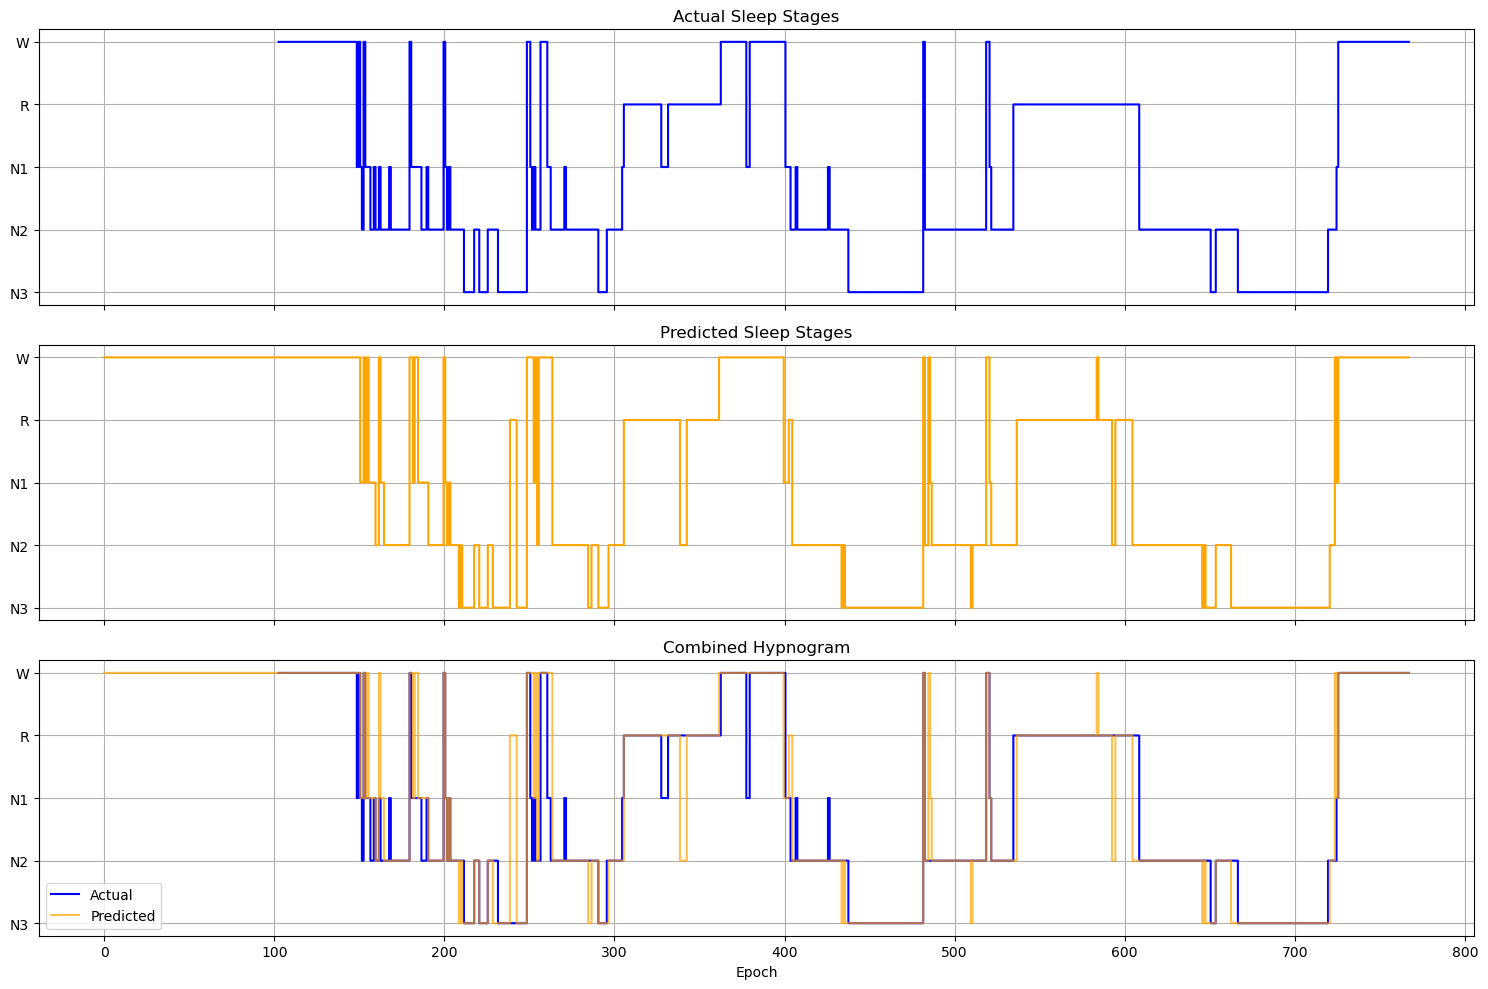

BAD [I0002150034907-1] Acc=0.62 F1=0.60 Kappa=0.47 Precision=0.61 Recall=0.53 Specificity=0.53 Score=0.57 


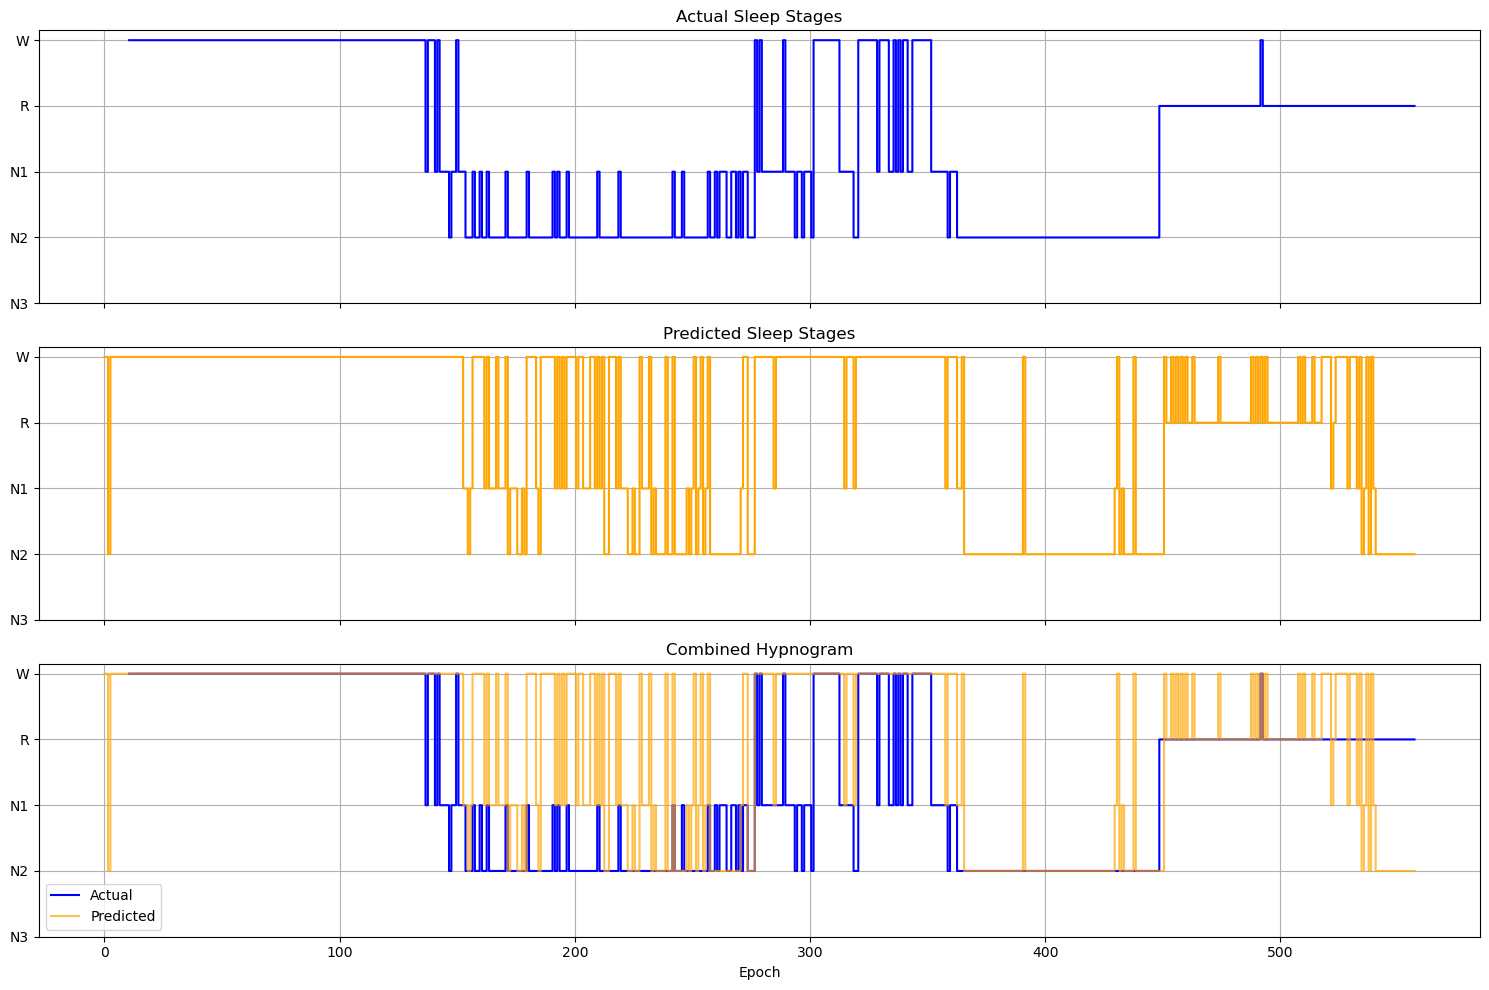

BAD [I0002150034999-1] Acc=0.77 F1=0.83 Kappa=0.61 Precision=0.38 Recall=0.50 Specificity=0.50 Score=0.64 


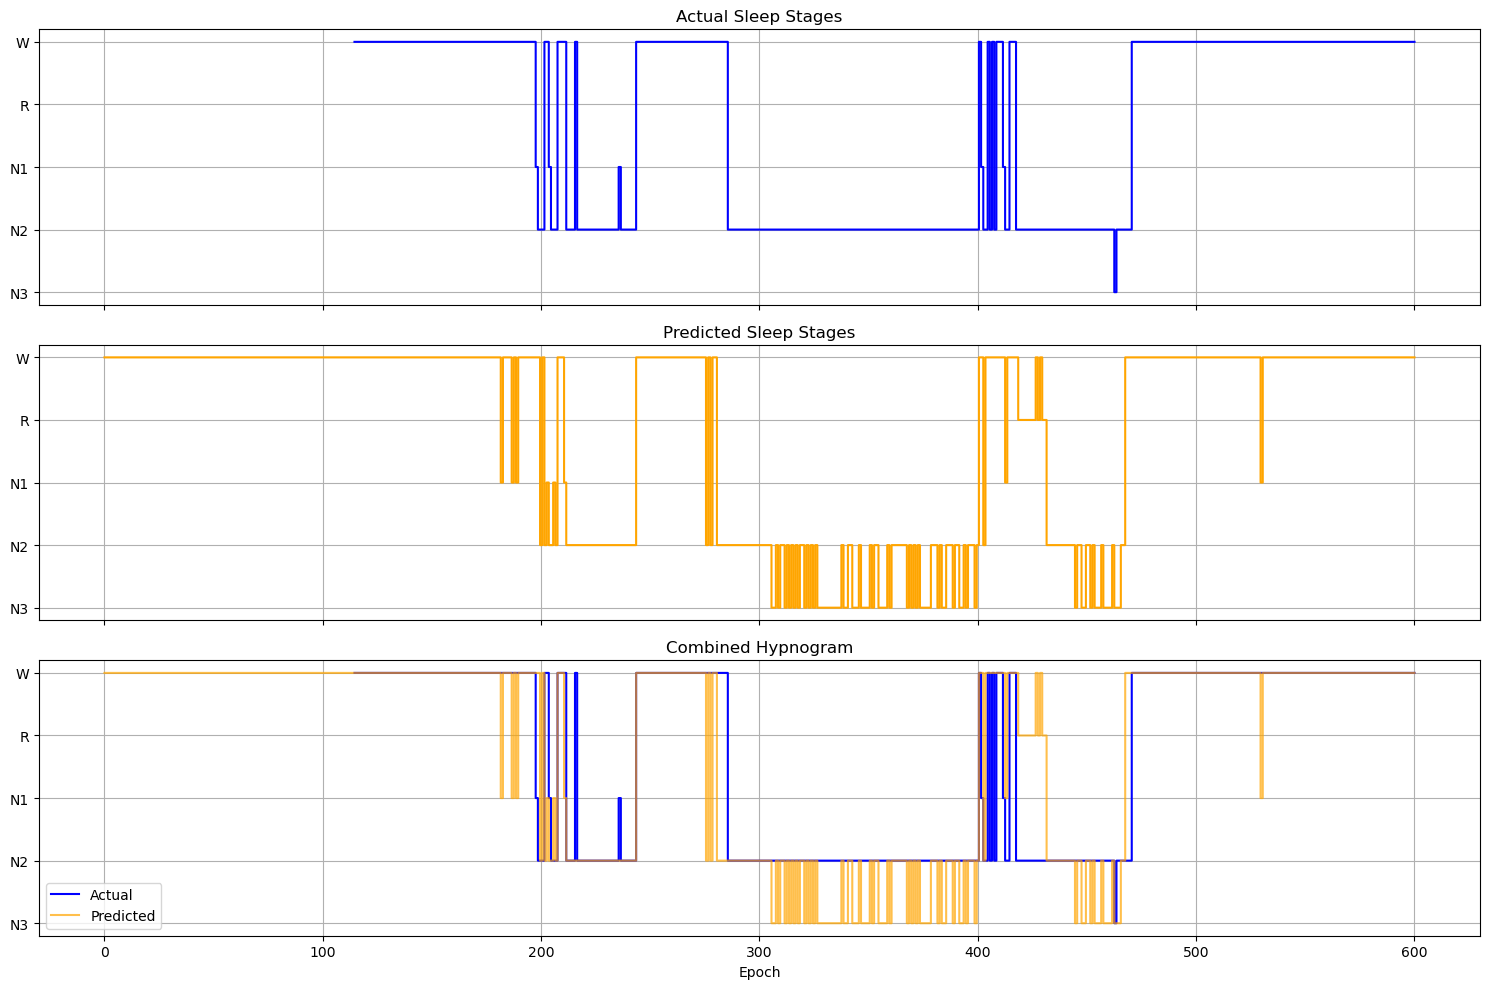

REVIEW [I0002150035040-1] Acc=0.85 F1=0.84 Kappa=0.59 Precision=0.41 Recall=0.46 Specificity=0.46 Score=0.65 


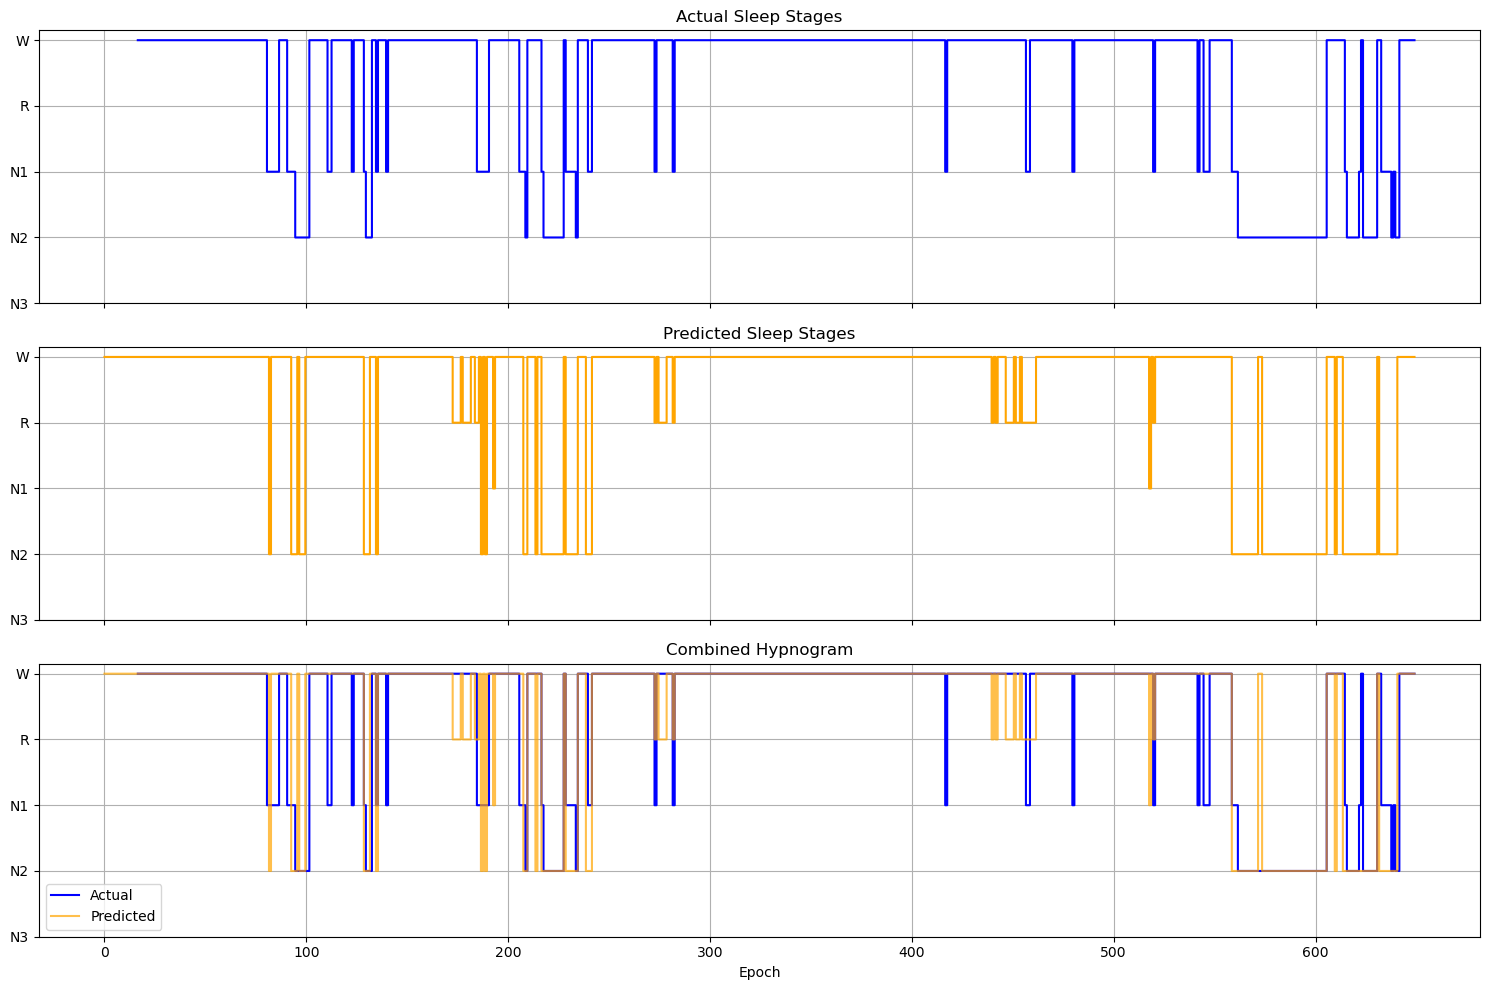

GOOD [I0002150036149-1] Acc=0.87 F1=0.86 Kappa=0.82 Precision=0.86 Recall=0.84 Specificity=0.84 Score=0.85 


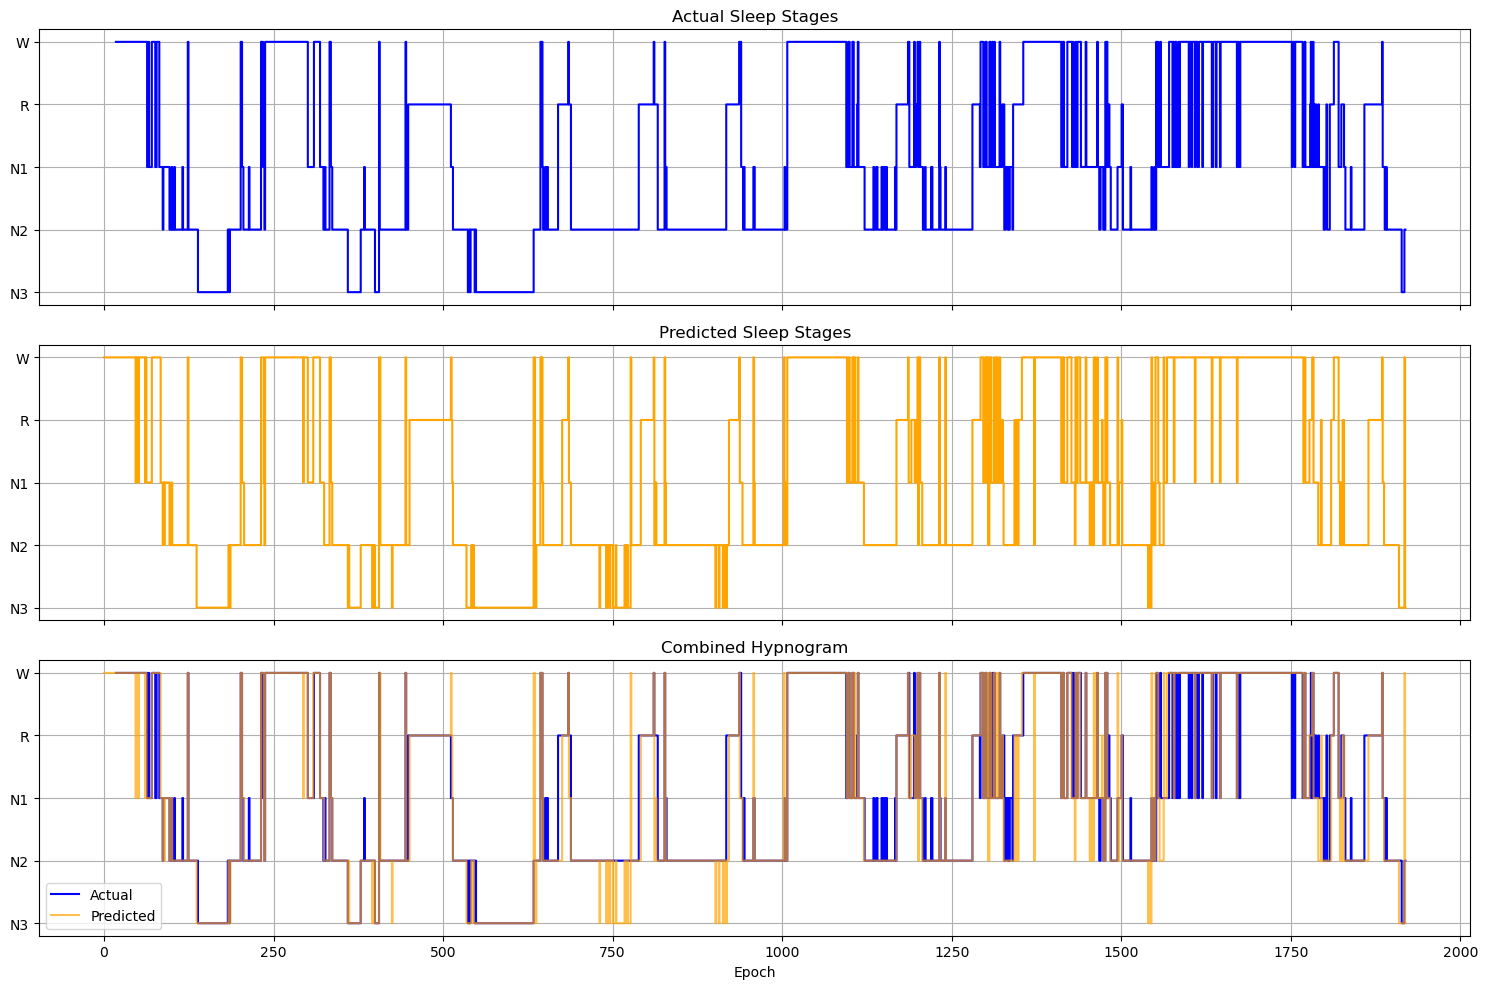

REVIEW [I0002150036819-1] Acc=0.77 F1=0.77 Kappa=0.67 Precision=0.73 Recall=0.76 Specificity=0.76 Score=0.74 


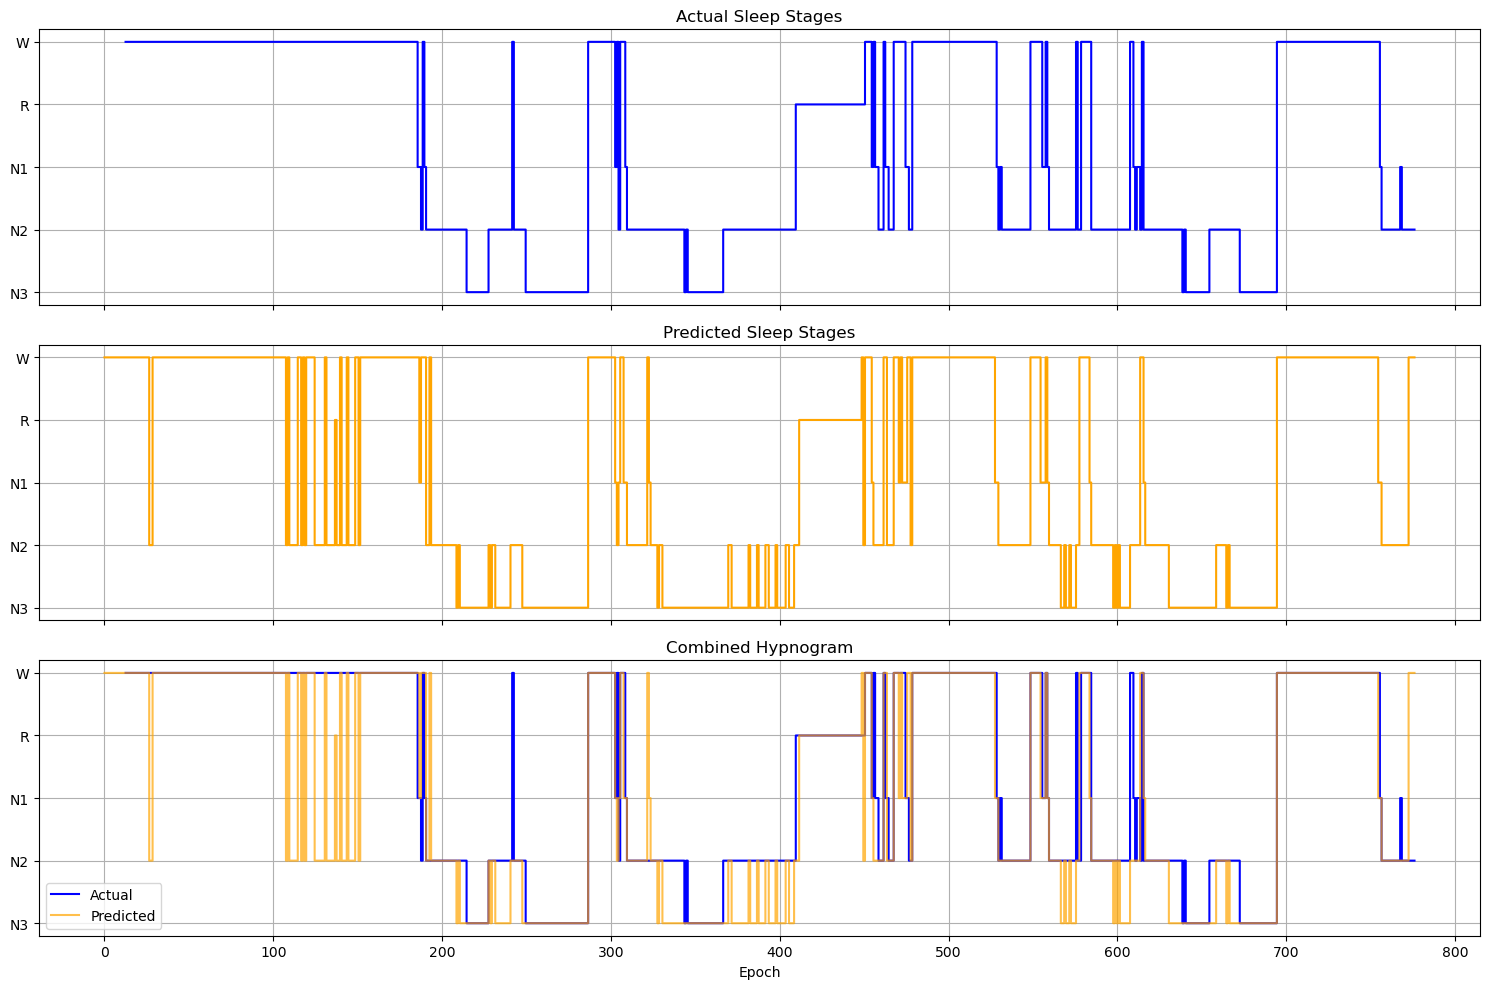

BAD [I0002150036961-1] Acc=0.60 F1=0.73 Kappa=0.07 Precision=0.28 Recall=0.43 Specificity=0.43 Score=0.44 


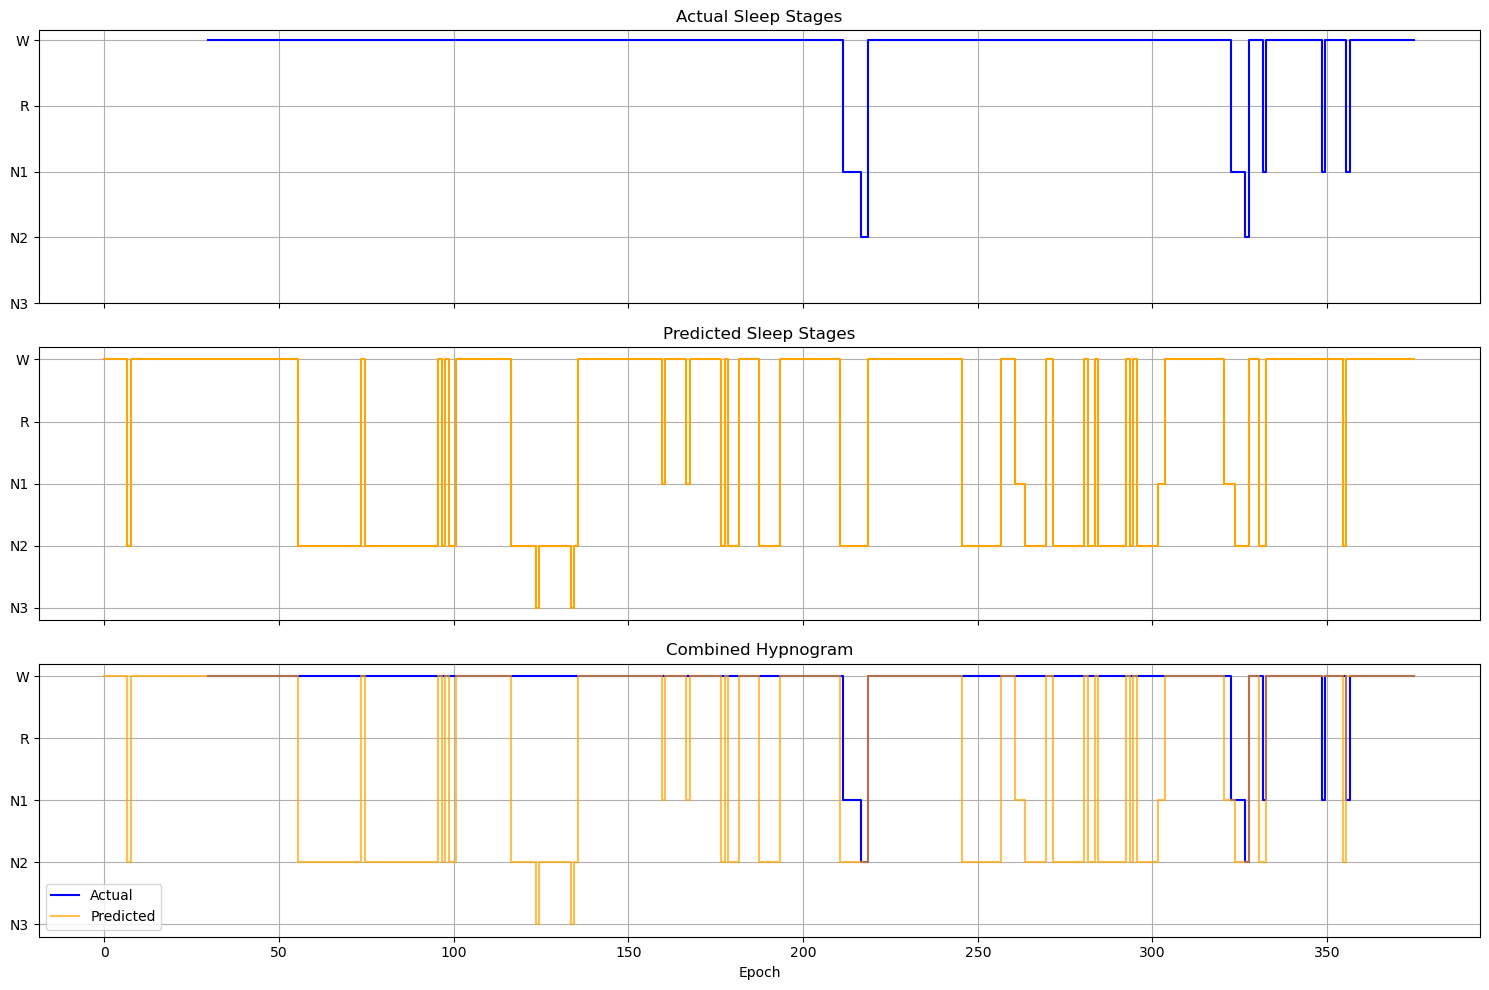

GOOD [I0002150038599-1] Acc=0.79 F1=0.81 Kappa=0.71 Precision=0.69 Recall=0.82 Specificity=0.82 Score=0.77 


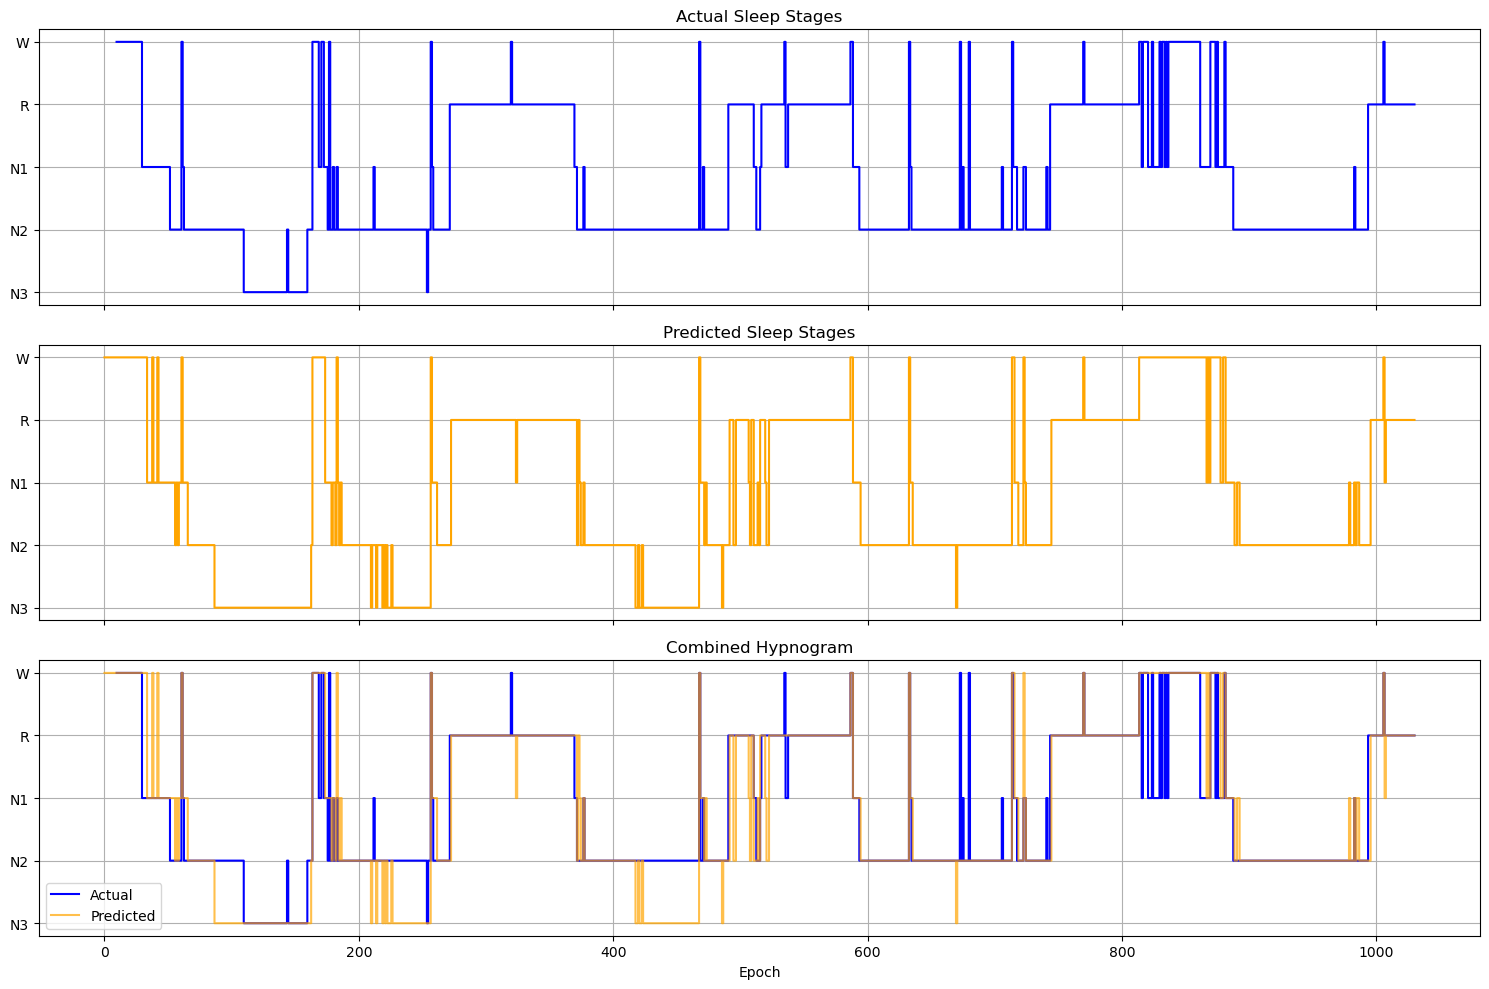

REVIEW [I0002150040240-2] Acc=0.83 F1=0.82 Kappa=0.71 Precision=0.54 Recall=0.66 Specificity=0.66 Score=0.72 


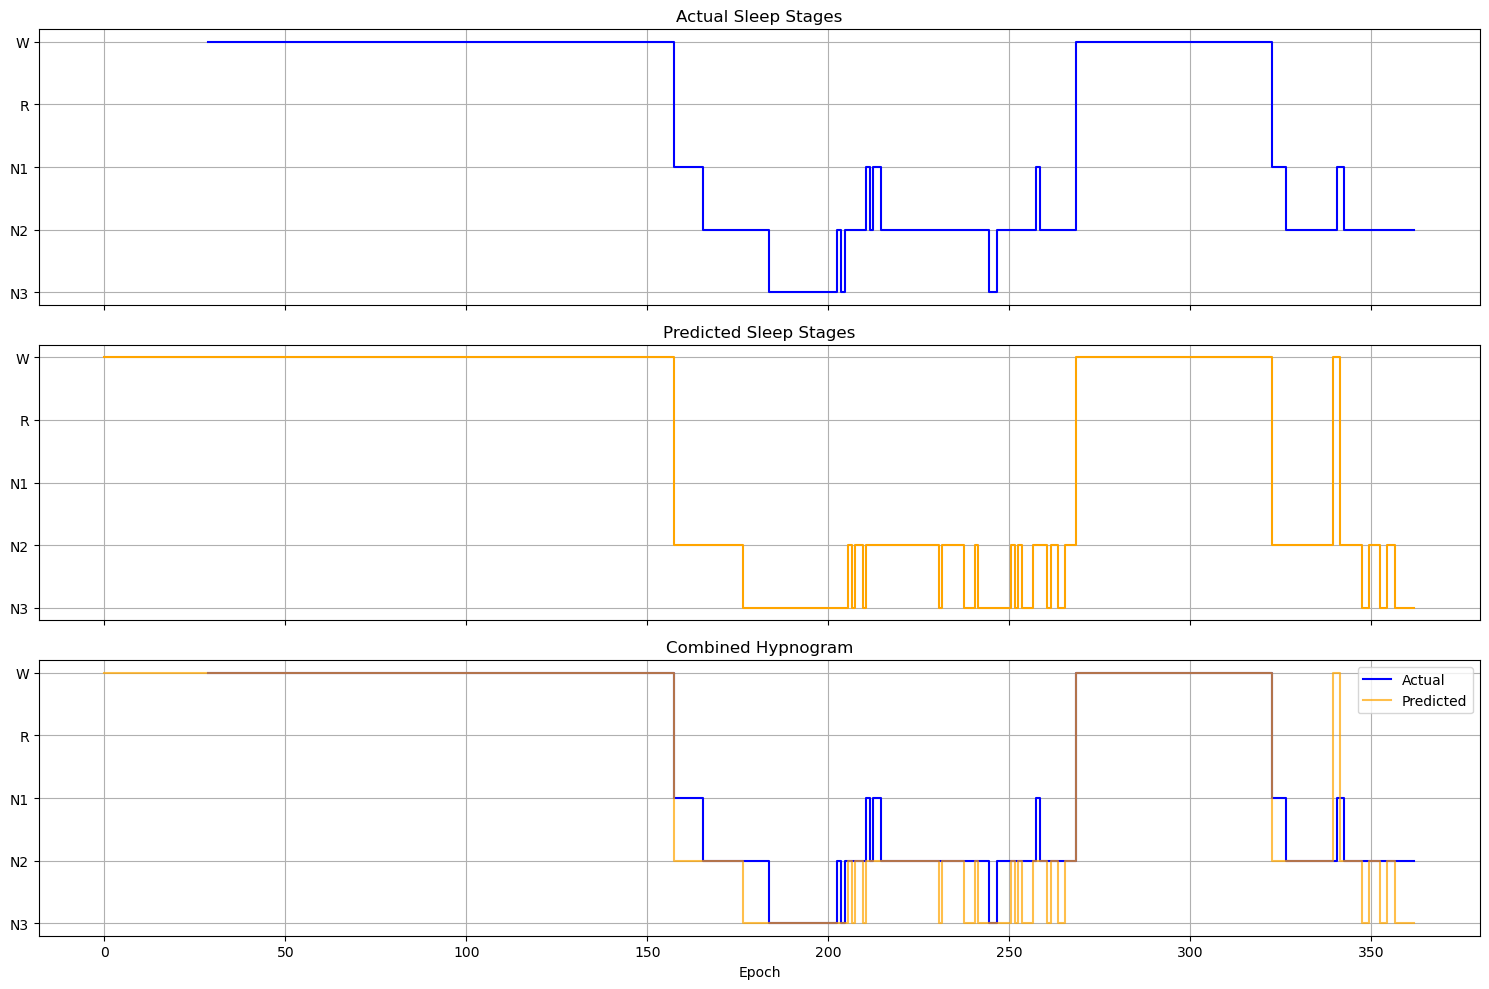

REVIEW [I0002150043035-2] Acc=0.84 F1=0.84 Kappa=0.73 Precision=0.70 Recall=0.57 Specificity=0.57 Score=0.74 


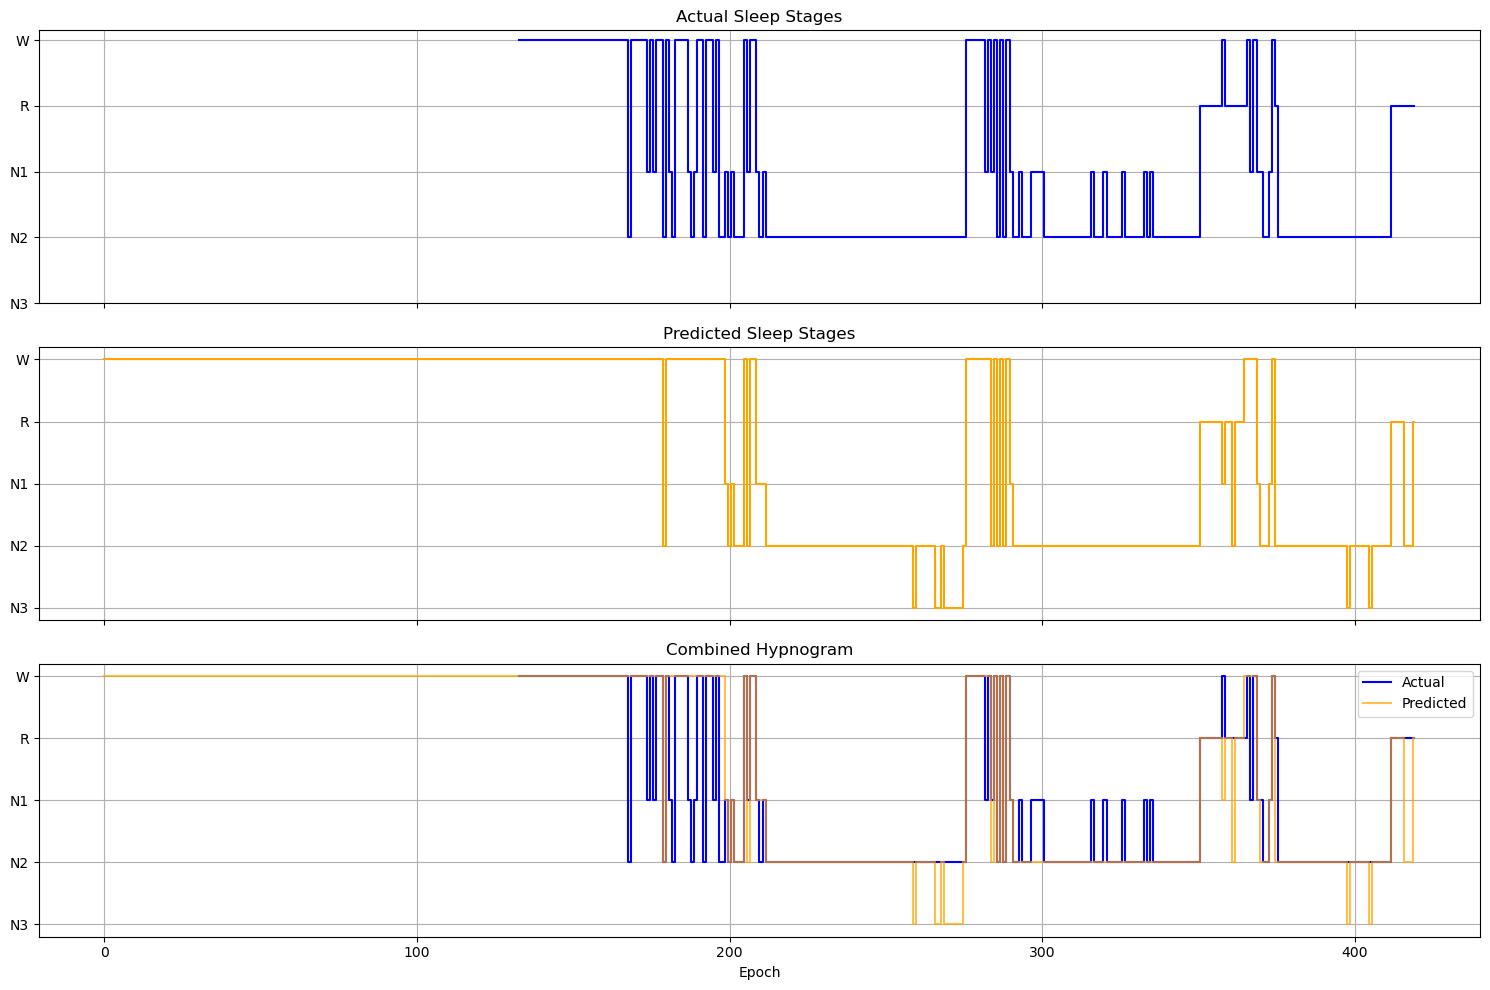

GOOD [I0002150043460-1] Acc=0.83 F1=0.87 Kappa=0.75 Precision=0.70 Recall=0.64 Specificity=0.64 Score=0.77 


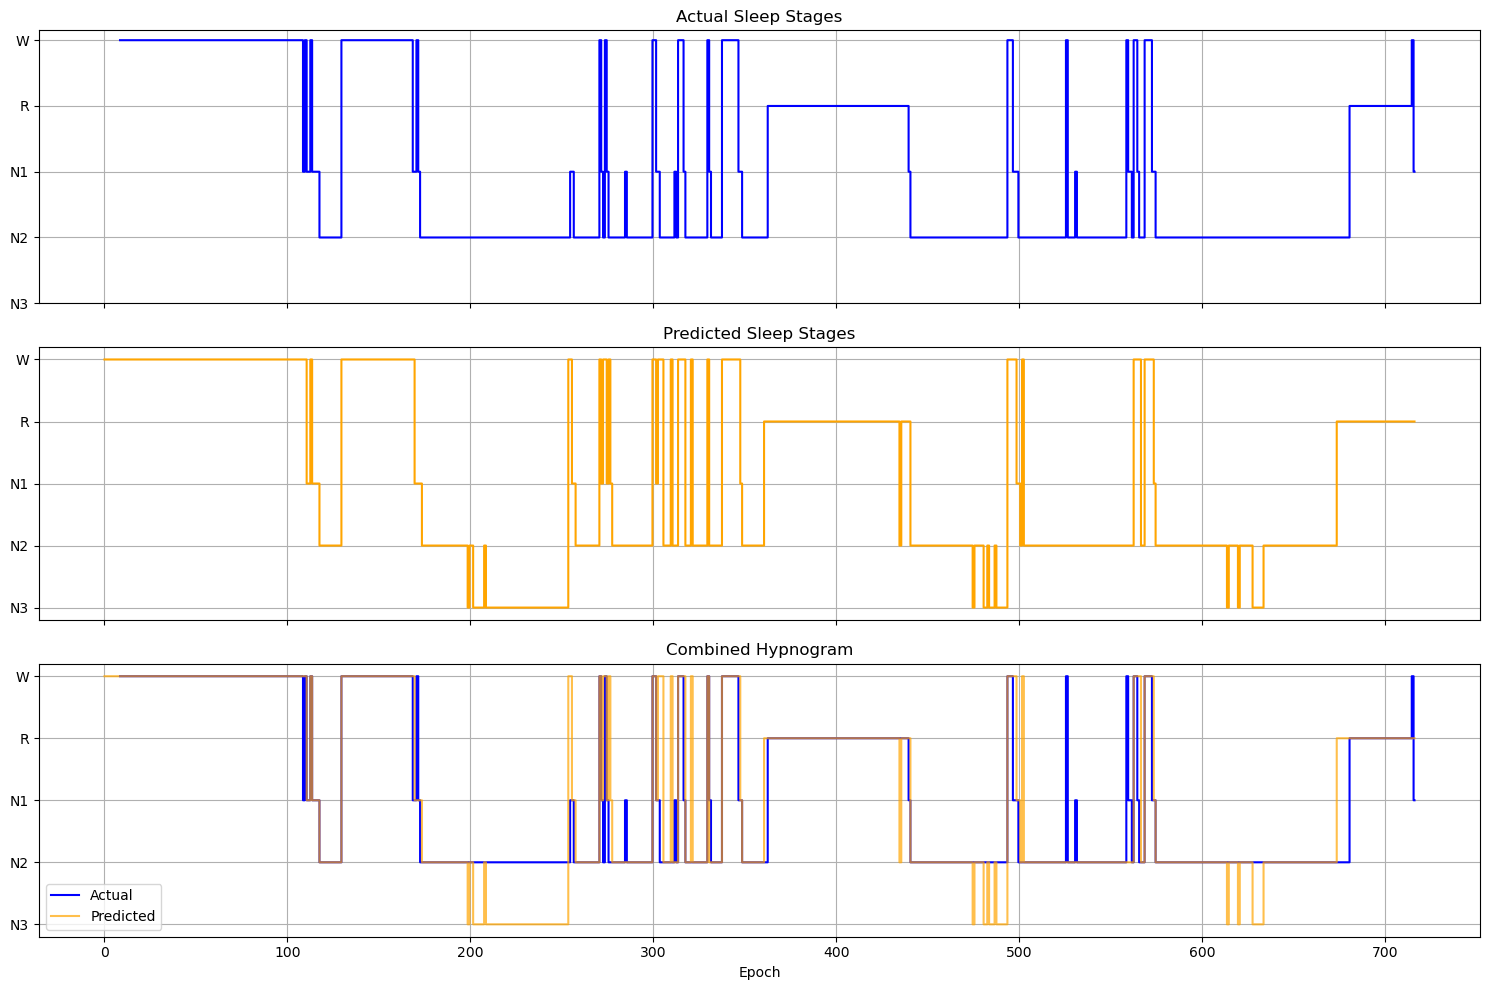

REVIEW [I0002150043675-1] Acc=0.85 F1=0.87 Kappa=0.73 Precision=0.37 Recall=0.35 Specificity=0.35 Score=0.66 


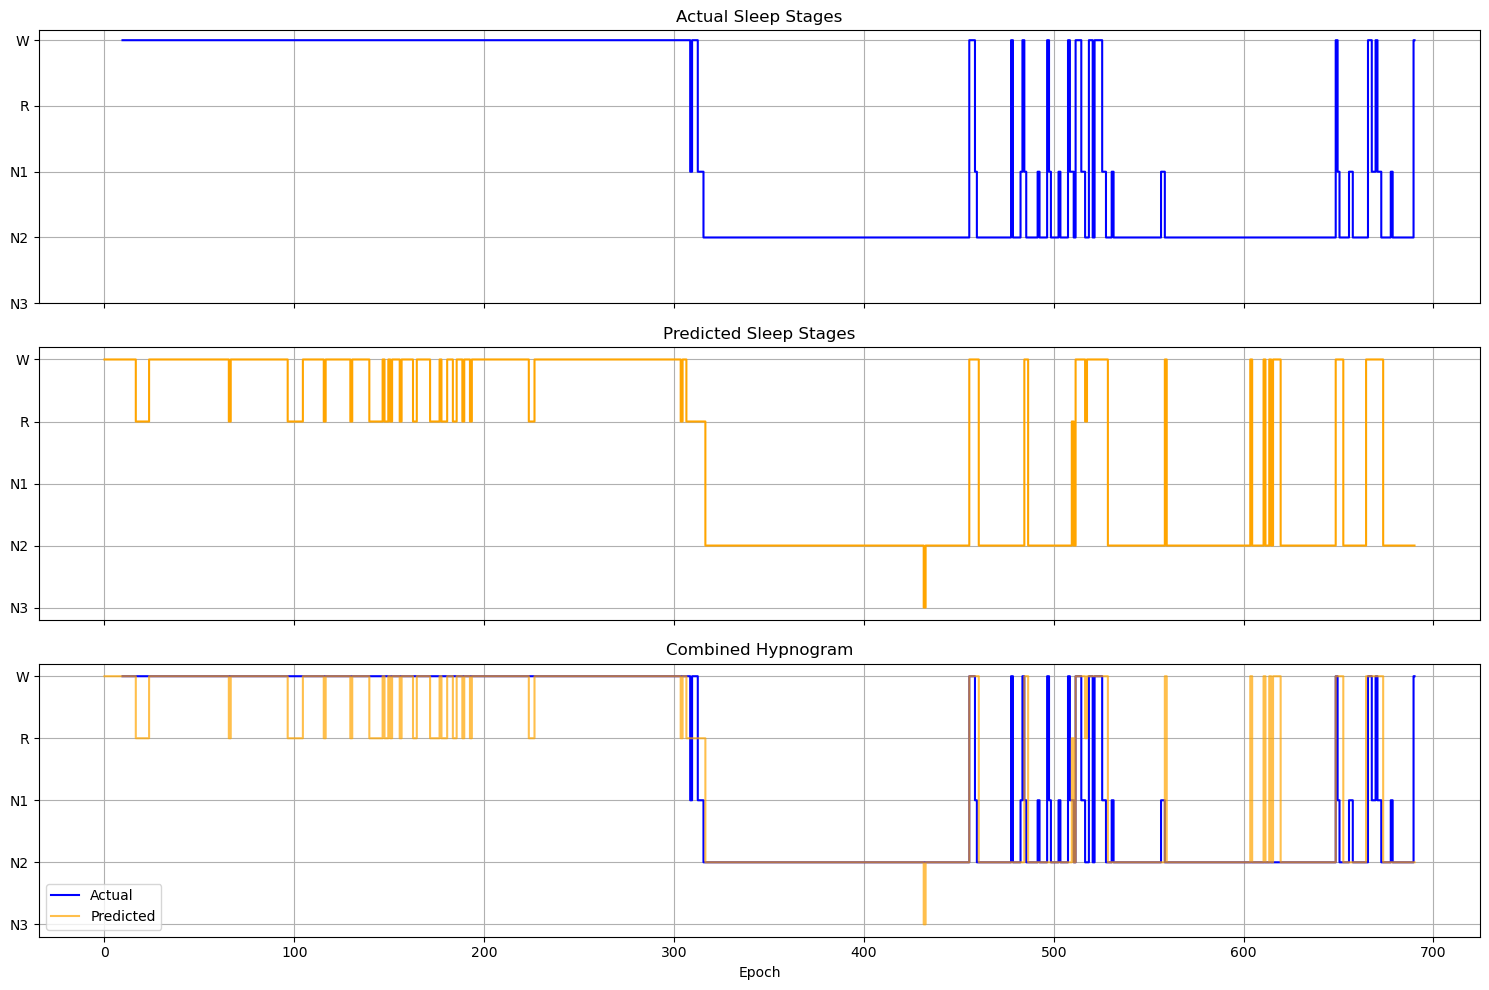

BAD [I0002150044160-1] Acc=0.66 F1=0.66 Kappa=0.44 Precision=0.36 Recall=0.36 Specificity=0.36 Score=0.51 


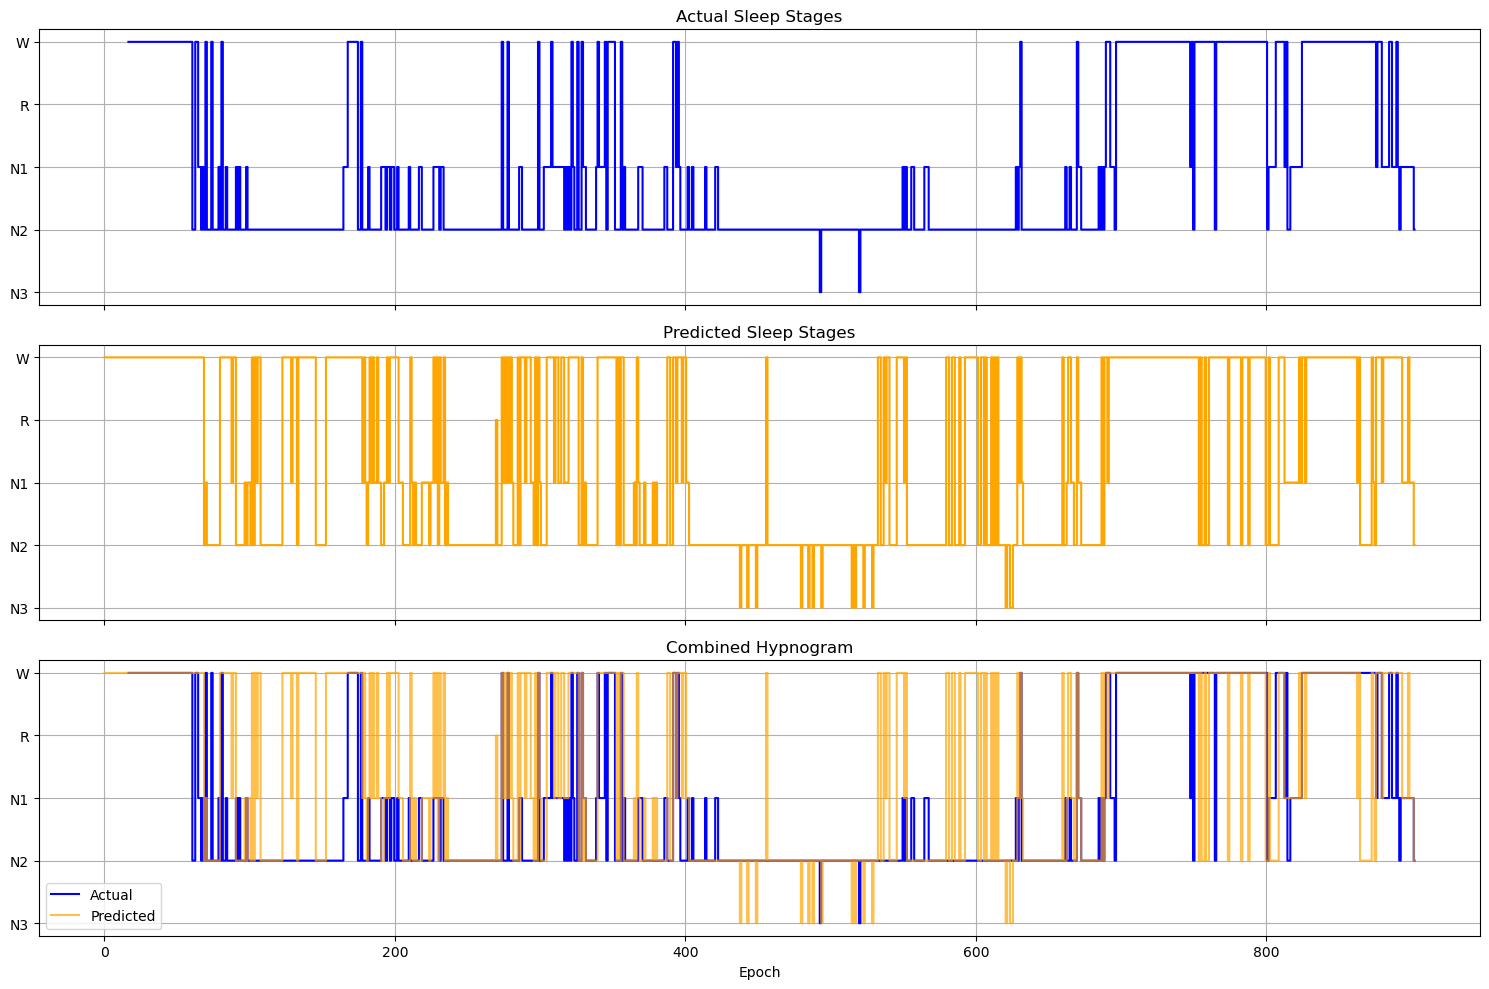

REVIEW [I0002150050670-1] Acc=0.85 F1=0.85 Kappa=0.72 Precision=0.57 Recall=0.61 Specificity=0.61 Score=0.74 


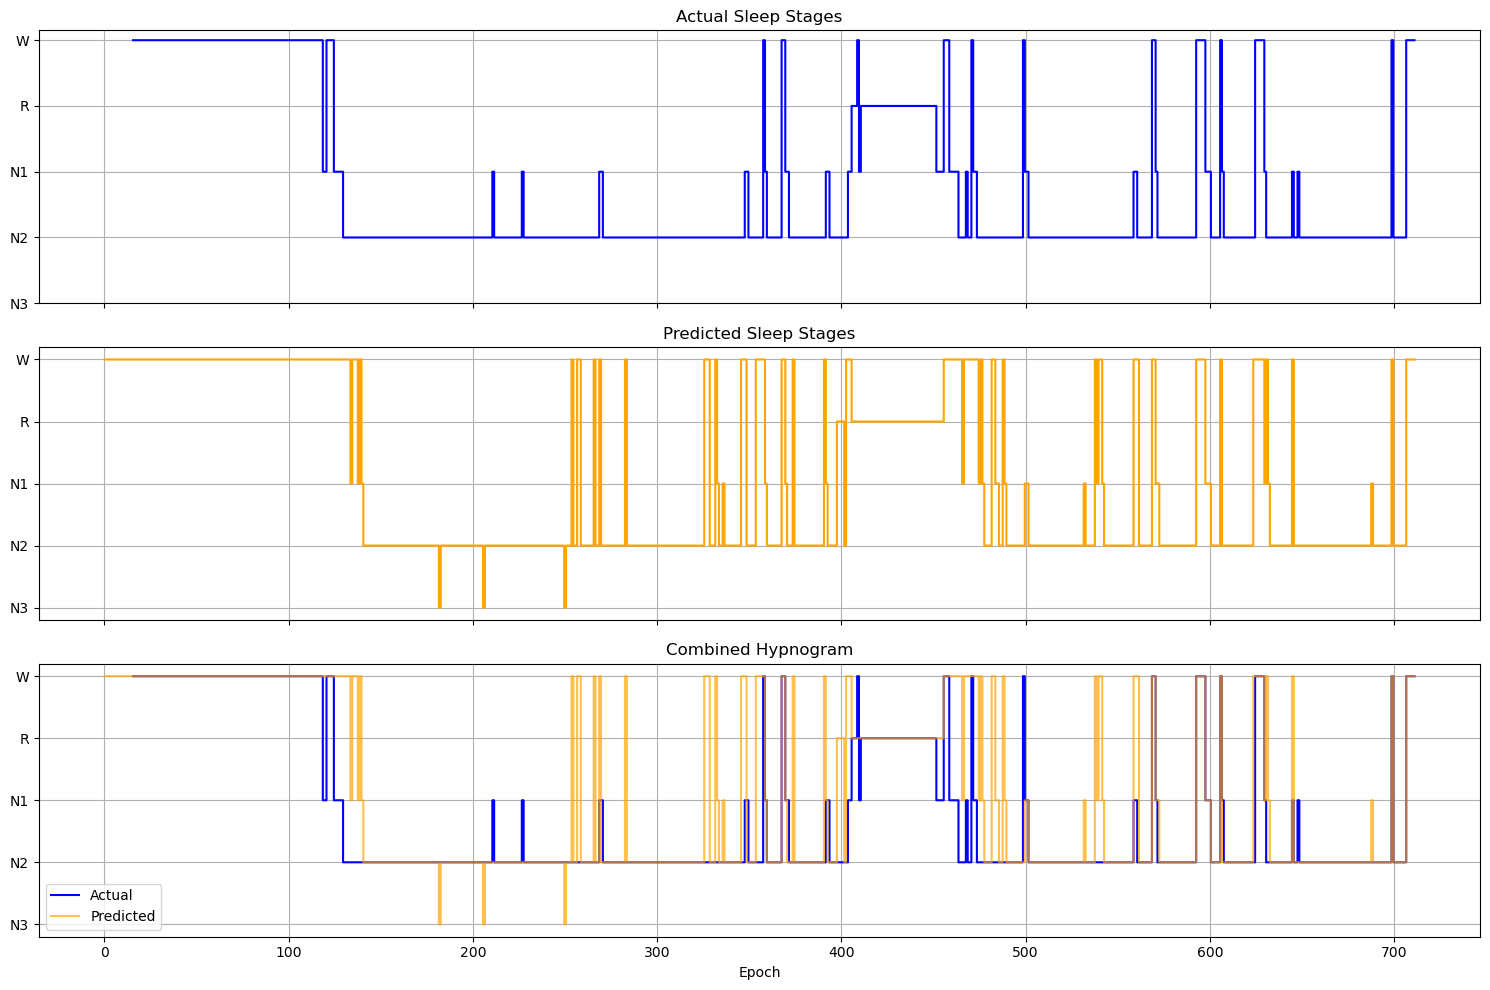

REVIEW [I0002150058721-1] Acc=0.83 F1=0.81 Kappa=0.66 Precision=0.46 Recall=0.54 Specificity=0.54 Score=0.68 


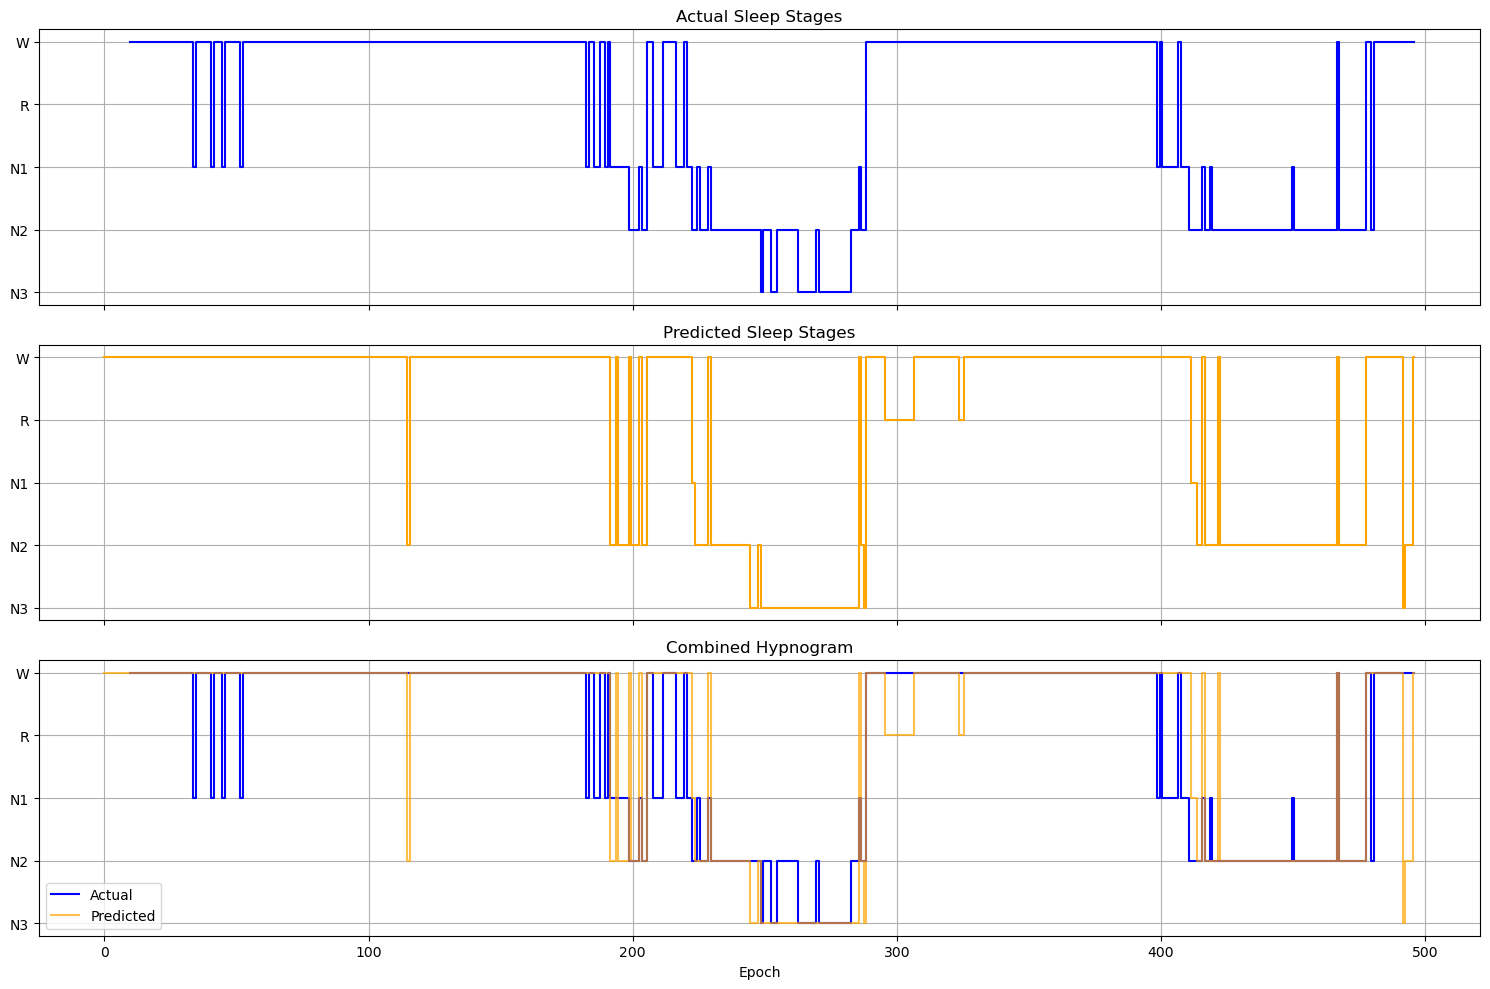

BAD [I0002150066409-1] Acc=0.69 F1=0.66 Kappa=0.51 Precision=0.51 Recall=0.52 Specificity=0.52 Score=0.59 


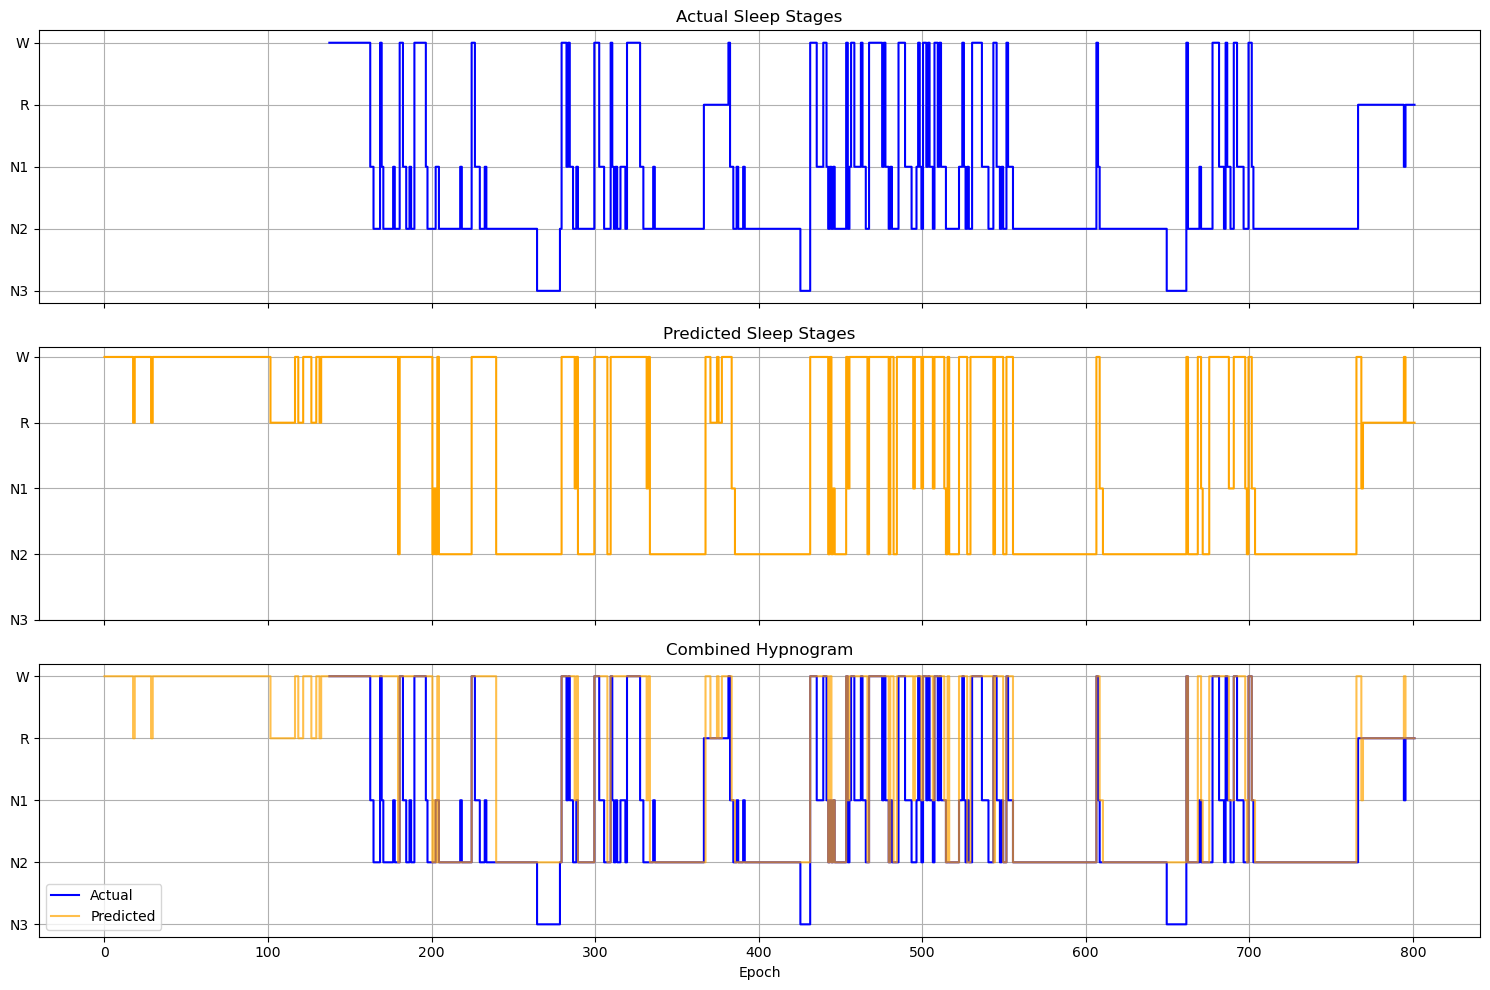

REVIEW [I0002150572263-1] Acc=0.82 F1=0.81 Kappa=0.70 Precision=0.62 Recall=0.56 Specificity=0.56 Score=0.71 


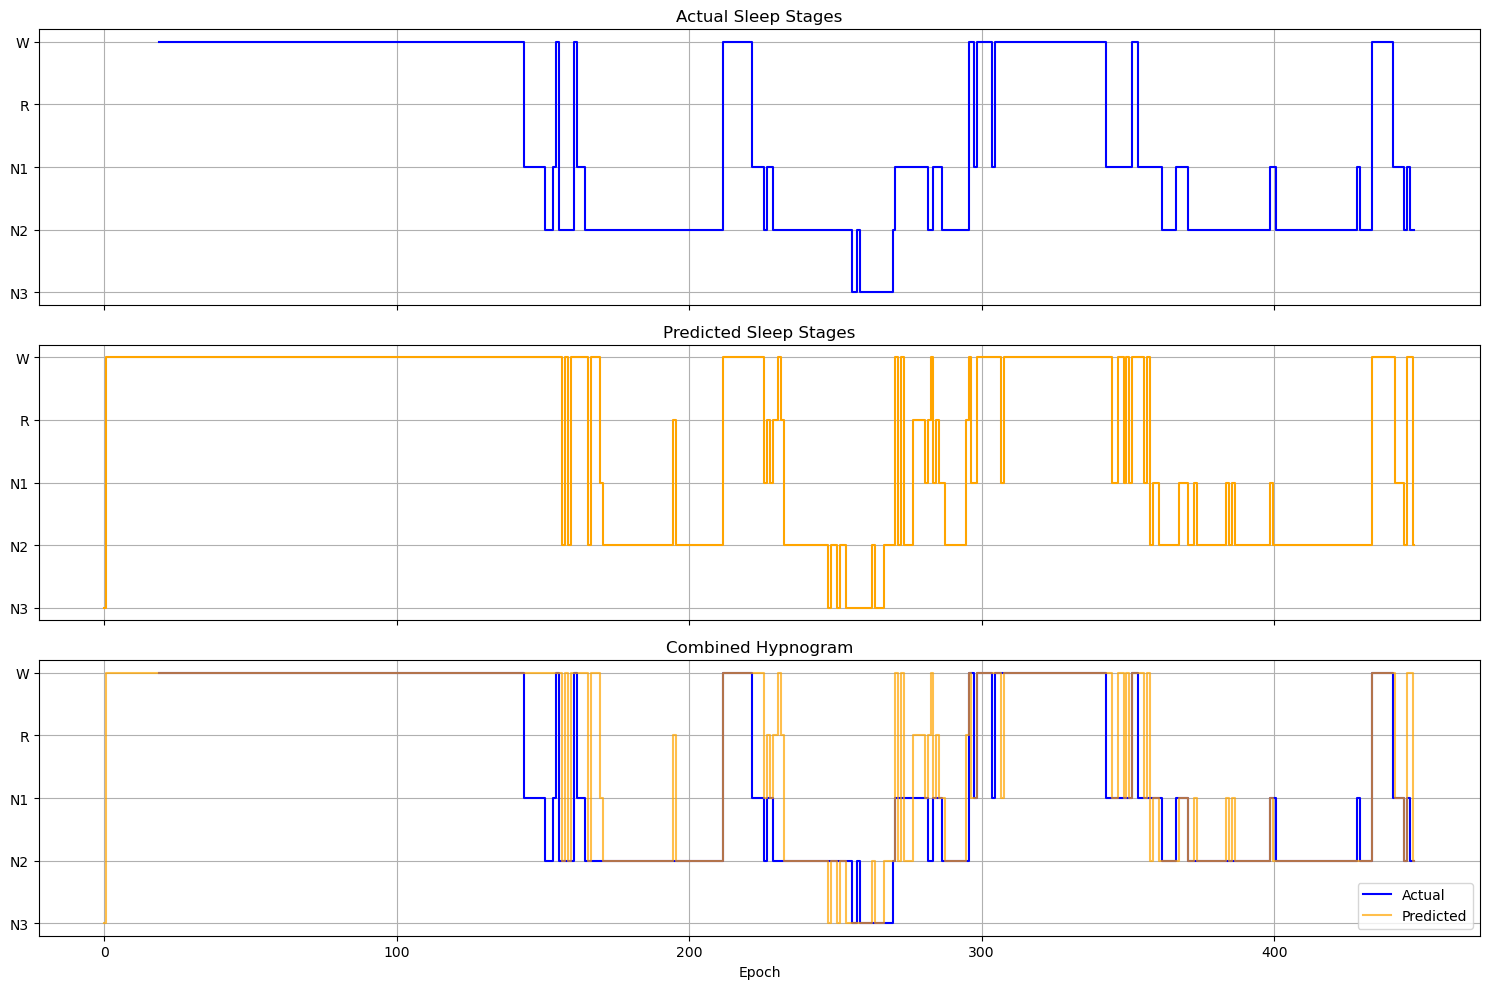

BAD [I0002150607879-1] Acc=0.67 F1=0.69 Kappa=0.37 Precision=0.52 Recall=0.74 Specificity=0.74 Score=0.61 


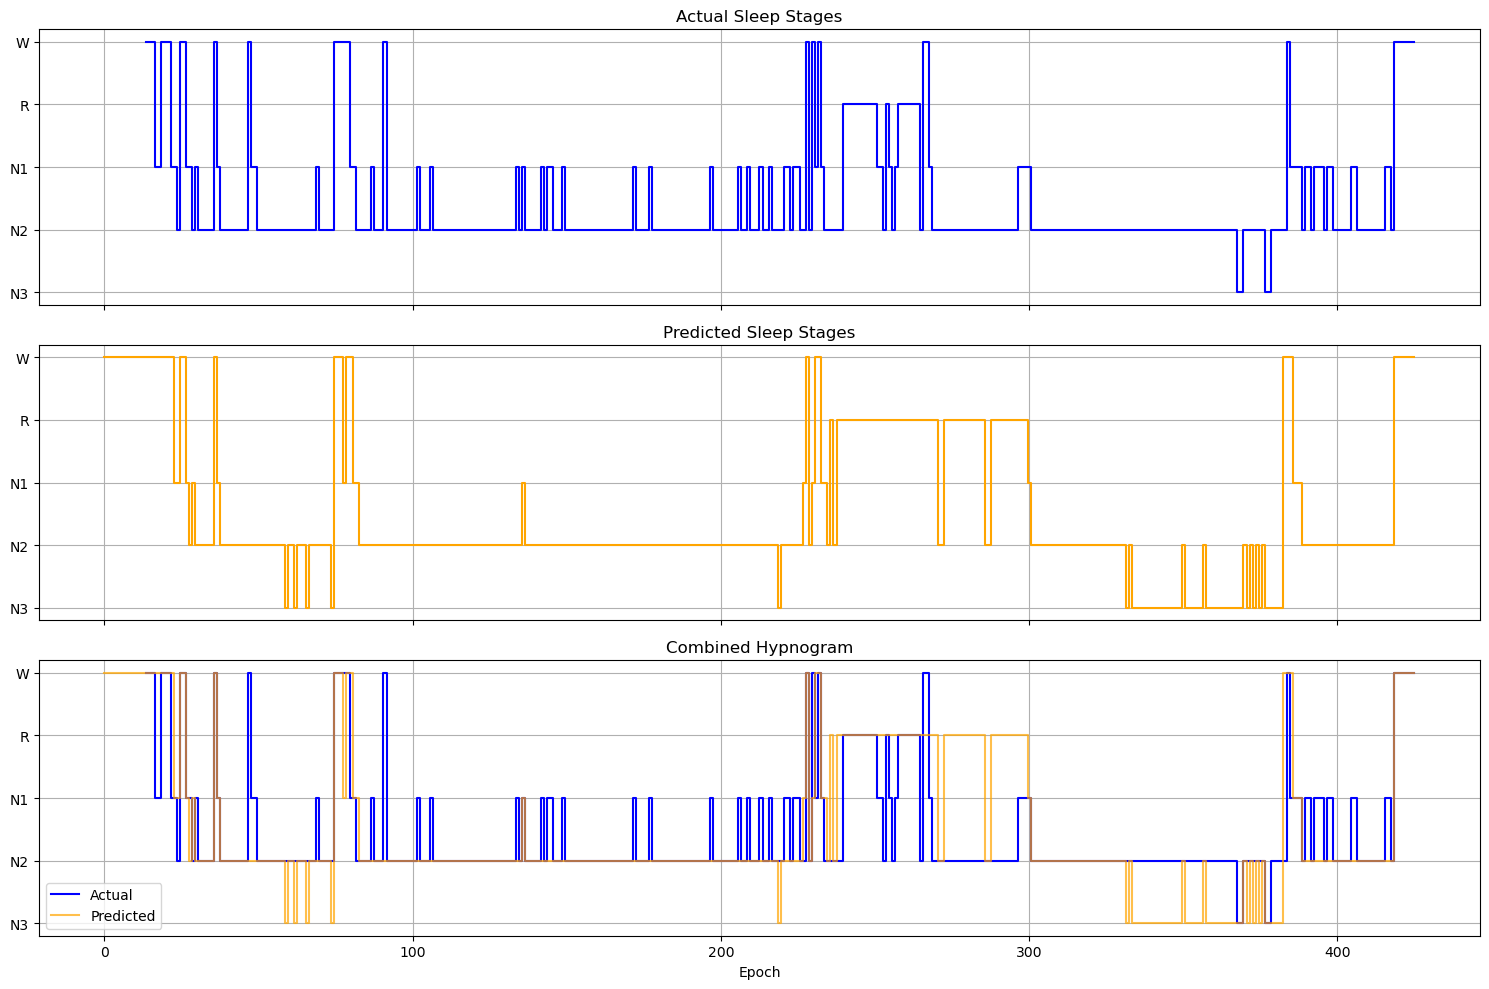

GOOD [I0002150807875-1] Acc=0.86 F1=0.87 Kappa=0.70 Precision=0.78 Recall=0.71 Specificity=0.71 Score=0.79 


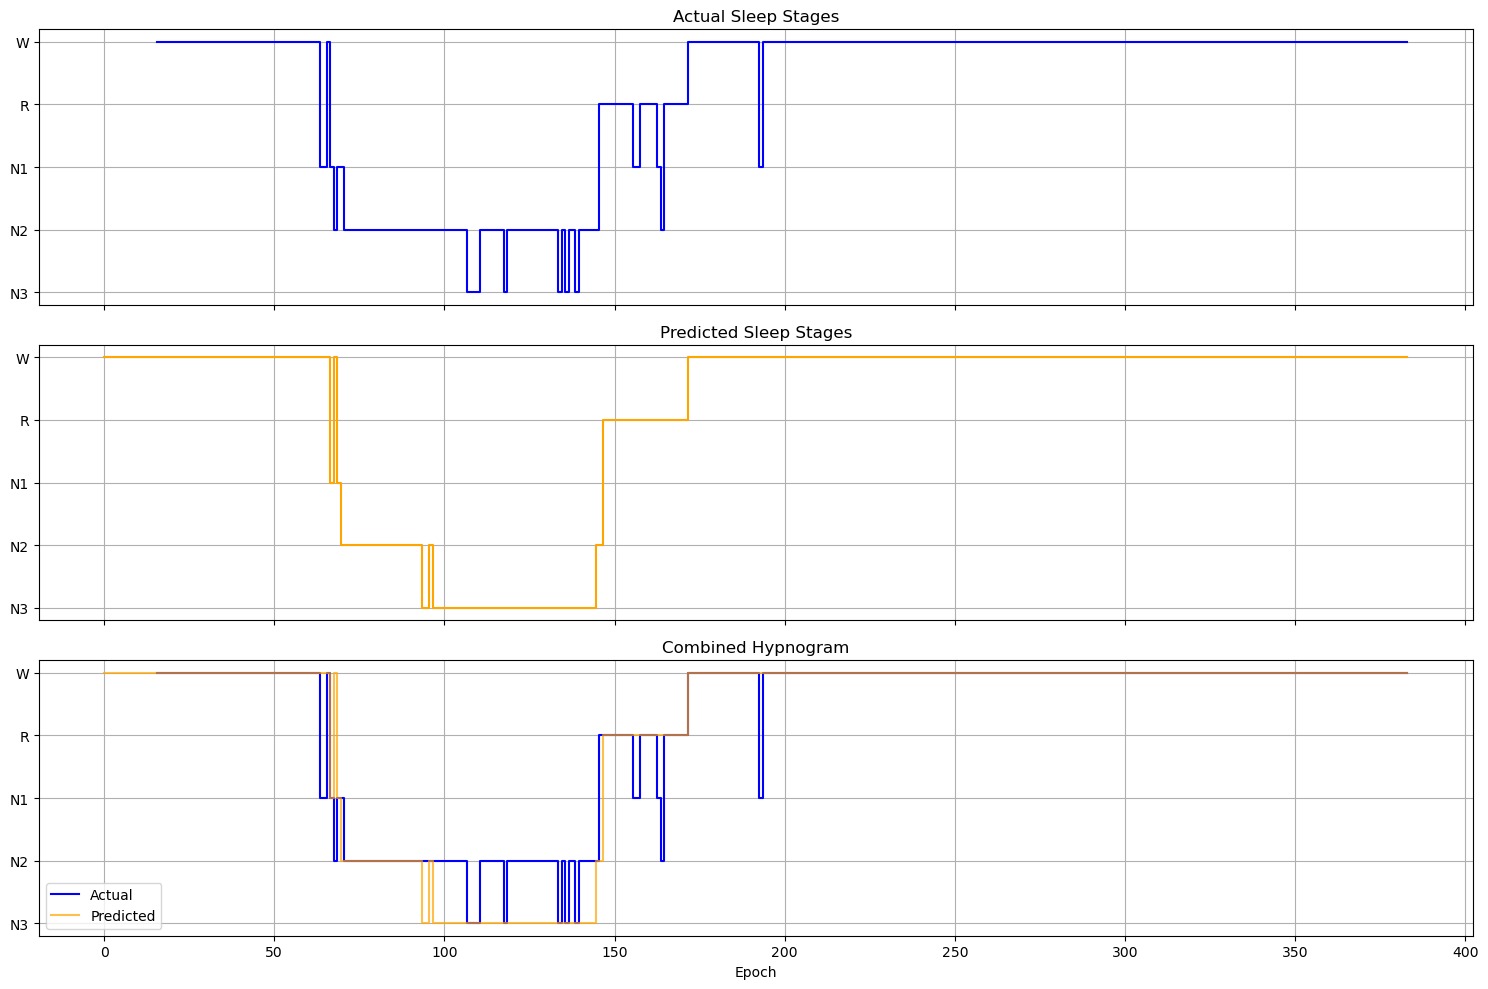

BAD [I0002150932292-1] Acc=0.69 F1=0.68 Kappa=0.54 Precision=0.51 Recall=0.51 Specificity=0.51 Score=0.59 


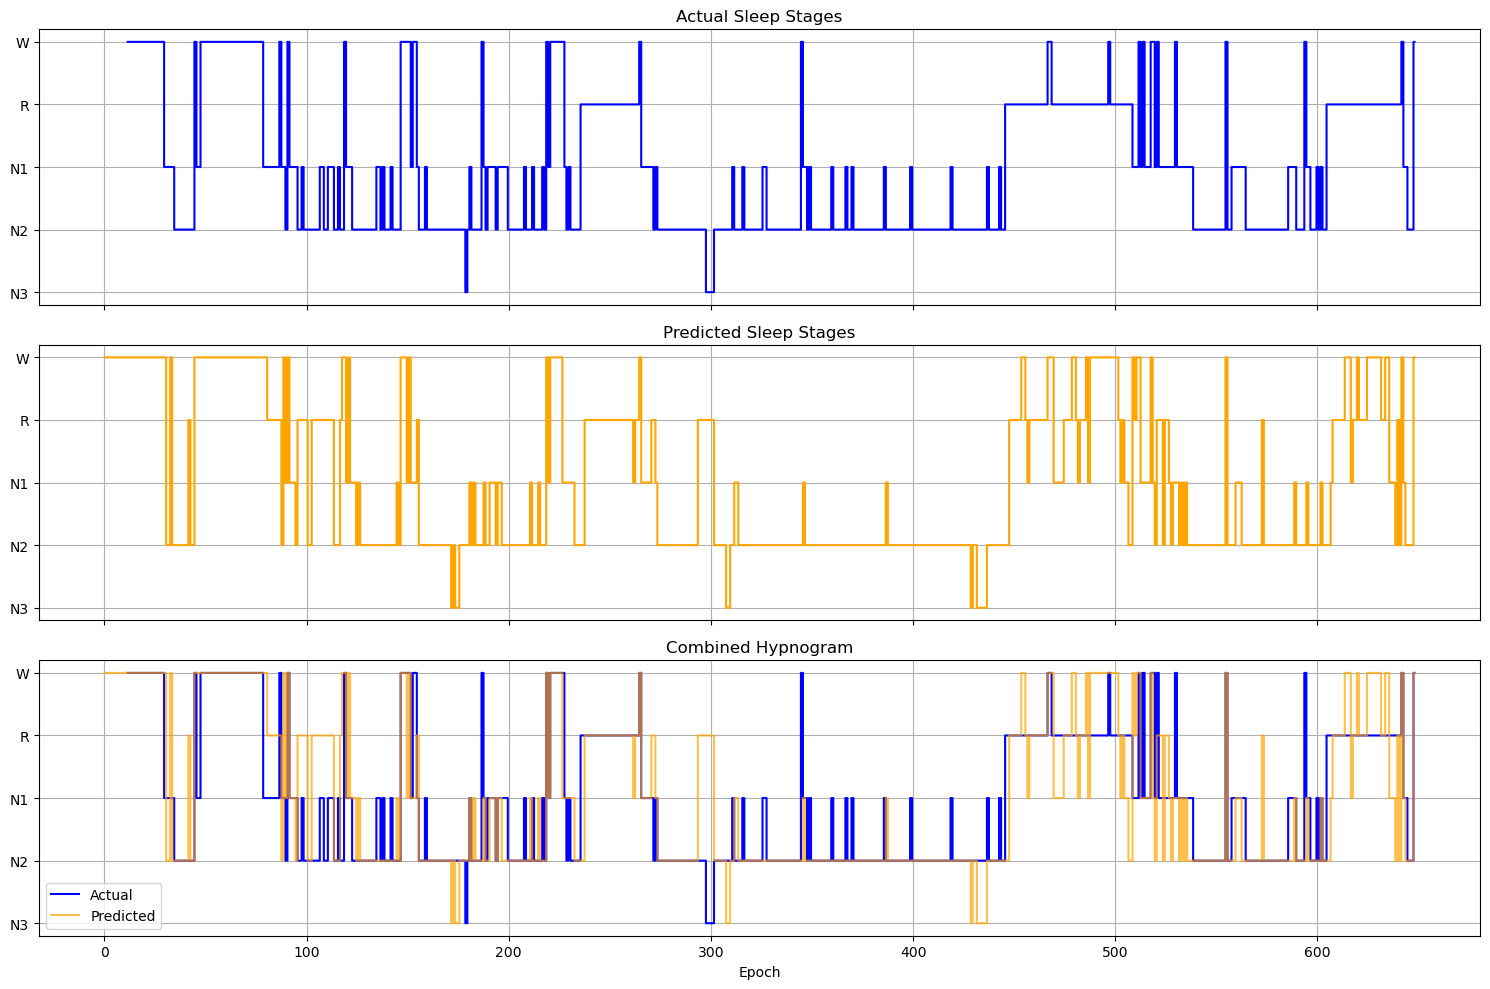

BAD [I0002150961258-1] Acc=0.62 F1=0.60 Kappa=0.47 Precision=0.46 Recall=0.57 Specificity=0.57 Score=0.55 


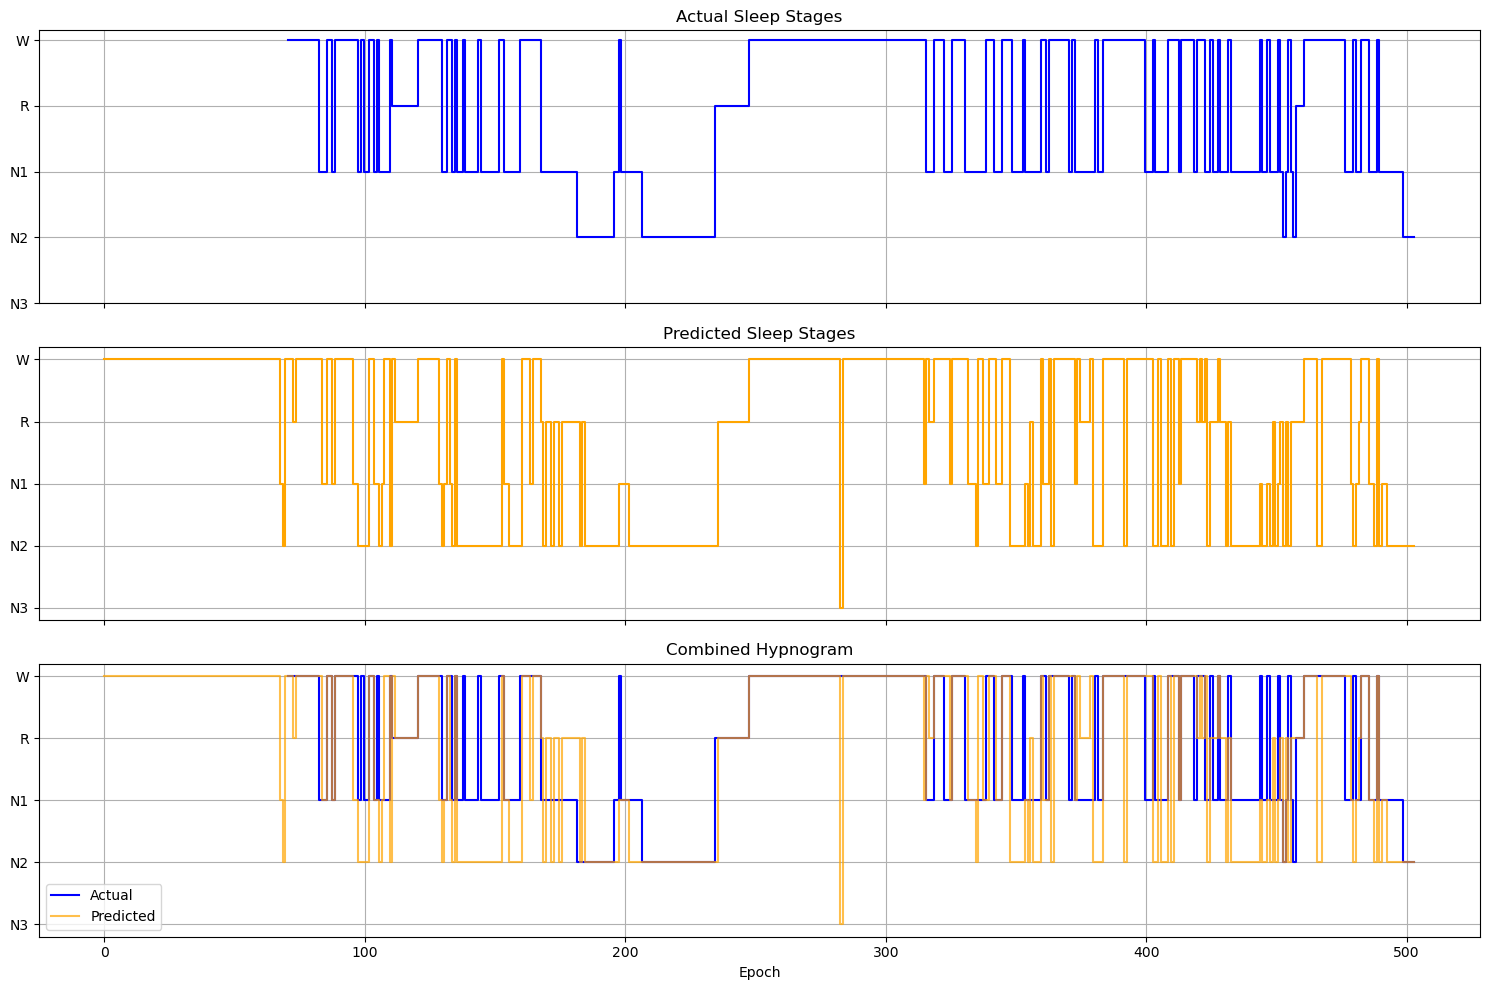

BAD [I0002150992641-1] Acc=0.82 F1=0.80 Kappa=0.45 Precision=0.57 Recall=0.43 Specificity=0.43 Score=0.63 


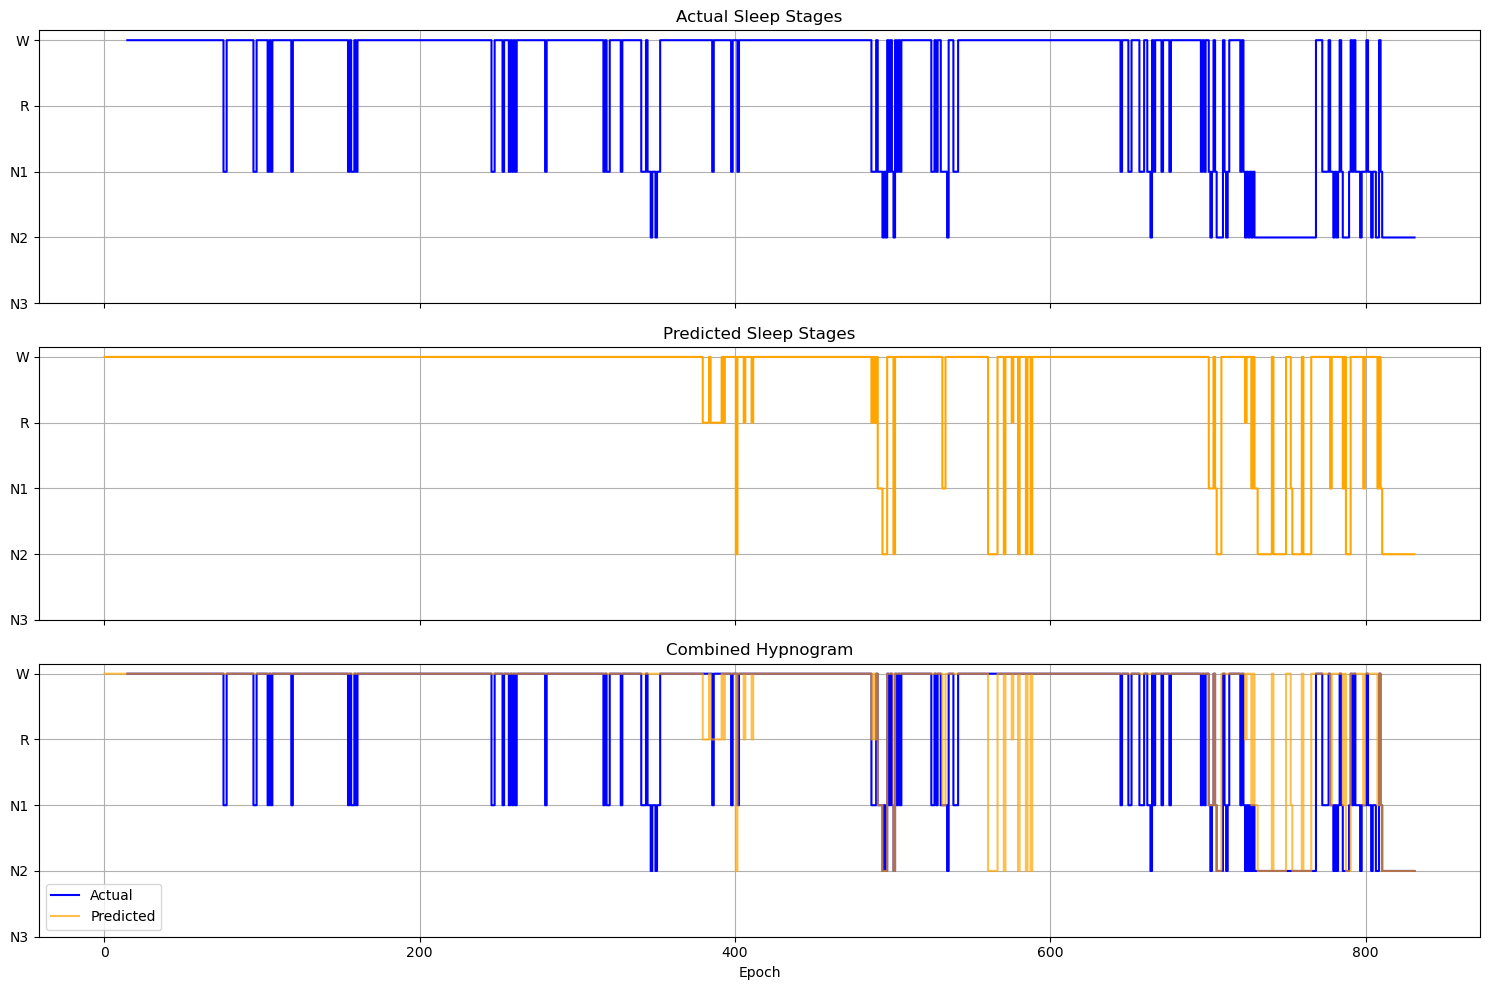

BAD [I0002151065364-1] Acc=0.65 F1=0.69 Kappa=0.51 Precision=0.55 Recall=0.74 Specificity=0.74 Score=0.63 


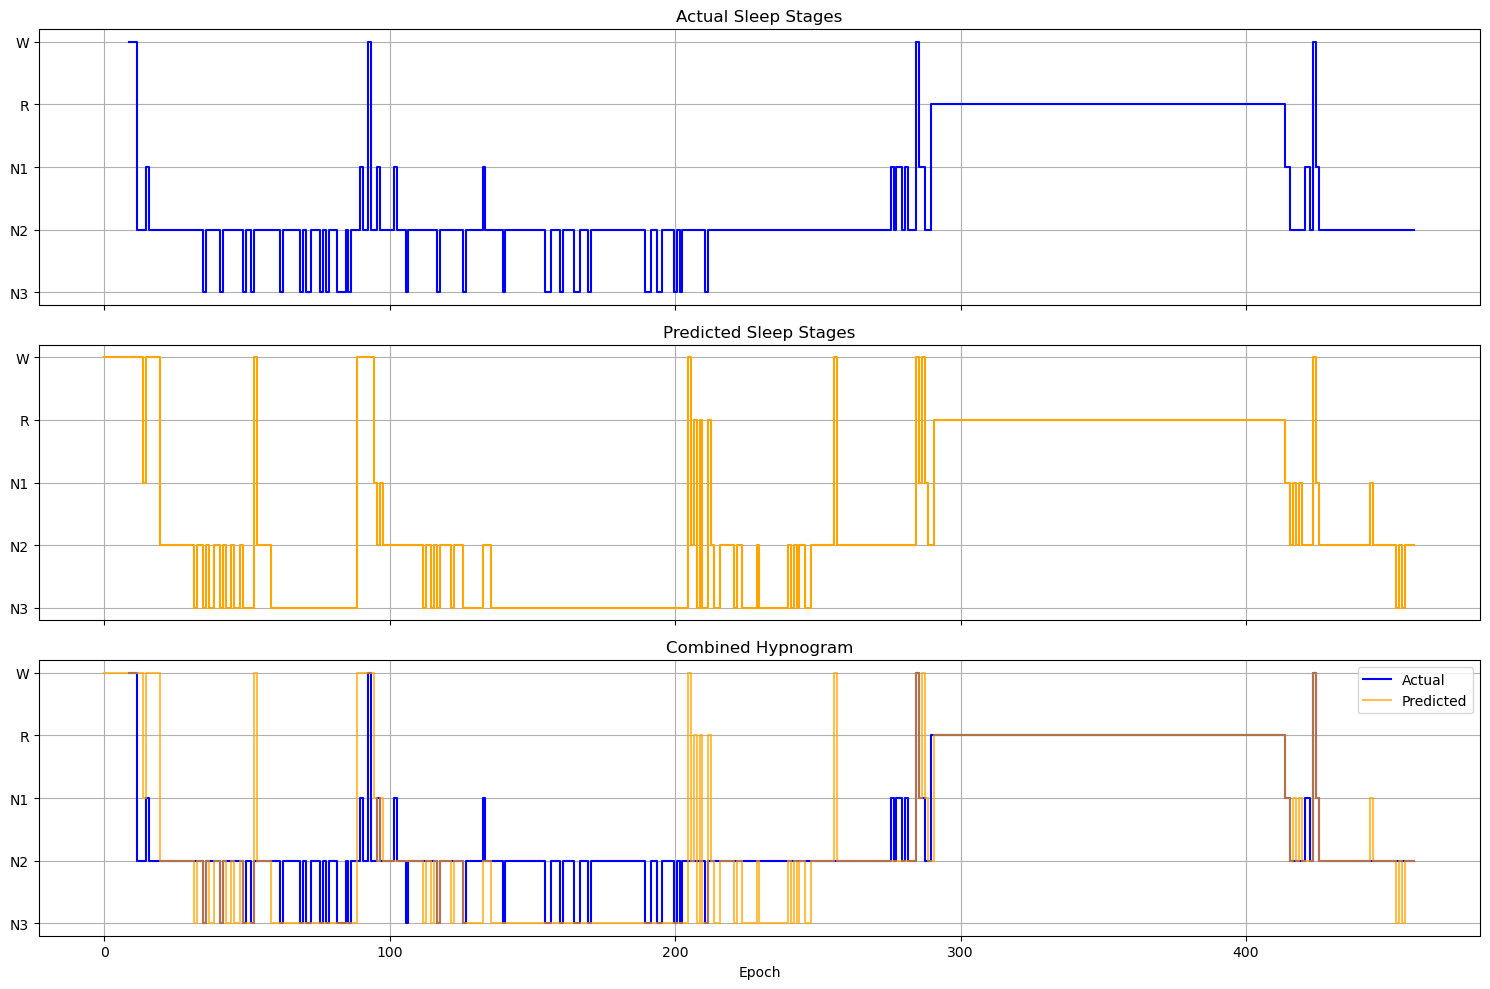

REVIEW [I0002151114878-1] Acc=0.74 F1=0.77 Kappa=0.56 Precision=0.61 Recall=0.74 Specificity=0.74 Score=0.69 


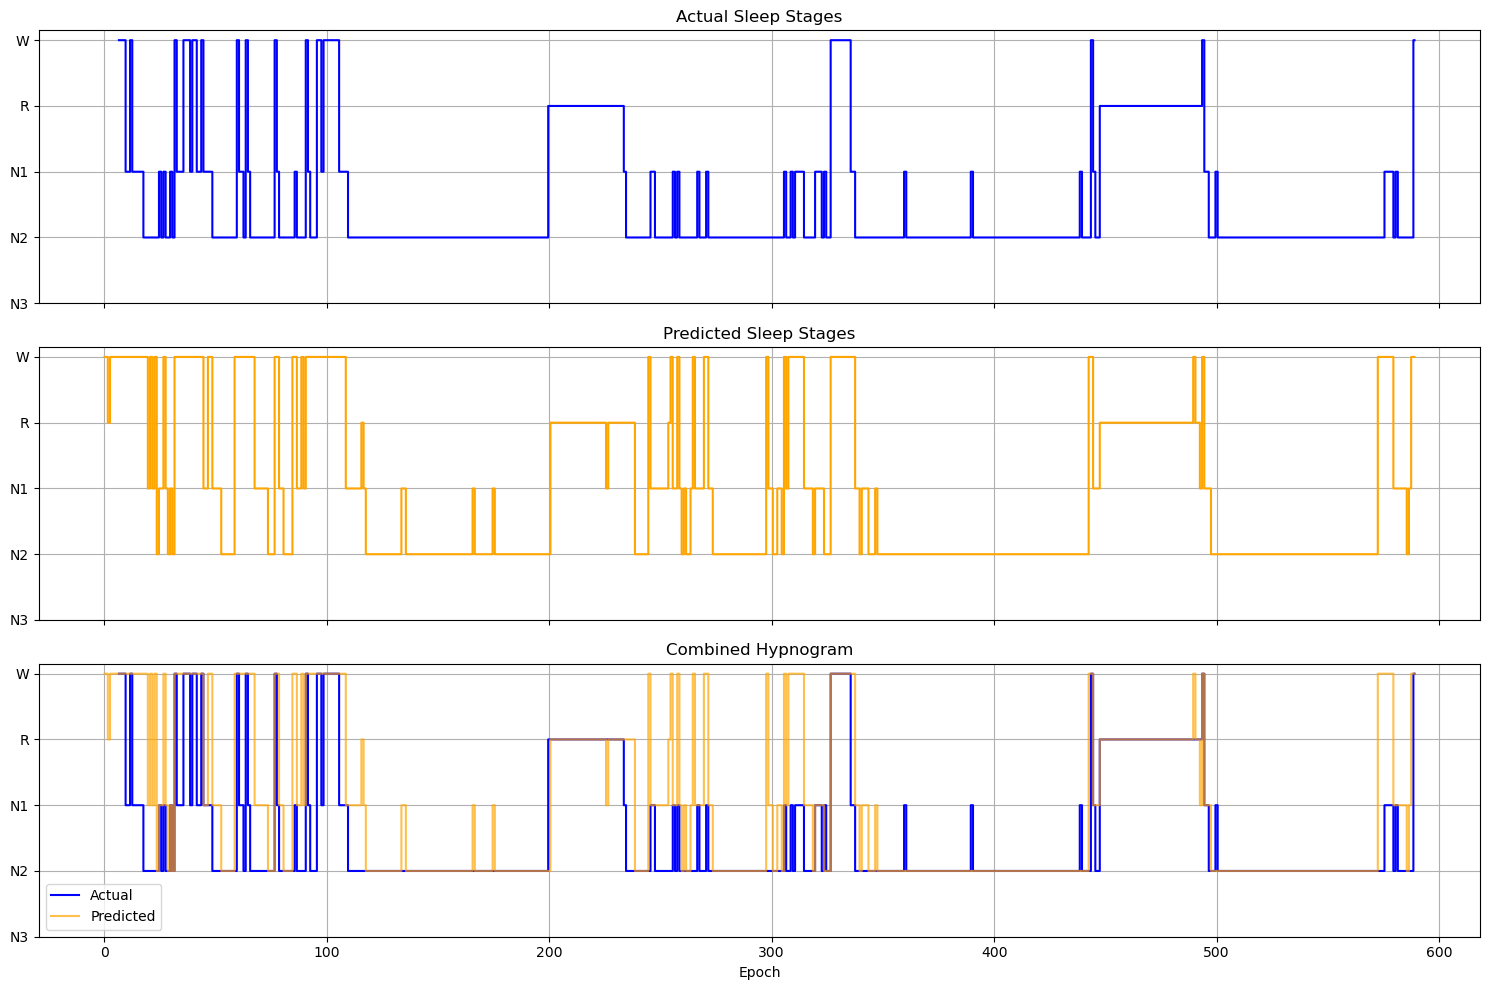

REVIEW [I0002151117400-1] Acc=0.85 F1=0.85 Kappa=0.76 Precision=0.57 Recall=0.62 Specificity=0.62 Score=0.75 


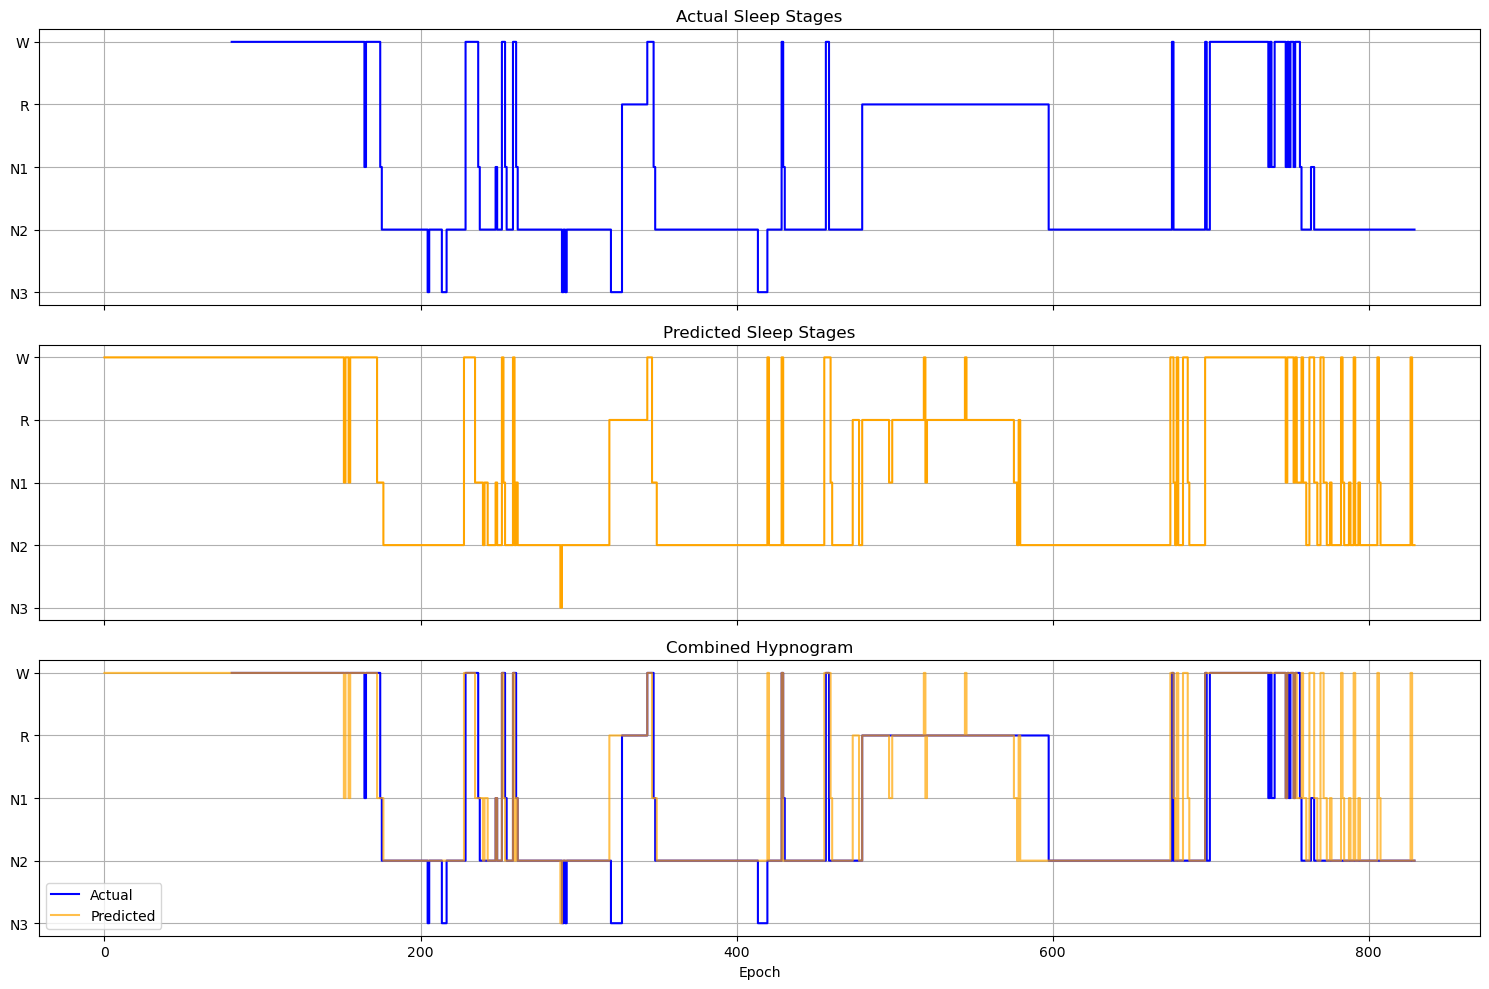

BAD [I0002151123460-1] Acc=0.68 F1=0.70 Kappa=0.53 Precision=0.58 Recall=0.65 Specificity=0.65 Score=0.63 


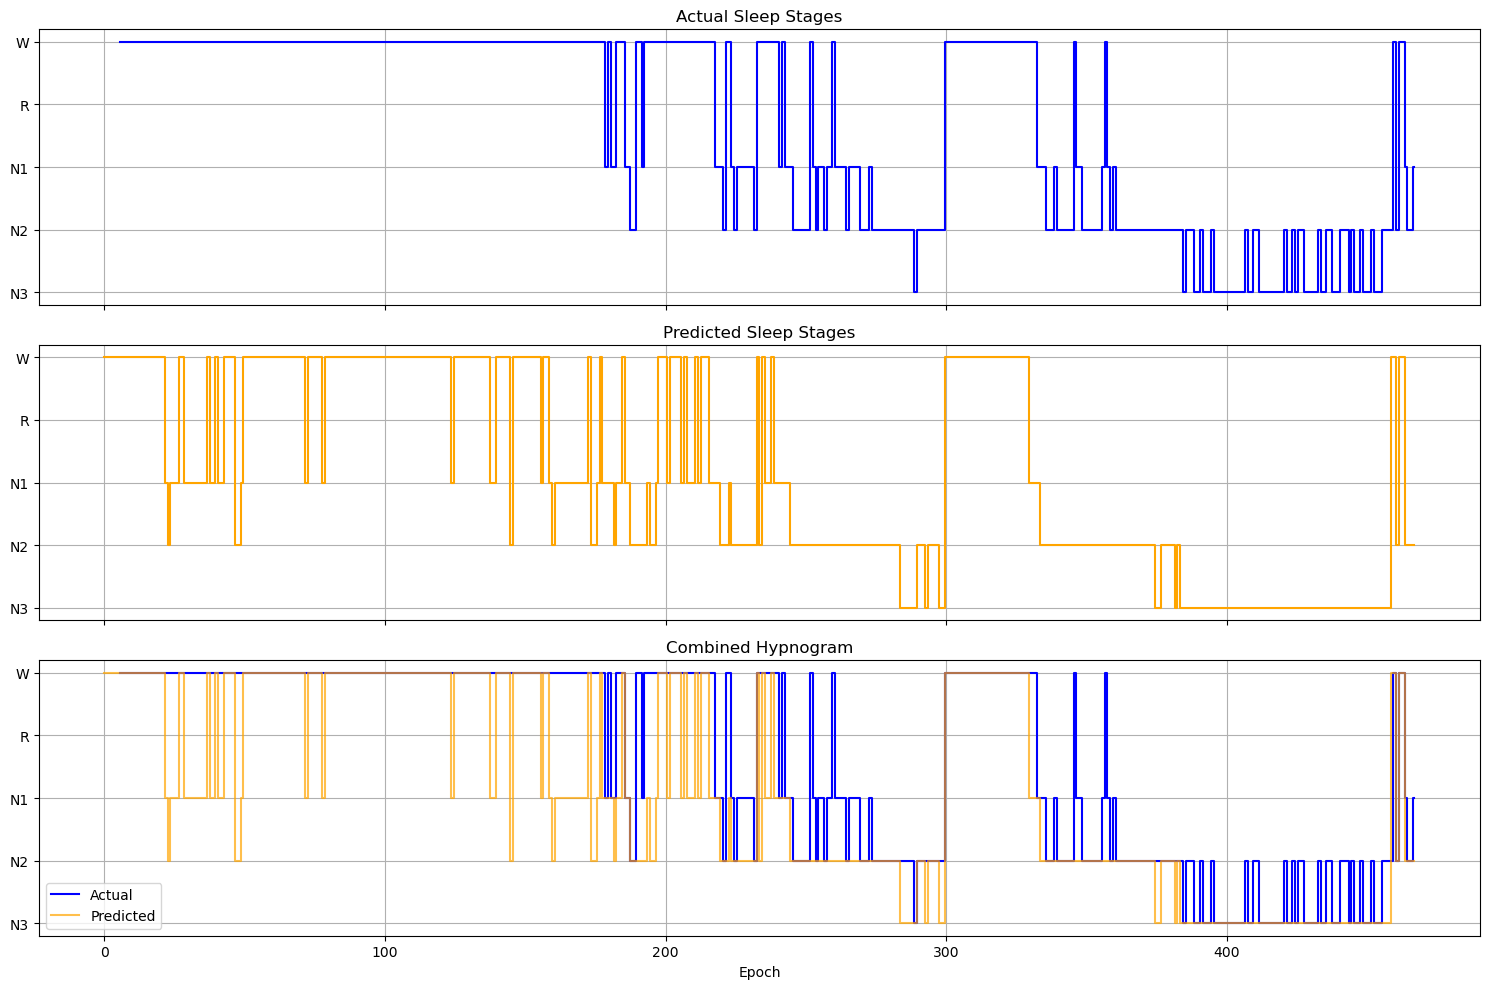

BAD [I0002151191192-1] Acc=0.65 F1=0.69 Kappa=0.46 Precision=0.40 Recall=0.33 Specificity=0.33 Score=0.52 


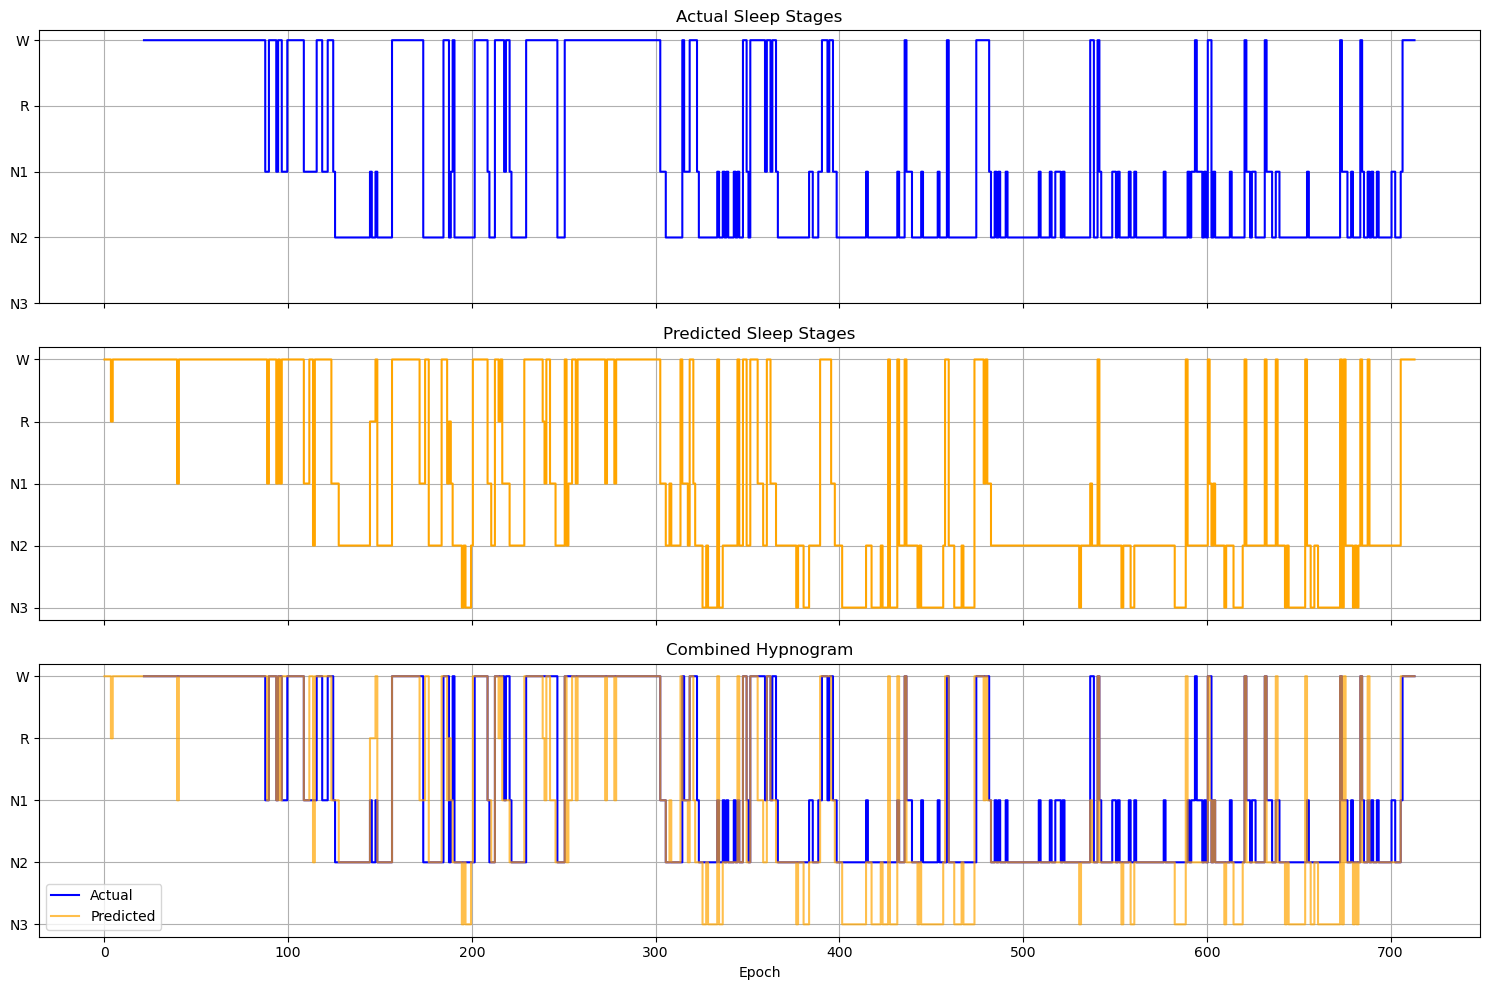

GOOD [I0002151255711-1] Acc=0.89 F1=0.88 Kappa=0.84 Precision=0.67 Recall=0.68 Specificity=0.68 Score=0.80 


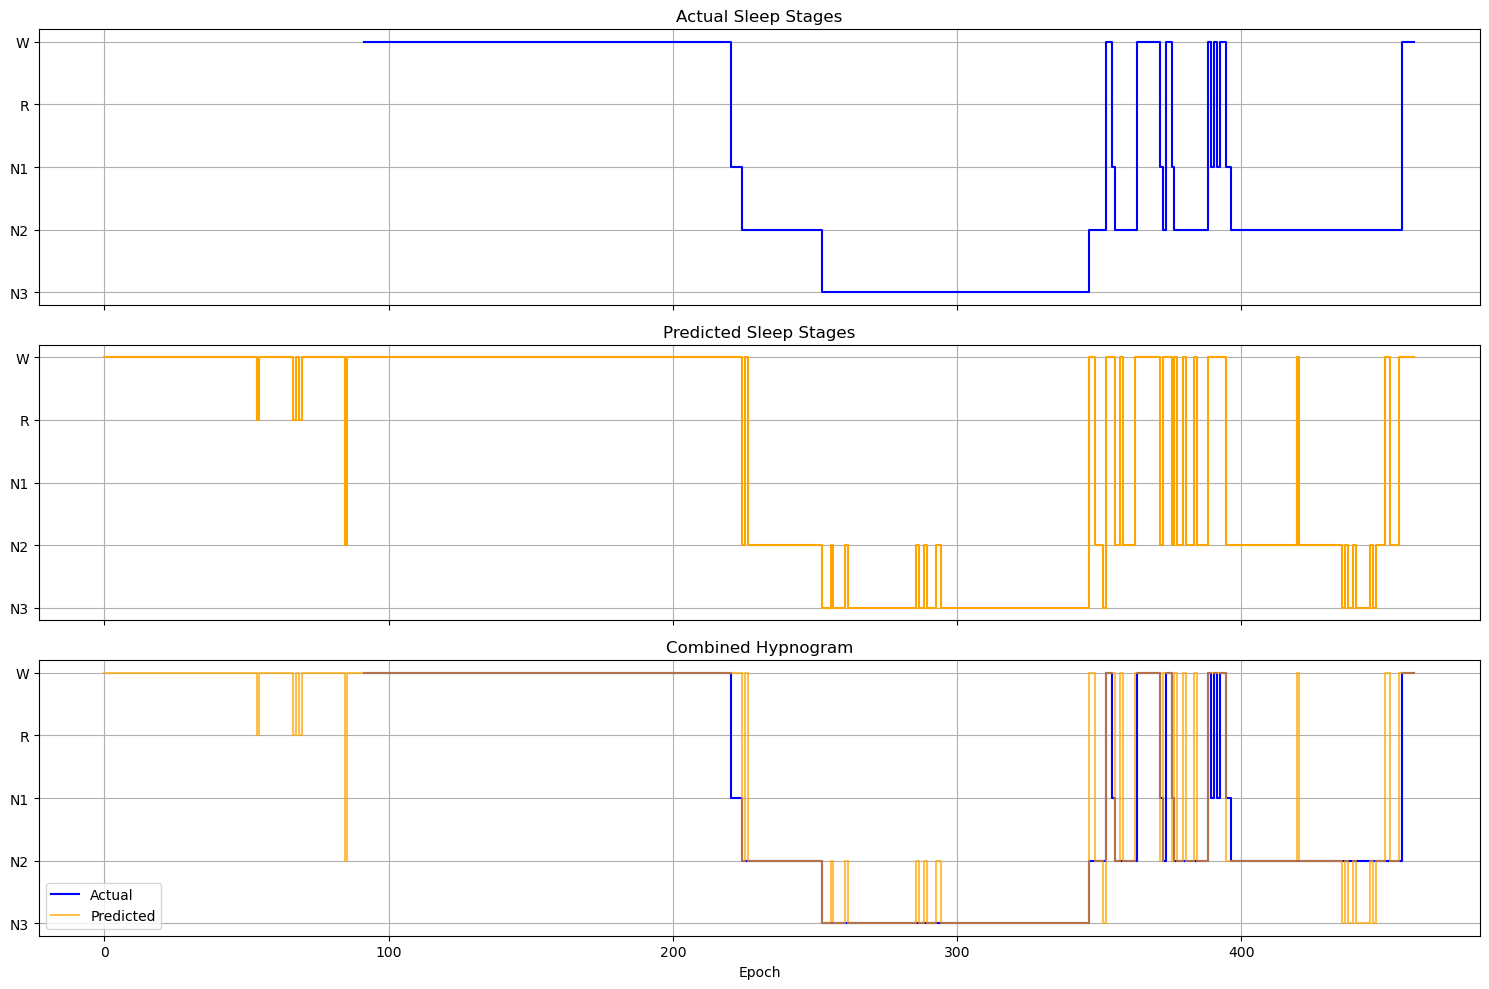

REVIEW [I0002151260928-1] Acc=0.71 F1=0.72 Kappa=0.58 Precision=0.58 Recall=0.77 Specificity=0.77 Score=0.68 


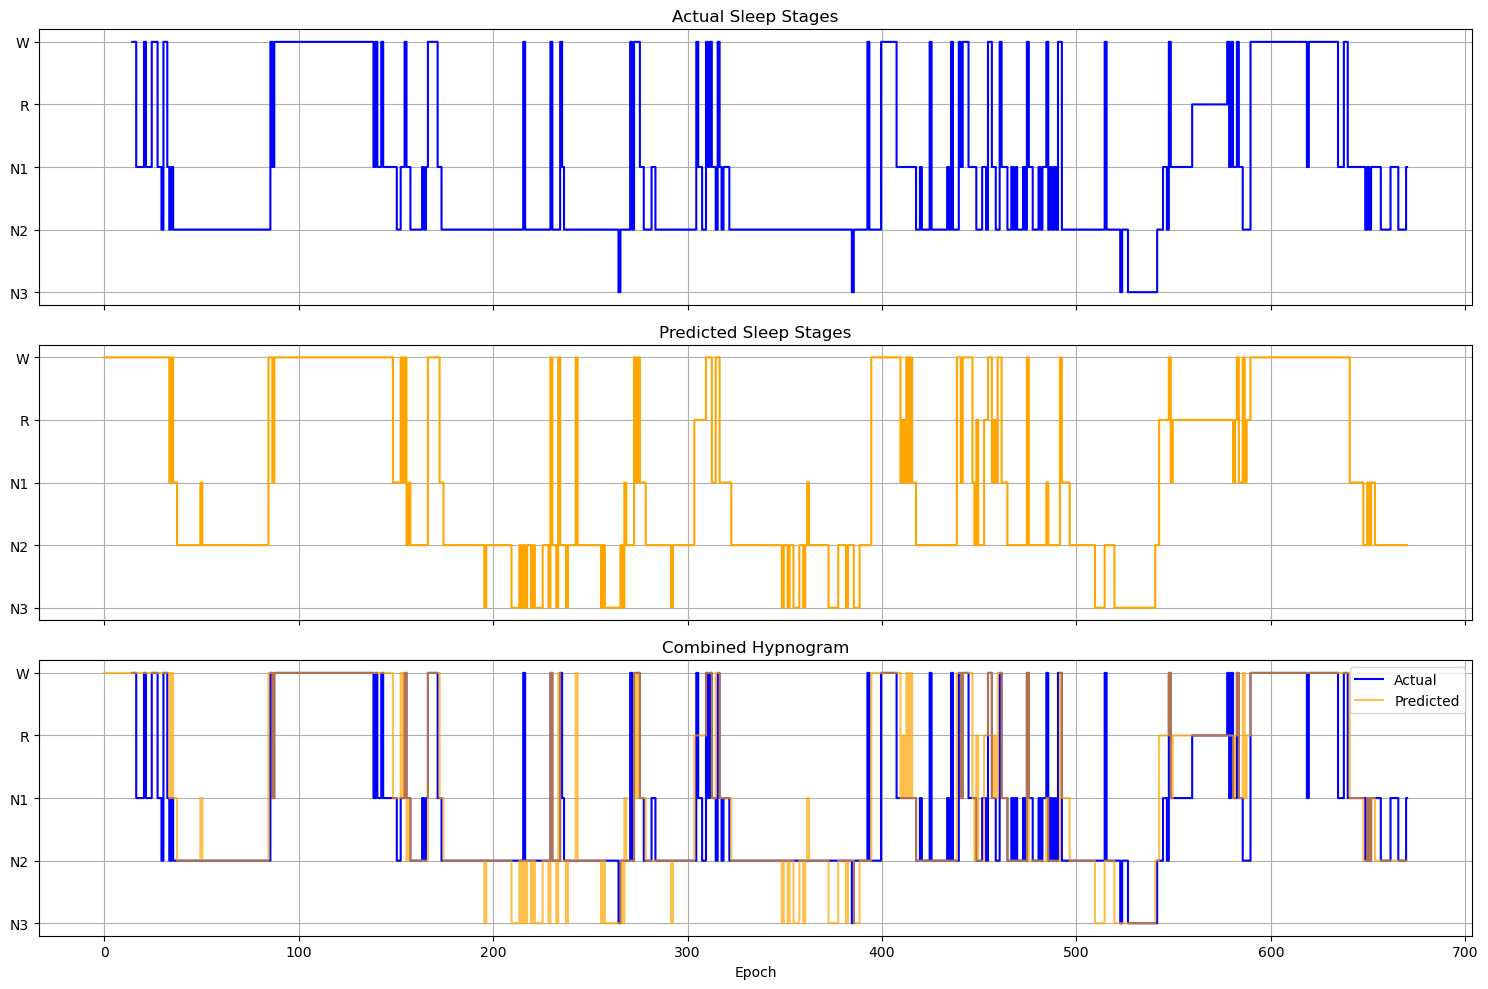

REVIEW [I0002151273221-1] Acc=0.77 F1=0.81 Kappa=0.62 Precision=0.58 Recall=0.61 Specificity=0.61 Score=0.69 


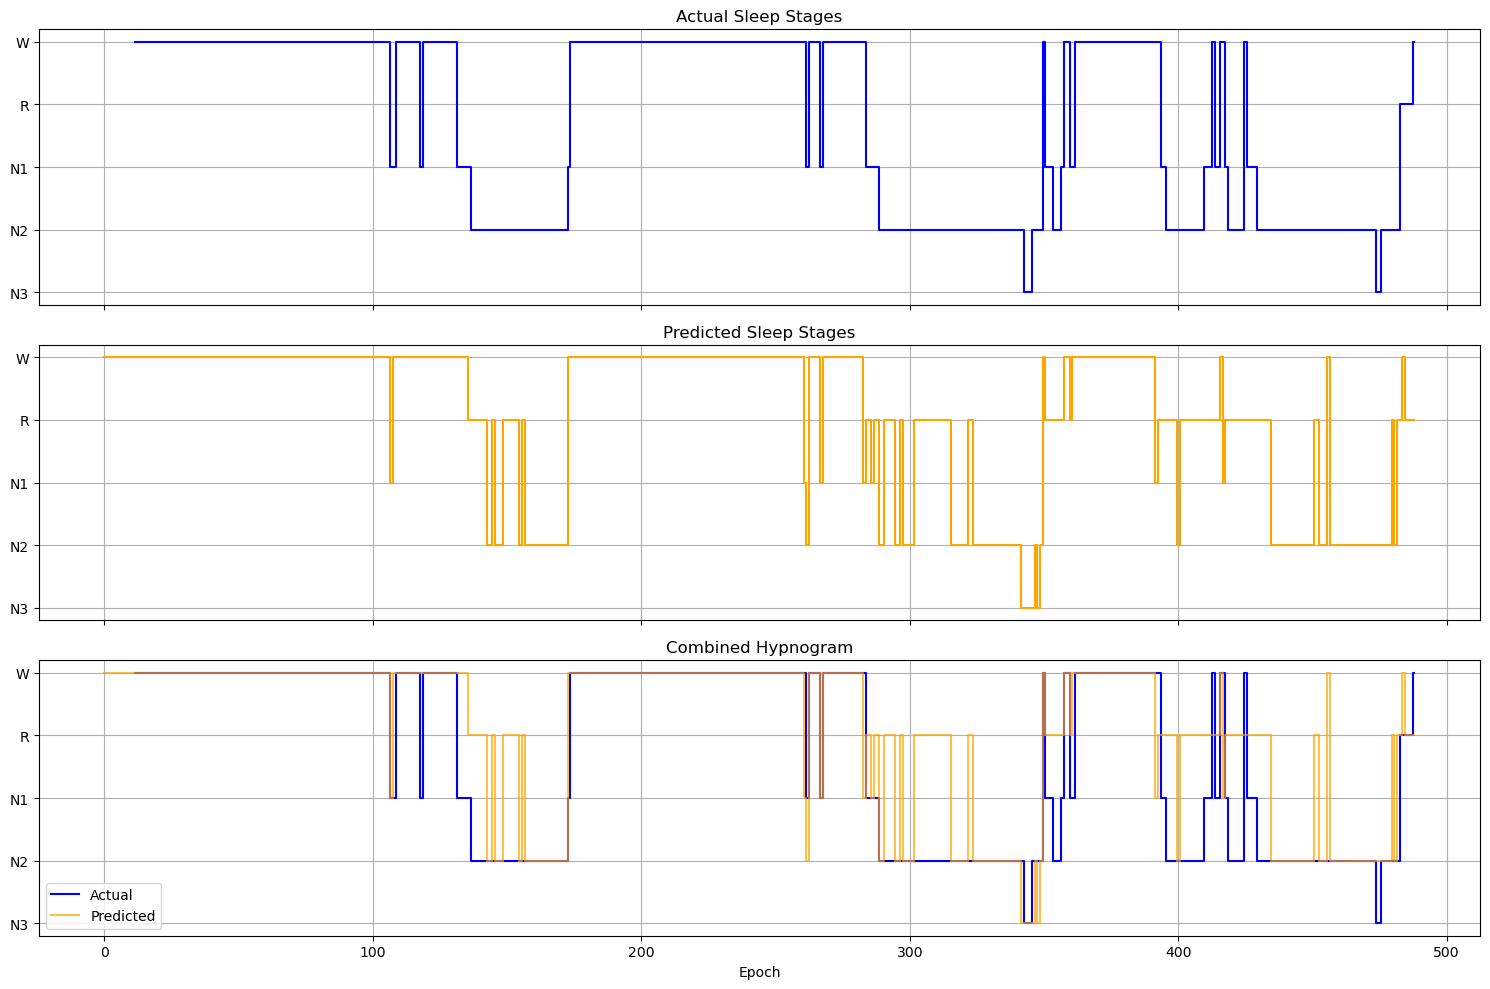

REVIEW [I0002151278908-1] Acc=0.73 F1=0.78 Kappa=0.53 Precision=0.60 Recall=0.63 Specificity=0.63 Score=0.66 


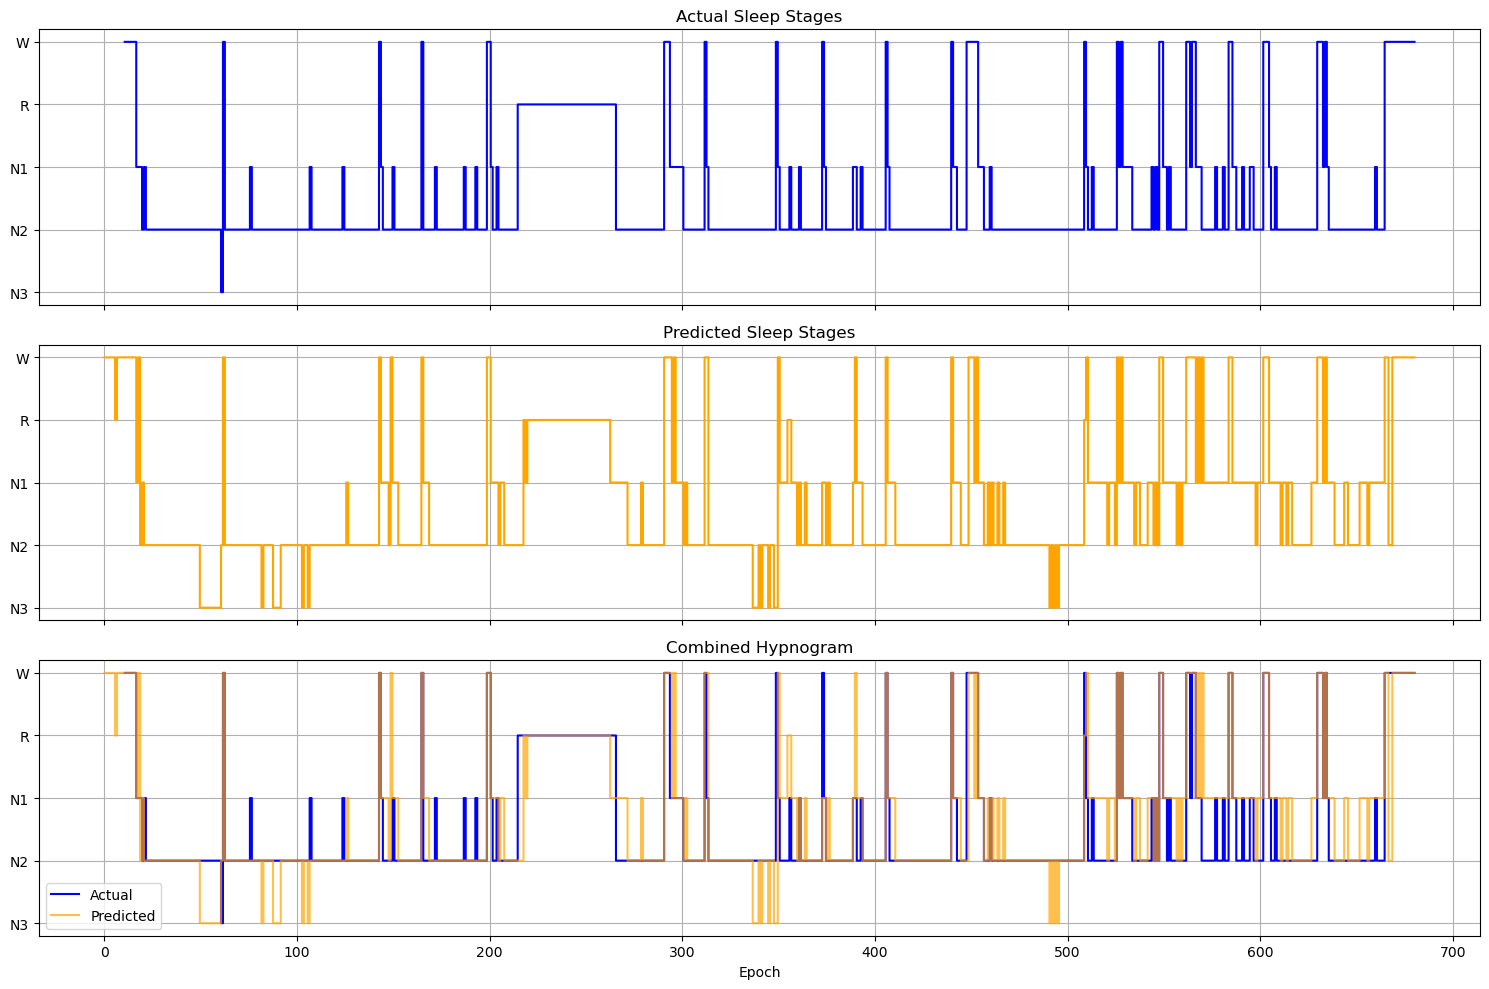

GOOD [I0002151281844-2] Acc=0.88 F1=0.83 Kappa=0.57 Precision=0.86 Recall=0.66 Specificity=0.66 Score=0.76 


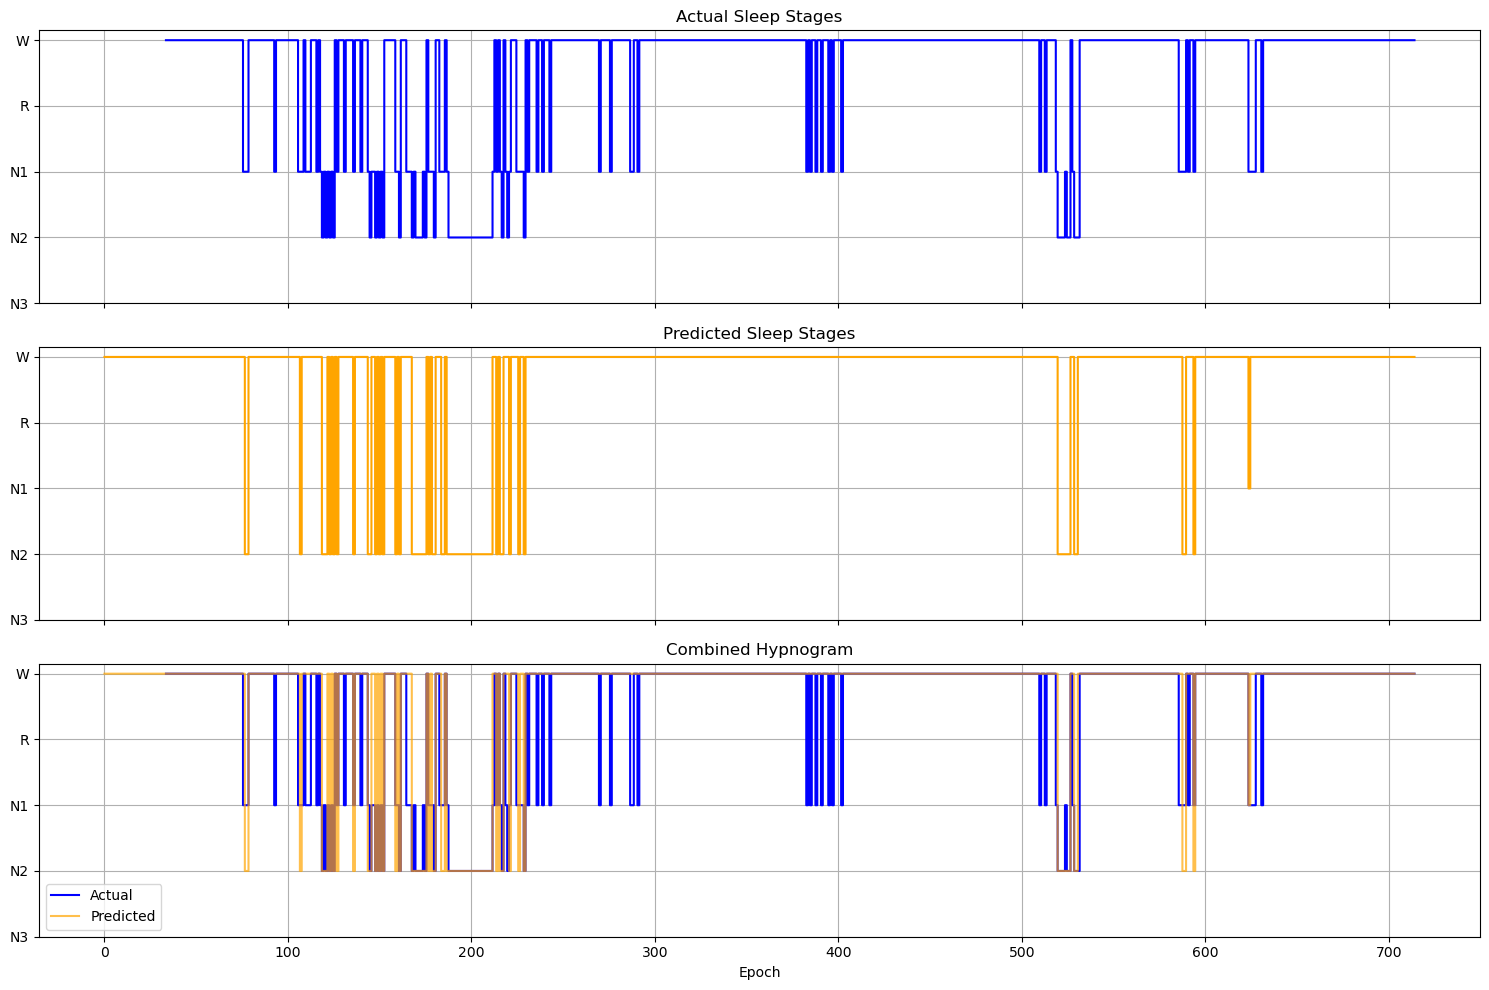

GOOD [I0002151340227-1] Acc=0.87 F1=0.89 Kappa=0.76 Precision=0.62 Recall=0.67 Specificity=0.67 Score=0.78 


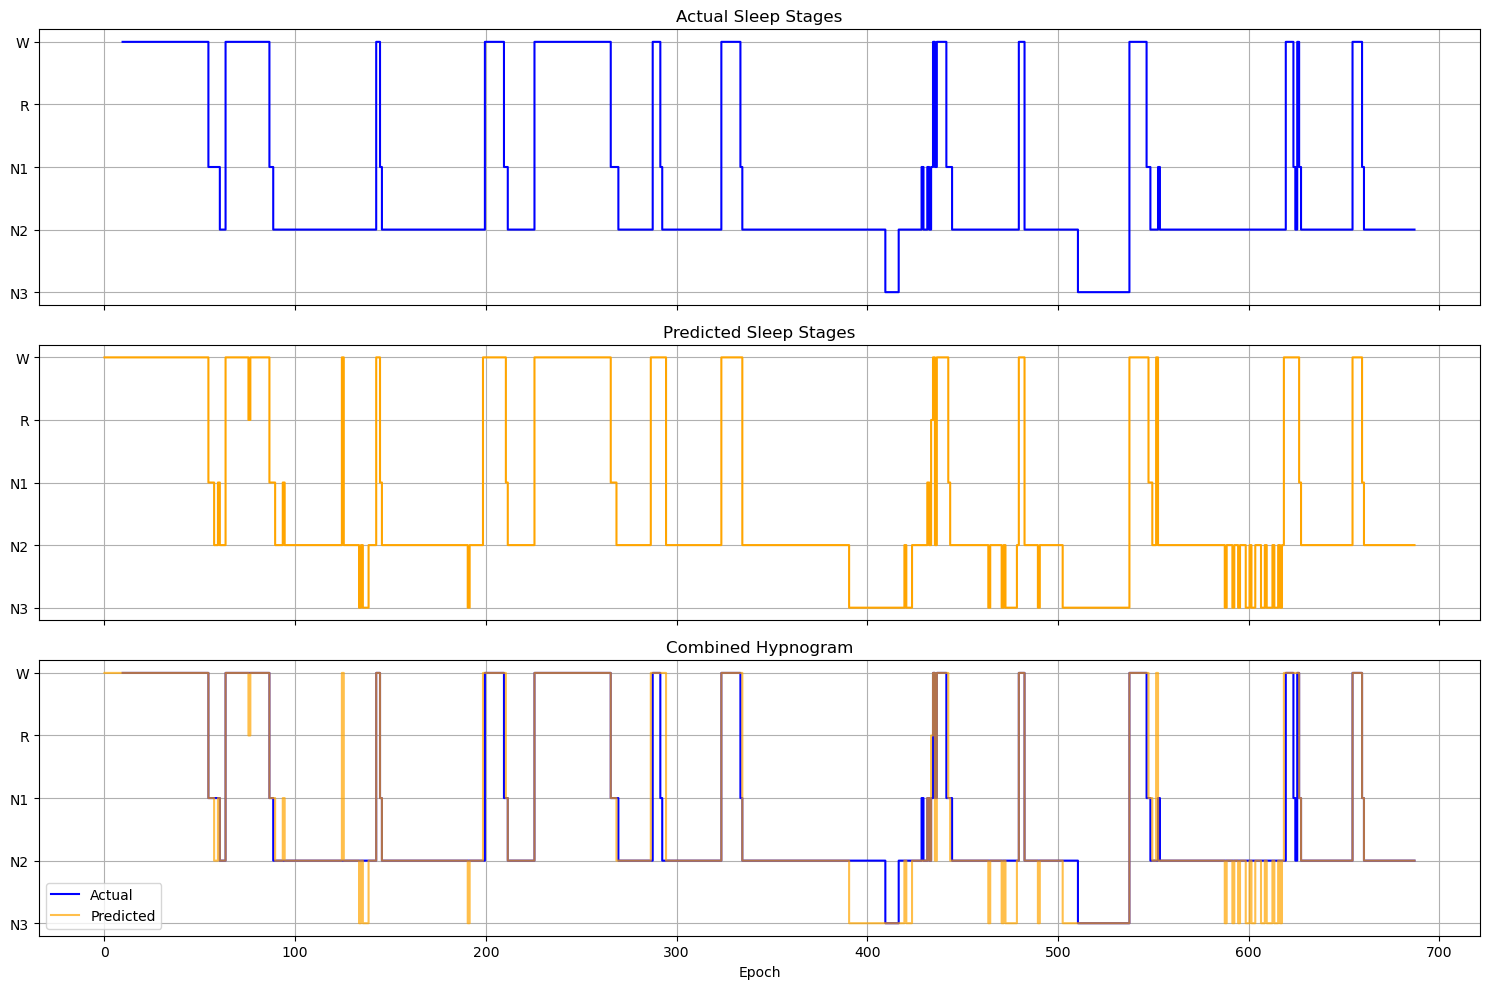

REVIEW [I0002151369599-1] Acc=0.73 F1=0.74 Kappa=0.62 Precision=0.70 Recall=0.70 Specificity=0.70 Score=0.70 


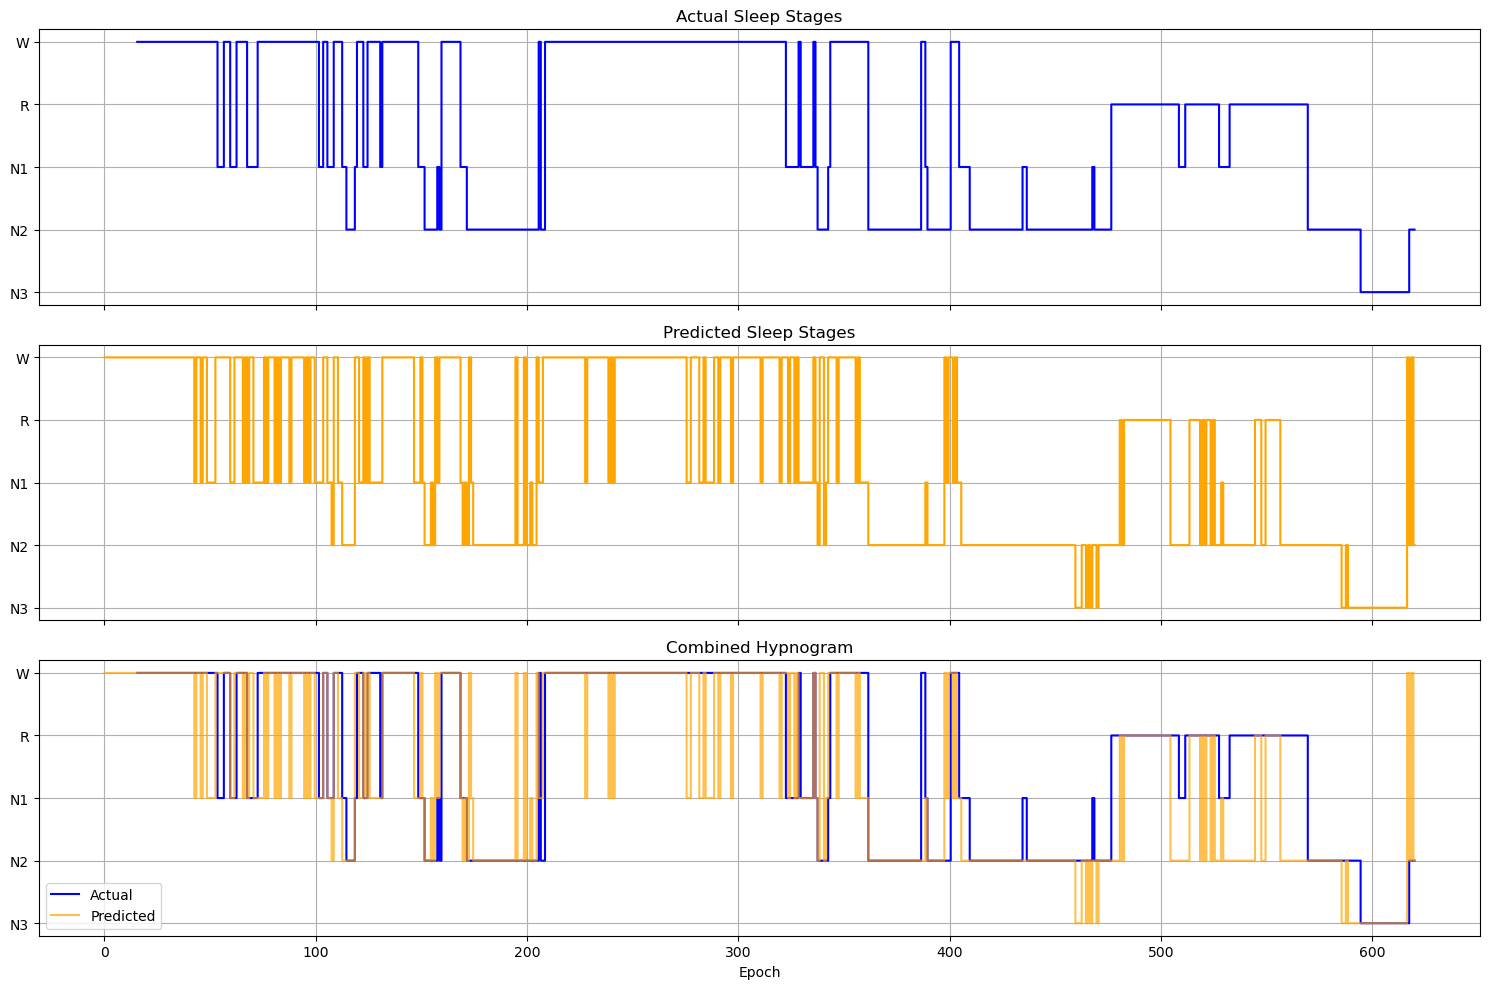

BAD [I0002151379683-1] Acc=0.62 F1=0.70 Kappa=0.35 Precision=0.36 Recall=0.33 Specificity=0.33 Score=0.49 


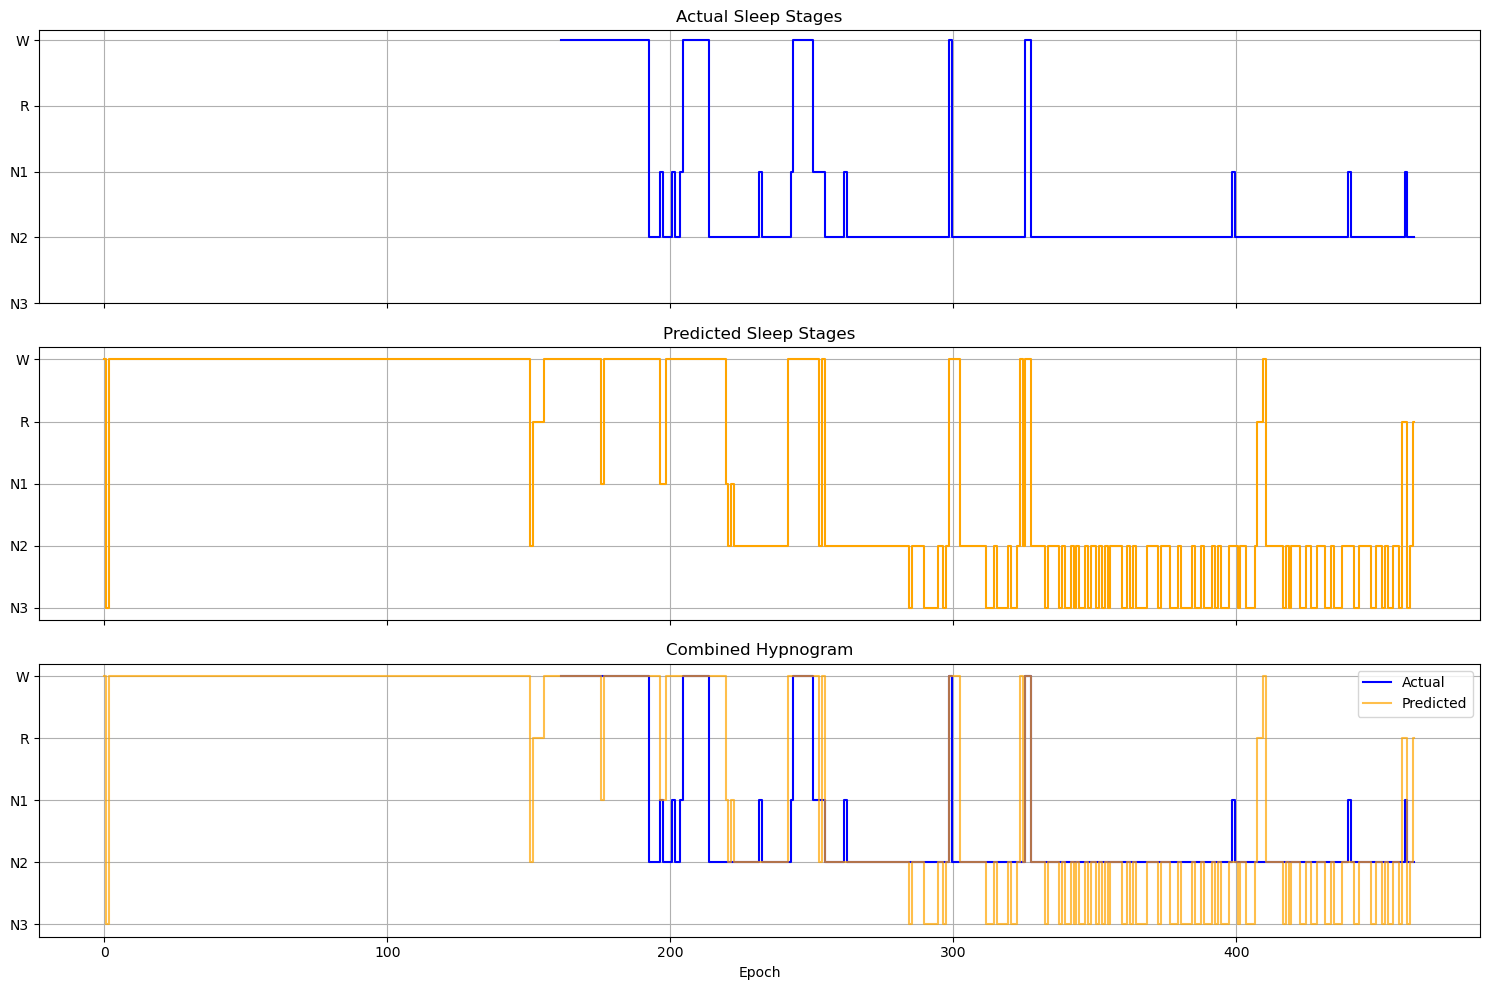

GOOD [I0002151669068-1] Acc=0.82 F1=0.83 Kappa=0.72 Precision=0.69 Recall=0.77 Specificity=0.77 Score=0.77 


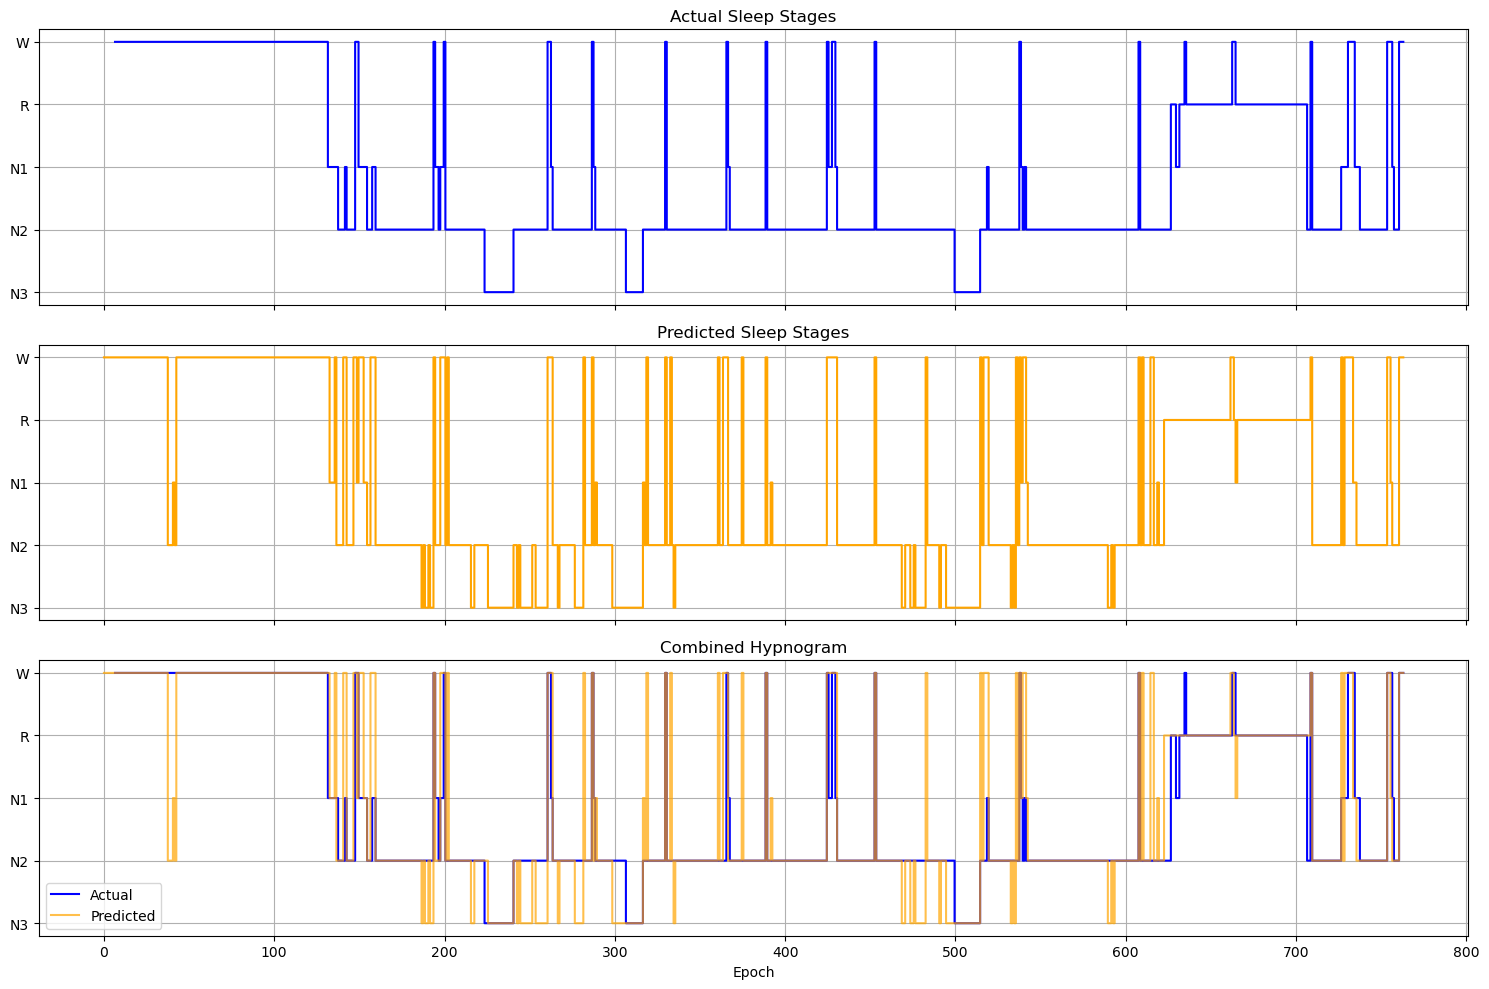

GOOD [I0002151694957-1] Acc=0.85 F1=0.83 Kappa=0.77 Precision=0.81 Recall=0.71 Specificity=0.71 Score=0.80 


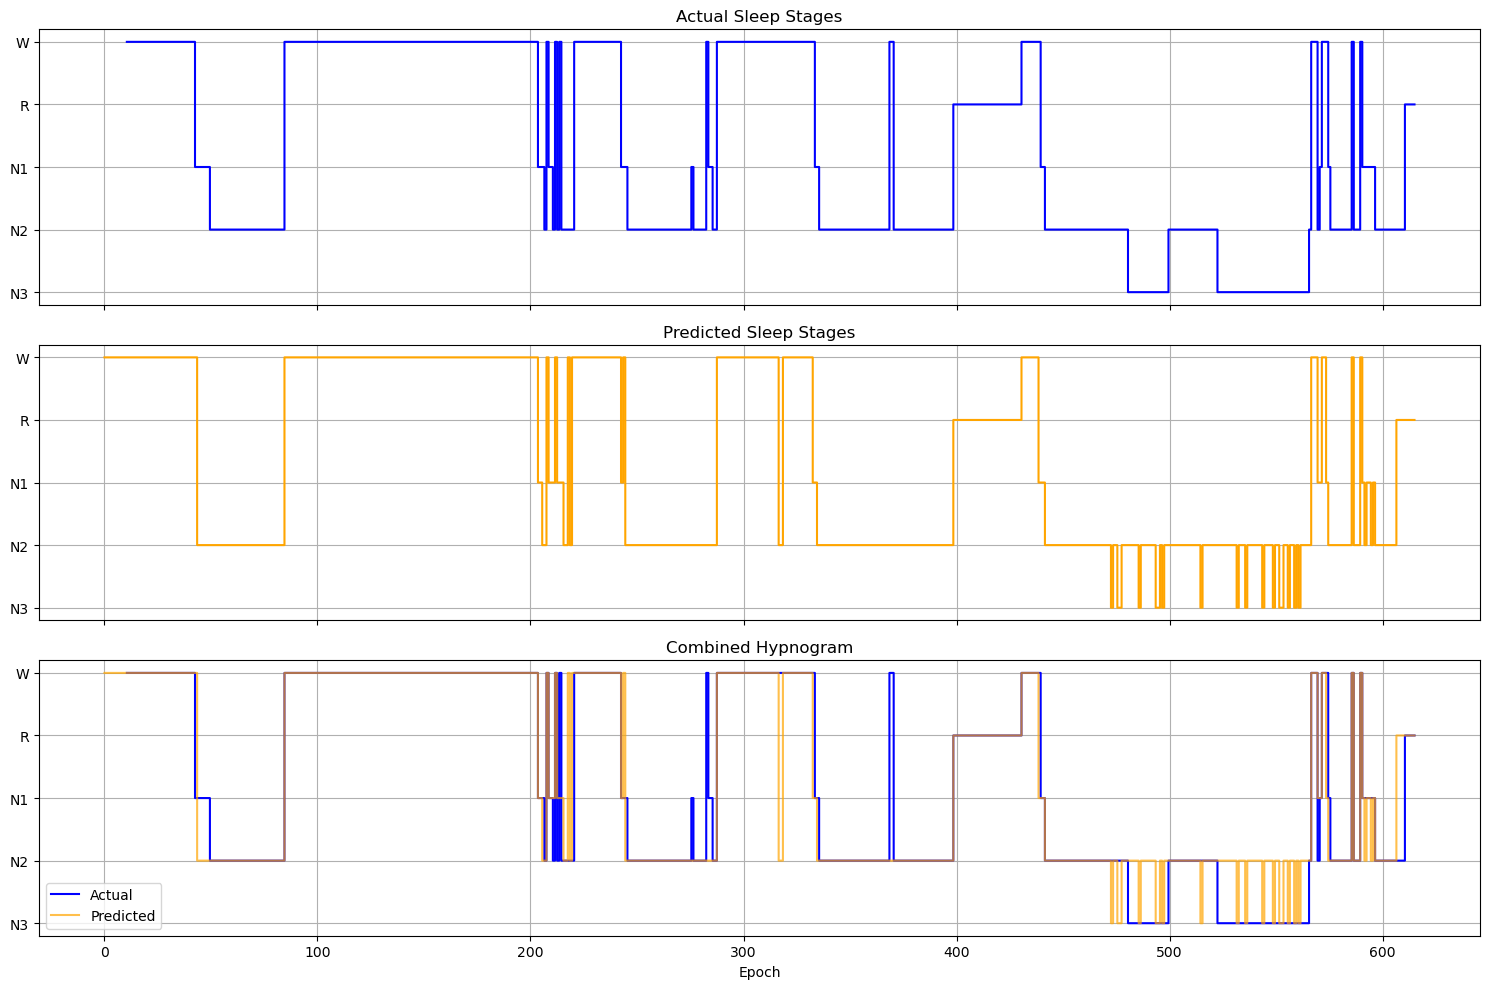

GOOD [I0002151702574-1] Acc=0.94 F1=0.92 Kappa=0.88 Precision=0.76 Recall=0.73 Specificity=0.73 Score=0.85 


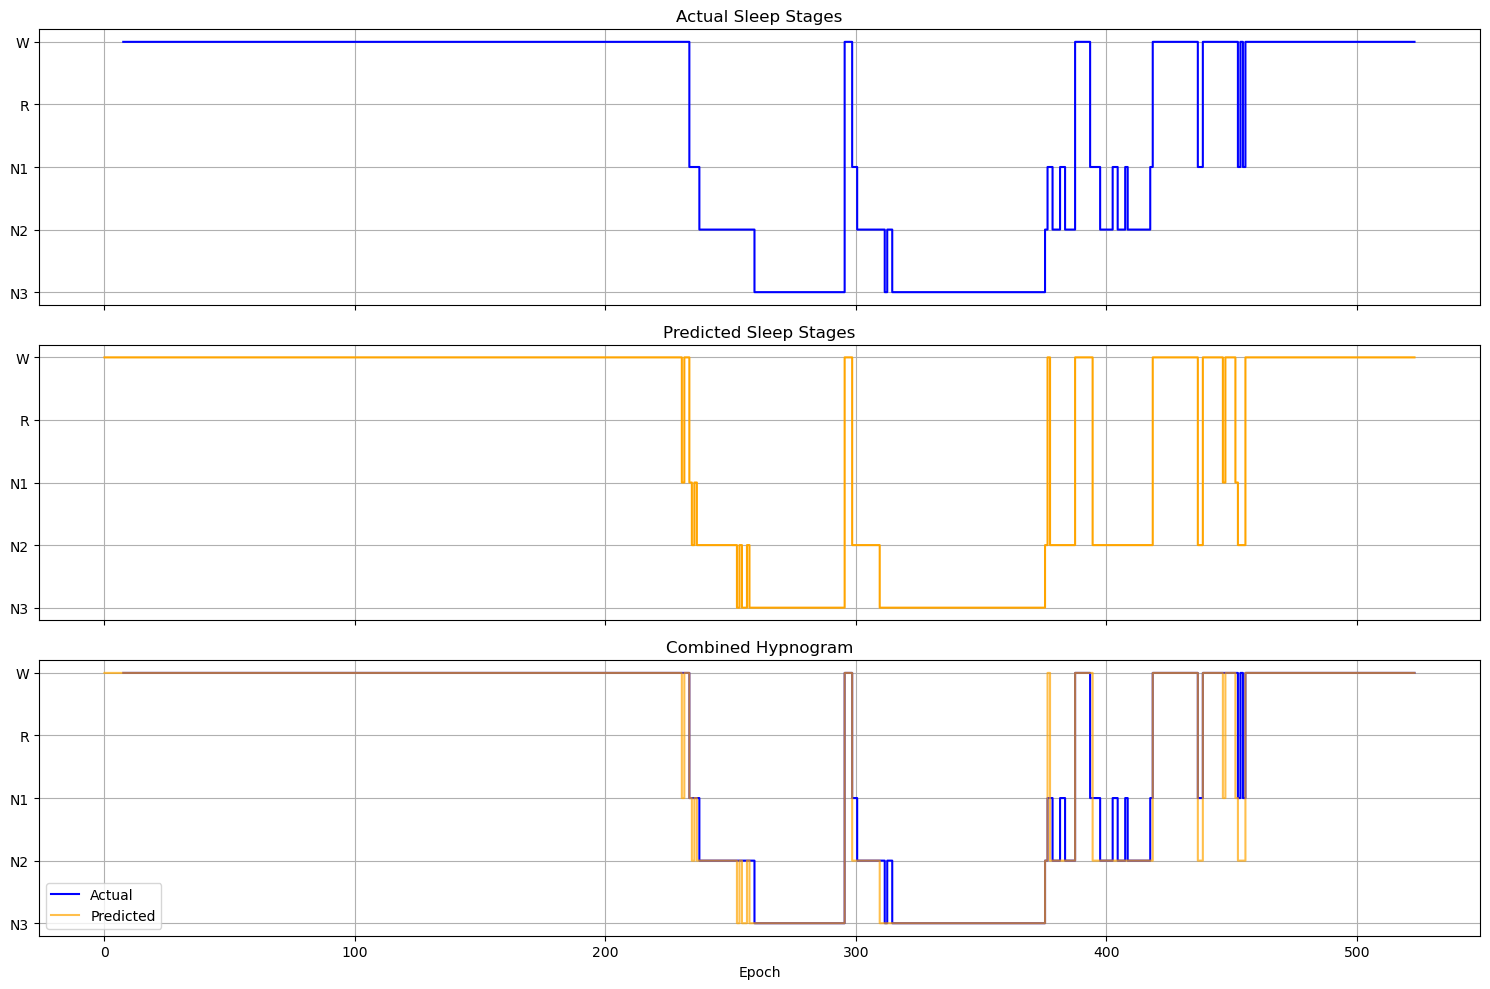

GOOD [I0002151704170-1] Acc=0.84 F1=0.82 Kappa=0.78 Precision=0.65 Recall=0.62 Specificity=0.62 Score=0.75 


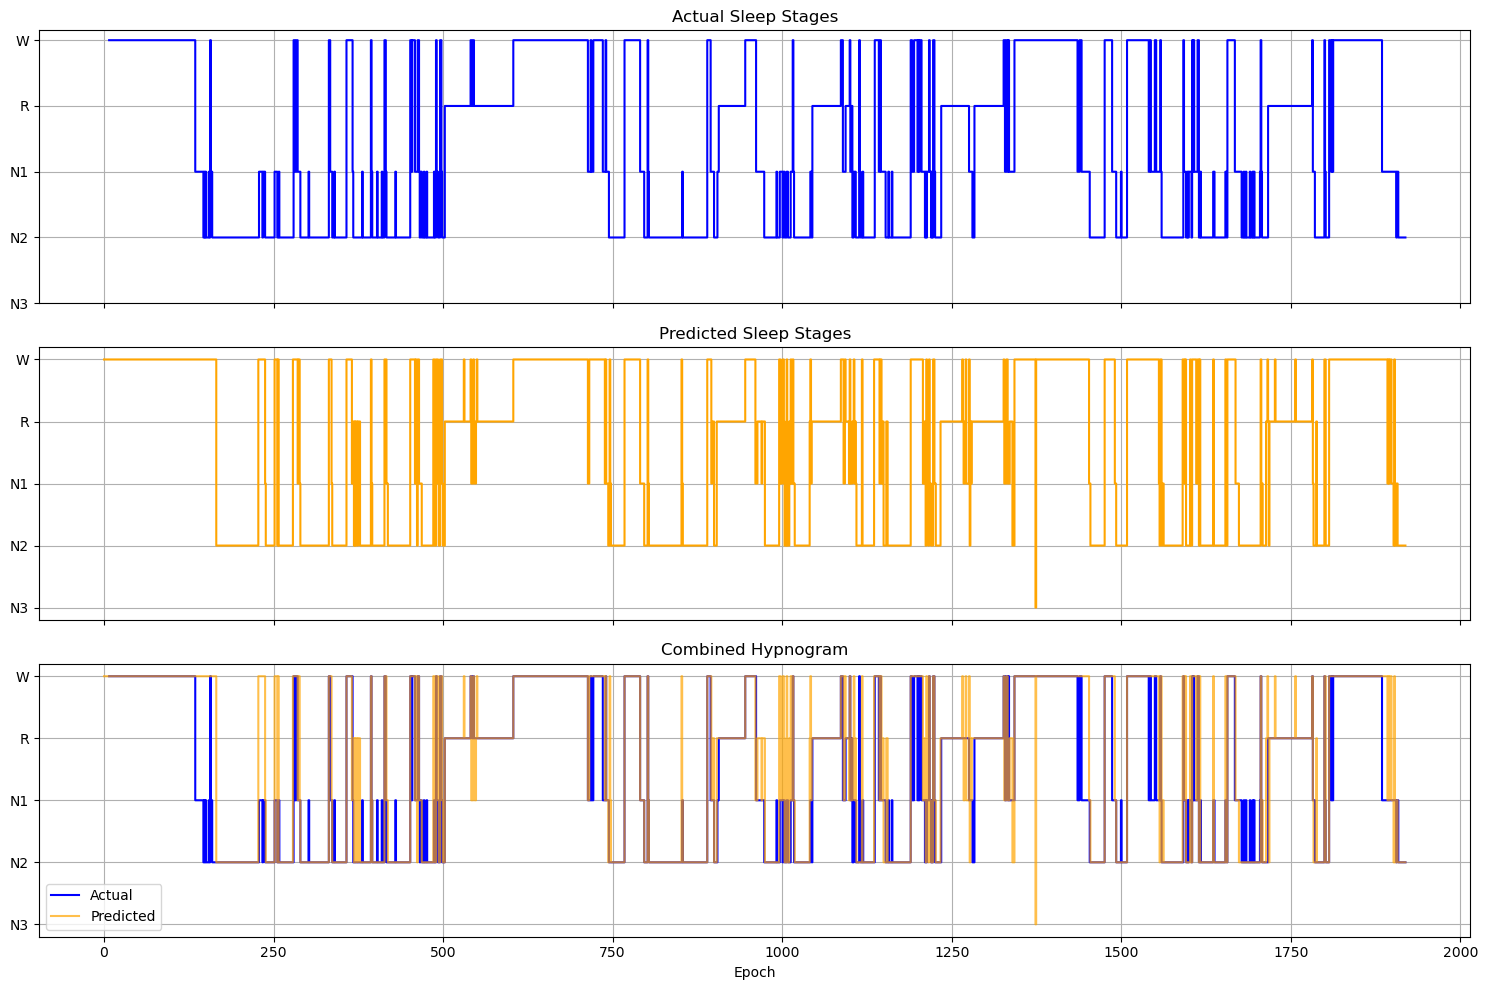

BAD [I0002151724571-1] Acc=0.96 F1=0.96 Kappa=-0.01 Precision=0.24 Recall=0.25 Specificity=0.25 Score=0.52 


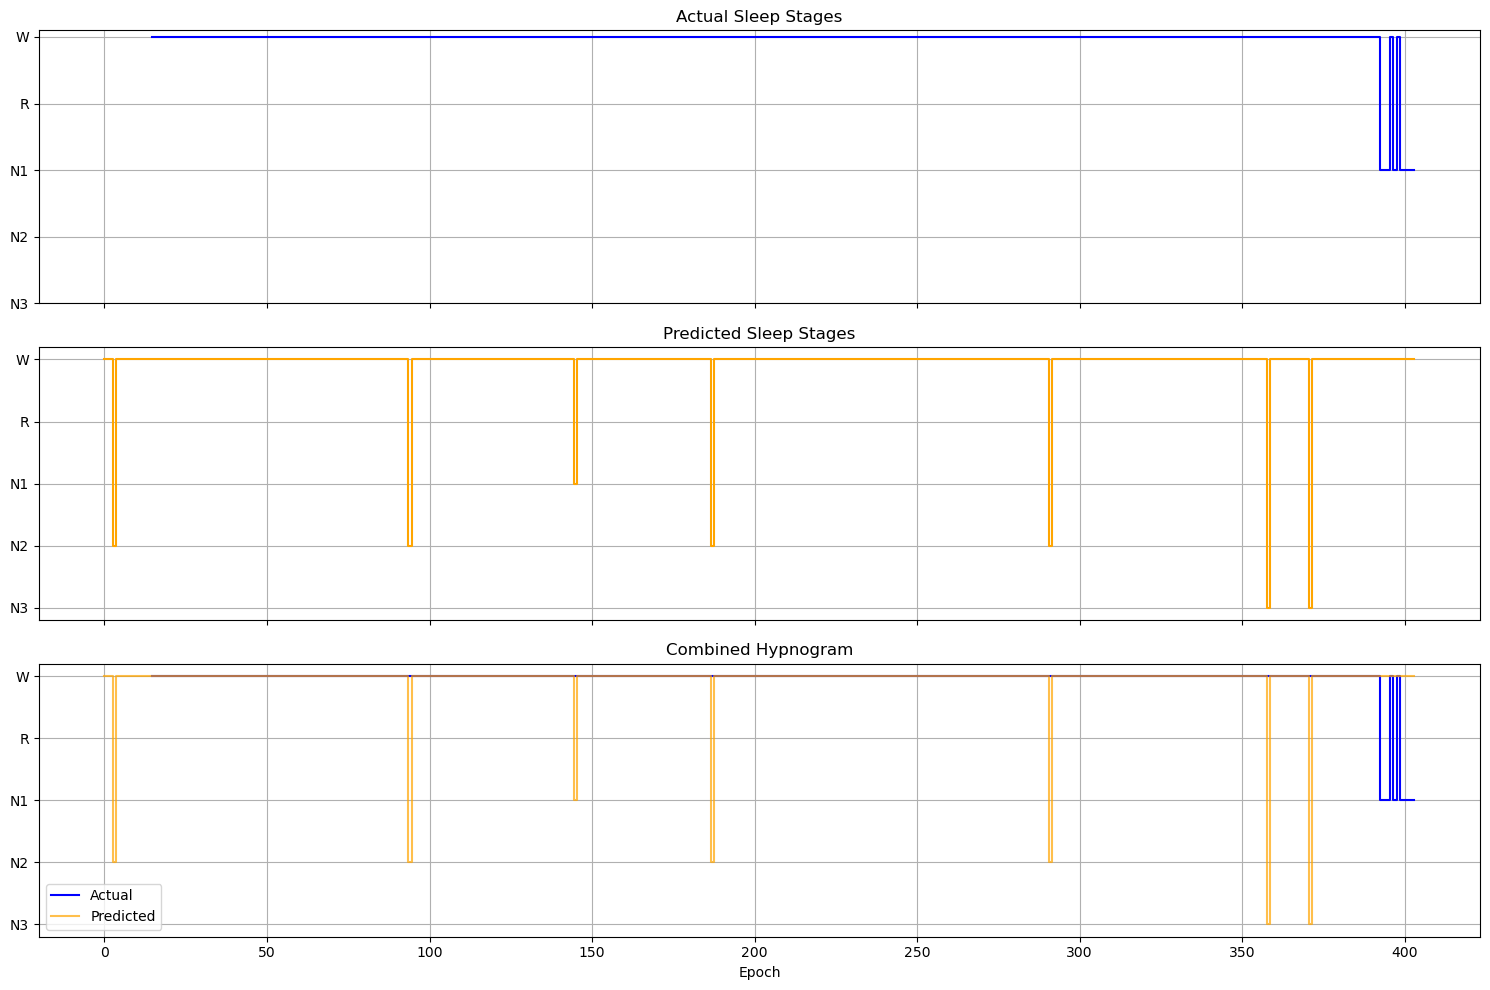

BAD [I0002151734169-1] Acc=0.68 F1=0.65 Kappa=0.52 Precision=0.45 Recall=0.45 Specificity=0.45 Score=0.56 


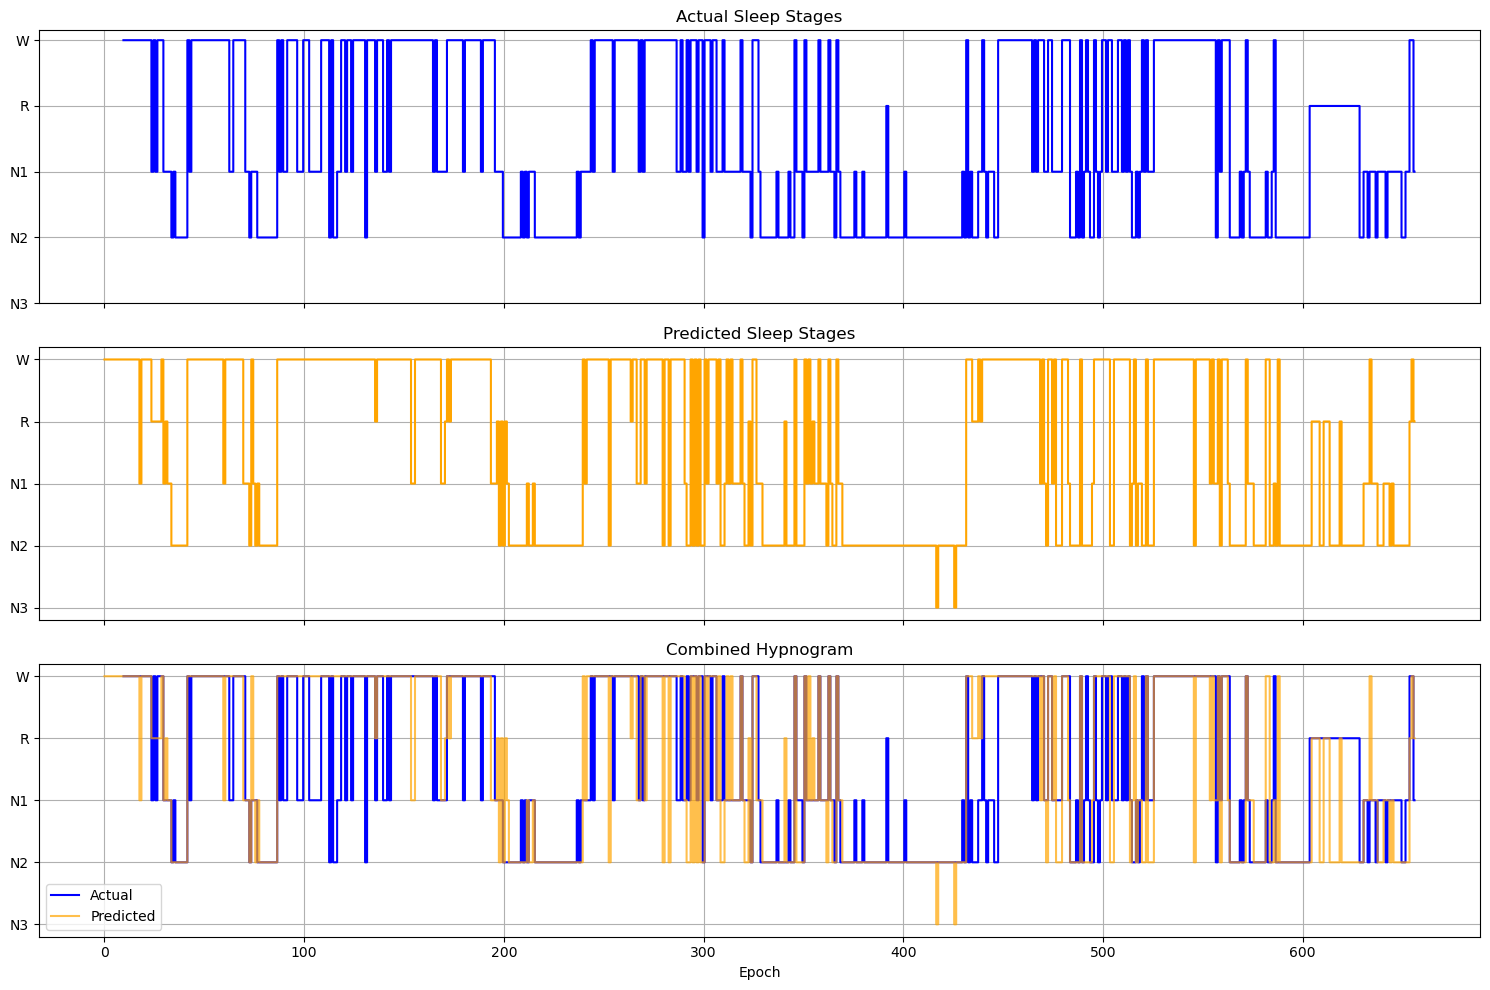

In [18]:
results = []  # to store best metrics per subject/session

for sub_id, session in bidmc_too_long_stages:
    row = bidmc_mastersheet[
        (bidmc_mastersheet['sub_id'] == str(sub_id)) & 
        (bidmc_mastersheet['session'] == int(session))
    ]

    if row.empty:
        print(f"[WARNING] No row found for {sub_id}, session {session}")
        continue
    
    predicted_stages = get_predicted_stages(row)
    actual_stages = bidmc_get_actual_stages(row)

    predicted_stages = np.array(predicted_stages, dtype=float)
    actual_stages = np.array(actual_stages[:len(predicted_stages)],dtype=float)


    cm, kappa, f1, accuracy, precision, recall, specificity = calculate_metrics(actual_stages, predicted_stages)
    composite_score = (
        0.25 * accuracy +
        0.20 * f1 +
        0.20 * kappa +
        0.15 * precision +
        0.10 * recall +
        0.10 * specificity
    )

    # Save best results for this subject/session
    results.append({
        'sub_id': sub_id,
        'session': session, 
        'accuracy': accuracy,
        'f1': f1,
        'kappa': kappa,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'composite_score': composite_score,
        'cm': cm,
    })

    if composite_score >= 0.75:
        status = "GOOD"
    elif composite_score >= 0.65:
        status = "REVIEW"  # borderline
    else:
        status = "BAD"
        
    # Compact progress print
    print(
        f"{status} "
        f"[{sub_id}-{session}] "
        f"Acc={accuracy:.2f} "
        f"F1={f1:.2f} "
        f"Kappa={kappa:.2f} "
        f"Precision={precision:.2f} "
        f"Recall={recall:.2f} "
        f"Specificity={specificity:.2f} "
        f"Score={composite_score:.2f} "
    )
    #print(best_row['cm'])

    plot_hypno(predicted_stages, actual_stages)

results_df = pd.DataFrame(results)

## Other def to keep 

In [55]:
def sliding_metrics(predicted, actual):
    pred = np.array(predicted, dtype=float)
    act = np.array(actual,dtype=float)
    pred_len = len(pred)
    act_len = len(act)

    shifts = range(act_len - pred_len + 1)
    all_metrics = []

    for shift in shifts:
        # Take the slice of actual that aligns with predicted
        actual_slice = act[shift:shift+pred_len]

        # Compute metrics for this alignment
        cm, kappa, f1, accuracy, precision, recall, specificity = calculate_metrics(actual_slice, pred)

        score = 0.5*accuracy + 0.3*f1 + 0.2*kappa

        all_metrics.append({
            'shift': shift,
            'cm': cm,
            'kappa': kappa,
            'f1': f1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'score': score,
        })

    # Convert to DataFrame for easy inspection
    df_metrics = pd.DataFrame(all_metrics)

    best_idx = df_metrics['score'].idxmax()

    return df_metrics, best_idx

In [61]:
results = []  # to store best metrics per subject/session

for sub_id, session in bidmc_too_long_stages[11:30]:
    row = bidmc_mastersheet[
        (bidmc_mastersheet['sub_id'] == str(sub_id)) & 
        (bidmc_mastersheet['session'] == int(session))
    ]

    if row.empty:
        print(f"[WARNING] No row found for {sub_id}, session {session}")
        continue
    
    predicted_stages = get_predicted_stages(row)
    actual_stages = bidmc_get_actual_stages(row)

    df_metrics, best_idx = sliding_metrics(predicted_stages, actual_stages)
    best_row = df_metrics.loc[best_idx]

    # Save best results for this subject/session
    results.append({
        'sub_id': sub_id,
        'session': session, 
        'best_shift': best_row['shift'],
        'accuracy': best_row['accuracy'],
        'f1': best_row['f1'],
        'kappa': best_row['kappa'],
        'precision': best_row['precision'],
        'recall': best_row['recall'],
        'specificity': best_row['specificity'],
        'score': best_row['score'],
        'cm': best_row['cm'],
    })

    # Compact progress print
    print(
        f"[{sub_id}-{session}] "
        f"Acc={best_row['accuracy']:.2f} "
        f"F1={best_row['f1']:.2f} "
        f"Kappa={best_row['kappa']:.2f} "
        f"Precision={best_row['precision']:.2f} "
        f"Recall={best_row['recall']:.2f} "
        f"Specificity={best_row['specificity']:.2f} "
        f"Score={best_row['score']:.2f} "
        f"(Shift={best_row['shift']})"
    )
    print(best_row['cm'])

results_df = pd.DataFrame(results)

[I0002150032018-1] Acc=0.85 F1=0.80 Kappa=0.50 Precision=0.63 Recall=0.47 Specificity=0.47 Score=0.77 (Shift=0)
[[379   0   0   0   0]
 [ 44   2  18   0   3]
 [  5   0  30   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]]
[I0002150031178-1] Acc=0.83 F1=0.81 Kappa=0.76 Precision=0.75 Recall=0.78 Specificity=0.78 Score=0.81 (Shift=0)
[[115   0   3   0   5]
 [ 30  10  23   0   4]
 [  5   7 302  26   9]
 [  0   0   2  39   0]
 [  0   0   0   0 107]]
[I0002150032516-1] Acc=0.76 F1=0.77 Kappa=0.64 Precision=0.68 Recall=0.74 Specificity=0.74 Score=0.74 (Shift=0)
[[108   6   5   1   2]
 [  6  32  22   0   1]
 [  6   8 319  75  12]
 [  0   0   0  60   0]
 [  4  30   1   0  42]]
[I0002150030460-1] Acc=0.75 F1=0.77 Kappa=0.65 Precision=0.71 Recall=0.80 Specificity=0.80 Score=0.74 (Shift=0)
[[206   3   3   0   2]
 [ 18  30  16   0   4]
 [  2   3 196 102   8]
 [  0   0   2  37   0]
 [  0   0   0   0  27]]
[I0002150033236-2] Acc=0.81 F1=0.80 Kappa=0.70 Precision=0.75 Recall=0.69 Specificity=0.

KeyboardInterrupt: 